In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
from collections import Counter
import re

In [4]:
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from verstack.stratified_continuous_split import scsplit # pip install verstack

In [5]:
path = os.getcwd()
path_data_train = path + "\\covidChallenge\\data\\train.csv"
path_data_eval = path + "\\covidChallenge\\data\\evaluation.csv"

In [10]:
train_data = pd.read_csv(path_data_train)

In [11]:
train_data.columns

Index(['id', 'timestamp', 'retweet_count', 'user_verified',
       'user_statuses_count', 'user_followers_count', 'user_friends_count',
       'user_mentions', 'urls', 'hashtags', 'text'],
      dtype='object')

In [12]:
train_data['urls'] = train_data['text'].apply(lambda s: len(re.findall(r'http(\S)+', s)))
train_data['hashtags'] = train_data['text'].apply(lambda s: len(re.findall(r'#[a-zA-Z]+', s)))
train_data['user_mentions'] = train_data['text'].apply(lambda s: len(re.findall(r'@[a-zA-Z_]+', s)))

In [13]:
#Non-relevant features, due to the fact that those are text not numerical values 
train_data.drop('timestamp', axis=1, inplace=True)
train_data.drop('text', axis=1, inplace=True)
train_data.drop('id', axis=1, inplace=True)

In [14]:
train_data.columns

Index(['retweet_count', 'user_verified', 'user_statuses_count',
       'user_followers_count', 'user_friends_count', 'user_mentions', 'urls',
       'hashtags'],
      dtype='object')

In [15]:
#Convert boolean variables into int (Verified/Non-verified account)
train_data = train_data.astype(int)

In [16]:
pd.set_option('precision', 2)
print(train_data.describe())

       retweet_count  user_verified  user_statuses_count  \
count      665777.00      665777.00             6.66e+05   
mean          147.69           0.13             4.17e+04   
std          2972.05           0.34             9.85e+04   
min             0.00           0.00             0.00e+00   
25%             0.00           0.00             2.35e+03   
50%             0.00           0.00             1.08e+04   
75%             2.00           0.00             3.81e+04   
max        942572.00           1.00             7.20e+06   

       user_followers_count  user_friends_count  user_mentions       urls  \
count              6.66e+05            6.66e+05      665777.00  665777.00   
mean               2.33e+05            2.74e+03           0.28       0.38   
std                2.44e+06            1.73e+04           1.38       0.61   
min                0.00e+00            0.00e+00           0.00       0.00   
25%                2.06e+02            2.29e+02           0.00       0.00 

In [17]:
correlation = train_data.corr(method='pearson')
columns = correlation.nlargest(5, 'retweet_count').index
columns

Index(['retweet_count', 'user_followers_count', 'user_verified',
       'user_friends_count', 'urls'],
      dtype='object')

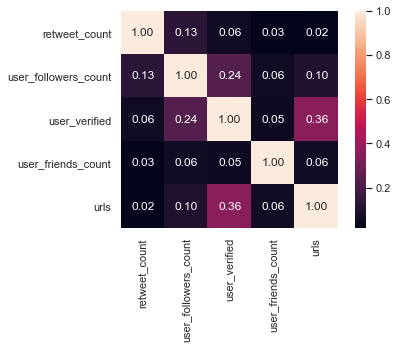

In [18]:
correlation_map = np.corrcoef(train_data[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()

### Preparing dataset

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [20]:
train_data.columns

Index(['retweet_count', 'user_verified', 'user_statuses_count',
       'user_followers_count', 'user_friends_count', 'user_mentions', 'urls',
       'hashtags'],
      dtype='object')

In [21]:
X_train, X_test, y_train, y_test = scsplit(train_data, train_data['retweet_count'], \
                                           stratify=train_data['retweet_count'], train_size=0.7, test_size=0.3, random_state=69)

In [22]:
print("\t Train dataset shape: ", X_train.shape)
print("\t Test dataset shape: ", X_test.shape)

	 Train dataset shape:  (466043, 8)
	 Test dataset shape:  (199734, 8)


In [23]:
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_train, X_train['retweet_count'], \
                                                  test_size=0.1, random_state=21)

In [24]:
print("\t Train dataset shape: ", X_train.shape)
print("\t Val dataset shape: ", X_val.shape)
print("\t Y_Test dataset shape: ", y_train.shape)
print("\t Y_val dataset shape: ", y_val.shape)

	 Train dataset shape:  (419438, 8)
	 Val dataset shape:  (46605, 8)
	 Y_Test dataset shape:  (419438,)
	 Y_val dataset shape:  (46605,)


In [25]:
# We remove the actual number of retweets from our features since it is the value that we are trying to predict
X_train = X_train.drop(['retweet_count'], axis=1)
X_val = X_val.drop(['retweet_count'], axis=1)
X_test = X_test.drop(['retweet_count'], axis=1)

In [26]:
print("\t Train dataset shape: ", X_train.shape)
print("\t Val dataset shape: ", X_val.shape)
print("-----------------------------------------------------")
print("\t Y_train dataset shape: ", y_train.shape)
print("\t Y_val dataset shape: ", y_val.shape)
print("-----------------------------------------------------")
print("\t X_Test dataset shape: ", X_test.shape)
print("\t Y_test dataset shape: ", y_test.shape)

	 Train dataset shape:  (419438, 7)
	 Val dataset shape:  (46605, 7)
-----------------------------------------------------
	 Y_train dataset shape:  (419438,)
	 Y_val dataset shape:  (46605,)
-----------------------------------------------------
	 X_Test dataset shape:  (199734, 7)
	 Y_test dataset shape:  (199734,)


In [27]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

### Creating Model

In [28]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [89]:
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [96]:
EPOCHS = 200
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = X_train.shape[1]

In [97]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

**NN Achitecture**: a simple 3 layer feedforward neural net here. We use ReLU as the activation at all layers.

In [98]:
class Regression(nn.Module):
    def __init__(self, num_features):
        super(Regression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 64)
        self.layer_4 = nn.Linear(64, 32)
        self.layer_5 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)
        
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.relu(self.layer_4(x))
        x = self.relu(self.layer_5(x))
        x = self.layer_out(x)
        return (x)
    
    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.relu(self.layer_4(x))
        x = self.relu(self.layer_5(x))
        x = self.layer_out(x)
        return (x)

In [99]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [100]:
model = Regression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Regression(
  (layer_1): Linear(in_features=7, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=64, bias=True)
  (layer_4): Linear(in_features=64, out_features=32, bias=True)
  (layer_5): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


#### Training model

In [101]:
loss_stats = {
    'train': [],
    "val": []
}

In [102]:
for e in range(1, EPOCHS+1):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_loss_mae = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        loss_mae = nn.L1Loss()(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_loss_mae += loss_mae.item()
        
    # VALIDATION    
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_mae = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            mae_loss = nn.L1Loss()(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
            val_epoch_mae += mae_loss.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')
    print(f'\t   | MAE Train Loss: {train_epoch_loss_mae:.5f} | MAE Val Loss: {val_epoch_mae:.5f}')

Epoch 001: | Train Loss: 8803272.11120 | Val Loss: 4553019.97666
	   | MAE Train Loss: 1701404.47735 | MAE Val Loss: 11415476.96967
Epoch 002: | Train Loss: 8674393.40182 | Val Loss: 4529523.95408
	   | MAE Train Loss: 1667470.76041 | MAE Val Loss: 11005112.70865
Epoch 003: | Train Loss: 8658668.09905 | Val Loss: 4515888.58225
	   | MAE Train Loss: 1626851.35726 | MAE Val Loss: 9829770.74211
Epoch 004: | Train Loss: 8643787.70429 | Val Loss: 4517078.18852
	   | MAE Train Loss: 1596403.48551 | MAE Val Loss: 11063351.71539
Epoch 005: | Train Loss: 8639426.73513 | Val Loss: 4545749.49265
	   | MAE Train Loss: 1605078.24028 | MAE Val Loss: 11277778.90486
Epoch 006: | Train Loss: 8641442.69966 | Val Loss: 4515847.45876
	   | MAE Train Loss: 1602471.29617 | MAE Val Loss: 10433635.60042
Epoch 007: | Train Loss: 8639367.04255 | Val Loss: 4513345.05767
	   | MAE Train Loss: 1605120.19468 | MAE Val Loss: 11056776.34618
Epoch 008: | Train Loss: 8635078.97385 | Val Loss: 4513211.76077
	   | MAE Tr

Epoch 064: | Train Loss: 8594698.33861 | Val Loss: 4507861.21591
	   | MAE Train Loss: 1597334.93835 | MAE Val Loss: 9313930.08480
Epoch 065: | Train Loss: 8586892.47184 | Val Loss: 4513578.33672
	   | MAE Train Loss: 1585234.15759 | MAE Val Loss: 11174184.33612
Epoch 066: | Train Loss: 8584739.91386 | Val Loss: 4499698.03890
	   | MAE Train Loss: 1584000.31404 | MAE Val Loss: 10428149.33920
Epoch 067: | Train Loss: 8576274.18945 | Val Loss: 4514719.28294
	   | MAE Train Loss: 1590995.68567 | MAE Val Loss: 9831709.39992
Epoch 068: | Train Loss: 8599166.43810 | Val Loss: 4514676.75327
	   | MAE Train Loss: 1584920.38166 | MAE Val Loss: 9280476.75465
Epoch 069: | Train Loss: 8568012.42237 | Val Loss: 4496894.16834
	   | MAE Train Loss: 1578911.57856 | MAE Val Loss: 9948871.25161
Epoch 070: | Train Loss: 8579831.20356 | Val Loss: 4519277.82698
	   | MAE Train Loss: 1578168.48038 | MAE Val Loss: 12922993.25579
Epoch 071: | Train Loss: 8577284.49821 | Val Loss: 4516453.61460
	   | MAE Train

Epoch 127: | Train Loss: 8541694.31711 | Val Loss: 4673051.58311
	   | MAE Train Loss: 1580434.81517 | MAE Val Loss: 15254973.29288
Epoch 128: | Train Loss: 8578988.09626 | Val Loss: 4509082.85330
	   | MAE Train Loss: 1626775.38448 | MAE Val Loss: 10007904.35118
Epoch 129: | Train Loss: 8545623.02100 | Val Loss: 4632020.66741
	   | MAE Train Loss: 1599644.88971 | MAE Val Loss: 13551265.64771
Epoch 130: | Train Loss: 8487228.90328 | Val Loss: 4506959.78388
	   | MAE Train Loss: 1590627.69163 | MAE Val Loss: 11623156.87479
Epoch 131: | Train Loss: 8571128.64751 | Val Loss: 4496226.83554
	   | MAE Train Loss: 1611904.95901 | MAE Val Loss: 10615930.37234
Epoch 132: | Train Loss: 8519477.77539 | Val Loss: 4530069.40977
	   | MAE Train Loss: 1600593.80571 | MAE Val Loss: 10107002.01695
Epoch 133: | Train Loss: 8529437.73333 | Val Loss: 4513065.26250
	   | MAE Train Loss: 1612065.33812 | MAE Val Loss: 9823459.16598
Epoch 134: | Train Loss: 8539046.04788 | Val Loss: 4494017.16529
	   | MAE Tr

Epoch 190: | Train Loss: 8520110.95135 | Val Loss: 4562205.63182
	   | MAE Train Loss: 1560914.97804 | MAE Val Loss: 9806028.58766
Epoch 191: | Train Loss: 8511425.42152 | Val Loss: 4511542.50253
	   | MAE Train Loss: 1555936.55514 | MAE Val Loss: 10672148.25963
Epoch 192: | Train Loss: 8510343.27217 | Val Loss: 4509043.90591
	   | MAE Train Loss: 1569189.90051 | MAE Val Loss: 9836642.19221
Epoch 193: | Train Loss: 8549811.08923 | Val Loss: 4502976.79204
	   | MAE Train Loss: 1568143.07253 | MAE Val Loss: 10728310.93276
Epoch 194: | Train Loss: 8550884.65816 | Val Loss: 4489122.16849
	   | MAE Train Loss: 1564508.02424 | MAE Val Loss: 10722514.97149
Epoch 195: | Train Loss: 8509681.65453 | Val Loss: 4524974.70330
	   | MAE Train Loss: 1568047.82816 | MAE Val Loss: 9567593.81057
Epoch 196: | Train Loss: 8567309.43937 | Val Loss: 4501293.26740
	   | MAE Train Loss: 1581783.59191 | MAE Val Loss: 10524253.56733
Epoch 197: | Train Loss: 8513251.32224 | Val Loss: 4521946.22775
	   | MAE Trai

### Checking Results

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

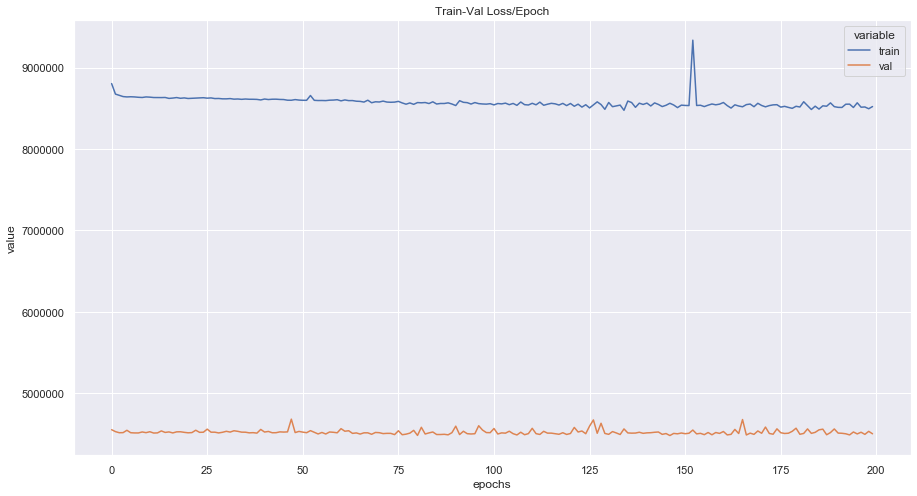

In [103]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

### Testing Model

In [104]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [105]:
mse = mean_squared_error(y_test, y_pred_list)
mae = mean_absolute_error(y_test, y_pred_list)
print("Mean Squared Error :", mse)
print("mean_absolute_error :", mae)

Mean Squared Error : 9269369.746158665
mean_absolute_error : 217.29757313564943


### Saving Model

In [106]:
PATH = "NN_" + str(EPOCHS) + "_epochs_" + str(int(mae)) + ".pt"
torch.save(model.state_dict(), PATH)

### Predicting Kaggle dataset

In [64]:
evaluation = pd.read_csv(path_data_eval)

In [65]:
evaluation['urls'] = evaluation['text'].apply(lambda s: len(re.findall(r'http(\S)+', s)))
evaluation['hashtags'] = evaluation['text'].apply(lambda s: len(re.findall(r'#[a-zA-Z]+', s)))
evaluation['user_mentions'] = evaluation['text'].apply(lambda s: len(re.findall(r'@[a-zA-Z_]+', s)))

In [66]:
#Non-relevant features, can not be used for LR models
evaluation.drop('timestamp', axis=1, inplace=True)
evaluation.drop('text', axis=1, inplace=True)

In [68]:
print("\t Shape of evaluation: ", evaluation.shape)

	 Shape of evaluation:  (285334, 8)


In [69]:
withoutID = evaluation.copy()
withoutID.drop('id', axis=1, inplace=True)

In [70]:
scaler = MinMaxScaler()
withoutID = scaler.fit_transform(withoutID)
#withoutID = np.array(withoutID)

In [74]:
withoutID.shape

(285334, 7)

In [81]:
class EvaluationDataset(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [82]:
withoutID = EvaluationDataset(torch.from_numpy(withoutID).float())
evaluation_loader = DataLoader(dataset=withoutID, batch_size=1)

In [84]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch in evaluation_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [85]:
import csv

f = open("NN_epochs20.csv", "w+")
with open("NN_epochs20.csv", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "NoRetweets"])
    
    startIndex = 665776
    for index, prediction in enumerate(y_pred_list):
        print(str(evaluation['id'].iloc[index]) + " ," + str(int(prediction)))
        writer.writerow([str(startIndex + index) , str(int(prediction))])

665776 ,39
665777 ,544
665778 ,44
665779 ,506
665780 ,289
665781 ,39
665782 ,40
665783 ,223
665784 ,572
665785 ,46
665786 ,601
665787 ,45
665788 ,66
665789 ,690
665790 ,46
665791 ,30
665792 ,32
665793 ,25
665794 ,717
665795 ,46
665796 ,40
665797 ,91
665798 ,365
665799 ,50
665800 ,39
665801 ,40
665802 ,40
665803 ,32
665804 ,89
665805 ,27
665806 ,269
665807 ,30
665808 ,482
665809 ,39
665810 ,41
665811 ,148
665812 ,39
665813 ,279
665814 ,307
665815 ,39
665816 ,43
665817 ,89
665818 ,49
665819 ,39
665820 ,39
665821 ,40
665822 ,320
665823 ,40
665824 ,349
665825 ,155
665826 ,329
665827 ,54
665828 ,273
665829 ,13
665830 ,303
665831 ,42
665832 ,42
665833 ,40
665834 ,41
665835 ,42
665836 ,55
665837 ,39
665838 ,200
665839 ,43
665840 ,39
665841 ,45
665842 ,39
665843 ,86
665844 ,41
665845 ,39
665846 ,90
665847 ,40
665848 ,201
665849 ,52
665850 ,176
665851 ,98
665852 ,39
665853 ,39
665854 ,270
665855 ,49
665856 ,40
665857 ,39
665858 ,54
665859 ,286
665860 ,60
665861 ,273
665862 ,41
665863 ,49
665864

667121 ,41
667122 ,150
667123 ,616
667124 ,58
667125 ,39
667126 ,39
667127 ,749
667128 ,777
667129 ,41
667130 ,40
667131 ,39
667132 ,69
667133 ,39
667134 ,39
667135 ,52
667136 ,46
667137 ,127
667138 ,53
667139 ,39
667140 ,41
667141 ,40
667142 ,52
667143 ,597
667144 ,334
667145 ,626
667146 ,238
667147 ,54
667148 ,20
667149 ,69
667150 ,39
667151 ,50
667152 ,23
667153 ,290
667154 ,40
667155 ,39
667156 ,39
667157 ,52
667158 ,41
667159 ,96
667160 ,48
667161 ,45
667162 ,324
667163 ,39
667164 ,41
667165 ,49
667166 ,42
667167 ,273
667168 ,586
667169 ,183
667170 ,49
667171 ,271
667172 ,29
667173 ,31
667174 ,67
667175 ,40
667176 ,755
667177 ,40
667178 ,41
667179 ,272
667180 ,40
667181 ,67
667182 ,366
667183 ,39
667184 ,44
667185 ,42
667186 ,74
667187 ,44
667188 ,43
667189 ,271
667190 ,42
667191 ,442
667192 ,39
667193 ,270
667194 ,43
667195 ,26
667196 ,49
667197 ,216
667198 ,474
667199 ,39
667200 ,47
667201 ,313
667202 ,52
667203 ,23
667204 ,39
667205 ,448
667206 ,63
667207 ,270
667208 ,21
667209

667967 ,29
667968 ,40
667969 ,61
667970 ,269
667971 ,40
667972 ,42
667973 ,61
667974 ,39
667975 ,39
667976 ,423
667977 ,40
667978 ,40
667979 ,269
667980 ,40
667981 ,39
667982 ,39
667983 ,39
667984 ,672
667985 ,39
667986 ,714
667987 ,42
667988 ,39
667989 ,40
667990 ,45
667991 ,39
667992 ,66
667993 ,39
667994 ,49
667995 ,69
667996 ,39
667997 ,39
667998 ,60
667999 ,40
668000 ,42
668001 ,40
668002 ,39
668003 ,45
668004 ,271
668005 ,193
668006 ,597
668007 ,41
668008 ,39
668009 ,39
668010 ,29
668011 ,39
668012 ,27
668013 ,40
668014 ,639
668015 ,48
668016 ,56
668017 ,39
668018 ,39
668019 ,39
668020 ,40
668021 ,41
668022 ,40
668023 ,51
668024 ,280
668025 ,39
668026 ,337
668027 ,304
668028 ,61
668029 ,44
668030 ,39
668031 ,597
668032 ,78
668033 ,20
668034 ,41
668035 ,202
668036 ,39
668037 ,39
668038 ,135
668039 ,39
668040 ,47
668041 ,78
668042 ,260
668043 ,290
668044 ,39
668045 ,209
668046 ,40
668047 ,41
668048 ,44
668049 ,45
668050 ,46
668051 ,40
668052 ,20
668053 ,47
668054 ,39
668055 ,39
668

669053 ,41
669054 ,47
669055 ,23
669056 ,270
669057 ,357
669058 ,40
669059 ,42
669060 ,43
669061 ,22
669062 ,41
669063 ,55
669064 ,39
669065 ,288
669066 ,42
669067 ,40
669068 ,361
669069 ,39
669070 ,138
669071 ,49
669072 ,42
669073 ,246
669074 ,39
669075 ,20
669076 ,375
669077 ,595
669078 ,45
669079 ,40
669080 ,189
669081 ,40
669082 ,50
669083 ,39
669084 ,276
669085 ,40
669086 ,40
669087 ,272
669088 ,86
669089 ,58
669090 ,283
669091 ,292
669092 ,39
669093 ,39
669094 ,39
669095 ,48
669096 ,69
669097 ,40
669098 ,260
669099 ,577
669100 ,220
669101 ,677
669102 ,46
669103 ,270
669104 ,40
669105 ,266
669106 ,39
669107 ,186
669108 ,40
669109 ,39
669110 ,193
669111 ,40
669112 ,39
669113 ,41
669114 ,77
669115 ,23
669116 ,39
669117 ,313
669118 ,56
669119 ,563
669120 ,165
669121 ,323
669122 ,71
669123 ,20
669124 ,39
669125 ,21
669126 ,23
669127 ,40
669128 ,49
669129 ,40
669130 ,40
669131 ,42
669132 ,52
669133 ,40
669134 ,41
669135 ,131
669136 ,41
669137 ,43
669138 ,269
669139 ,43
669140 ,39
66914

670202 ,315
670203 ,99
670204 ,69
670205 ,437
670206 ,307
670207 ,125
670208 ,100
670209 ,40
670210 ,39
670211 ,50
670212 ,40
670213 ,83
670214 ,1793
670215 ,41
670216 ,276
670217 ,41
670218 ,134
670219 ,47
670220 ,55
670221 ,47
670222 ,293
670223 ,24
670224 ,41
670225 ,42
670226 ,48
670227 ,46
670228 ,269
670229 ,270
670230 ,40
670231 ,42
670232 ,41
670233 ,44
670234 ,127
670235 ,51
670236 ,43
670237 ,40
670238 ,57
670239 ,41
670240 ,48
670241 ,50
670242 ,163
670243 ,40
670244 ,52
670245 ,40
670246 ,599
670247 ,43
670248 ,273
670249 ,42
670250 ,43
670251 ,39
670252 ,50
670253 ,39
670254 ,50
670255 ,21
670256 ,723
670257 ,150
670258 ,686
670259 ,41
670260 ,83
670261 ,39
670262 ,40
670263 ,20
670264 ,44
670265 ,45
670266 ,40
670267 ,40
670268 ,39
670269 ,41
670270 ,39
670271 ,41
670272 ,498
670273 ,46
670274 ,107
670275 ,894
670276 ,581
670277 ,45
670278 ,47
670279 ,103
670280 ,57
670281 ,43
670282 ,605
670283 ,42
670284 ,45
670285 ,39
670286 ,34
670287 ,33
670288 ,41
670289 ,39
670290 

671618 ,40
671619 ,260
671620 ,39
671621 ,41
671622 ,44
671623 ,48
671624 ,366
671625 ,39
671626 ,386
671627 ,21
671628 ,39
671629 ,187
671630 ,39
671631 ,283
671632 ,230
671633 ,168
671634 ,42
671635 ,44
671636 ,45
671637 ,86
671638 ,1223
671639 ,269
671640 ,43
671641 ,47
671642 ,290
671643 ,40
671644 ,63
671645 ,27
671646 ,90
671647 ,40
671648 ,41
671649 ,40
671650 ,269
671651 ,30
671652 ,24
671653 ,53
671654 ,272
671655 ,24
671656 ,111
671657 ,25
671658 ,155
671659 ,42
671660 ,60
671661 ,52
671662 ,720
671663 ,40
671664 ,88
671665 ,40
671666 ,39
671667 ,294
671668 ,50
671669 ,195
671670 ,47
671671 ,184
671672 ,45
671673 ,53
671674 ,258
671675 ,40
671676 ,55
671677 ,270
671678 ,39
671679 ,50
671680 ,63
671681 ,1488
671682 ,42
671683 ,42
671684 ,48
671685 ,130
671686 ,40
671687 ,113
671688 ,54
671689 ,39
671690 ,245
671691 ,46
671692 ,47
671693 ,50
671694 ,45
671695 ,277
671696 ,39
671697 ,2170
671698 ,41
671699 ,42
671700 ,59
671701 ,41
671702 ,66
671703 ,39
671704 ,269
671705 ,51
67

672678 ,53
672679 ,40
672680 ,54
672681 ,269
672682 ,39
672683 ,39
672684 ,101
672685 ,47
672686 ,715
672687 ,47
672688 ,295
672689 ,54
672690 ,233
672691 ,65
672692 ,20
672693 ,24
672694 ,99
672695 ,40
672696 ,41
672697 ,40
672698 ,42
672699 ,41
672700 ,96
672701 ,41
672702 ,130
672703 ,48
672704 ,296
672705 ,65
672706 ,40
672707 ,320
672708 ,40
672709 ,40
672710 ,40
672711 ,43
672712 ,297
672713 ,49
672714 ,294
672715 ,335
672716 ,60
672717 ,394
672718 ,222
672719 ,49
672720 ,704
672721 ,189
672722 ,269
672723 ,39
672724 ,95
672725 ,41
672726 ,40
672727 ,295
672728 ,43
672729 ,42
672730 ,40
672731 ,699
672732 ,40
672733 ,81
672734 ,89
672735 ,45
672736 ,612
672737 ,44
672738 ,40
672739 ,212
672740 ,25
672741 ,82
672742 ,31
672743 ,143
672744 ,95
672745 ,21
672746 ,40
672747 ,41
672748 ,293
672749 ,42
672750 ,53
672751 ,621
672752 ,553
672753 ,64
672754 ,23
672755 ,42
672756 ,270
672757 ,48
672758 ,46
672759 ,363
672760 ,47
672761 ,39
672762 ,468
672763 ,94
672764 ,47
672765 ,14
67276

674158 ,40
674159 ,43
674160 ,41
674161 ,39
674162 ,41
674163 ,51
674164 ,43
674165 ,269
674166 ,40
674167 ,19
674168 ,39
674169 ,133
674170 ,39
674171 ,23
674172 ,839
674173 ,67
674174 ,40
674175 ,39
674176 ,39
674177 ,136
674178 ,43
674179 ,228
674180 ,33
674181 ,67
674182 ,51
674183 ,39
674184 ,647
674185 ,39
674186 ,41
674187 ,40
674188 ,206
674189 ,21
674190 ,39
674191 ,138
674192 ,270
674193 ,304
674194 ,560
674195 ,56
674196 ,39
674197 ,49
674198 ,272
674199 ,39
674200 ,274
674201 ,56
674202 ,27
674203 ,103
674204 ,40
674205 ,194
674206 ,48
674207 ,288
674208 ,40
674209 ,270
674210 ,40
674211 ,41
674212 ,274
674213 ,47
674214 ,1399
674215 ,41
674216 ,295
674217 ,57
674218 ,45
674219 ,43
674220 ,41
674221 ,286
674222 ,62
674223 ,28
674224 ,23
674225 ,54
674226 ,39
674227 ,39
674228 ,77
674229 ,243
674230 ,206
674231 ,39
674232 ,40
674233 ,44
674234 ,37
674235 ,41
674236 ,205
674237 ,39
674238 ,51
674239 ,50
674240 ,72
674241 ,45
674242 ,71
674243 ,46
674244 ,39
674245 ,42
674246 

675022 ,670
675023 ,43
675024 ,51
675025 ,269
675026 ,63
675027 ,41
675028 ,21
675029 ,41
675030 ,288
675031 ,274
675032 ,39
675033 ,64
675034 ,26
675035 ,41
675036 ,43
675037 ,106
675038 ,39
675039 ,39
675040 ,41
675041 ,40
675042 ,41
675043 ,40
675044 ,345
675045 ,761
675046 ,58
675047 ,46
675048 ,39
675049 ,269
675050 ,39
675051 ,298
675052 ,39
675053 ,441
675054 ,46
675055 ,41
675056 ,45
675057 ,102
675058 ,39
675059 ,39
675060 ,41
675061 ,39
675062 ,204
675063 ,126
675064 ,783
675065 ,40
675066 ,64
675067 ,270
675068 ,43
675069 ,67
675070 ,45
675071 ,42
675072 ,40
675073 ,44
675074 ,40
675075 ,47
675076 ,780
675077 ,272
675078 ,62
675079 ,270
675080 ,54
675081 ,39
675082 ,841
675083 ,40
675084 ,346
675085 ,327
675086 ,131
675087 ,219
675088 ,300
675089 ,76
675090 ,20
675091 ,111
675092 ,44
675093 ,40
675094 ,334
675095 ,40
675096 ,111
675097 ,177
675098 ,26
675099 ,40
675100 ,45
675101 ,41
675102 ,54
675103 ,47
675104 ,44
675105 ,41
675106 ,26
675107 ,217
675108 ,40
675109 ,40
675

676452 ,279
676453 ,42
676454 ,348
676455 ,45
676456 ,45
676457 ,287
676458 ,252
676459 ,276
676460 ,24
676461 ,442
676462 ,68
676463 ,271
676464 ,108
676465 ,40
676466 ,726
676467 ,39
676468 ,40
676469 ,46
676470 ,48
676471 ,40
676472 ,50
676473 ,65
676474 ,40
676475 ,40
676476 ,600
676477 ,269
676478 ,299
676479 ,61
676480 ,28
676481 ,42
676482 ,714
676483 ,47
676484 ,44
676485 ,39
676486 ,39
676487 ,102
676488 ,251
676489 ,43
676490 ,39
676491 ,47
676492 ,19
676493 ,41
676494 ,106
676495 ,40
676496 ,46
676497 ,313
676498 ,40
676499 ,436
676500 ,41
676501 ,49
676502 ,40
676503 ,39
676504 ,42
676505 ,205
676506 ,40
676507 ,43
676508 ,34
676509 ,43
676510 ,185
676511 ,42
676512 ,40
676513 ,51
676514 ,41
676515 ,269
676516 ,41
676517 ,39
676518 ,286
676519 ,50
676520 ,20
676521 ,44
676522 ,195
676523 ,49
676524 ,271
676525 ,40
676526 ,813
676527 ,21
676528 ,58
676529 ,22
676530 ,39
676531 ,41
676532 ,40
676533 ,270
676534 ,116
676535 ,133
676536 ,52
676537 ,38
676538 ,299
676539 ,48
676

677680 ,39
677681 ,41
677682 ,25
677683 ,646
677684 ,42
677685 ,56
677686 ,40
677687 ,269
677688 ,54
677689 ,277
677690 ,25
677691 ,48
677692 ,45
677693 ,40
677694 ,70
677695 ,71
677696 ,47
677697 ,40
677698 ,43
677699 ,25
677700 ,40
677701 ,46
677702 ,76
677703 ,46
677704 ,40
677705 ,553
677706 ,40
677707 ,48
677708 ,90
677709 ,39
677710 ,123
677711 ,97
677712 ,51
677713 ,41
677714 ,302
677715 ,42
677716 ,300
677717 ,39
677718 ,41
677719 ,41
677720 ,40
677721 ,42
677722 ,43
677723 ,322
677724 ,218
677725 ,217
677726 ,41
677727 ,702
677728 ,40
677729 ,40
677730 ,40
677731 ,40
677732 ,40
677733 ,42
677734 ,86
677735 ,58
677736 ,39
677737 ,43
677738 ,39
677739 ,104
677740 ,42
677741 ,311
677742 ,39
677743 ,46
677744 ,41
677745 ,118
677746 ,39
677747 ,41
677748 ,275
677749 ,42
677750 ,39
677751 ,44
677752 ,318
677753 ,42
677754 ,41
677755 ,42
677756 ,51
677757 ,269
677758 ,77
677759 ,21
677760 ,39
677761 ,68
677762 ,41
677763 ,61
677764 ,52
677765 ,40
677766 ,54
677767 ,44
677768 ,35
6777

678475 ,41
678476 ,40
678477 ,42
678478 ,486
678479 ,523
678480 ,311
678481 ,51
678482 ,63
678483 ,26
678484 ,41
678485 ,39
678486 ,40
678487 ,48
678488 ,133
678489 ,285
678490 ,40
678491 ,39
678492 ,54
678493 ,40
678494 ,93
678495 ,317
678496 ,53
678497 ,40
678498 ,25
678499 ,41
678500 ,660
678501 ,44
678502 ,42
678503 ,40
678504 ,269
678505 ,40
678506 ,20
678507 ,50
678508 ,19
678509 ,684
678510 ,42
678511 ,40
678512 ,277
678513 ,39
678514 ,44
678515 ,42
678516 ,805
678517 ,318
678518 ,83
678519 ,48
678520 ,108
678521 ,39
678522 ,42
678523 ,455
678524 ,337
678525 ,40
678526 ,40
678527 ,40
678528 ,334
678529 ,47
678530 ,40
678531 ,40
678532 ,696
678533 ,39
678534 ,303
678535 ,52
678536 ,40
678537 ,574
678538 ,39
678539 ,39
678540 ,46
678541 ,273
678542 ,41
678543 ,14
678544 ,238
678545 ,40
678546 ,312
678547 ,40
678548 ,39
678549 ,285
678550 ,39
678551 ,80
678552 ,270
678553 ,105
678554 ,794
678555 ,40
678556 ,54
678557 ,40
678558 ,111
678559 ,41
678560 ,39
678561 ,41
678562 ,48
67856

679693 ,79
679694 ,43
679695 ,45
679696 ,286
679697 ,50
679698 ,42
679699 ,49
679700 ,417
679701 ,313
679702 ,273
679703 ,48
679704 ,43
679705 ,40
679706 ,51
679707 ,22
679708 ,39
679709 ,40
679710 ,220
679711 ,41
679712 ,431
679713 ,526
679714 ,39
679715 ,42
679716 ,44
679717 ,42
679718 ,446
679719 ,33
679720 ,313
679721 ,275
679722 ,26
679723 ,550
679724 ,271
679725 ,45
679726 ,42
679727 ,43
679728 ,64
679729 ,216
679730 ,58
679731 ,435
679732 ,276
679733 ,44
679734 ,45
679735 ,89
679736 ,23
679737 ,77
679738 ,51
679739 ,52
679740 ,51
679741 ,41
679742 ,252
679743 ,39
679744 ,39
679745 ,40
679746 ,309
679747 ,44
679748 ,78
679749 ,109
679750 ,39
679751 ,62
679752 ,40
679753 ,275
679754 ,68
679755 ,44
679756 ,49
679757 ,42
679758 ,17
679759 ,271
679760 ,269
679761 ,39
679762 ,23
679763 ,420
679764 ,71
679765 ,39
679766 ,831
679767 ,76
679768 ,42
679769 ,44
679770 ,39
679771 ,39
679772 ,42
679773 ,157
679774 ,50
679775 ,45
679776 ,24
679777 ,165
679778 ,56
679779 ,39
679780 ,247
679781

680485 ,39
680486 ,57
680487 ,271
680488 ,41
680489 ,43
680490 ,103
680491 ,85
680492 ,495
680493 ,39
680494 ,40
680495 ,39
680496 ,42
680497 ,50
680498 ,52
680499 ,55
680500 ,40
680501 ,53
680502 ,52
680503 ,39
680504 ,315
680505 ,124
680506 ,471
680507 ,39
680508 ,50
680509 ,44
680510 ,187
680511 ,39
680512 ,49
680513 ,39
680514 ,71
680515 ,41
680516 ,40
680517 ,490
680518 ,195
680519 ,215
680520 ,40
680521 ,73
680522 ,42
680523 ,552
680524 ,39
680525 ,39
680526 ,41
680527 ,23
680528 ,48
680529 ,45
680530 ,51
680531 ,39
680532 ,123
680533 ,339
680534 ,30
680535 ,53
680536 ,50
680537 ,588
680538 ,47
680539 ,19
680540 ,202
680541 ,41
680542 ,40
680543 ,44
680544 ,39
680545 ,39
680546 ,275
680547 ,39
680548 ,41
680549 ,68
680550 ,76
680551 ,41
680552 ,50
680553 ,45
680554 ,39
680555 ,71
680556 ,94
680557 ,53
680558 ,59
680559 ,41
680560 ,51
680561 ,51
680562 ,42
680563 ,610
680564 ,99
680565 ,296
680566 ,39
680567 ,40
680568 ,77
680569 ,43
680570 ,47
680571 ,72
680572 ,271
680573 ,269
6

681615 ,40
681616 ,64
681617 ,269
681618 ,276
681619 ,146
681620 ,40
681621 ,60
681622 ,66
681623 ,46
681624 ,670
681625 ,40
681626 ,291
681627 ,97
681628 ,23
681629 ,320
681630 ,40
681631 ,76
681632 ,286
681633 ,312
681634 ,54
681635 ,41
681636 ,40
681637 ,40
681638 ,42
681639 ,40
681640 ,41
681641 ,180
681642 ,41
681643 ,52
681644 ,127
681645 ,53
681646 ,39
681647 ,51
681648 ,50
681649 ,42
681650 ,77
681651 ,39
681652 ,56
681653 ,69
681654 ,209
681655 ,267
681656 ,35
681657 ,52
681658 ,39
681659 ,39
681660 ,221
681661 ,41
681662 ,48
681663 ,292
681664 ,42
681665 ,39
681666 ,40
681667 ,65
681668 ,41
681669 ,33
681670 ,40
681671 ,40
681672 ,40
681673 ,21
681674 ,39
681675 ,79
681676 ,40
681677 ,299
681678 ,75
681679 ,630
681680 ,42
681681 ,316
681682 ,96
681683 ,320
681684 ,39
681685 ,39
681686 ,126
681687 ,218
681688 ,40
681689 ,40
681690 ,40
681691 ,63
681692 ,40
681693 ,283
681694 ,39
681695 ,39
681696 ,40
681697 ,76
681698 ,48
681699 ,42
681700 ,42
681701 ,80
681702 ,40
681703 ,40


683109 ,602
683110 ,40
683111 ,40
683112 ,448
683113 ,39
683114 ,43
683115 ,156
683116 ,72
683117 ,29
683118 ,57
683119 ,41
683120 ,60
683121 ,360
683122 ,271
683123 ,42
683124 ,41
683125 ,274
683126 ,39
683127 ,40
683128 ,39
683129 ,49
683130 ,40
683131 ,39
683132 ,39
683133 ,564
683134 ,40
683135 ,57
683136 ,71
683137 ,39
683138 ,269
683139 ,582
683140 ,195
683141 ,40
683142 ,109
683143 ,44
683144 ,41
683145 ,57
683146 ,41
683147 ,42
683148 ,51
683149 ,40
683150 ,17
683151 ,269
683152 ,39
683153 ,54
683154 ,40
683155 ,44
683156 ,71
683157 ,42
683158 ,63
683159 ,47
683160 ,41
683161 ,72
683162 ,48
683163 ,1823
683164 ,46
683165 ,39
683166 ,341
683167 ,44
683168 ,49
683169 ,40
683170 ,572
683171 ,64
683172 ,62
683173 ,53
683174 ,317
683175 ,39
683176 ,40
683177 ,39
683178 ,46
683179 ,35
683180 ,48
683181 ,39
683182 ,40
683183 ,302
683184 ,41
683185 ,309
683186 ,41
683187 ,39
683188 ,46
683189 ,543
683190 ,325
683191 ,46
683192 ,40
683193 ,83
683194 ,442
683195 ,39
683196 ,95
683197 ,45

683865 ,40
683866 ,41
683867 ,26
683868 ,40
683869 ,52
683870 ,44
683871 ,39
683872 ,131
683873 ,40
683874 ,282
683875 ,103
683876 ,277
683877 ,40
683878 ,23
683879 ,118
683880 ,273
683881 ,47
683882 ,41
683883 ,39
683884 ,79
683885 ,40
683886 ,82
683887 ,132
683888 ,39
683889 ,59
683890 ,223
683891 ,285
683892 ,47
683893 ,39
683894 ,41
683895 ,161
683896 ,46
683897 ,39
683898 ,39
683899 ,39
683900 ,27
683901 ,48
683902 ,39
683903 ,40
683904 ,39
683905 ,41
683906 ,44
683907 ,39
683908 ,44
683909 ,41
683910 ,41
683911 ,532
683912 ,78
683913 ,90
683914 ,134
683915 ,41
683916 ,58
683917 ,61
683918 ,39
683919 ,59
683920 ,43
683921 ,278
683922 ,33
683923 ,39
683924 ,133
683925 ,59
683926 ,453
683927 ,46
683928 ,39
683929 ,188
683930 ,555
683931 ,40
683932 ,41
683933 ,272
683934 ,71
683935 ,48
683936 ,41
683937 ,228
683938 ,50
683939 ,39
683940 ,44
683941 ,39
683942 ,42
683943 ,39
683944 ,650
683945 ,188
683946 ,41
683947 ,193
683948 ,25
683949 ,41
683950 ,209
683951 ,109
683952 ,123
683953 

684608 ,315
684609 ,46
684610 ,26
684611 ,47
684612 ,44
684613 ,511
684614 ,44
684615 ,772
684616 ,42
684617 ,67
684618 ,52
684619 ,40
684620 ,272
684621 ,622
684622 ,43
684623 ,53
684624 ,39
684625 ,79
684626 ,40
684627 ,40
684628 ,48
684629 ,42
684630 ,314
684631 ,41
684632 ,428
684633 ,64
684634 ,659
684635 ,43
684636 ,41
684637 ,447
684638 ,51
684639 ,48
684640 ,40
684641 ,735
684642 ,716
684643 ,306
684644 ,40
684645 ,60
684646 ,39
684647 ,58
684648 ,39
684649 ,20
684650 ,740
684651 ,40
684652 ,48
684653 ,44
684654 ,26
684655 ,48
684656 ,48
684657 ,40
684658 ,42
684659 ,49
684660 ,44
684661 ,643
684662 ,21
684663 ,43
684664 ,316
684665 ,48
684666 ,58
684667 ,133
684668 ,742
684669 ,53
684670 ,585
684671 ,40
684672 ,21
684673 ,273
684674 ,218
684675 ,53
684676 ,40
684677 ,41
684678 ,281
684679 ,66
684680 ,39
684681 ,23
684682 ,381
684683 ,39
684684 ,52
684685 ,46
684686 ,41
684687 ,40
684688 ,40
684689 ,40
684690 ,22
684691 ,747
684692 ,43
684693 ,82
684694 ,39
684695 ,41
684696 ,4

685561 ,42
685562 ,39
685563 ,10
685564 ,324
685565 ,39
685566 ,63
685567 ,39
685568 ,270
685569 ,43
685570 ,24
685571 ,1379
685572 ,40
685573 ,54
685574 ,40
685575 ,92
685576 ,41
685577 ,46
685578 ,269
685579 ,39
685580 ,282
685581 ,50
685582 ,46
685583 ,60
685584 ,52
685585 ,44
685586 ,629
685587 ,39
685588 ,197
685589 ,40
685590 ,39
685591 ,44
685592 ,41
685593 ,94
685594 ,40
685595 ,270
685596 ,40
685597 ,57
685598 ,255
685599 ,40
685600 ,44
685601 ,42
685602 ,40
685603 ,68
685604 ,275
685605 ,47
685606 ,260
685607 ,162
685608 ,122
685609 ,39
685610 ,731
685611 ,39
685612 ,42
685613 ,40
685614 ,105
685615 ,40
685616 ,23
685617 ,48
685618 ,41
685619 ,50
685620 ,45
685621 ,76
685622 ,22
685623 ,271
685624 ,53
685625 ,84
685626 ,317
685627 ,39
685628 ,82
685629 ,52
685630 ,57
685631 ,44
685632 ,39
685633 ,70
685634 ,43
685635 ,43
685636 ,29
685637 ,72
685638 ,40
685639 ,277
685640 ,45
685641 ,54
685642 ,40
685643 ,39
685644 ,74
685645 ,44
685646 ,47
685647 ,278
685648 ,39
685649 ,274


686659 ,46
686660 ,45
686661 ,49
686662 ,96
686663 ,291
686664 ,46
686665 ,217
686666 ,40
686667 ,71
686668 ,216
686669 ,39
686670 ,206
686671 ,41
686672 ,40
686673 ,564
686674 ,42
686675 ,44
686676 ,620
686677 ,102
686678 ,41
686679 ,40
686680 ,47
686681 ,39
686682 ,39
686683 ,122
686684 ,39
686685 ,361
686686 ,44
686687 ,40
686688 ,23
686689 ,135
686690 ,215
686691 ,168
686692 ,40
686693 ,44
686694 ,45
686695 ,41
686696 ,56
686697 ,727
686698 ,269
686699 ,218
686700 ,63
686701 ,61
686702 ,40
686703 ,55
686704 ,40
686705 ,217
686706 ,41
686707 ,122
686708 ,39
686709 ,21
686710 ,292
686711 ,204
686712 ,39
686713 ,39
686714 ,40
686715 ,45
686716 ,65
686717 ,54
686718 ,43
686719 ,84
686720 ,558
686721 ,20
686722 ,270
686723 ,51
686724 ,298
686725 ,40
686726 ,40
686727 ,40
686728 ,92
686729 ,43
686730 ,52
686731 ,40
686732 ,43
686733 ,42
686734 ,48
686735 ,181
686736 ,46
686737 ,41
686738 ,40
686739 ,39
686740 ,44
686741 ,39
686742 ,41
686743 ,253
686744 ,42
686745 ,66
686746 ,27
686747 ,

687401 ,21
687402 ,20
687403 ,272
687404 ,40
687405 ,269
687406 ,44
687407 ,39
687408 ,42
687409 ,204
687410 ,39
687411 ,40
687412 ,129
687413 ,39
687414 ,272
687415 ,39
687416 ,27
687417 ,45
687418 ,213
687419 ,287
687420 ,75
687421 ,51
687422 ,63
687423 ,55
687424 ,274
687425 ,42
687426 ,336
687427 ,22
687428 ,47
687429 ,40
687430 ,39
687431 ,57
687432 ,41
687433 ,41
687434 ,34
687435 ,50
687436 ,57
687437 ,101
687438 ,41
687439 ,42
687440 ,143
687441 ,40
687442 ,41
687443 ,39
687444 ,250
687445 ,323
687446 ,598
687447 ,40
687448 ,551
687449 ,736
687450 ,45
687451 ,41
687452 ,41
687453 ,105
687454 ,272
687455 ,40
687456 ,40
687457 ,39
687458 ,52
687459 ,44
687460 ,41
687461 ,164
687462 ,140
687463 ,66
687464 ,111
687465 ,40
687466 ,42
687467 ,30
687468 ,23
687469 ,49
687470 ,41
687471 ,346
687472 ,29
687473 ,40
687474 ,42
687475 ,48
687476 ,195
687477 ,111
687478 ,55
687479 ,39
687480 ,639
687481 ,294
687482 ,269
687483 ,39
687484 ,40
687485 ,30
687486 ,47
687487 ,212
687488 ,47
6874

688708 ,40
688709 ,28
688710 ,308
688711 ,709
688712 ,217
688713 ,40
688714 ,41
688715 ,80
688716 ,47
688717 ,375
688718 ,40
688719 ,2479
688720 ,619
688721 ,40
688722 ,21
688723 ,57
688724 ,43
688725 ,55
688726 ,50
688727 ,39
688728 ,857
688729 ,43
688730 ,52
688731 ,39
688732 ,284
688733 ,153
688734 ,39
688735 ,45
688736 ,43
688737 ,897
688738 ,310
688739 ,45
688740 ,374
688741 ,280
688742 ,311
688743 ,44
688744 ,59
688745 ,42
688746 ,56
688747 ,49
688748 ,111
688749 ,53
688750 ,43
688751 ,41
688752 ,40
688753 ,40
688754 ,40
688755 ,39
688756 ,39
688757 ,39
688758 ,71
688759 ,42
688760 ,42
688761 ,63
688762 ,275
688763 ,403
688764 ,44
688765 ,39
688766 ,39
688767 ,40
688768 ,53
688769 ,41
688770 ,41
688771 ,46
688772 ,20
688773 ,41
688774 ,40
688775 ,67
688776 ,40
688777 ,270
688778 ,458
688779 ,39
688780 ,41
688781 ,41
688782 ,42
688783 ,45
688784 ,39
688785 ,188
688786 ,40
688787 ,324
688788 ,59
688789 ,39
688790 ,52
688791 ,269
688792 ,41
688793 ,40
688794 ,289
688795 ,71
688796 ,

689923 ,49
689924 ,55
689925 ,40
689926 ,321
689927 ,42
689928 ,42
689929 ,47
689930 ,39
689931 ,39
689932 ,74
689933 ,40
689934 ,40
689935 ,42
689936 ,42
689937 ,280
689938 ,95
689939 ,43
689940 ,65
689941 ,83
689942 ,45
689943 ,41
689944 ,50
689945 ,204
689946 ,40
689947 ,76
689948 ,40
689949 ,46
689950 ,40
689951 ,218
689952 ,48
689953 ,269
689954 ,39
689955 ,49
689956 ,170
689957 ,219
689958 ,98
689959 ,24
689960 ,28
689961 ,44
689962 ,62
689963 ,39
689964 ,744
689965 ,55
689966 ,49
689967 ,719
689968 ,40
689969 ,22
689970 ,612
689971 ,273
689972 ,58
689973 ,106
689974 ,45
689975 ,50
689976 ,45
689977 ,40
689978 ,41
689979 ,47
689980 ,269
689981 ,98
689982 ,81
689983 ,21
689984 ,41
689985 ,469
689986 ,39
689987 ,25
689988 ,40
689989 ,42
689990 ,63
689991 ,183
689992 ,46
689993 ,42
689994 ,745
689995 ,23
689996 ,39
689997 ,60
689998 ,69
689999 ,272
690000 ,39
690001 ,47
690002 ,688
690003 ,33
690004 ,42
690005 ,44
690006 ,273
690007 ,55
690008 ,39
690009 ,39
690010 ,51
690011 ,41
69

691428 ,257
691429 ,271
691430 ,39
691431 ,46
691432 ,2532
691433 ,271
691434 ,28
691435 ,40
691436 ,120
691437 ,91
691438 ,249
691439 ,359
691440 ,40
691441 ,7
691442 ,40
691443 ,52
691444 ,269
691445 ,40
691446 ,197
691447 ,68
691448 ,39
691449 ,42
691450 ,269
691451 ,45
691452 ,41
691453 ,20
691454 ,43
691455 ,40
691456 ,40
691457 ,70
691458 ,324
691459 ,26
691460 ,337
691461 ,358
691462 ,50
691463 ,45
691464 ,579
691465 ,40
691466 ,40
691467 ,283
691468 ,46
691469 ,277
691470 ,41
691471 ,41
691472 ,59
691473 ,40
691474 ,41
691475 ,44
691476 ,79
691477 ,40
691478 ,42
691479 ,269
691480 ,39
691481 ,54
691482 ,246
691483 ,39
691484 ,182
691485 ,39
691486 ,77
691487 ,46
691488 ,42
691489 ,88
691490 ,47
691491 ,42
691492 ,39
691493 ,270
691494 ,39
691495 ,40
691496 ,39
691497 ,54
691498 ,41
691499 ,40
691500 ,40
691501 ,46
691502 ,303
691503 ,51
691504 ,45
691505 ,69
691506 ,25
691507 ,244
691508 ,192
691509 ,39
691510 ,699
691511 ,44
691512 ,273
691513 ,26
691514 ,49
691515 ,28
691516 

692979 ,45
692980 ,133
692981 ,42
692982 ,39
692983 ,39
692984 ,45
692985 ,122
692986 ,39
692987 ,41
692988 ,290
692989 ,39
692990 ,279
692991 ,24
692992 ,68
692993 ,137
692994 ,22
692995 ,40
692996 ,40
692997 ,254
692998 ,40
692999 ,184
693000 ,39
693001 ,48
693002 ,34
693003 ,40
693004 ,44
693005 ,411
693006 ,39
693007 ,486
693008 ,42
693009 ,161
693010 ,510
693011 ,49
693012 ,42
693013 ,39
693014 ,39
693015 ,57
693016 ,39
693017 ,40
693018 ,42
693019 ,78
693020 ,206
693021 ,44
693022 ,141
693023 ,44
693024 ,39
693025 ,58
693026 ,59
693027 ,61
693028 ,160
693029 ,39
693030 ,21
693031 ,25
693032 ,40
693033 ,572
693034 ,46
693035 ,40
693036 ,39
693037 ,94
693038 ,308
693039 ,515
693040 ,158
693041 ,293
693042 ,40
693043 ,25
693044 ,324
693045 ,44
693046 ,110
693047 ,51
693048 ,43
693049 ,269
693050 ,39
693051 ,40
693052 ,41
693053 ,52
693054 ,54
693055 ,40
693056 ,43
693057 ,42
693058 ,42
693059 ,66
693060 ,54
693061 ,272
693062 ,191
693063 ,273
693064 ,58
693065 ,45
693066 ,43
693067 

694222 ,41
694223 ,39
694224 ,41
694225 ,230
694226 ,523
694227 ,100
694228 ,41
694229 ,40
694230 ,41
694231 ,71
694232 ,23
694233 ,39
694234 ,42
694235 ,40
694236 ,293
694237 ,40
694238 ,41
694239 ,21
694240 ,147
694241 ,43
694242 ,69
694243 ,68
694244 ,115
694245 ,42
694246 ,77
694247 ,40
694248 ,46
694249 ,44
694250 ,69
694251 ,39
694252 ,60
694253 ,42
694254 ,39
694255 ,166
694256 ,53
694257 ,82
694258 ,803
694259 ,52
694260 ,23
694261 ,46
694262 ,40
694263 ,448
694264 ,58
694265 ,49
694266 ,40
694267 ,328
694268 ,41
694269 ,316
694270 ,26
694271 ,40
694272 ,40
694273 ,46
694274 ,312
694275 ,279
694276 ,75
694277 ,39
694278 ,51
694279 ,39
694280 ,52
694281 ,39
694282 ,43
694283 ,212
694284 ,43
694285 ,42
694286 ,47
694287 ,40
694288 ,96
694289 ,40
694290 ,35
694291 ,40
694292 ,270
694293 ,49
694294 ,108
694295 ,39
694296 ,181
694297 ,40
694298 ,40
694299 ,41
694300 ,40
694301 ,647
694302 ,44
694303 ,50
694304 ,270
694305 ,41
694306 ,45
694307 ,108
694308 ,42
694309 ,40
694310 ,601


695052 ,176
695053 ,88
695054 ,51
695055 ,46
695056 ,39
695057 ,44
695058 ,72
695059 ,44
695060 ,21
695061 ,55
695062 ,39
695063 ,42
695064 ,39
695065 ,40
695066 ,39
695067 ,272
695068 ,13
695069 ,282
695070 ,255
695071 ,34
695072 ,118
695073 ,249
695074 ,286
695075 ,40
695076 ,40
695077 ,39
695078 ,111
695079 ,40
695080 ,176
695081 ,65
695082 ,23
695083 ,47
695084 ,49
695085 ,269
695086 ,52
695087 ,41
695088 ,46
695089 ,42
695090 ,177
695091 ,315
695092 ,39
695093 ,191
695094 ,41
695095 ,40
695096 ,29
695097 ,97
695098 ,673
695099 ,40
695100 ,43
695101 ,455
695102 ,435
695103 ,40
695104 ,230
695105 ,375
695106 ,42
695107 ,132
695108 ,7
695109 ,55
695110 ,43
695111 ,279
695112 ,40
695113 ,39
695114 ,56
695115 ,44
695116 ,348
695117 ,275
695118 ,71
695119 ,39
695120 ,39
695121 ,40
695122 ,44
695123 ,101
695124 ,76
695125 ,43
695126 ,41
695127 ,271
695128 ,51
695129 ,39
695130 ,271
695131 ,298
695132 ,39
695133 ,42
695134 ,133
695135 ,48
695136 ,24
695137 ,45
695138 ,73
695139 ,44
695140

696313 ,39
696314 ,43
696315 ,39
696316 ,77
696317 ,41
696318 ,264
696319 ,353
696320 ,45
696321 ,26
696322 ,39
696323 ,44
696324 ,40
696325 ,19
696326 ,39
696327 ,40
696328 ,42
696329 ,26
696330 ,46
696331 ,41
696332 ,47
696333 ,74
696334 ,47
696335 ,273
696336 ,187
696337 ,69
696338 ,295
696339 ,21
696340 ,45
696341 ,40
696342 ,199
696343 ,40
696344 ,40
696345 ,40
696346 ,39
696347 ,40
696348 ,51
696349 ,348
696350 ,43
696351 ,66
696352 ,339
696353 ,44
696354 ,671
696355 ,628
696356 ,39
696357 ,40
696358 ,41
696359 ,39
696360 ,57
696361 ,182
696362 ,39
696363 ,45
696364 ,39
696365 ,39
696366 ,39
696367 ,42
696368 ,55
696369 ,39
696370 ,289
696371 ,40
696372 ,184
696373 ,50
696374 ,127
696375 ,61
696376 ,42
696377 ,46
696378 ,71
696379 ,53
696380 ,45
696381 ,315
696382 ,296
696383 ,42
696384 ,39
696385 ,724
696386 ,300
696387 ,528
696388 ,26
696389 ,273
696390 ,47
696391 ,42
696392 ,73
696393 ,41
696394 ,217
696395 ,80
696396 ,275
696397 ,43
696398 ,43
696399 ,284
696400 ,725
696401 ,

697090 ,280
697091 ,40
697092 ,39
697093 ,75
697094 ,48
697095 ,67
697096 ,21
697097 ,41
697098 ,78
697099 ,420
697100 ,291
697101 ,360
697102 ,48
697103 ,270
697104 ,43
697105 ,40
697106 ,319
697107 ,108
697108 ,39
697109 ,607
697110 ,39
697111 ,45
697112 ,39
697113 ,46
697114 ,60
697115 ,396
697116 ,345
697117 ,25
697118 ,40
697119 ,39
697120 ,39
697121 ,40
697122 ,257
697123 ,39
697124 ,109
697125 ,37
697126 ,39
697127 ,40
697128 ,39
697129 ,567
697130 ,45
697131 ,299
697132 ,39
697133 ,40
697134 ,43
697135 ,274
697136 ,290
697137 ,42
697138 ,20
697139 ,269
697140 ,78
697141 ,40
697142 ,21
697143 ,40
697144 ,40
697145 ,310
697146 ,43
697147 ,360
697148 ,563
697149 ,269
697150 ,39
697151 ,132
697152 ,48
697153 ,53
697154 ,40
697155 ,317
697156 ,51
697157 ,41
697158 ,41
697159 ,204
697160 ,39
697161 ,41
697162 ,41
697163 ,40
697164 ,43
697165 ,40
697166 ,40
697167 ,545
697168 ,479
697169 ,50
697170 ,55
697171 ,477
697172 ,40
697173 ,40
697174 ,52
697175 ,40
697176 ,39
697177 ,67
69717

698196 ,270
698197 ,257
698198 ,39
698199 ,939
698200 ,41
698201 ,39
698202 ,39
698203 ,287
698204 ,25
698205 ,39
698206 ,39
698207 ,43
698208 ,304
698209 ,41
698210 ,42
698211 ,40
698212 ,270
698213 ,59
698214 ,41
698215 ,50
698216 ,49
698217 ,65
698218 ,39
698219 ,62
698220 ,43
698221 ,51
698222 ,41
698223 ,317
698224 ,31
698225 ,31
698226 ,40
698227 ,41
698228 ,48
698229 ,44
698230 ,205
698231 ,214
698232 ,617
698233 ,47
698234 ,229
698235 ,44
698236 ,39
698237 ,453
698238 ,220
698239 ,196
698240 ,40
698241 ,56
698242 ,40
698243 ,40
698244 ,50
698245 ,39
698246 ,39
698247 ,24
698248 ,306
698249 ,185
698250 ,710
698251 ,40
698252 ,42
698253 ,285
698254 ,186
698255 ,39
698256 ,52
698257 ,43
698258 ,40
698259 ,40
698260 ,44
698261 ,691
698262 ,39
698263 ,47
698264 ,42
698265 ,87
698266 ,52
698267 ,39
698268 ,41
698269 ,39
698270 ,317
698271 ,586
698272 ,40
698273 ,55
698274 ,45
698275 ,74
698276 ,49
698277 ,200
698278 ,25
698279 ,386
698280 ,49
698281 ,40
698282 ,815
698283 ,46
698284 

699875 ,39
699876 ,39
699877 ,17
699878 ,39
699879 ,531
699880 ,42
699881 ,550
699882 ,50
699883 ,39
699884 ,49
699885 ,42
699886 ,48
699887 ,40
699888 ,39
699889 ,293
699890 ,423
699891 ,49
699892 ,109
699893 ,177
699894 ,54
699895 ,52
699896 ,61
699897 ,39
699898 ,52
699899 ,39
699900 ,68
699901 ,43
699902 ,174
699903 ,52
699904 ,265
699905 ,40
699906 ,23
699907 ,167
699908 ,308
699909 ,42
699910 ,50
699911 ,41
699912 ,39
699913 ,282
699914 ,47
699915 ,41
699916 ,39
699917 ,312
699918 ,111
699919 ,22
699920 ,40
699921 ,94
699922 ,52
699923 ,182
699924 ,21
699925 ,39
699926 ,272
699927 ,270
699928 ,46
699929 ,572
699930 ,61
699931 ,447
699932 ,44
699933 ,204
699934 ,47
699935 ,40
699936 ,269
699937 ,51
699938 ,199
699939 ,110
699940 ,214
699941 ,549
699942 ,48
699943 ,47
699944 ,44
699945 ,274
699946 ,39
699947 ,42
699948 ,6818
699949 ,72
699950 ,234
699951 ,24
699952 ,357
699953 ,55
699954 ,270
699955 ,422
699956 ,41
699957 ,42
699958 ,56
699959 ,747
699960 ,40
699961 ,46
699962 ,40


701523 ,187
701524 ,69
701525 ,281
701526 ,59
701527 ,538
701528 ,41
701529 ,39
701530 ,40
701531 ,40
701532 ,278
701533 ,48
701534 ,345
701535 ,39
701536 ,46
701537 ,323
701538 ,40
701539 ,39
701540 ,45
701541 ,39
701542 ,39
701543 ,26
701544 ,46
701545 ,277
701546 ,363
701547 ,43
701548 ,106
701549 ,45
701550 ,39
701551 ,53
701552 ,41
701553 ,271
701554 ,39
701555 ,70
701556 ,22
701557 ,392
701558 ,539
701559 ,19
701560 ,309
701561 ,40
701562 ,45
701563 ,398
701564 ,25
701565 ,39
701566 ,39
701567 ,439
701568 ,39
701569 ,49
701570 ,270
701571 ,75
701572 ,46
701573 ,40
701574 ,9
701575 ,48
701576 ,425
701577 ,54
701578 ,39
701579 ,42
701580 ,44
701581 ,818
701582 ,42
701583 ,551
701584 ,41
701585 ,96
701586 ,279
701587 ,39
701588 ,39
701589 ,40
701590 ,323
701591 ,23
701592 ,352
701593 ,46
701594 ,50
701595 ,40
701596 ,278
701597 ,40
701598 ,40
701599 ,45
701600 ,39
701601 ,47
701602 ,39
701603 ,40
701604 ,15
701605 ,61
701606 ,249
701607 ,46
701608 ,46
701609 ,41
701610 ,566
701611 ,

702596 ,21
702597 ,42
702598 ,21
702599 ,50
702600 ,55
702601 ,40
702602 ,40
702603 ,217
702604 ,40
702605 ,41
702606 ,39
702607 ,209
702608 ,614
702609 ,48
702610 ,39
702611 ,359
702612 ,39
702613 ,159
702614 ,47
702615 ,41
702616 ,40
702617 ,44
702618 ,46
702619 ,39
702620 ,39
702621 ,43
702622 ,274
702623 ,45
702624 ,274
702625 ,42
702626 ,48
702627 ,14
702628 ,40
702629 ,587
702630 ,112
702631 ,114
702632 ,40
702633 ,44
702634 ,40
702635 ,461
702636 ,238
702637 ,51
702638 ,40
702639 ,46
702640 ,40
702641 ,39
702642 ,109
702643 ,39
702644 ,80
702645 ,239
702646 ,40
702647 ,548
702648 ,214
702649 ,277
702650 ,53
702651 ,42
702652 ,40
702653 ,39
702654 ,42
702655 ,97
702656 ,41
702657 ,58
702658 ,40
702659 ,51
702660 ,39
702661 ,44
702662 ,41
702663 ,62
702664 ,44
702665 ,289
702666 ,312
702667 ,40
702668 ,562
702669 ,112
702670 ,118
702671 ,97
702672 ,46
702673 ,41
702674 ,292
702675 ,46
702676 ,68
702677 ,298
702678 ,271
702679 ,56
702680 ,323
702681 ,51
702682 ,14
702683 ,60
702684

703322 ,48
703323 ,39
703324 ,40
703325 ,130
703326 ,68
703327 ,41
703328 ,39
703329 ,72
703330 ,281
703331 ,40
703332 ,59
703333 ,21
703334 ,46
703335 ,39
703336 ,44
703337 ,39
703338 ,50
703339 ,63
703340 ,41
703341 ,21
703342 ,40
703343 ,39
703344 ,54
703345 ,30
703346 ,266
703347 ,41
703348 ,52
703349 ,41
703350 ,39
703351 ,56
703352 ,66
703353 ,40
703354 ,39
703355 ,270
703356 ,271
703357 ,39
703358 ,39
703359 ,47
703360 ,40
703361 ,39
703362 ,39
703363 ,54
703364 ,39
703365 ,43
703366 ,39
703367 ,290
703368 ,43
703369 ,42
703370 ,21
703371 ,39
703372 ,39
703373 ,41
703374 ,42
703375 ,41
703376 ,133
703377 ,51
703378 ,45
703379 ,41
703380 ,50
703381 ,64
703382 ,57
703383 ,45
703384 ,39
703385 ,40
703386 ,41
703387 ,169
703388 ,42
703389 ,274
703390 ,40
703391 ,269
703392 ,39
703393 ,52
703394 ,39
703395 ,269
703396 ,55
703397 ,39
703398 ,39
703399 ,40
703400 ,60
703401 ,17535
703402 ,325
703403 ,41
703404 ,40
703405 ,40
703406 ,33
703407 ,42
703408 ,307
703409 ,39
703410 ,27
70341

704094 ,62
704095 ,42
704096 ,46
704097 ,44
704098 ,50
704099 ,271
704100 ,40
704101 ,39
704102 ,95
704103 ,39
704104 ,265
704105 ,41
704106 ,418
704107 ,39
704108 ,74
704109 ,269
704110 ,312
704111 ,40
704112 ,39
704113 ,44
704114 ,48
704115 ,39
704116 ,44
704117 ,45
704118 ,111
704119 ,269
704120 ,23
704121 ,39
704122 ,23
704123 ,40
704124 ,195
704125 ,21
704126 ,283
704127 ,42
704128 ,39
704129 ,51
704130 ,40
704131 ,289
704132 ,54
704133 ,18
704134 ,200
704135 ,41
704136 ,40
704137 ,57
704138 ,48
704139 ,40
704140 ,40
704141 ,302
704142 ,40
704143 ,41
704144 ,39
704145 ,44
704146 ,57
704147 ,42
704148 ,47
704149 ,40
704150 ,64
704151 ,271
704152 ,39
704153 ,40
704154 ,62
704155 ,58
704156 ,273
704157 ,178
704158 ,25
704159 ,90
704160 ,47
704161 ,280
704162 ,102
704163 ,46
704164 ,40
704165 ,273
704166 ,41
704167 ,40
704168 ,42
704169 ,41
704170 ,174
704171 ,53
704172 ,300
704173 ,44
704174 ,40
704175 ,20
704176 ,524
704177 ,69
704178 ,379
704179 ,46
704180 ,105
704181 ,39
704182 ,4

705316 ,41
705317 ,43
705318 ,40
705319 ,39
705320 ,39
705321 ,47
705322 ,40
705323 ,222
705324 ,40
705325 ,48
705326 ,322
705327 ,47
705328 ,221
705329 ,42
705330 ,89
705331 ,474
705332 ,531
705333 ,24
705334 ,31
705335 ,704
705336 ,40
705337 ,273
705338 ,44
705339 ,229
705340 ,280
705341 ,54
705342 ,53
705343 ,39
705344 ,42
705345 ,373
705346 ,40
705347 ,23
705348 ,39
705349 ,22
705350 ,39
705351 ,39
705352 ,22
705353 ,691
705354 ,271
705355 ,40
705356 ,51
705357 ,59
705358 ,106
705359 ,52
705360 ,218
705361 ,75
705362 ,356
705363 ,41
705364 ,298
705365 ,215
705366 ,48
705367 ,41
705368 ,521
705369 ,39
705370 ,40
705371 ,133
705372 ,39
705373 ,40
705374 ,39
705375 ,278
705376 ,106
705377 ,39
705378 ,46
705379 ,39
705380 ,123
705381 ,49
705382 ,22
705383 ,41
705384 ,39
705385 ,24
705386 ,40
705387 ,39
705388 ,44
705389 ,69
705390 ,40
705391 ,40
705392 ,317
705393 ,40
705394 ,42
705395 ,48
705396 ,274
705397 ,72
705398 ,44
705399 ,40
705400 ,40
705401 ,41
705402 ,39
705403 ,63
705404 ,

706080 ,667
706081 ,573
706082 ,43
706083 ,42
706084 ,41
706085 ,304
706086 ,493
706087 ,647
706088 ,42
706089 ,53
706090 ,42
706091 ,41
706092 ,44
706093 ,20
706094 ,20
706095 ,39
706096 ,40
706097 ,47
706098 ,39
706099 ,7658
706100 ,354
706101 ,58
706102 ,39
706103 ,48
706104 ,42
706105 ,118
706106 ,39
706107 ,71
706108 ,46
706109 ,39
706110 ,44
706111 ,41
706112 ,74
706113 ,41
706114 ,47
706115 ,39
706116 ,92
706117 ,39
706118 ,44
706119 ,271
706120 ,47
706121 ,40
706122 ,53
706123 ,40
706124 ,47
706125 ,40
706126 ,47
706127 ,50
706128 ,715
706129 ,46
706130 ,40
706131 ,39
706132 ,271
706133 ,39
706134 ,40
706135 ,39
706136 ,41
706137 ,18
706138 ,710
706139 ,39
706140 ,103
706141 ,46
706142 ,40
706143 ,85
706144 ,132
706145 ,43
706146 ,47
706147 ,41
706148 ,47
706149 ,394
706150 ,40
706151 ,96
706152 ,40
706153 ,54
706154 ,39
706155 ,39
706156 ,56
706157 ,40
706158 ,59
706159 ,47
706160 ,245
706161 ,39
706162 ,23
706163 ,274
706164 ,40
706165 ,47
706166 ,268
706167 ,41
706168 ,515
7

706933 ,39
706934 ,82
706935 ,54
706936 ,41
706937 ,277
706938 ,213
706939 ,52
706940 ,42
706941 ,91
706942 ,62
706943 ,41
706944 ,46
706945 ,312
706946 ,105
706947 ,14
706948 ,279
706949 ,476
706950 ,47
706951 ,192
706952 ,310
706953 ,51
706954 ,51
706955 ,55
706956 ,54
706957 ,40
706958 ,40
706959 ,40
706960 ,115
706961 ,40
706962 ,44
706963 ,42
706964 ,40
706965 ,39
706966 ,39
706967 ,41
706968 ,95
706969 ,218
706970 ,50
706971 ,39
706972 ,226
706973 ,41
706974 ,99
706975 ,46
706976 ,204
706977 ,24
706978 ,291
706979 ,42
706980 ,40
706981 ,50
706982 ,48
706983 ,44
706984 ,40
706985 ,43
706986 ,85
706987 ,45
706988 ,56
706989 ,673
706990 ,40
706991 ,39
706992 ,39
706993 ,57
706994 ,40
706995 ,179
706996 ,27
706997 ,40
706998 ,46
706999 ,42
707000 ,103
707001 ,39
707002 ,789
707003 ,305
707004 ,321
707005 ,46
707006 ,497
707007 ,23
707008 ,47
707009 ,127
707010 ,44
707011 ,45
707012 ,48
707013 ,76
707014 ,40
707015 ,21
707016 ,45
707017 ,269
707018 ,39
707019 ,49
707020 ,324
707021 ,4

708091 ,274
708092 ,306
708093 ,46
708094 ,288
708095 ,270
708096 ,25
708097 ,45
708098 ,41
708099 ,41
708100 ,39
708101 ,41
708102 ,192
708103 ,48
708104 ,70
708105 ,39
708106 ,60
708107 ,41
708108 ,42
708109 ,269
708110 ,46
708111 ,27
708112 ,598
708113 ,43
708114 ,98
708115 ,39
708116 ,44
708117 ,57
708118 ,54
708119 ,74
708120 ,42
708121 ,40
708122 ,40
708123 ,41
708124 ,550
708125 ,286
708126 ,39
708127 ,42
708128 ,40
708129 ,22
708130 ,40
708131 ,43
708132 ,46
708133 ,66
708134 ,41
708135 ,39
708136 ,39
708137 ,41
708138 ,323
708139 ,29
708140 ,370
708141 ,28
708142 ,89
708143 ,40
708144 ,39
708145 ,519
708146 ,55
708147 ,270
708148 ,41
708149 ,53
708150 ,60
708151 ,269
708152 ,67
708153 ,279
708154 ,215
708155 ,43
708156 ,10
708157 ,350
708158 ,54
708159 ,39
708160 ,40
708161 ,46
708162 ,49
708163 ,41
708164 ,271
708165 ,50
708166 ,43
708167 ,108
708168 ,43
708169 ,177
708170 ,40
708171 ,48
708172 ,42
708173 ,39
708174 ,279
708175 ,39
708176 ,39
708177 ,39
708178 ,43
708179 ,133

708900 ,48
708901 ,42
708902 ,69
708903 ,275
708904 ,40
708905 ,39
708906 ,51
708907 ,40
708908 ,49
708909 ,240
708910 ,43
708911 ,40
708912 ,23
708913 ,40
708914 ,40
708915 ,40
708916 ,242
708917 ,40
708918 ,25
708919 ,49
708920 ,42
708921 ,874
708922 ,95
708923 ,45
708924 ,41
708925 ,730
708926 ,109
708927 ,43
708928 ,48
708929 ,44
708930 ,41
708931 ,32
708932 ,68
708933 ,40
708934 ,47
708935 ,47
708936 ,41
708937 ,732
708938 ,44
708939 ,43
708940 ,42
708941 ,45
708942 ,40
708943 ,308
708944 ,61
708945 ,42
708946 ,41
708947 ,41
708948 ,41
708949 ,40
708950 ,40
708951 ,58
708952 ,40
708953 ,43
708954 ,455
708955 ,39
708956 ,56
708957 ,55
708958 ,79
708959 ,285
708960 ,39
708961 ,63
708962 ,41
708963 ,56
708964 ,40
708965 ,47
708966 ,158
708967 ,124
708968 ,41
708969 ,40
708970 ,42
708971 ,39
708972 ,273
708973 ,46
708974 ,256
708975 ,51
708976 ,39
708977 ,293
708978 ,44
708979 ,39
708980 ,39
708981 ,40
708982 ,40
708983 ,40
708984 ,286
708985 ,39
708986 ,42
708987 ,269
708988 ,269
708

709841 ,75
709842 ,273
709843 ,41
709844 ,87
709845 ,54
709846 ,151
709847 ,39
709848 ,226
709849 ,81
709850 ,40
709851 ,521
709852 ,62
709853 ,39
709854 ,47
709855 ,563
709856 ,25
709857 ,1302
709858 ,44
709859 ,42
709860 ,45
709861 ,46
709862 ,41
709863 ,40
709864 ,76
709865 ,40
709866 ,53
709867 ,45
709868 ,39
709869 ,43
709870 ,42
709871 ,200
709872 ,274
709873 ,39
709874 ,32
709875 ,309
709876 ,71
709877 ,322
709878 ,40
709879 ,39
709880 ,47
709881 ,39
709882 ,40
709883 ,41
709884 ,284
709885 ,50
709886 ,52
709887 ,290
709888 ,42
709889 ,26
709890 ,293
709891 ,43
709892 ,42
709893 ,39
709894 ,39
709895 ,41
709896 ,310
709897 ,204
709898 ,317
709899 ,44
709900 ,46
709901 ,39
709902 ,41
709903 ,277
709904 ,63
709905 ,42
709906 ,40
709907 ,44
709908 ,242
709909 ,39
709910 ,40
709911 ,708
709912 ,520
709913 ,42
709914 ,39
709915 ,40
709916 ,79
709917 ,28
709918 ,40
709919 ,40
709920 ,40
709921 ,42
709922 ,49
709923 ,46
709924 ,41
709925 ,91
709926 ,269
709927 ,40
709928 ,51
709929 ,43

711013 ,630
711014 ,40
711015 ,41
711016 ,39
711017 ,64
711018 ,29
711019 ,85
711020 ,24
711021 ,40
711022 ,314
711023 ,572
711024 ,39
711025 ,361
711026 ,39
711027 ,40
711028 ,1985
711029 ,269
711030 ,43
711031 ,65
711032 ,40
711033 ,53
711034 ,51
711035 ,42
711036 ,47
711037 ,76
711038 ,39
711039 ,42
711040 ,40
711041 ,39
711042 ,51
711043 ,42
711044 ,38
711045 ,84
711046 ,40
711047 ,131
711048 ,39
711049 ,123
711050 ,25
711051 ,39
711052 ,40
711053 ,41
711054 ,48
711055 ,22633
711056 ,39
711057 ,40
711058 ,96
711059 ,126
711060 ,39
711061 ,39
711062 ,42
711063 ,21
711064 ,320
711065 ,55
711066 ,41
711067 ,46
711068 ,43
711069 ,217
711070 ,40
711071 ,77
711072 ,52
711073 ,40
711074 ,44
711075 ,41
711076 ,42
711077 ,40
711078 ,35
711079 ,39
711080 ,43
711081 ,562
711082 ,300
711083 ,289
711084 ,225
711085 ,40
711086 ,2150
711087 ,301
711088 ,2549
711089 ,39
711090 ,66
711091 ,56
711092 ,70
711093 ,20
711094 ,41
711095 ,272
711096 ,39
711097 ,40
711098 ,494
711099 ,42
711100 ,41
711101

712099 ,43
712100 ,281
712101 ,53
712102 ,65
712103 ,39
712104 ,47
712105 ,40
712106 ,40
712107 ,271
712108 ,34
712109 ,40
712110 ,93
712111 ,271
712112 ,39
712113 ,269
712114 ,39
712115 ,46
712116 ,43
712117 ,702
712118 ,40
712119 ,40
712120 ,75
712121 ,283
712122 ,41
712123 ,43
712124 ,147
712125 ,39
712126 ,188
712127 ,21
712128 ,39
712129 ,60
712130 ,43
712131 ,43
712132 ,45
712133 ,45
712134 ,29
712135 ,32
712136 ,40
712137 ,42
712138 ,169
712139 ,21
712140 ,39
712141 ,197
712142 ,40
712143 ,40
712144 ,44
712145 ,273
712146 ,330
712147 ,33
712148 ,477
712149 ,172
712150 ,27
712151 ,46
712152 ,98
712153 ,396
712154 ,75
712155 ,211
712156 ,922
712157 ,78
712158 ,38
712159 ,27
712160 ,45
712161 ,39
712162 ,42
712163 ,21
712164 ,218
712165 ,275
712166 ,47
712167 ,40
712168 ,41
712169 ,92
712170 ,41
712171 ,41
712172 ,47
712173 ,39
712174 ,39
712175 ,41
712176 ,39
712177 ,34
712178 ,39
712179 ,39
712180 ,40
712181 ,39
712182 ,43
712183 ,39
712184 ,40
712185 ,46
712186 ,23
712187 ,39
71

713090 ,39
713091 ,42
713092 ,45
713093 ,23
713094 ,303
713095 ,43
713096 ,47
713097 ,40
713098 ,59
713099 ,207
713100 ,39
713101 ,40
713102 ,77
713103 ,39
713104 ,39
713105 ,42
713106 ,74
713107 ,53
713108 ,66
713109 ,43
713110 ,39
713111 ,42
713112 ,61
713113 ,41
713114 ,296
713115 ,545
713116 ,26
713117 ,132
713118 ,43
713119 ,40
713120 ,316
713121 ,39
713122 ,48
713123 ,42
713124 ,42
713125 ,206
713126 ,275
713127 ,45
713128 ,42
713129 ,39
713130 ,39
713131 ,66
713132 ,40
713133 ,41
713134 ,48
713135 ,39
713136 ,194
713137 ,49
713138 ,39
713139 ,64
713140 ,69
713141 ,53
713142 ,40
713143 ,40
713144 ,40
713145 ,40
713146 ,40
713147 ,39
713148 ,60
713149 ,40
713150 ,39
713151 ,20
713152 ,39
713153 ,131
713154 ,55
713155 ,64
713156 ,295
713157 ,40
713158 ,40
713159 ,45
713160 ,41
713161 ,40
713162 ,261
713163 ,39
713164 ,41
713165 ,39
713166 ,279
713167 ,40
713168 ,293
713169 ,39
713170 ,48
713171 ,127
713172 ,319
713173 ,41
713174 ,608
713175 ,300
713176 ,40
713177 ,278
713178 ,298
7

714207 ,45
714208 ,303
714209 ,291
714210 ,171
714211 ,42
714212 ,40
714213 ,349
714214 ,40
714215 ,56
714216 ,43
714217 ,39
714218 ,96
714219 ,47
714220 ,72
714221 ,29
714222 ,40
714223 ,41
714224 ,41
714225 ,82
714226 ,66
714227 ,22
714228 ,269
714229 ,40
714230 ,40
714231 ,64
714232 ,40
714233 ,300
714234 ,41
714235 ,42
714236 ,291
714237 ,74
714238 ,553
714239 ,175
714240 ,40
714241 ,40
714242 ,133
714243 ,797
714244 ,71
714245 ,274
714246 ,40
714247 ,309
714248 ,41
714249 ,46
714250 ,40
714251 ,48
714252 ,24
714253 ,46
714254 ,134
714255 ,76
714256 ,24
714257 ,46
714258 ,418
714259 ,347
714260 ,108
714261 ,39
714262 ,39
714263 ,41
714264 ,374
714265 ,42
714266 ,40
714267 ,253
714268 ,39
714269 ,75
714270 ,48
714271 ,43
714272 ,21
714273 ,112
714274 ,40
714275 ,24
714276 ,53
714277 ,294
714278 ,217
714279 ,50
714280 ,40
714281 ,39
714282 ,40
714283 ,65
714284 ,693
714285 ,39
714286 ,156
714287 ,42
714288 ,47
714289 ,43
714290 ,41
714291 ,39
714292 ,40
714293 ,283
714294 ,39
714295 

715073 ,274
715074 ,133
715075 ,39
715076 ,23
715077 ,52
715078 ,105
715079 ,41
715080 ,42
715081 ,58
715082 ,39
715083 ,205
715084 ,36
715085 ,39
715086 ,56
715087 ,39
715088 ,717
715089 ,63
715090 ,39
715091 ,49
715092 ,285
715093 ,45
715094 ,275
715095 ,28
715096 ,277
715097 ,69
715098 ,177
715099 ,41
715100 ,289
715101 ,40
715102 ,107
715103 ,44
715104 ,138
715105 ,59
715106 ,318
715107 ,23
715108 ,23
715109 ,739
715110 ,40
715111 ,276
715112 ,96
715113 ,47
715114 ,314
715115 ,1014
715116 ,48
715117 ,39
715118 ,48
715119 ,40
715120 ,51
715121 ,42
715122 ,47
715123 ,273
715124 ,40
715125 ,191
715126 ,61
715127 ,53
715128 ,84
715129 ,90
715130 ,69
715131 ,41
715132 ,40
715133 ,43
715134 ,48
715135 ,39
715136 ,40
715137 ,323
715138 ,48
715139 ,40
715140 ,47
715141 ,39
715142 ,51
715143 ,48
715144 ,40
715145 ,39
715146 ,40
715147 ,56
715148 ,49
715149 ,39
715150 ,300
715151 ,57
715152 ,42
715153 ,182
715154 ,34
715155 ,69
715156 ,39
715157 ,212
715158 ,39
715159 ,49
715160 ,269
715161 

715999 ,50
716000 ,117
716001 ,47
716002 ,41
716003 ,47
716004 ,284
716005 ,298
716006 ,39
716007 ,40
716008 ,40
716009 ,39
716010 ,40
716011 ,68
716012 ,41
716013 ,41
716014 ,277
716015 ,41
716016 ,147
716017 ,88
716018 ,56
716019 ,133
716020 ,40
716021 ,45
716022 ,47
716023 ,269
716024 ,86
716025 ,41
716026 ,39
716027 ,40
716028 ,43
716029 ,42
716030 ,58
716031 ,39
716032 ,46
716033 ,41
716034 ,233
716035 ,222
716036 ,56
716037 ,125
716038 ,40
716039 ,80
716040 ,42
716041 ,283
716042 ,53
716043 ,43
716044 ,322
716045 ,40
716046 ,358
716047 ,39
716048 ,39
716049 ,271
716050 ,42
716051 ,415
716052 ,70
716053 ,20
716054 ,67
716055 ,296
716056 ,70
716057 ,684
716058 ,273
716059 ,42
716060 ,48
716061 ,633
716062 ,53
716063 ,844
716064 ,210
716065 ,46
716066 ,44
716067 ,45
716068 ,50
716069 ,97
716070 ,44
716071 ,41
716072 ,287
716073 ,602
716074 ,44
716075 ,44
716076 ,215
716077 ,314
716078 ,40
716079 ,92
716080 ,400
716081 ,40
716082 ,40
716083 ,23
716084 ,103
716085 ,39
716086 ,90
71608

717225 ,323
717226 ,42
717227 ,57
717228 ,39
717229 ,72
717230 ,40
717231 ,45
717232 ,39
717233 ,882
717234 ,28
717235 ,30
717236 ,54
717237 ,543
717238 ,259
717239 ,22
717240 ,63
717241 ,284
717242 ,76
717243 ,555
717244 ,40
717245 ,50
717246 ,22
717247 ,40
717248 ,42
717249 ,40
717250 ,43
717251 ,42
717252 ,491
717253 ,52
717254 ,39
717255 ,106
717256 ,22
717257 ,676
717258 ,72
717259 ,51
717260 ,39
717261 ,44
717262 ,153
717263 ,40
717264 ,49
717265 ,45
717266 ,49
717267 ,47
717268 ,49
717269 ,133
717270 ,42
717271 ,40
717272 ,39
717273 ,41
717274 ,47
717275 ,21
717276 ,269
717277 ,91
717278 ,46
717279 ,423
717280 ,40
717281 ,172
717282 ,301
717283 ,39
717284 ,272
717285 ,48
717286 ,20
717287 ,40
717288 ,41
717289 ,634
717290 ,40
717291 ,579
717292 ,47
717293 ,40
717294 ,91
717295 ,39
717296 ,40
717297 ,41
717298 ,46
717299 ,45
717300 ,39
717301 ,39
717302 ,269
717303 ,269
717304 ,274
717305 ,57
717306 ,40
717307 ,40
717308 ,25
717309 ,40
717310 ,39
717311 ,49
717312 ,52
717313 ,40


717979 ,41
717980 ,338
717981 ,682
717982 ,40
717983 ,61
717984 ,857
717985 ,107
717986 ,40
717987 ,53
717988 ,44
717989 ,270
717990 ,74
717991 ,39
717992 ,352
717993 ,28
717994 ,40
717995 ,40
717996 ,40
717997 ,39
717998 ,27
717999 ,271
718000 ,39
718001 ,39
718002 ,52
718003 ,133
718004 ,271
718005 ,67
718006 ,39
718007 ,44
718008 ,53
718009 ,41
718010 ,39
718011 ,246
718012 ,111
718013 ,16
718014 ,44
718015 ,777
718016 ,39
718017 ,99
718018 ,28
718019 ,59
718020 ,196
718021 ,92
718022 ,29
718023 ,42
718024 ,752
718025 ,39
718026 ,40
718027 ,583
718028 ,109
718029 ,39
718030 ,124
718031 ,467
718032 ,41
718033 ,52
718034 ,49
718035 ,106
718036 ,47
718037 ,71
718038 ,138
718039 ,679
718040 ,39
718041 ,19
718042 ,61
718043 ,48
718044 ,40
718045 ,177
718046 ,209
718047 ,52
718048 ,548
718049 ,604
718050 ,48
718051 ,55
718052 ,25
718053 ,269
718054 ,252
718055 ,67
718056 ,53
718057 ,84
718058 ,19
718059 ,542
718060 ,293
718061 ,49
718062 ,569
718063 ,47
718064 ,71
718065 ,270
718066 ,559


719331 ,97
719332 ,337
719333 ,77
719334 ,66
719335 ,47
719336 ,62
719337 ,43
719338 ,270
719339 ,350
719340 ,42
719341 ,41
719342 ,188
719343 ,48
719344 ,768
719345 ,317
719346 ,40
719347 ,237
719348 ,39
719349 ,39
719350 ,41
719351 ,218
719352 ,46
719353 ,40
719354 ,111
719355 ,39
719356 ,60
719357 ,252
719358 ,202
719359 ,78
719360 ,43
719361 ,50
719362 ,40
719363 ,495
719364 ,16
719365 ,39
719366 ,42
719367 ,50
719368 ,39
719369 ,123
719370 ,618
719371 ,40
719372 ,39
719373 ,48
719374 ,40
719375 ,40
719376 ,99
719377 ,64
719378 ,39
719379 ,316
719380 ,296
719381 ,218
719382 ,39
719383 ,110
719384 ,45
719385 ,74
719386 ,53
719387 ,39
719388 ,79
719389 ,20
719390 ,39
719391 ,43
719392 ,51
719393 ,42
719394 ,40
719395 ,179
719396 ,435
719397 ,44
719398 ,40
719399 ,39
719400 ,42
719401 ,40
719402 ,20
719403 ,41
719404 ,219
719405 ,39
719406 ,41
719407 ,53
719408 ,40
719409 ,42
719410 ,45
719411 ,433
719412 ,42
719413 ,269
719414 ,42
719415 ,221
719416 ,427
719417 ,62
719418 ,41
719419 

720066 ,54
720067 ,40
720068 ,101
720069 ,42
720070 ,273
720071 ,40
720072 ,40
720073 ,88
720074 ,40
720075 ,40
720076 ,21
720077 ,44
720078 ,42
720079 ,47
720080 ,40
720081 ,178
720082 ,76
720083 ,358
720084 ,27
720085 ,73
720086 ,320
720087 ,618
720088 ,40
720089 ,270
720090 ,97
720091 ,58
720092 ,51
720093 ,294
720094 ,50
720095 ,39
720096 ,532
720097 ,56
720098 ,272
720099 ,65
720100 ,43
720101 ,97
720102 ,26
720103 ,270
720104 ,270
720105 ,50
720106 ,48
720107 ,43
720108 ,42
720109 ,52
720110 ,57
720111 ,40
720112 ,68
720113 ,196
720114 ,199
720115 ,263
720116 ,102
720117 ,40
720118 ,60
720119 ,41
720120 ,40
720121 ,96
720122 ,536
720123 ,20
720124 ,269
720125 ,313
720126 ,46
720127 ,57
720128 ,48
720129 ,47
720130 ,42
720131 ,42
720132 ,43
720133 ,47
720134 ,39
720135 ,40
720136 ,40
720137 ,588
720138 ,74
720139 ,267
720140 ,53
720141 ,44
720142 ,44
720143 ,271
720144 ,40
720145 ,40
720146 ,47
720147 ,49
720148 ,305
720149 ,40
720150 ,60
720151 ,282
720152 ,22
720153 ,320
720154 

721240 ,39
721241 ,43
721242 ,40
721243 ,41
721244 ,39
721245 ,39
721246 ,576
721247 ,51
721248 ,39
721249 ,130
721250 ,41
721251 ,39
721252 ,308
721253 ,44
721254 ,39
721255 ,40
721256 ,228
721257 ,46
721258 ,24
721259 ,43
721260 ,60
721261 ,40
721262 ,42
721263 ,40
721264 ,40
721265 ,40
721266 ,39
721267 ,40
721268 ,53
721269 ,39
721270 ,55
721271 ,20
721272 ,76
721273 ,39
721274 ,47
721275 ,121
721276 ,41
721277 ,55
721278 ,329
721279 ,50
721280 ,53
721281 ,39
721282 ,220
721283 ,759
721284 ,40
721285 ,54
721286 ,68
721287 ,43
721288 ,64
721289 ,40
721290 ,105
721291 ,399
721292 ,39
721293 ,36
721294 ,39
721295 ,39
721296 ,55
721297 ,30
721298 ,39
721299 ,82
721300 ,40
721301 ,43
721302 ,60
721303 ,57
721304 ,43
721305 ,41
721306 ,39
721307 ,71
721308 ,24
721309 ,247
721310 ,32
721311 ,47
721312 ,46
721313 ,69
721314 ,53
721315 ,223
721316 ,585
721317 ,52
721318 ,40
721319 ,41
721320 ,43
721321 ,43
721322 ,47
721323 ,39
721324 ,61
721325 ,40
721326 ,50
721327 ,39
721328 ,39
721329 ,

722122 ,269
722123 ,43
722124 ,58
722125 ,39
722126 ,39
722127 ,40
722128 ,40
722129 ,39
722130 ,42
722131 ,52
722132 ,328
722133 ,48
722134 ,41
722135 ,40
722136 ,31
722137 ,39
722138 ,50
722139 ,40
722140 ,50
722141 ,51
722142 ,448
722143 ,39
722144 ,24
722145 ,180
722146 ,40
722147 ,32
722148 ,66
722149 ,55
722150 ,41
722151 ,43
722152 ,74
722153 ,270
722154 ,568
722155 ,25
722156 ,48
722157 ,51
722158 ,72
722159 ,39
722160 ,271
722161 ,27
722162 ,40
722163 ,327
722164 ,40
722165 ,40
722166 ,39
722167 ,147
722168 ,67
722169 ,279
722170 ,153
722171 ,40
722172 ,174
722173 ,68
722174 ,71
722175 ,43
722176 ,43
722177 ,243
722178 ,384
722179 ,39
722180 ,42
722181 ,88
722182 ,25
722183 ,43
722184 ,55
722185 ,44
722186 ,46
722187 ,40
722188 ,42
722189 ,43
722190 ,55
722191 ,273
722192 ,315
722193 ,39
722194 ,328
722195 ,60
722196 ,537
722197 ,40
722198 ,46
722199 ,725
722200 ,216
722201 ,39
722202 ,40
722203 ,44
722204 ,44
722205 ,65
722206 ,39
722207 ,209
722208 ,62
722209 ,333
722210 ,41

723679 ,26
723680 ,457
723681 ,48
723682 ,52
723683 ,50
723684 ,41
723685 ,572
723686 ,402
723687 ,47
723688 ,39
723689 ,39
723690 ,102
723691 ,105
723692 ,44
723693 ,51
723694 ,39
723695 ,298
723696 ,107
723697 ,45
723698 ,309
723699 ,49
723700 ,47
723701 ,279
723702 ,29
723703 ,163
723704 ,40
723705 ,40
723706 ,77
723707 ,700
723708 ,40
723709 ,40
723710 ,195
723711 ,42
723712 ,40
723713 ,118
723714 ,24
723715 ,42
723716 ,40
723717 ,53
723718 ,41
723719 ,285
723720 ,25
723721 ,107
723722 ,40
723723 ,70
723724 ,48
723725 ,277
723726 ,17
723727 ,51
723728 ,40
723729 ,72
723730 ,20
723731 ,50
723732 ,47
723733 ,39
723734 ,137
723735 ,42
723736 ,39
723737 ,51
723738 ,62
723739 ,40
723740 ,42
723741 ,56
723742 ,44
723743 ,42
723744 ,41
723745 ,41
723746 ,39
723747 ,42
723748 ,298
723749 ,829
723750 ,167
723751 ,292
723752 ,39
723753 ,40
723754 ,40
723755 ,26
723756 ,264
723757 ,42
723758 ,311
723759 ,39
723760 ,40
723761 ,294
723762 ,39
723763 ,39
723764 ,180
723765 ,40
723766 ,40
723767 

724461 ,40
724462 ,269
724463 ,50
724464 ,49
724465 ,269
724466 ,520
724467 ,528
724468 ,283
724469 ,41
724470 ,41
724471 ,78
724472 ,41
724473 ,40
724474 ,270
724475 ,39
724476 ,40
724477 ,61
724478 ,41
724479 ,305
724480 ,39
724481 ,39
724482 ,43
724483 ,83
724484 ,648
724485 ,43
724486 ,48
724487 ,39
724488 ,41
724489 ,173
724490 ,39
724491 ,41
724492 ,57
724493 ,76
724494 ,134
724495 ,39
724496 ,42
724497 ,428
724498 ,46
724499 ,39
724500 ,324
724501 ,43
724502 ,39
724503 ,56
724504 ,47
724505 ,45
724506 ,39
724507 ,301
724508 ,130
724509 ,41
724510 ,200
724511 ,81
724512 ,40
724513 ,41
724514 ,40
724515 ,39
724516 ,205
724517 ,48
724518 ,39
724519 ,525
724520 ,281
724521 ,34
724522 ,39
724523 ,240
724524 ,50
724525 ,39
724526 ,39
724527 ,39
724528 ,101
724529 ,56
724530 ,40
724531 ,182
724532 ,27
724533 ,272
724534 ,39
724535 ,40
724536 ,41
724537 ,72
724538 ,40
724539 ,42
724540 ,24
724541 ,272
724542 ,44
724543 ,379
724544 ,70
724545 ,39
724546 ,43
724547 ,40
724548 ,55
724549 ,

725574 ,667
725575 ,40
725576 ,68
725577 ,40
725578 ,534
725579 ,328
725580 ,53
725581 ,40
725582 ,324
725583 ,25
725584 ,213
725585 ,39
725586 ,526
725587 ,46
725588 ,40
725589 ,228
725590 ,50
725591 ,725
725592 ,270
725593 ,542
725594 ,273
725595 ,269
725596 ,311
725597 ,42
725598 ,110
725599 ,371
725600 ,23
725601 ,273
725602 ,45
725603 ,40
725604 ,42
725605 ,42
725606 ,78
725607 ,47
725608 ,39
725609 ,430
725610 ,40
725611 ,40
725612 ,40
725613 ,477
725614 ,321
725615 ,40
725616 ,40
725617 ,39
725618 ,25
725619 ,74
725620 ,39
725621 ,203
725622 ,50
725623 ,40
725624 ,40
725625 ,40
725626 ,39
725627 ,73
725628 ,26
725629 ,40
725630 ,1292
725631 ,40
725632 ,281
725633 ,295
725634 ,195
725635 ,47
725636 ,43
725637 ,74
725638 ,62
725639 ,39
725640 ,43
725641 ,40
725642 ,270
725643 ,50
725644 ,41
725645 ,21
725646 ,40
725647 ,72
725648 ,44
725649 ,269
725650 ,40
725651 ,49
725652 ,41
725653 ,42
725654 ,215
725655 ,364
725656 ,41
725657 ,60
725658 ,42
725659 ,275
725660 ,39
725661 ,77
72

726931 ,43
726932 ,46
726933 ,216
726934 ,40
726935 ,74
726936 ,58
726937 ,45
726938 ,28
726939 ,40
726940 ,39
726941 ,270
726942 ,42
726943 ,39
726944 ,39
726945 ,40
726946 ,47
726947 ,39
726948 ,21
726949 ,715
726950 ,306
726951 ,41
726952 ,39
726953 ,324
726954 ,269
726955 ,39
726956 ,86
726957 ,65
726958 ,23
726959 ,270
726960 ,42
726961 ,41
726962 ,40
726963 ,278
726964 ,269
726965 ,99
726966 ,42
726967 ,467
726968 ,41
726969 ,39
726970 ,40
726971 ,136
726972 ,776
726973 ,39
726974 ,45
726975 ,41
726976 ,288
726977 ,167
726978 ,41
726979 ,137
726980 ,68
726981 ,309
726982 ,275
726983 ,21
726984 ,40
726985 ,35
726986 ,39
726987 ,274
726988 ,40
726989 ,39
726990 ,52
726991 ,44
726992 ,42
726993 ,40
726994 ,40
726995 ,39
726996 ,33
726997 ,40
726998 ,303
726999 ,276
727000 ,96
727001 ,46
727002 ,86
727003 ,75
727004 ,41
727005 ,40
727006 ,311
727007 ,43
727008 ,40
727009 ,147
727010 ,40
727011 ,44
727012 ,534
727013 ,40
727014 ,281
727015 ,63
727016 ,326
727017 ,270
727018 ,45
727019

728129 ,604
728130 ,269
728131 ,44
728132 ,41
728133 ,274
728134 ,95
728135 ,54
728136 ,680
728137 ,39
728138 ,39
728139 ,39
728140 ,39
728141 ,39
728142 ,57
728143 ,355
728144 ,212
728145 ,64
728146 ,20
728147 ,58
728148 ,567
728149 ,54
728150 ,50
728151 ,75
728152 ,74
728153 ,47
728154 ,187
728155 ,52
728156 ,54
728157 ,44
728158 ,321
728159 ,343
728160 ,39
728161 ,41
728162 ,60
728163 ,39
728164 ,41
728165 ,450
728166 ,185
728167 ,40
728168 ,68
728169 ,41
728170 ,69
728171 ,40
728172 ,75
728173 ,46
728174 ,47
728175 ,41
728176 ,47
728177 ,39
728178 ,163
728179 ,41
728180 ,43
728181 ,297
728182 ,111
728183 ,41
728184 ,41
728185 ,183
728186 ,39
728187 ,50
728188 ,89
728189 ,41
728190 ,42
728191 ,1968
728192 ,39
728193 ,41
728194 ,68
728195 ,44
728196 ,276
728197 ,51
728198 ,40
728199 ,52
728200 ,205
728201 ,44
728202 ,40
728203 ,42
728204 ,39
728205 ,202
728206 ,311
728207 ,525
728208 ,322
728209 ,43
728210 ,166
728211 ,39
728212 ,42
728213 ,188
728214 ,50
728215 ,50
728216 ,53
728217

728940 ,43
728941 ,34
728942 ,40
728943 ,41
728944 ,64
728945 ,273
728946 ,220
728947 ,23
728948 ,39
728949 ,41
728950 ,109
728951 ,48
728952 ,271
728953 ,53
728954 ,47
728955 ,271
728956 ,40
728957 ,40
728958 ,39
728959 ,50
728960 ,25
728961 ,346
728962 ,269
728963 ,213
728964 ,46
728965 ,44
728966 ,49
728967 ,40
728968 ,269
728969 ,39
728970 ,39
728971 ,131
728972 ,39
728973 ,131
728974 ,703
728975 ,306
728976 ,72
728977 ,51
728978 ,46
728979 ,40
728980 ,171
728981 ,43
728982 ,47
728983 ,273
728984 ,39
728985 ,42
728986 ,84
728987 ,282
728988 ,40
728989 ,40
728990 ,48
728991 ,42
728992 ,50
728993 ,21
728994 ,317
728995 ,102
728996 ,21
728997 ,64
728998 ,43
728999 ,42
729000 ,218
729001 ,1480
729002 ,290
729003 ,49
729004 ,90
729005 ,60
729006 ,40
729007 ,218
729008 ,42
729009 ,304
729010 ,40
729011 ,44
729012 ,45
729013 ,41
729014 ,41
729015 ,39
729016 ,39
729017 ,40
729018 ,22
729019 ,40
729020 ,61
729021 ,41
729022 ,317
729023 ,71
729024 ,21
729025 ,197
729026 ,49
729027 ,40
729028

730094 ,306
730095 ,39
730096 ,40
730097 ,39
730098 ,53
730099 ,274
730100 ,46
730101 ,65
730102 ,53
730103 ,67
730104 ,46
730105 ,61
730106 ,50
730107 ,320
730108 ,123
730109 ,18
730110 ,39
730111 ,269
730112 ,42
730113 ,39
730114 ,578
730115 ,43
730116 ,196
730117 ,41
730118 ,39
730119 ,39
730120 ,24
730121 ,53
730122 ,40
730123 ,377
730124 ,40
730125 ,276
730126 ,40
730127 ,40
730128 ,39
730129 ,39
730130 ,43
730131 ,66
730132 ,47
730133 ,40
730134 ,55
730135 ,40
730136 ,39
730137 ,41
730138 ,40
730139 ,40
730140 ,270
730141 ,217
730142 ,1066
730143 ,62
730144 ,39
730145 ,24
730146 ,58
730147 ,21
730148 ,589
730149 ,367
730150 ,62
730151 ,39
730152 ,40
730153 ,41
730154 ,48
730155 ,94
730156 ,39
730157 ,52
730158 ,57
730159 ,41
730160 ,46
730161 ,748
730162 ,41
730163 ,39
730164 ,74
730165 ,26
730166 ,39
730167 ,41
730168 ,572
730169 ,44
730170 ,136
730171 ,323
730172 ,384
730173 ,111
730174 ,21
730175 ,29
730176 ,39
730177 ,227
730178 ,170
730179 ,273
730180 ,50
730181 ,108
730182 

731570 ,50
731571 ,39
731572 ,49
731573 ,41
731574 ,39
731575 ,519
731576 ,435
731577 ,50
731578 ,41
731579 ,51
731580 ,93
731581 ,40
731582 ,19
731583 ,204
731584 ,41
731585 ,40
731586 ,287
731587 ,274
731588 ,40
731589 ,71
731590 ,49
731591 ,117
731592 ,306
731593 ,65
731594 ,265
731595 ,43
731596 ,362
731597 ,71
731598 ,107
731599 ,39
731600 ,41
731601 ,40
731602 ,44
731603 ,105
731604 ,38
731605 ,39
731606 ,39
731607 ,42
731608 ,540
731609 ,491
731610 ,324
731611 ,56
731612 ,43
731613 ,45
731614 ,276
731615 ,47
731616 ,52
731617 ,33
731618 ,39
731619 ,40
731620 ,494
731621 ,248
731622 ,46
731623 ,64
731624 ,40
731625 ,40
731626 ,218
731627 ,69
731628 ,65
731629 ,680
731630 ,47
731631 ,67
731632 ,40
731633 ,39
731634 ,84
731635 ,40
731636 ,47
731637 ,40
731638 ,43
731639 ,39
731640 ,83
731641 ,246
731642 ,267
731643 ,43
731644 ,205
731645 ,651
731646 ,43
731647 ,657
731648 ,49
731649 ,270
731650 ,40
731651 ,42
731652 ,41
731653 ,41
731654 ,50
731655 ,185
731656 ,41
731657 ,116
73165

732315 ,316
732316 ,52
732317 ,49
732318 ,41
732319 ,39
732320 ,41
732321 ,43
732322 ,39
732323 ,274
732324 ,58
732325 ,458
732326 ,40
732327 ,39
732328 ,40
732329 ,40
732330 ,226
732331 ,22
732332 ,41
732333 ,48
732334 ,41
732335 ,44
732336 ,39
732337 ,42
732338 ,41
732339 ,100
732340 ,48
732341 ,279
732342 ,40
732343 ,39
732344 ,44
732345 ,39
732346 ,52
732347 ,40
732348 ,270
732349 ,47
732350 ,904
732351 ,727
732352 ,39
732353 ,285
732354 ,44
732355 ,308
732356 ,54
732357 ,91
732358 ,576
732359 ,40
732360 ,43
732361 ,608
732362 ,28
732363 ,25
732364 ,298
732365 ,102
732366 ,43
732367 ,71
732368 ,39
732369 ,40
732370 ,47
732371 ,150
732372 ,766
732373 ,39
732374 ,41
732375 ,1715
732376 ,54
732377 ,215
732378 ,192
732379 ,74
732380 ,115
732381 ,204
732382 ,39
732383 ,39
732384 ,326
732385 ,41
732386 ,39
732387 ,39
732388 ,89
732389 ,42
732390 ,48
732391 ,39
732392 ,86
732393 ,44
732394 ,462
732395 ,219
732396 ,49
732397 ,199
732398 ,62
732399 ,46
732400 ,271
732401 ,50
732402 ,50
7324

733374 ,41
733375 ,108
733376 ,40
733377 ,39
733378 ,40
733379 ,62
733380 ,270
733381 ,39
733382 ,68
733383 ,49
733384 ,50
733385 ,49
733386 ,738
733387 ,39
733388 ,39
733389 ,49
733390 ,58
733391 ,39
733392 ,43
733393 ,88
733394 ,51
733395 ,50
733396 ,39
733397 ,56
733398 ,207
733399 ,54
733400 ,44
733401 ,40
733402 ,21
733403 ,39
733404 ,44
733405 ,45
733406 ,99
733407 ,41
733408 ,57
733409 ,39
733410 ,39
733411 ,41
733412 ,73
733413 ,117
733414 ,62
733415 ,42
733416 ,52
733417 ,40
733418 ,39
733419 ,64
733420 ,40
733421 ,45
733422 ,50
733423 ,42
733424 ,48
733425 ,39
733426 ,39
733427 ,40
733428 ,283
733429 ,313
733430 ,307
733431 ,125
733432 ,36
733433 ,29
733434 ,373
733435 ,187
733436 ,40
733437 ,57
733438 ,57
733439 ,39
733440 ,406
733441 ,289
733442 ,272
733443 ,51
733444 ,410
733445 ,40
733446 ,57
733447 ,39
733448 ,279
733449 ,43
733450 ,47
733451 ,39
733452 ,231
733453 ,40
733454 ,531
733455 ,40
733456 ,39
733457 ,20
733458 ,108
733459 ,41
733460 ,118
733461 ,39
733462 ,135


734506 ,270
734507 ,40
734508 ,338
734509 ,39
734510 ,42
734511 ,52
734512 ,100
734513 ,39
734514 ,59
734515 ,45
734516 ,171
734517 ,568
734518 ,324
734519 ,39
734520 ,43
734521 ,53
734522 ,168
734523 ,315
734524 ,335
734525 ,39
734526 ,42
734527 ,139
734528 ,45
734529 ,41
734530 ,41
734531 ,39
734532 ,39
734533 ,45
734534 ,281
734535 ,281
734536 ,46
734537 ,41
734538 ,47
734539 ,10
734540 ,41
734541 ,39
734542 ,56
734543 ,39
734544 ,300
734545 ,269
734546 ,40
734547 ,40
734548 ,55
734549 ,39
734550 ,146
734551 ,46
734552 ,40
734553 ,67
734554 ,39
734555 ,314
734556 ,272
734557 ,41
734558 ,39
734559 ,562
734560 ,47
734561 ,275
734562 ,44
734563 ,44
734564 ,279
734565 ,228
734566 ,39
734567 ,40
734568 ,47
734569 ,275
734570 ,40
734571 ,40
734572 ,60
734573 ,68
734574 ,48
734575 ,39
734576 ,41
734577 ,313
734578 ,42
734579 ,271
734580 ,41
734581 ,269
734582 ,55
734583 ,41
734584 ,68
734585 ,45
734586 ,50
734587 ,40
734588 ,18
734589 ,41
734590 ,40
734591 ,46
734592 ,58
734593 ,185
734594

735689 ,42
735690 ,41
735691 ,276
735692 ,425
735693 ,46
735694 ,42
735695 ,44
735696 ,303
735697 ,706
735698 ,52
735699 ,214
735700 ,123
735701 ,493
735702 ,110
735703 ,81
735704 ,327
735705 ,124
735706 ,34
735707 ,43
735708 ,42
735709 ,47
735710 ,303
735711 ,44
735712 ,321
735713 ,41
735714 ,21
735715 ,70
735716 ,45
735717 ,40
735718 ,204
735719 ,20
735720 ,44
735721 ,47
735722 ,68
735723 ,40
735724 ,268
735725 ,56
735726 ,74
735727 ,244
735728 ,40
735729 ,40
735730 ,67
735731 ,213
735732 ,65
735733 ,314
735734 ,287
735735 ,42
735736 ,39
735737 ,46
735738 ,62
735739 ,40
735740 ,53
735741 ,39
735742 ,42
735743 ,40
735744 ,40
735745 ,669
735746 ,21
735747 ,46
735748 ,40
735749 ,54
735750 ,271
735751 ,149
735752 ,47
735753 ,67
735754 ,45
735755 ,41
735756 ,702
735757 ,40
735758 ,46
735759 ,64
735760 ,41
735761 ,39
735762 ,44
735763 ,39
735764 ,39
735765 ,39
735766 ,20
735767 ,43
735768 ,51
735769 ,402
735770 ,39
735771 ,718
735772 ,57
735773 ,47
735774 ,39
735775 ,61
735776 ,40
735777 ,

736987 ,311
736988 ,44
736989 ,461
736990 ,39
736991 ,39
736992 ,271
736993 ,207
736994 ,270
736995 ,187
736996 ,50
736997 ,59
736998 ,39
736999 ,201
737000 ,39
737001 ,39
737002 ,39
737003 ,65
737004 ,118
737005 ,40
737006 ,133
737007 ,42
737008 ,22
737009 ,269
737010 ,56
737011 ,73
737012 ,39
737013 ,40
737014 ,40
737015 ,40
737016 ,552
737017 ,40
737018 ,51
737019 ,39
737020 ,55
737021 ,52
737022 ,153
737023 ,26
737024 ,40
737025 ,159
737026 ,41
737027 ,40
737028 ,55
737029 ,826
737030 ,401
737031 ,44
737032 ,40
737033 ,26
737034 ,49
737035 ,54
737036 ,539
737037 ,50
737038 ,41
737039 ,40
737040 ,41
737041 ,54
737042 ,40
737043 ,41
737044 ,39
737045 ,49
737046 ,39
737047 ,377
737048 ,53
737049 ,27
737050 ,269
737051 ,49
737052 ,39
737053 ,706
737054 ,110
737055 ,43
737056 ,43
737057 ,61
737058 ,94
737059 ,522
737060 ,42
737061 ,47
737062 ,17
737063 ,212
737064 ,41
737065 ,44
737066 ,40
737067 ,40
737068 ,21
737069 ,40
737070 ,59
737071 ,40
737072 ,41
737073 ,43
737074 ,43
737075 ,35

738144 ,10
738145 ,73
738146 ,40
738147 ,40
738148 ,318
738149 ,574
738150 ,338
738151 ,40
738152 ,99
738153 ,40
738154 ,28
738155 ,40
738156 ,224
738157 ,32
738158 ,47
738159 ,64
738160 ,377
738161 ,41
738162 ,249
738163 ,57
738164 ,94
738165 ,273
738166 ,43
738167 ,42
738168 ,44
738169 ,35
738170 ,47
738171 ,226
738172 ,40
738173 ,282
738174 ,21
738175 ,104
738176 ,41
738177 ,311
738178 ,109
738179 ,22
738180 ,574
738181 ,39
738182 ,493
738183 ,78
738184 ,40
738185 ,39
738186 ,40
738187 ,53
738188 ,41
738189 ,67
738190 ,25
738191 ,40
738192 ,275
738193 ,45
738194 ,47
738195 ,72
738196 ,39
738197 ,54
738198 ,47
738199 ,269
738200 ,39
738201 ,274
738202 ,48
738203 ,44
738204 ,51
738205 ,521
738206 ,39
738207 ,40
738208 ,53
738209 ,177
738210 ,7661
738211 ,44
738212 ,408
738213 ,40
738214 ,42
738215 ,597
738216 ,24
738217 ,48
738218 ,709
738219 ,53
738220 ,39
738221 ,324
738222 ,280
738223 ,39
738224 ,64
738225 ,40
738226 ,79
738227 ,42
738228 ,738
738229 ,39
738230 ,178
738231 ,21
7382

739074 ,45
739075 ,14114
739076 ,102
739077 ,39
739078 ,85
739079 ,40
739080 ,40
739081 ,40
739082 ,41
739083 ,73
739084 ,85
739085 ,39
739086 ,42
739087 ,270
739088 ,588
739089 ,51
739090 ,47
739091 ,40
739092 ,39
739093 ,39
739094 ,40
739095 ,44
739096 ,55
739097 ,40
739098 ,39
739099 ,569
739100 ,117
739101 ,570
739102 ,47
739103 ,279
739104 ,42
739105 ,39
739106 ,54
739107 ,68
739108 ,47
739109 ,44
739110 ,39
739111 ,269
739112 ,47
739113 ,272
739114 ,40
739115 ,277
739116 ,53
739117 ,53
739118 ,42
739119 ,269
739120 ,42
739121 ,39
739122 ,292
739123 ,41
739124 ,39
739125 ,23
739126 ,280
739127 ,50
739128 ,269
739129 ,270
739130 ,360
739131 ,41
739132 ,40
739133 ,273
739134 ,39
739135 ,1067
739136 ,270
739137 ,448
739138 ,218
739139 ,130
739140 ,47
739141 ,399
739142 ,1407
739143 ,287
739144 ,25
739145 ,40
739146 ,222
739147 ,39
739148 ,40
739149 ,47
739150 ,55
739151 ,304
739152 ,50
739153 ,45
739154 ,45
739155 ,46
739156 ,39
739157 ,39
739158 ,50
739159 ,46
739160 ,275
739161 ,18

740281 ,540
740282 ,43
740283 ,51
740284 ,270
740285 ,41
740286 ,46
740287 ,311
740288 ,63
740289 ,41
740290 ,40
740291 ,534
740292 ,705
740293 ,129
740294 ,40
740295 ,67
740296 ,50
740297 ,272
740298 ,40
740299 ,273
740300 ,96
740301 ,276
740302 ,49
740303 ,270
740304 ,39
740305 ,57
740306 ,26
740307 ,39
740308 ,39
740309 ,734
740310 ,40
740311 ,45
740312 ,79
740313 ,52
740314 ,718
740315 ,41
740316 ,50
740317 ,479
740318 ,40
740319 ,49
740320 ,47
740321 ,271
740322 ,26
740323 ,58
740324 ,46
740325 ,348
740326 ,21
740327 ,42
740328 ,42
740329 ,44
740330 ,215
740331 ,39
740332 ,39
740333 ,45
740334 ,25
740335 ,74
740336 ,49
740337 ,774
740338 ,273
740339 ,40
740340 ,47
740341 ,643
740342 ,183
740343 ,40
740344 ,70
740345 ,39
740346 ,60
740347 ,299
740348 ,39
740349 ,99
740350 ,66
740351 ,118
740352 ,108
740353 ,40
740354 ,41
740355 ,39
740356 ,48
740357 ,41
740358 ,270
740359 ,720
740360 ,46
740361 ,40
740362 ,40
740363 ,441
740364 ,58
740365 ,45
740366 ,93
740367 ,31
740368 ,40
740369

741062 ,21
741063 ,67
741064 ,106
741065 ,44
741066 ,40
741067 ,58
741068 ,49
741069 ,42
741070 ,49
741071 ,537
741072 ,61
741073 ,250
741074 ,39
741075 ,39
741076 ,26
741077 ,58
741078 ,177
741079 ,41
741080 ,39
741081 ,45
741082 ,42
741083 ,47
741084 ,561
741085 ,44
741086 ,43
741087 ,41
741088 ,341
741089 ,242
741090 ,40
741091 ,42
741092 ,40
741093 ,700
741094 ,40
741095 ,269
741096 ,40
741097 ,40
741098 ,39
741099 ,293
741100 ,133
741101 ,41
741102 ,270
741103 ,41
741104 ,39
741105 ,59
741106 ,42
741107 ,50
741108 ,606
741109 ,215
741110 ,49
741111 ,56
741112 ,46
741113 ,40
741114 ,192
741115 ,16
741116 ,100
741117 ,127
741118 ,175
741119 ,96
741120 ,303
741121 ,10
741122 ,60
741123 ,63
741124 ,22
741125 ,73
741126 ,16
741127 ,43
741128 ,39
741129 ,23
741130 ,43
741131 ,40
741132 ,52
741133 ,27
741134 ,40
741135 ,39
741136 ,40
741137 ,29
741138 ,39
741139 ,271
741140 ,52
741141 ,39
741142 ,47
741143 ,55
741144 ,295
741145 ,299
741146 ,40
741147 ,48
741148 ,747
741149 ,425
741150 ,

741948 ,42
741949 ,39
741950 ,57
741951 ,44
741952 ,53
741953 ,43
741954 ,270
741955 ,43
741956 ,40
741957 ,719
741958 ,20
741959 ,26
741960 ,148
741961 ,40
741962 ,43
741963 ,41
741964 ,431
741965 ,1244
741966 ,39
741967 ,44
741968 ,51
741969 ,53
741970 ,46
741971 ,46
741972 ,39
741973 ,67
741974 ,41
741975 ,43
741976 ,40
741977 ,39
741978 ,20
741979 ,22
741980 ,68
741981 ,732
741982 ,286
741983 ,200
741984 ,40
741985 ,41
741986 ,40
741987 ,23
741988 ,41
741989 ,48
741990 ,361
741991 ,40
741992 ,82
741993 ,43
741994 ,45
741995 ,41
741996 ,269
741997 ,784
741998 ,203
741999 ,219
742000 ,41
742001 ,20
742002 ,44
742003 ,555
742004 ,75
742005 ,50
742006 ,39
742007 ,62
742008 ,22
742009 ,39
742010 ,41
742011 ,309
742012 ,47
742013 ,91
742014 ,43
742015 ,86
742016 ,41
742017 ,270
742018 ,176
742019 ,39
742020 ,42
742021 ,39
742022 ,56
742023 ,41
742024 ,52
742025 ,41
742026 ,1430
742027 ,21
742028 ,44
742029 ,271
742030 ,329
742031 ,43
742032 ,305
742033 ,39
742034 ,54
742035 ,42
742036 ,4

743061 ,39
743062 ,689
743063 ,39
743064 ,39
743065 ,42
743066 ,41
743067 ,67
743068 ,269
743069 ,41
743070 ,39
743071 ,649
743072 ,52
743073 ,87
743074 ,431
743075 ,41
743076 ,56
743077 ,43
743078 ,148
743079 ,54
743080 ,43
743081 ,185
743082 ,269
743083 ,40
743084 ,39
743085 ,207
743086 ,43
743087 ,40
743088 ,59
743089 ,185
743090 ,38
743091 ,39
743092 ,40
743093 ,69
743094 ,129
743095 ,271
743096 ,247
743097 ,39
743098 ,43
743099 ,42
743100 ,63
743101 ,39
743102 ,23
743103 ,6892
743104 ,119
743105 ,39
743106 ,46
743107 ,249
743108 ,39
743109 ,39
743110 ,20
743111 ,39
743112 ,522
743113 ,40
743114 ,271
743115 ,20
743116 ,269
743117 ,45
743118 ,41
743119 ,32
743120 ,42
743121 ,270
743122 ,42
743123 ,423
743124 ,41
743125 ,39
743126 ,43
743127 ,230
743128 ,44
743129 ,39
743130 ,106
743131 ,523
743132 ,40
743133 ,58
743134 ,41
743135 ,43
743136 ,48
743137 ,40
743138 ,39
743139 ,269
743140 ,33
743141 ,21
743142 ,39
743143 ,43
743144 ,47
743145 ,39
743146 ,39
743147 ,269
743148 ,651
74314

744222 ,59
744223 ,73
744224 ,552
744225 ,43
744226 ,292
744227 ,40
744228 ,564
744229 ,41
744230 ,139
744231 ,40
744232 ,836
744233 ,40
744234 ,42
744235 ,50
744236 ,52
744237 ,39
744238 ,45
744239 ,486
744240 ,40
744241 ,46
744242 ,46
744243 ,21
744244 ,45
744245 ,39
744246 ,295
744247 ,43
744248 ,40
744249 ,100
744250 ,64
744251 ,54
744252 ,131
744253 ,39
744254 ,578
744255 ,41
744256 ,39
744257 ,270
744258 ,42
744259 ,77
744260 ,20
744261 ,157
744262 ,39
744263 ,42
744264 ,39
744265 ,402
744266 ,41
744267 ,315
744268 ,39
744269 ,39
744270 ,41
744271 ,51
744272 ,53
744273 ,39
744274 ,271
744275 ,124
744276 ,72
744277 ,20
744278 ,42
744279 ,40
744280 ,29
744281 ,124
744282 ,48
744283 ,111
744284 ,52
744285 ,42
744286 ,52
744287 ,67
744288 ,29
744289 ,161
744290 ,232
744291 ,41
744292 ,271
744293 ,537
744294 ,41
744295 ,39
744296 ,53
744297 ,44
744298 ,28
744299 ,464
744300 ,40
744301 ,39
744302 ,40
744303 ,39
744304 ,39
744305 ,40
744306 ,272
744307 ,287
744308 ,228
744309 ,54
744310

745541 ,40
745542 ,23
745543 ,49
745544 ,44
745545 ,40
745546 ,568
745547 ,40
745548 ,40
745549 ,92
745550 ,50
745551 ,47
745552 ,219
745553 ,53
745554 ,66
745555 ,56
745556 ,40
745557 ,45
745558 ,39
745559 ,43
745560 ,57
745561 ,25
745562 ,42
745563 ,39
745564 ,42
745565 ,90
745566 ,39
745567 ,39
745568 ,40
745569 ,41
745570 ,74
745571 ,55
745572 ,44
745573 ,40
745574 ,50
745575 ,42
745576 ,40
745577 ,23
745578 ,41
745579 ,7
745580 ,40
745581 ,39
745582 ,25
745583 ,41
745584 ,196
745585 ,296
745586 ,272
745587 ,55
745588 ,111
745589 ,69
745590 ,42
745591 ,89
745592 ,42
745593 ,47
745594 ,72
745595 ,77
745596 ,49
745597 ,21
745598 ,41
745599 ,41
745600 ,40
745601 ,42
745602 ,273
745603 ,309
745604 ,42
745605 ,33
745606 ,51
745607 ,45
745608 ,281
745609 ,104
745610 ,572
745611 ,269
745612 ,567
745613 ,52
745614 ,39
745615 ,292
745616 ,39
745617 ,351
745618 ,276
745619 ,259
745620 ,26
745621 ,47
745622 ,45
745623 ,229
745624 ,50
745625 ,39
745626 ,424
745627 ,514
745628 ,57
745629 ,46
74

746737 ,41
746738 ,45
746739 ,23
746740 ,39
746741 ,45
746742 ,41
746743 ,41
746744 ,39
746745 ,39
746746 ,45
746747 ,33
746748 ,24
746749 ,270
746750 ,42
746751 ,47
746752 ,39
746753 ,40
746754 ,270
746755 ,99
746756 ,41
746757 ,39
746758 ,41
746759 ,276
746760 ,26
746761 ,218
746762 ,58
746763 ,41
746764 ,41
746765 ,157
746766 ,43
746767 ,135
746768 ,98
746769 ,42
746770 ,42
746771 ,52
746772 ,39
746773 ,53
746774 ,40
746775 ,41
746776 ,336
746777 ,420
746778 ,47
746779 ,52
746780 ,168
746781 ,13
746782 ,40
746783 ,39
746784 ,275
746785 ,39
746786 ,41
746787 ,74
746788 ,472
746789 ,274
746790 ,41
746791 ,49
746792 ,26
746793 ,41
746794 ,51
746795 ,314
746796 ,274
746797 ,682
746798 ,56
746799 ,39
746800 ,43
746801 ,32
746802 ,42
746803 ,45
746804 ,269
746805 ,151
746806 ,48
746807 ,40
746808 ,22
746809 ,44
746810 ,39
746811 ,54
746812 ,517
746813 ,91
746814 ,42
746815 ,40
746816 ,113
746817 ,44
746818 ,40
746819 ,59
746820 ,484
746821 ,40
746822 ,120
746823 ,44
746824 ,107
746825 ,39

747557 ,41
747558 ,46
747559 ,24
747560 ,56
747561 ,46
747562 ,40
747563 ,119
747564 ,53
747565 ,28
747566 ,39
747567 ,40
747568 ,40
747569 ,192
747570 ,194
747571 ,41
747572 ,39
747573 ,42
747574 ,54
747575 ,51
747576 ,297
747577 ,274
747578 ,40
747579 ,285
747580 ,40
747581 ,342
747582 ,39
747583 ,48
747584 ,40
747585 ,641
747586 ,49
747587 ,45
747588 ,53
747589 ,30
747590 ,273
747591 ,231
747592 ,205
747593 ,41
747594 ,121
747595 ,42
747596 ,52
747597 ,39
747598 ,278
747599 ,41
747600 ,39
747601 ,121
747602 ,42
747603 ,42
747604 ,49
747605 ,39
747606 ,45
747607 ,41
747608 ,277
747609 ,101
747610 ,43
747611 ,41
747612 ,47
747613 ,43
747614 ,40
747615 ,57
747616 ,42
747617 ,52
747618 ,75
747619 ,256
747620 ,61
747621 ,73
747622 ,272
747623 ,54
747624 ,354
747625 ,151
747626 ,102
747627 ,39
747628 ,40
747629 ,316
747630 ,39
747631 ,41
747632 ,41
747633 ,877
747634 ,39
747635 ,69
747636 ,215
747637 ,43
747638 ,43
747639 ,272
747640 ,305
747641 ,41
747642 ,40
747643 ,40
747644 ,39
747645

748367 ,70
748368 ,39
748369 ,39
748370 ,46
748371 ,42
748372 ,43
748373 ,47
748374 ,174
748375 ,40
748376 ,30
748377 ,40
748378 ,39
748379 ,39
748380 ,46
748381 ,711
748382 ,39
748383 ,55
748384 ,48
748385 ,102
748386 ,47
748387 ,22
748388 ,44
748389 ,42
748390 ,39
748391 ,47
748392 ,53
748393 ,40
748394 ,270
748395 ,45
748396 ,39
748397 ,42
748398 ,49
748399 ,40
748400 ,42
748401 ,41
748402 ,39
748403 ,132
748404 ,40
748405 ,48
748406 ,131
748407 ,39
748408 ,61
748409 ,456
748410 ,76
748411 ,94
748412 ,40
748413 ,55
748414 ,794
748415 ,40
748416 ,39
748417 ,43
748418 ,295
748419 ,43
748420 ,39
748421 ,256
748422 ,272
748423 ,120
748424 ,49
748425 ,201
748426 ,64
748427 ,47
748428 ,47
748429 ,39
748430 ,39
748431 ,47
748432 ,128
748433 ,319
748434 ,361
748435 ,42
748436 ,26
748437 ,48
748438 ,35
748439 ,41
748440 ,267
748441 ,39
748442 ,187
748443 ,39
748444 ,43
748445 ,40
748446 ,185
748447 ,39
748448 ,41
748449 ,40
748450 ,44
748451 ,50
748452 ,270
748453 ,54
748454 ,500
748455 ,271

749556 ,39
749557 ,317
749558 ,53
749559 ,41
749560 ,59
749561 ,54
749562 ,71
749563 ,39
749564 ,39
749565 ,41
749566 ,43
749567 ,39
749568 ,63
749569 ,271
749570 ,39
749571 ,47
749572 ,39
749573 ,108
749574 ,47
749575 ,39
749576 ,41
749577 ,46
749578 ,39
749579 ,204
749580 ,80
749581 ,270
749582 ,47
749583 ,41
749584 ,61
749585 ,44
749586 ,40
749587 ,49
749588 ,23
749589 ,375
749590 ,39
749591 ,49
749592 ,47
749593 ,109
749594 ,48
749595 ,33
749596 ,44
749597 ,41
749598 ,447
749599 ,43
749600 ,41
749601 ,25
749602 ,40
749603 ,50
749604 ,44
749605 ,72
749606 ,44
749607 ,271
749608 ,39
749609 ,270
749610 ,271
749611 ,42
749612 ,676
749613 ,39
749614 ,40
749615 ,312
749616 ,45
749617 ,39
749618 ,39
749619 ,586
749620 ,48
749621 ,40
749622 ,39
749623 ,39
749624 ,48
749625 ,91
749626 ,119
749627 ,568
749628 ,269
749629 ,49
749630 ,40
749631 ,50
749632 ,41
749633 ,47
749634 ,55
749635 ,554
749636 ,47
749637 ,42
749638 ,40
749639 ,442
749640 ,41
749641 ,40
749642 ,39
749643 ,368
749644 ,42
7

750434 ,89
750435 ,39
750436 ,65
750437 ,186
750438 ,39
750439 ,54
750440 ,40
750441 ,425
750442 ,40
750443 ,27
750444 ,42
750445 ,45
750446 ,39
750447 ,433
750448 ,21
750449 ,43
750450 ,40
750451 ,447
750452 ,42
750453 ,778
750454 ,22
750455 ,47
750456 ,32
750457 ,47
750458 ,42
750459 ,39
750460 ,324
750461 ,349
750462 ,44
750463 ,42
750464 ,44
750465 ,273
750466 ,39
750467 ,248
750468 ,17
750469 ,39
750470 ,104
750471 ,51
750472 ,59
750473 ,39
750474 ,42
750475 ,40
750476 ,22
750477 ,75
750478 ,270
750479 ,41
750480 ,44
750481 ,41
750482 ,25
750483 ,40
750484 ,39
750485 ,39
750486 ,49
750487 ,40
750488 ,101
750489 ,306
750490 ,39
750491 ,41
750492 ,41
750493 ,44
750494 ,119
750495 ,87
750496 ,710
750497 ,39
750498 ,118
750499 ,477
750500 ,58
750501 ,50
750502 ,47
750503 ,40
750504 ,273
750505 ,629
750506 ,42
750507 ,42
750508 ,39
750509 ,55
750510 ,49
750511 ,29
750512 ,220
750513 ,341
750514 ,42
750515 ,281
750516 ,39
750517 ,39
750518 ,206
750519 ,51
750520 ,42
750521 ,22
750522 ,5

751865 ,41
751866 ,41
751867 ,40
751868 ,41
751869 ,41
751870 ,16
751871 ,39
751872 ,40
751873 ,289
751874 ,297
751875 ,51
751876 ,173
751877 ,22
751878 ,323
751879 ,208
751880 ,529
751881 ,293
751882 ,54
751883 ,42
751884 ,39
751885 ,253
751886 ,40
751887 ,92
751888 ,49
751889 ,69
751890 ,40
751891 ,341
751892 ,40
751893 ,185
751894 ,43
751895 ,22
751896 ,23
751897 ,43
751898 ,44
751899 ,44
751900 ,41
751901 ,39
751902 ,42
751903 ,42
751904 ,272
751905 ,22
751906 ,41
751907 ,44
751908 ,22
751909 ,41
751910 ,49
751911 ,264
751912 ,39
751913 ,269
751914 ,600
751915 ,347
751916 ,52
751917 ,271
751918 ,311
751919 ,111
751920 ,37
751921 ,57
751922 ,40
751923 ,50
751924 ,45
751925 ,274
751926 ,40
751927 ,473
751928 ,39
751929 ,205
751930 ,498
751931 ,577
751932 ,40
751933 ,54
751934 ,40
751935 ,40
751936 ,39
751937 ,79
751938 ,41
751939 ,21
751940 ,264
751941 ,39
751942 ,296
751943 ,46
751944 ,24
751945 ,41
751946 ,39
751947 ,48
751948 ,77
751949 ,51
751950 ,58
751951 ,47
751952 ,41
751953 

752950 ,42
752951 ,53
752952 ,40
752953 ,114
752954 ,270
752955 ,39
752956 ,49
752957 ,46
752958 ,17
752959 ,40
752960 ,204
752961 ,42
752962 ,320
752963 ,39
752964 ,40
752965 ,64
752966 ,41
752967 ,40
752968 ,59
752969 ,259
752970 ,40
752971 ,46
752972 ,41
752973 ,44
752974 ,252
752975 ,116
752976 ,274
752977 ,41
752978 ,41
752979 ,197
752980 ,72
752981 ,44
752982 ,67
752983 ,42
752984 ,41
752985 ,222
752986 ,47
752987 ,67
752988 ,40
752989 ,21
752990 ,41
752991 ,50
752992 ,41
752993 ,196
752994 ,58
752995 ,39
752996 ,42
752997 ,58
752998 ,49
752999 ,75
753000 ,563
753001 ,51
753002 ,133
753003 ,35
753004 ,200
753005 ,99
753006 ,274
753007 ,511
753008 ,693
753009 ,41
753010 ,93
753011 ,327
753012 ,40
753013 ,60
753014 ,40
753015 ,39
753016 ,580
753017 ,52
753018 ,39
753019 ,59
753020 ,39
753021 ,39
753022 ,44
753023 ,52
753024 ,25
753025 ,40
753026 ,41
753027 ,49
753028 ,716
753029 ,279
753030 ,45
753031 ,39
753032 ,43
753033 ,282
753034 ,47
753035 ,26
753036 ,57
753037 ,42
753038 ,40

754083 ,109
754084 ,49
754085 ,282
754086 ,39
754087 ,47
754088 ,40
754089 ,26
754090 ,41
754091 ,39
754092 ,349
754093 ,75
754094 ,298
754095 ,101
754096 ,41
754097 ,41
754098 ,78
754099 ,284
754100 ,40
754101 ,373
754102 ,334
754103 ,34
754104 ,41
754105 ,616
754106 ,46
754107 ,44
754108 ,569
754109 ,280
754110 ,41
754111 ,40
754112 ,66
754113 ,91
754114 ,209
754115 ,774
754116 ,40
754117 ,41
754118 ,184
754119 ,40
754120 ,42
754121 ,52
754122 ,279
754123 ,44
754124 ,39
754125 ,55
754126 ,57
754127 ,150
754128 ,269
754129 ,42
754130 ,39
754131 ,218
754132 ,43
754133 ,217
754134 ,59
754135 ,49
754136 ,41
754137 ,47
754138 ,53
754139 ,41
754140 ,989
754141 ,40
754142 ,40
754143 ,141
754144 ,39
754145 ,60
754146 ,274
754147 ,126
754148 ,67
754149 ,162
754150 ,41
754151 ,39
754152 ,52
754153 ,274
754154 ,39
754155 ,41
754156 ,40
754157 ,308
754158 ,99
754159 ,46
754160 ,47
754161 ,823
754162 ,39
754163 ,46
754164 ,40
754165 ,357
754166 ,52
754167 ,588
754168 ,42
754169 ,43
754170 ,43
754

755052 ,5380
755053 ,40
755054 ,195
755055 ,315
755056 ,44
755057 ,298
755058 ,41
755059 ,269
755060 ,285
755061 ,608
755062 ,41
755063 ,40
755064 ,23
755065 ,58
755066 ,39
755067 ,41
755068 ,100
755069 ,39
755070 ,42
755071 ,270
755072 ,30
755073 ,28
755074 ,122
755075 ,101
755076 ,40
755077 ,179
755078 ,40
755079 ,23
755080 ,307
755081 ,50
755082 ,40
755083 ,65
755084 ,39
755085 ,39
755086 ,40
755087 ,39
755088 ,49
755089 ,29
755090 ,274
755091 ,45
755092 ,39
755093 ,295
755094 ,270
755095 ,22
755096 ,40
755097 ,576
755098 ,65
755099 ,715
755100 ,284
755101 ,269
755102 ,312
755103 ,113
755104 ,41
755105 ,118
755106 ,41
755107 ,58
755108 ,738
755109 ,232
755110 ,40
755111 ,46
755112 ,43
755113 ,40
755114 ,43
755115 ,41
755116 ,333
755117 ,39
755118 ,48
755119 ,463
755120 ,40
755121 ,41
755122 ,42
755123 ,42
755124 ,259
755125 ,51
755126 ,47
755127 ,43
755128 ,274
755129 ,39
755130 ,53
755131 ,48
755132 ,57
755133 ,22
755134 ,44
755135 ,297
755136 ,61
755137 ,550
755138 ,39
755139 ,40


755940 ,39
755941 ,934
755942 ,269
755943 ,40
755944 ,581
755945 ,559
755946 ,54
755947 ,72
755948 ,106
755949 ,40
755950 ,7659
755951 ,45
755952 ,224
755953 ,247
755954 ,40
755955 ,44
755956 ,24
755957 ,41
755958 ,40
755959 ,109
755960 ,306
755961 ,142
755962 ,587
755963 ,79
755964 ,44
755965 ,39
755966 ,216
755967 ,480
755968 ,44
755969 ,44
755970 ,40
755971 ,55
755972 ,50
755973 ,48
755974 ,284
755975 ,115
755976 ,44
755977 ,29
755978 ,78
755979 ,39
755980 ,49
755981 ,21
755982 ,283
755983 ,39
755984 ,40
755985 ,46
755986 ,371
755987 ,278
755988 ,42
755989 ,40
755990 ,210
755991 ,40
755992 ,713
755993 ,114
755994 ,41
755995 ,42
755996 ,65
755997 ,40
755998 ,52
755999 ,60
756000 ,57
756001 ,83
756002 ,538
756003 ,279
756004 ,111
756005 ,42
756006 ,39
756007 ,40
756008 ,41
756009 ,270
756010 ,69
756011 ,272
756012 ,781
756013 ,60
756014 ,44
756015 ,42
756016 ,682
756017 ,43
756018 ,470
756019 ,73
756020 ,40
756021 ,51
756022 ,51
756023 ,41
756024 ,192
756025 ,42
756026 ,39
756027 ,534

757128 ,42
757129 ,385
757130 ,40
757131 ,95
757132 ,40
757133 ,45
757134 ,29
757135 ,40
757136 ,179
757137 ,40
757138 ,39
757139 ,266
757140 ,39
757141 ,101
757142 ,39
757143 ,40
757144 ,44
757145 ,39
757146 ,40
757147 ,47
757148 ,62
757149 ,99
757150 ,562
757151 ,43
757152 ,67
757153 ,40
757154 ,70
757155 ,40
757156 ,281
757157 ,98
757158 ,50
757159 ,101
757160 ,570
757161 ,52
757162 ,83
757163 ,75
757164 ,277
757165 ,43
757166 ,39
757167 ,22
757168 ,39
757169 ,46
757170 ,589
757171 ,478
757172 ,39
757173 ,39
757174 ,61
757175 ,40
757176 ,40
757177 ,81
757178 ,41
757179 ,40
757180 ,43
757181 ,52
757182 ,39
757183 ,46
757184 ,46
757185 ,39
757186 ,238
757187 ,39
757188 ,65
757189 ,439
757190 ,41
757191 ,20
757192 ,40
757193 ,110
757194 ,50
757195 ,39
757196 ,39
757197 ,42
757198 ,155
757199 ,45
757200 ,42
757201 ,41
757202 ,53
757203 ,39
757204 ,39
757205 ,40
757206 ,28
757207 ,127
757208 ,270
757209 ,39
757210 ,107
757211 ,19
757212 ,79
757213 ,39
757214 ,48
757215 ,164
757216 ,324
7

757981 ,40
757982 ,45
757983 ,47
757984 ,202
757985 ,39
757986 ,46
757987 ,50
757988 ,39
757989 ,275
757990 ,40
757991 ,43
757992 ,45
757993 ,41
757994 ,51
757995 ,40
757996 ,40
757997 ,42
757998 ,357
757999 ,412
758000 ,355
758001 ,279
758002 ,48
758003 ,39
758004 ,606
758005 ,51
758006 ,40
758007 ,154
758008 ,46
758009 ,45
758010 ,40
758011 ,39
758012 ,54
758013 ,53
758014 ,258
758015 ,44
758016 ,41
758017 ,40
758018 ,39
758019 ,39
758020 ,84
758021 ,67
758022 ,41
758023 ,39
758024 ,40
758025 ,57
758026 ,41
758027 ,270
758028 ,270
758029 ,45
758030 ,86
758031 ,48
758032 ,39
758033 ,59
758034 ,39
758035 ,277
758036 ,48
758037 ,66
758038 ,52
758039 ,47
758040 ,40
758041 ,41
758042 ,39
758043 ,40
758044 ,34
758045 ,41
758046 ,74
758047 ,41
758048 ,25
758049 ,40
758050 ,40
758051 ,47
758052 ,47
758053 ,40
758054 ,39
758055 ,42
758056 ,39
758057 ,236
758058 ,156
758059 ,153
758060 ,853
758061 ,80
758062 ,116
758063 ,44
758064 ,685
758065 ,169
758066 ,39
758067 ,324
758068 ,52
758069 ,273


759328 ,48
759329 ,40
759330 ,70
759331 ,40
759332 ,40
759333 ,269
759334 ,66
759335 ,175
759336 ,43
759337 ,39
759338 ,42
759339 ,40
759340 ,41
759341 ,41
759342 ,39
759343 ,40
759344 ,40
759345 ,39
759346 ,537
759347 ,20
759348 ,67
759349 ,31
759350 ,59
759351 ,263
759352 ,39
759353 ,46
759354 ,41
759355 ,43
759356 ,25
759357 ,27
759358 ,42
759359 ,53
759360 ,40
759361 ,103
759362 ,64
759363 ,40
759364 ,318
759365 ,39
759366 ,40
759367 ,21
759368 ,174
759369 ,54
759370 ,25
759371 ,51
759372 ,41
759373 ,42
759374 ,699
759375 ,46
759376 ,47
759377 ,218
759378 ,51
759379 ,40
759380 ,39
759381 ,39
759382 ,276
759383 ,74
759384 ,280
759385 ,40
759386 ,440
759387 ,31
759388 ,44
759389 ,21
759390 ,39
759391 ,39
759392 ,43
759393 ,112
759394 ,69
759395 ,39
759396 ,308
759397 ,289
759398 ,289
759399 ,52
759400 ,144
759401 ,45
759402 ,40
759403 ,39
759404 ,42
759405 ,145
759406 ,39
759407 ,20
759408 ,98
759409 ,42
759410 ,39
759411 ,206
759412 ,34
759413 ,437
759414 ,39
759415 ,159
759416 ,40


760608 ,39
760609 ,40
760610 ,45
760611 ,41
760612 ,50
760613 ,41
760614 ,39
760615 ,101
760616 ,703
760617 ,39
760618 ,620
760619 ,121
760620 ,40
760621 ,40
760622 ,41
760623 ,40
760624 ,40
760625 ,316
760626 ,68
760627 ,351
760628 ,77
760629 ,19
760630 ,48
760631 ,43
760632 ,63
760633 ,147
760634 ,39
760635 ,39
760636 ,41
760637 ,40
760638 ,21
760639 ,39
760640 ,47
760641 ,44
760642 ,48
760643 ,44
760644 ,49
760645 ,39
760646 ,50
760647 ,23
760648 ,57
760649 ,39
760650 ,43
760651 ,51
760652 ,40
760653 ,41
760654 ,136
760655 ,39
760656 ,69
760657 ,49
760658 ,39
760659 ,52
760660 ,40
760661 ,40
760662 ,42
760663 ,39
760664 ,49
760665 ,39
760666 ,32
760667 ,40
760668 ,43
760669 ,26
760670 ,532
760671 ,39
760672 ,48
760673 ,27
760674 ,39
760675 ,44
760676 ,46
760677 ,199
760678 ,100
760679 ,50
760680 ,15
760681 ,44
760682 ,119
760683 ,39
760684 ,155
760685 ,39
760686 ,83
760687 ,49
760688 ,26
760689 ,22
760690 ,48
760691 ,39
760692 ,40
760693 ,40
760694 ,39
760695 ,50
760696 ,233
760697 

761547 ,454
761548 ,52
761549 ,40
761550 ,45
761551 ,39
761552 ,40
761553 ,40
761554 ,39
761555 ,59
761556 ,41
761557 ,283
761558 ,64
761559 ,175
761560 ,46
761561 ,98
761562 ,39
761563 ,40
761564 ,44
761565 ,39
761566 ,274
761567 ,266
761568 ,23
761569 ,39
761570 ,55
761571 ,274
761572 ,43
761573 ,279
761574 ,52
761575 ,270
761576 ,43
761577 ,273
761578 ,48
761579 ,40
761580 ,52
761581 ,53
761582 ,273
761583 ,51
761584 ,45
761585 ,45
761586 ,39
761587 ,45
761588 ,45
761589 ,39
761590 ,56
761591 ,274
761592 ,47
761593 ,21
761594 ,46
761595 ,254
761596 ,449
761597 ,42
761598 ,176
761599 ,39
761600 ,42
761601 ,67
761602 ,40
761603 ,173
761604 ,52
761605 ,40
761606 ,48
761607 ,43
761608 ,67
761609 ,41
761610 ,24
761611 ,272
761612 ,39
761613 ,713
761614 ,42
761615 ,269
761616 ,76
761617 ,159
761618 ,44
761619 ,41
761620 ,1248
761621 ,322
761622 ,39
761623 ,39
761624 ,237
761625 ,21
761626 ,39
761627 ,55
761628 ,280
761629 ,39
761630 ,40
761631 ,178
761632 ,43
761633 ,39
761634 ,41
761635 

762382 ,310
762383 ,284
762384 ,23
762385 ,50
762386 ,39
762387 ,51
762388 ,43
762389 ,24
762390 ,272
762391 ,41
762392 ,54
762393 ,22
762394 ,45
762395 ,66
762396 ,43
762397 ,57
762398 ,406
762399 ,581
762400 ,39
762401 ,245
762402 ,76
762403 ,26
762404 ,162
762405 ,60
762406 ,43
762407 ,44
762408 ,43
762409 ,181
762410 ,39
762411 ,43
762412 ,25
762413 ,39
762414 ,41
762415 ,39
762416 ,48
762417 ,270
762418 ,330
762419 ,39
762420 ,49
762421 ,41
762422 ,42
762423 ,42
762424 ,720
762425 ,111
762426 ,277
762427 ,41
762428 ,29
762429 ,18
762430 ,41
762431 ,325
762432 ,713
762433 ,77
762434 ,50
762435 ,89
762436 ,25
762437 ,74
762438 ,270
762439 ,688
762440 ,39
762441 ,273
762442 ,39
762443 ,39
762444 ,22
762445 ,272
762446 ,704
762447 ,39
762448 ,55
762449 ,273
762450 ,41
762451 ,40
762452 ,40
762453 ,60
762454 ,1580
762455 ,361
762456 ,42
762457 ,41
762458 ,182
762459 ,41
762460 ,65
762461 ,39
762462 ,42
762463 ,47
762464 ,41
762465 ,272
762466 ,62
762467 ,46
762468 ,52
762469 ,39
762470

763750 ,43
763751 ,39
763752 ,40
763753 ,55
763754 ,45
763755 ,42
763756 ,50
763757 ,39
763758 ,40
763759 ,1023
763760 ,40
763761 ,51
763762 ,693
763763 ,284
763764 ,39
763765 ,41
763766 ,43
763767 ,76
763768 ,150
763769 ,39
763770 ,44
763771 ,44
763772 ,50
763773 ,168
763774 ,99
763775 ,46
763776 ,26
763777 ,200
763778 ,751
763779 ,23
763780 ,477
763781 ,40
763782 ,54
763783 ,40
763784 ,40
763785 ,99
763786 ,70
763787 ,40
763788 ,49
763789 ,41
763790 ,85
763791 ,100
763792 ,62
763793 ,40
763794 ,42
763795 ,45
763796 ,190
763797 ,564
763798 ,48
763799 ,270
763800 ,41
763801 ,42
763802 ,62
763803 ,52
763804 ,46
763805 ,39
763806 ,40
763807 ,48
763808 ,41
763809 ,55
763810 ,57
763811 ,43
763812 ,49
763813 ,44
763814 ,292
763815 ,127
763816 ,20
763817 ,219
763818 ,288
763819 ,69
763820 ,41
763821 ,26
763822 ,39
763823 ,47
763824 ,40
763825 ,47
763826 ,39
763827 ,41
763828 ,683
763829 ,49
763830 ,39
763831 ,39
763832 ,42
763833 ,39
763834 ,56
763835 ,42
763836 ,112
763837 ,46
763838 ,39
76

764719 ,39
764720 ,94
764721 ,818
764722 ,657
764723 ,58
764724 ,68
764725 ,55
764726 ,84
764727 ,290
764728 ,40
764729 ,85
764730 ,40
764731 ,39
764732 ,194
764733 ,274
764734 ,43
764735 ,605
764736 ,39
764737 ,40
764738 ,41
764739 ,272
764740 ,39
764741 ,41
764742 ,42
764743 ,49
764744 ,217
764745 ,43
764746 ,80
764747 ,67
764748 ,17
764749 ,43
764750 ,50
764751 ,329
764752 ,40
764753 ,132
764754 ,321
764755 ,42
764756 ,270
764757 ,39
764758 ,39
764759 ,52
764760 ,117
764761 ,39
764762 ,22
764763 ,40
764764 ,50
764765 ,39
764766 ,314
764767 ,720
764768 ,43
764769 ,41
764770 ,40
764771 ,47
764772 ,42
764773 ,39
764774 ,283
764775 ,557
764776 ,60
764777 ,637
764778 ,52
764779 ,41
764780 ,90
764781 ,18
764782 ,41
764783 ,74
764784 ,270
764785 ,43
764786 ,190
764787 ,41
764788 ,40
764789 ,319
764790 ,48
764791 ,39
764792 ,160
764793 ,40
764794 ,427
764795 ,44
764796 ,354
764797 ,48
764798 ,52
764799 ,44
764800 ,42
764801 ,39
764802 ,39
764803 ,41
764804 ,35
764805 ,25
764806 ,101
764807 

765692 ,44
765693 ,41
765694 ,48
765695 ,41
765696 ,72
765697 ,26
765698 ,320
765699 ,39
765700 ,26
765701 ,30
765702 ,39
765703 ,312
765704 ,75
765705 ,42
765706 ,29
765707 ,41
765708 ,53
765709 ,279
765710 ,152
765711 ,41
765712 ,56
765713 ,39
765714 ,287
765715 ,51
765716 ,43
765717 ,563
765718 ,51
765719 ,42
765720 ,39
765721 ,54
765722 ,281
765723 ,39
765724 ,39
765725 ,40
765726 ,40
765727 ,202
765728 ,43
765729 ,39
765730 ,71
765731 ,42
765732 ,41
765733 ,519
765734 ,39
765735 ,64
765736 ,299
765737 ,23
765738 ,40
765739 ,95
765740 ,39
765741 ,45
765742 ,42
765743 ,47
765744 ,39
765745 ,160
765746 ,47
765747 ,47
765748 ,110
765749 ,106
765750 ,52
765751 ,24
765752 ,21
765753 ,21
765754 ,3848
765755 ,48
765756 ,47
765757 ,99
765758 ,40
765759 ,39
765760 ,25
765761 ,24
765762 ,40
765763 ,39
765764 ,40
765765 ,270
765766 ,45
765767 ,39
765768 ,224
765769 ,41
765770 ,19
765771 ,111
765772 ,263
765773 ,71
765774 ,39
765775 ,39
765776 ,47
765777 ,471
765778 ,69
765779 ,39
765780 ,39
7

766726 ,49
766727 ,46
766728 ,47
766729 ,46
766730 ,54
766731 ,40
766732 ,42
766733 ,39
766734 ,40
766735 ,604
766736 ,42
766737 ,120
766738 ,639
766739 ,39
766740 ,291
766741 ,133
766742 ,41
766743 ,77
766744 ,229
766745 ,45
766746 ,57
766747 ,13
766748 ,269
766749 ,288
766750 ,64
766751 ,272
766752 ,279
766753 ,40
766754 ,40
766755 ,46
766756 ,43
766757 ,279
766758 ,39
766759 ,39
766760 ,564
766761 ,564
766762 ,571
766763 ,66
766764 ,66
766765 ,124
766766 ,282
766767 ,133
766768 ,40
766769 ,47
766770 ,41
766771 ,45
766772 ,31
766773 ,199
766774 ,39
766775 ,40
766776 ,41
766777 ,41
766778 ,40
766779 ,93
766780 ,39
766781 ,42
766782 ,40
766783 ,274
766784 ,39
766785 ,543
766786 ,40
766787 ,39
766788 ,20
766789 ,21
766790 ,468
766791 ,52
766792 ,40
766793 ,274
766794 ,29
766795 ,60
766796 ,47
766797 ,40
766798 ,39
766799 ,40
766800 ,587
766801 ,60
766802 ,39
766803 ,45
766804 ,43
766805 ,110
766806 ,40
766807 ,784
766808 ,26
766809 ,64
766810 ,39
766811 ,20
766812 ,48
766813 ,39
766814 

767624 ,46
767625 ,39
767626 ,101
767627 ,153
767628 ,40
767629 ,94
767630 ,40
767631 ,24
767632 ,25
767633 ,270
767634 ,41
767635 ,200
767636 ,59
767637 ,43
767638 ,40
767639 ,39
767640 ,51
767641 ,270
767642 ,53
767643 ,39
767644 ,69
767645 ,43
767646 ,48
767647 ,43
767648 ,579
767649 ,41
767650 ,40
767651 ,41
767652 ,51
767653 ,42
767654 ,42
767655 ,40
767656 ,274
767657 ,50
767658 ,130
767659 ,41
767660 ,43
767661 ,63
767662 ,52
767663 ,54
767664 ,64
767665 ,42
767666 ,113
767667 ,47
767668 ,29
767669 ,283
767670 ,39
767671 ,39
767672 ,463
767673 ,105
767674 ,43
767675 ,40
767676 ,56
767677 ,58
767678 ,55
767679 ,437
767680 ,62
767681 ,45
767682 ,55
767683 ,148
767684 ,133
767685 ,66
767686 ,45
767687 ,40
767688 ,60
767689 ,46
767690 ,172
767691 ,39
767692 ,24
767693 ,206
767694 ,40
767695 ,53
767696 ,61
767697 ,316
767698 ,41
767699 ,40
767700 ,67
767701 ,92
767702 ,40
767703 ,274
767704 ,279
767705 ,40
767706 ,252
767707 ,272
767708 ,41
767709 ,308
767710 ,39
767711 ,20
767712 ,3

768668 ,44
768669 ,39
768670 ,339
768671 ,55
768672 ,42
768673 ,52
768674 ,272
768675 ,41
768676 ,41
768677 ,39
768678 ,39
768679 ,42
768680 ,65
768681 ,39
768682 ,40
768683 ,77
768684 ,42
768685 ,1247
768686 ,39
768687 ,45
768688 ,39
768689 ,51
768690 ,39
768691 ,304
768692 ,40
768693 ,22
768694 ,39
768695 ,39
768696 ,28
768697 ,191
768698 ,39
768699 ,102
768700 ,104
768701 ,23
768702 ,42
768703 ,271
768704 ,39
768705 ,41
768706 ,20
768707 ,39
768708 ,39
768709 ,50
768710 ,45
768711 ,289
768712 ,525
768713 ,41
768714 ,52
768715 ,68
768716 ,43
768717 ,721
768718 ,42
768719 ,40
768720 ,48
768721 ,414
768722 ,43
768723 ,42
768724 ,45
768725 ,204
768726 ,27
768727 ,40
768728 ,44
768729 ,206
768730 ,146
768731 ,39
768732 ,57
768733 ,41
768734 ,386
768735 ,20
768736 ,524
768737 ,567
768738 ,21
768739 ,28
768740 ,57
768741 ,39
768742 ,41
768743 ,22
768744 ,284
768745 ,23
768746 ,53
768747 ,549
768748 ,301
768749 ,168
768750 ,40
768751 ,40
768752 ,40
768753 ,75
768754 ,22
768755 ,57
768756 ,2

769778 ,124
769779 ,42
769780 ,302
769781 ,23
769782 ,41
769783 ,41
769784 ,97
769785 ,80
769786 ,56
769787 ,100
769788 ,49
769789 ,83
769790 ,574
769791 ,40
769792 ,22
769793 ,111
769794 ,43
769795 ,39
769796 ,40
769797 ,270
769798 ,376
769799 ,46
769800 ,43
769801 ,65
769802 ,41
769803 ,39
769804 ,41
769805 ,114
769806 ,46
769807 ,41
769808 ,67
769809 ,42
769810 ,41
769811 ,324
769812 ,720
769813 ,41
769814 ,40
769815 ,20
769816 ,361
769817 ,270
769818 ,39
769819 ,163
769820 ,41
769821 ,41
769822 ,40
769823 ,360
769824 ,439
769825 ,42
769826 ,46
769827 ,94
769828 ,60
769829 ,42
769830 ,40
769831 ,40
769832 ,50
769833 ,49
769834 ,21
769835 ,41
769836 ,49
769837 ,45
769838 ,270
769839 ,284
769840 ,46
769841 ,44
769842 ,54
769843 ,56
769844 ,40
769845 ,41
769846 ,40
769847 ,46
769848 ,683
769849 ,27
769850 ,40
769851 ,478
769852 ,25
769853 ,70
769854 ,51
769855 ,41
769856 ,188
769857 ,288
769858 ,45
769859 ,39
769860 ,270
769861 ,40
769862 ,525
769863 ,20
769864 ,269
769865 ,39
769866 ,

770687 ,273
770688 ,2257
770689 ,42
770690 ,56
770691 ,46
770692 ,40
770693 ,52
770694 ,219
770695 ,40
770696 ,39
770697 ,470
770698 ,71
770699 ,40
770700 ,45
770701 ,42
770702 ,60
770703 ,39
770704 ,260
770705 ,42
770706 ,39
770707 ,314
770708 ,42
770709 ,39
770710 ,40
770711 ,50
770712 ,43
770713 ,508
770714 ,42
770715 ,26
770716 ,40
770717 ,41
770718 ,44
770719 ,108
770720 ,39
770721 ,39
770722 ,41
770723 ,51
770724 ,340
770725 ,39
770726 ,23
770727 ,48
770728 ,41
770729 ,39
770730 ,91
770731 ,46
770732 ,59
770733 ,39
770734 ,24
770735 ,40
770736 ,40
770737 ,48
770738 ,26
770739 ,60
770740 ,39
770741 ,263
770742 ,581
770743 ,133
770744 ,346
770745 ,39
770746 ,39
770747 ,40
770748 ,41
770749 ,133
770750 ,281
770751 ,100
770752 ,41
770753 ,24
770754 ,44
770755 ,322
770756 ,40
770757 ,48
770758 ,39
770759 ,48
770760 ,29
770761 ,44
770762 ,41
770763 ,39
770764 ,53
770765 ,44
770766 ,316
770767 ,271
770768 ,71
770769 ,41
770770 ,270
770771 ,41
770772 ,50
770773 ,43
770774 ,751
770775 ,40

771718 ,306
771719 ,41
771720 ,67
771721 ,290
771722 ,35
771723 ,213
771724 ,45
771725 ,44
771726 ,271
771727 ,183
771728 ,700
771729 ,42
771730 ,616
771731 ,316
771732 ,524
771733 ,41
771734 ,222
771735 ,39
771736 ,40
771737 ,225
771738 ,42
771739 ,45
771740 ,71
771741 ,39
771742 ,43
771743 ,640
771744 ,39
771745 ,50
771746 ,47
771747 ,77
771748 ,53
771749 ,8458
771750 ,40
771751 ,270
771752 ,574
771753 ,48
771754 ,45
771755 ,49
771756 ,75
771757 ,44
771758 ,39
771759 ,40
771760 ,49
771761 ,84
771762 ,47
771763 ,49
771764 ,324
771765 ,69
771766 ,51
771767 ,651
771768 ,82
771769 ,21
771770 ,41
771771 ,42
771772 ,42
771773 ,76
771774 ,21
771775 ,58
771776 ,45
771777 ,48
771778 ,276
771779 ,46
771780 ,181
771781 ,39
771782 ,42
771783 ,43
771784 ,53
771785 ,116
771786 ,424
771787 ,62
771788 ,209
771789 ,39
771790 ,41
771791 ,270
771792 ,133
771793 ,41
771794 ,216
771795 ,44
771796 ,270
771797 ,39
771798 ,322
771799 ,2555
771800 ,215
771801 ,45
771802 ,278
771803 ,441
771804 ,310
771805 ,4

772611 ,319
772612 ,464
772613 ,44
772614 ,171
772615 ,39
772616 ,27
772617 ,122
772618 ,39
772619 ,310
772620 ,40
772621 ,324
772622 ,217
772623 ,359
772624 ,39
772625 ,41
772626 ,567
772627 ,354
772628 ,74
772629 ,39
772630 ,356
772631 ,44
772632 ,657
772633 ,557
772634 ,40
772635 ,40
772636 ,54
772637 ,52
772638 ,48
772639 ,509
772640 ,282
772641 ,46
772642 ,630
772643 ,54
772644 ,175
772645 ,39
772646 ,46
772647 ,105
772648 ,211
772649 ,269
772650 ,206
772651 ,41
772652 ,41
772653 ,72
772654 ,8531
772655 ,40
772656 ,39
772657 ,39
772658 ,304
772659 ,78
772660 ,42
772661 ,48
772662 ,41
772663 ,163
772664 ,270
772665 ,94
772666 ,39
772667 ,271
772668 ,86
772669 ,50
772670 ,60
772671 ,39
772672 ,39
772673 ,64
772674 ,39
772675 ,24
772676 ,41
772677 ,51
772678 ,60
772679 ,29
772680 ,40
772681 ,634
772682 ,763
772683 ,47
772684 ,303
772685 ,39
772686 ,246
772687 ,107
772688 ,40
772689 ,425
772690 ,44
772691 ,133
772692 ,50
772693 ,49
772694 ,173
772695 ,46
772696 ,40
772697 ,40
772698 ,

773343 ,310
773344 ,53
773345 ,33
773346 ,41
773347 ,1277
773348 ,39
773349 ,262
773350 ,72
773351 ,296
773352 ,60
773353 ,52
773354 ,42
773355 ,572
773356 ,39
773357 ,40
773358 ,304
773359 ,41
773360 ,53
773361 ,40
773362 ,53
773363 ,39
773364 ,152
773365 ,40
773366 ,40
773367 ,60
773368 ,108
773369 ,39
773370 ,40
773371 ,48
773372 ,24
773373 ,289
773374 ,39
773375 ,39
773376 ,43
773377 ,295
773378 ,269
773379 ,269
773380 ,352
773381 ,108
773382 ,270
773383 ,55
773384 ,41
773385 ,56
773386 ,100
773387 ,44
773388 ,295
773389 ,41
773390 ,210
773391 ,40
773392 ,55
773393 ,45
773394 ,14
773395 ,128
773396 ,48
773397 ,275
773398 ,170
773399 ,323
773400 ,46
773401 ,46
773402 ,39
773403 ,51
773404 ,640
773405 ,77
773406 ,89
773407 ,208
773408 ,50
773409 ,40
773410 ,52
773411 ,42
773412 ,53
773413 ,39
773414 ,47
773415 ,45
773416 ,30
773417 ,68
773418 ,418
773419 ,73
773420 ,42
773421 ,39
773422 ,39
773423 ,40
773424 ,271
773425 ,40
773426 ,41
773427 ,42
773428 ,389
773429 ,281
773430 ,307
77

774533 ,369
774534 ,46
774535 ,58
774536 ,43
774537 ,55
774538 ,229
774539 ,50
774540 ,5622
774541 ,92
774542 ,43
774543 ,45
774544 ,63
774545 ,451
774546 ,44
774547 ,39
774548 ,40
774549 ,21
774550 ,41
774551 ,404
774552 ,41
774553 ,42
774554 ,40
774555 ,65
774556 ,76
774557 ,39
774558 ,62
774559 ,183
774560 ,278
774561 ,569
774562 ,578
774563 ,43
774564 ,424
774565 ,49
774566 ,46
774567 ,19
774568 ,773
774569 ,30
774570 ,281
774571 ,52
774572 ,43
774573 ,272
774574 ,41
774575 ,39
774576 ,41
774577 ,41
774578 ,42
774579 ,39
774580 ,137
774581 ,271
774582 ,86
774583 ,627
774584 ,39
774585 ,667
774586 ,39
774587 ,39
774588 ,51
774589 ,41
774590 ,20
774591 ,44
774592 ,72
774593 ,56
774594 ,175
774595 ,63
774596 ,276
774597 ,21
774598 ,368
774599 ,40
774600 ,40
774601 ,53
774602 ,41
774603 ,42
774604 ,40
774605 ,262
774606 ,98
774607 ,63
774608 ,170
774609 ,269
774610 ,39
774611 ,774
774612 ,39
774613 ,39
774614 ,40
774615 ,39
774616 ,67
774617 ,682
774618 ,111
774619 ,25
774620 ,179
7746

775531 ,247
775532 ,40
775533 ,21
775534 ,42
775535 ,43
775536 ,40
775537 ,47
775538 ,42
775539 ,62
775540 ,266
775541 ,23
775542 ,461
775543 ,45
775544 ,39
775545 ,39
775546 ,55
775547 ,41
775548 ,622
775549 ,48
775550 ,45
775551 ,422
775552 ,100
775553 ,40
775554 ,284
775555 ,271
775556 ,42
775557 ,45
775558 ,23
775559 ,40
775560 ,40
775561 ,39
775562 ,308
775563 ,39
775564 ,40
775565 ,55
775566 ,270
775567 ,39
775568 ,40
775569 ,24
775570 ,91
775571 ,212
775572 ,39
775573 ,43
775574 ,176
775575 ,61
775576 ,45
775577 ,34
775578 ,39
775579 ,273
775580 ,39
775581 ,331
775582 ,628
775583 ,40
775584 ,42
775585 ,39
775586 ,40
775587 ,269
775588 ,43
775589 ,59
775590 ,40
775591 ,289
775592 ,40
775593 ,42
775594 ,39
775595 ,511
775596 ,317
775597 ,43
775598 ,49
775599 ,40
775600 ,40
775601 ,100
775602 ,39
775603 ,45
775604 ,34
775605 ,47
775606 ,39
775607 ,41
775608 ,39
775609 ,40
775610 ,39
775611 ,62
775612 ,217
775613 ,32
775614 ,41
775615 ,39
775616 ,105
775617 ,115
775618 ,39
775619 ,2

776521 ,42
776522 ,39
776523 ,62
776524 ,386
776525 ,271
776526 ,40
776527 ,55
776528 ,312
776529 ,133
776530 ,43
776531 ,438
776532 ,21
776533 ,199
776534 ,276
776535 ,43
776536 ,39
776537 ,64
776538 ,42
776539 ,39
776540 ,49
776541 ,656
776542 ,43
776543 ,39
776544 ,62
776545 ,41
776546 ,178
776547 ,1247
776548 ,42
776549 ,803
776550 ,46
776551 ,77
776552 ,43
776553 ,66
776554 ,269
776555 ,50
776556 ,40
776557 ,321
776558 ,652
776559 ,47
776560 ,52
776561 ,115
776562 ,40
776563 ,817
776564 ,39
776565 ,42
776566 ,40
776567 ,50
776568 ,114
776569 ,703
776570 ,40
776571 ,40
776572 ,585
776573 ,165
776574 ,21
776575 ,282
776576 ,39
776577 ,39
776578 ,41
776579 ,272
776580 ,43
776581 ,39
776582 ,39
776583 ,87
776584 ,47
776585 ,42
776586 ,39
776587 ,117
776588 ,63
776589 ,39
776590 ,49
776591 ,544
776592 ,44
776593 ,85
776594 ,39
776595 ,44
776596 ,47
776597 ,39
776598 ,50
776599 ,43
776600 ,17
776601 ,41
776602 ,567
776603 ,53
776604 ,40
776605 ,40
776606 ,41
776607 ,556
776608 ,43
77660

777475 ,39
777476 ,270
777477 ,60
777478 ,42
777479 ,39
777480 ,307
777481 ,41
777482 ,177
777483 ,40
777484 ,36
777485 ,40
777486 ,42
777487 ,44
777488 ,40
777489 ,270
777490 ,328
777491 ,40
777492 ,56
777493 ,42
777494 ,40
777495 ,39
777496 ,41
777497 ,740
777498 ,146
777499 ,39
777500 ,573
777501 ,25
777502 ,39
777503 ,20
777504 ,45
777505 ,598
777506 ,39
777507 ,59
777508 ,45
777509 ,46
777510 ,39
777511 ,48
777512 ,39
777513 ,42
777514 ,45
777515 ,40
777516 ,39
777517 ,272
777518 ,63
777519 ,323
777520 ,40
777521 ,53
777522 ,164
777523 ,133
777524 ,40
777525 ,50
777526 ,41
777527 ,40
777528 ,285
777529 ,1639
777530 ,52
777531 ,39
777532 ,40
777533 ,40
777534 ,40
777535 ,43
777536 ,51
777537 ,313
777538 ,40
777539 ,40
777540 ,61
777541 ,64
777542 ,40
777543 ,42
777544 ,242
777545 ,40
777546 ,39
777547 ,23
777548 ,40
777549 ,40
777550 ,21
777551 ,51
777552 ,46
777553 ,270
777554 ,40
777555 ,41
777556 ,40
777557 ,40
777558 ,40
777559 ,805
777560 ,581
777561 ,496
777562 ,234
777563 ,2

778223 ,40
778224 ,344
778225 ,53
778226 ,284
778227 ,45
778228 ,83
778229 ,163
778230 ,269
778231 ,48
778232 ,39
778233 ,4
778234 ,113
778235 ,53
778236 ,25
778237 ,47
778238 ,42
778239 ,24
778240 ,41
778241 ,41
778242 ,52
778243 ,45
778244 ,34
778245 ,40
778246 ,57
778247 ,39
778248 ,41
778249 ,103
778250 ,15
778251 ,183
778252 ,23
778253 ,50
778254 ,270
778255 ,52
778256 ,49
778257 ,43
778258 ,597
778259 ,53
778260 ,42
778261 ,41
778262 ,14153
778263 ,24
778264 ,39
778265 ,50
778266 ,39
778267 ,167
778268 ,39
778269 ,637
778270 ,43
778271 ,66
778272 ,61
778273 ,46
778274 ,39
778275 ,39
778276 ,39
778277 ,43
778278 ,49
778279 ,41
778280 ,41
778281 ,272
778282 ,46
778283 ,53
778284 ,272
778285 ,18
778286 ,68
778287 ,39
778288 ,651
778289 ,40
778290 ,40
778291 ,40
778292 ,45
778293 ,42
778294 ,24
778295 ,46
778296 ,40
778297 ,271
778298 ,41
778299 ,213
778300 ,29
778301 ,40
778302 ,56
778303 ,53
778304 ,24
778305 ,39
778306 ,41
778307 ,60
778308 ,41
778309 ,606
778310 ,21
778311 ,41
77

779104 ,360
779105 ,40
779106 ,40
779107 ,41
779108 ,275
779109 ,22
779110 ,39
779111 ,144
779112 ,41
779113 ,45
779114 ,44
779115 ,561
779116 ,53
779117 ,40
779118 ,40
779119 ,294
779120 ,42
779121 ,100
779122 ,160
779123 ,104
779124 ,39
779125 ,41
779126 ,52
779127 ,123
779128 ,565
779129 ,39
779130 ,39
779131 ,40
779132 ,57
779133 ,59
779134 ,46
779135 ,42
779136 ,46
779137 ,271
779138 ,63
779139 ,84
779140 ,41
779141 ,41
779142 ,313
779143 ,50
779144 ,39
779145 ,40
779146 ,263
779147 ,40
779148 ,28
779149 ,40
779150 ,40
779151 ,274
779152 ,52
779153 ,40
779154 ,54
779155 ,191
779156 ,39
779157 ,40
779158 ,20
779159 ,76
779160 ,41
779161 ,45
779162 ,39
779163 ,41
779164 ,270
779165 ,567
779166 ,44
779167 ,209
779168 ,32
779169 ,110
779170 ,43
779171 ,271
779172 ,567
779173 ,20
779174 ,28
779175 ,19
779176 ,60
779177 ,25
779178 ,182
779179 ,39
779180 ,41
779181 ,192
779182 ,117
779183 ,270
779184 ,323
779185 ,162
779186 ,373
779187 ,22
779188 ,45
779189 ,269
779190 ,617
779191 ,198
7

779970 ,44
779971 ,39
779972 ,40
779973 ,45
779974 ,272
779975 ,50
779976 ,40
779977 ,39
779978 ,43
779979 ,41
779980 ,39
779981 ,53
779982 ,287
779983 ,55
779984 ,40
779985 ,51
779986 ,40
779987 ,63
779988 ,122
779989 ,23
779990 ,46
779991 ,73
779992 ,40
779993 ,274
779994 ,41
779995 ,127
779996 ,241
779997 ,63
779998 ,39
779999 ,589
780000 ,25
780001 ,269
780002 ,39
780003 ,129
780004 ,41
780005 ,40
780006 ,190
780007 ,65
780008 ,53
780009 ,47
780010 ,51
780011 ,67
780012 ,214
780013 ,61
780014 ,45
780015 ,275
780016 ,173
780017 ,40
780018 ,43
780019 ,28
780020 ,41
780021 ,55
780022 ,70
780023 ,47
780024 ,40
780025 ,128
780026 ,41
780027 ,41
780028 ,76
780029 ,204
780030 ,71
780031 ,40
780032 ,52
780033 ,96
780034 ,41
780035 ,44
780036 ,103
780037 ,39
780038 ,39
780039 ,22
780040 ,271
780041 ,39
780042 ,77
780043 ,39
780044 ,555
780045 ,39
780046 ,28
780047 ,40
780048 ,39
780049 ,40
780050 ,39
780051 ,43
780052 ,41
780053 ,44
780054 ,40
780055 ,39
780056 ,39
780057 ,242
780058 ,63
78

781525 ,41
781526 ,111
781527 ,339
781528 ,42
781529 ,582
781530 ,47
781531 ,140
781532 ,312
781533 ,39
781534 ,40
781535 ,52
781536 ,40
781537 ,47
781538 ,39
781539 ,44
781540 ,102
781541 ,54
781542 ,77
781543 ,41
781544 ,39
781545 ,47
781546 ,284
781547 ,39
781548 ,40
781549 ,389
781550 ,131
781551 ,43
781552 ,41
781553 ,40
781554 ,48
781555 ,49
781556 ,47
781557 ,345
781558 ,39
781559 ,51
781560 ,41
781561 ,55
781562 ,205
781563 ,46
781564 ,46
781565 ,42
781566 ,72
781567 ,58
781568 ,41
781569 ,42
781570 ,31
781571 ,57
781572 ,79
781573 ,269
781574 ,24
781575 ,313
781576 ,468
781577 ,43
781578 ,234
781579 ,40
781580 ,56
781581 ,106
781582 ,49
781583 ,203
781584 ,286
781585 ,272
781586 ,51
781587 ,258
781588 ,1024
781589 ,40
781590 ,132
781591 ,84
781592 ,40
781593 ,286
781594 ,219
781595 ,129
781596 ,39
781597 ,270
781598 ,203
781599 ,40
781600 ,50
781601 ,270
781602 ,74
781603 ,50
781604 ,39
781605 ,39
781606 ,39
781607 ,47
781608 ,39
781609 ,40
781610 ,39
781611 ,289
781612 ,56
78

782582 ,39
782583 ,69
782584 ,40
782585 ,44
782586 ,42
782587 ,43
782588 ,269
782589 ,40
782590 ,64
782591 ,40
782592 ,272
782593 ,174
782594 ,39
782595 ,49
782596 ,293
782597 ,47
782598 ,40
782599 ,39
782600 ,221
782601 ,25
782602 ,51
782603 ,29
782604 ,51
782605 ,41
782606 ,40
782607 ,10
782608 ,273
782609 ,40
782610 ,47
782611 ,307
782612 ,43
782613 ,48
782614 ,50
782615 ,29
782616 ,44
782617 ,40
782618 ,161
782619 ,550
782620 ,50
782621 ,40
782622 ,53
782623 ,240
782624 ,100
782625 ,40
782626 ,67
782627 ,243
782628 ,24
782629 ,363
782630 ,43
782631 ,93
782632 ,451
782633 ,52
782634 ,42
782635 ,39
782636 ,42
782637 ,6
782638 ,48
782639 ,193
782640 ,40
782641 ,309
782642 ,40
782643 ,40
782644 ,303
782645 ,560
782646 ,39
782647 ,39
782648 ,39
782649 ,45
782650 ,42
782651 ,39
782652 ,47
782653 ,39
782654 ,43
782655 ,40
782656 ,570
782657 ,578
782658 ,21
782659 ,305
782660 ,40
782661 ,418
782662 ,47
782663 ,74
782664 ,77
782665 ,35
782666 ,274
782667 ,269
782668 ,41
782669 ,49
782670 ,2

783465 ,61
783466 ,45
783467 ,39
783468 ,49
783469 ,561
783470 ,20
783471 ,1247
783472 ,46
783473 ,78
783474 ,276
783475 ,319
783476 ,39
783477 ,39
783478 ,48
783479 ,39
783480 ,41
783481 ,42
783482 ,19
783483 ,40
783484 ,43
783485 ,81
783486 ,42
783487 ,69
783488 ,270
783489 ,445
783490 ,922
783491 ,39
783492 ,113
783493 ,271
783494 ,33
783495 ,53
783496 ,56
783497 ,41
783498 ,63
783499 ,39
783500 ,49
783501 ,39
783502 ,42
783503 ,41
783504 ,42
783505 ,45
783506 ,397
783507 ,140
783508 ,217
783509 ,40
783510 ,806
783511 ,40
783512 ,39
783513 ,57
783514 ,81
783515 ,44
783516 ,241
783517 ,393
783518 ,40
783519 ,39
783520 ,41
783521 ,44
783522 ,42
783523 ,23
783524 ,42
783525 ,26
783526 ,40
783527 ,46
783528 ,43
783529 ,51
783530 ,39
783531 ,42
783532 ,52
783533 ,41
783534 ,12
783535 ,40
783536 ,490
783537 ,40
783538 ,56
783539 ,323
783540 ,69
783541 ,48
783542 ,430
783543 ,39
783544 ,207
783545 ,40
783546 ,40
783547 ,50
783548 ,40
783549 ,218
783550 ,71
783551 ,64
783552 ,40
783553 ,63


784435 ,115
784436 ,272
784437 ,187
784438 ,270
784439 ,271
784440 ,39
784441 ,45
784442 ,39
784443 ,302
784444 ,40
784445 ,49
784446 ,40
784447 ,26
784448 ,280
784449 ,818
784450 ,58
784451 ,1301
784452 ,39
784453 ,41
784454 ,41
784455 ,40
784456 ,20
784457 ,210
784458 ,697
784459 ,564
784460 ,131
784461 ,54
784462 ,40
784463 ,79
784464 ,41
784465 ,43
784466 ,42
784467 ,574
784468 ,275
784469 ,24
784470 ,271
784471 ,41
784472 ,39
784473 ,39
784474 ,39
784475 ,44
784476 ,107
784477 ,677
784478 ,39
784479 ,40
784480 ,54
784481 ,270
784482 ,50
784483 ,46
784484 ,22
784485 ,23
784486 ,201
784487 ,68
784488 ,83
784489 ,66
784490 ,41
784491 ,39
784492 ,275
784493 ,105
784494 ,46
784495 ,270
784496 ,192
784497 ,64
784498 ,98
784499 ,40
784500 ,108
784501 ,43
784502 ,181
784503 ,21
784504 ,56
784505 ,39
784506 ,40
784507 ,41
784508 ,271
784509 ,316
784510 ,710
784511 ,279
784512 ,93
784513 ,271
784514 ,40
784515 ,41
784516 ,44
784517 ,702
784518 ,40
784519 ,527
784520 ,41
784521 ,41
784522 ,2

785564 ,100
785565 ,46
785566 ,274
785567 ,685
785568 ,50
785569 ,280
785570 ,42
785571 ,39
785572 ,59
785573 ,44
785574 ,292
785575 ,51
785576 ,72
785577 ,40
785578 ,45
785579 ,280
785580 ,61
785581 ,42
785582 ,277
785583 ,271
785584 ,61
785585 ,44
785586 ,39
785587 ,39
785588 ,39
785589 ,43
785590 ,11
785591 ,198
785592 ,72
785593 ,42
785594 ,41
785595 ,39
785596 ,41
785597 ,41
785598 ,42
785599 ,39
785600 ,41
785601 ,39
785602 ,25
785603 ,60
785604 ,42
785605 ,40
785606 ,505
785607 ,308
785608 ,217
785609 ,62
785610 ,37
785611 ,42
785612 ,283
785613 ,41
785614 ,92
785615 ,57
785616 ,47
785617 ,15
785618 ,47
785619 ,42
785620 ,67
785621 ,39
785622 ,41
785623 ,92
785624 ,306
785625 ,43
785626 ,82
785627 ,73
785628 ,39
785629 ,46
785630 ,39
785631 ,42
785632 ,68
785633 ,39
785634 ,48
785635 ,39
785636 ,40
785637 ,22
785638 ,40
785639 ,392
785640 ,217
785641 ,48
785642 ,56
785643 ,51
785644 ,39
785645 ,202
785646 ,42
785647 ,41
785648 ,40
785649 ,41
785650 ,40
785651 ,63
785652 ,85
7856

786553 ,42
786554 ,57
786555 ,63
786556 ,270
786557 ,648
786558 ,41
786559 ,42
786560 ,46
786561 ,25
786562 ,39
786563 ,39
786564 ,39
786565 ,76
786566 ,271
786567 ,59
786568 ,594
786569 ,277
786570 ,563
786571 ,41
786572 ,284
786573 ,41
786574 ,48
786575 ,40
786576 ,51
786577 ,278
786578 ,39
786579 ,40
786580 ,100
786581 ,358
786582 ,43
786583 ,216
786584 ,656
786585 ,322
786586 ,218
786587 ,46
786588 ,39
786589 ,12
786590 ,40
786591 ,40
786592 ,51
786593 ,53
786594 ,39
786595 ,177
786596 ,44
786597 ,55
786598 ,60
786599 ,683
786600 ,41
786601 ,47
786602 ,47
786603 ,41
786604 ,298
786605 ,47
786606 ,248
786607 ,41
786608 ,39
786609 ,40
786610 ,43
786611 ,53
786612 ,40
786613 ,40
786614 ,40
786615 ,57
786616 ,50
786617 ,29
786618 ,271
786619 ,27
786620 ,40
786621 ,449
786622 ,34
786623 ,40
786624 ,48
786625 ,64
786626 ,111
786627 ,87
786628 ,41
786629 ,108
786630 ,43
786631 ,39
786632 ,634
786633 ,43
786634 ,247
786635 ,603
786636 ,34
786637 ,128
786638 ,44
786639 ,44
786640 ,259
78664

787404 ,275
787405 ,369
787406 ,613
787407 ,43
787408 ,59
787409 ,41
787410 ,39
787411 ,331
787412 ,40
787413 ,40
787414 ,87
787415 ,97
787416 ,63
787417 ,24
787418 ,22
787419 ,47
787420 ,42
787421 ,39
787422 ,39
787423 ,18
787424 ,213
787425 ,46
787426 ,24
787427 ,41
787428 ,21
787429 ,52
787430 ,42
787431 ,320
787432 ,133
787433 ,41
787434 ,45
787435 ,51
787436 ,94
787437 ,40
787438 ,63
787439 ,39
787440 ,40
787441 ,89
787442 ,573
787443 ,42
787444 ,41
787445 ,45
787446 ,39
787447 ,730
787448 ,64
787449 ,45
787450 ,58
787451 ,44
787452 ,52
787453 ,49
787454 ,278
787455 ,42
787456 ,59
787457 ,66
787458 ,40
787459 ,41
787460 ,40
787461 ,112
787462 ,25
787463 ,40
787464 ,39
787465 ,45
787466 ,40
787467 ,43
787468 ,41
787469 ,203
787470 ,207
787471 ,39
787472 ,46
787473 ,40
787474 ,107
787475 ,39
787476 ,54
787477 ,45
787478 ,40
787479 ,472
787480 ,178
787481 ,43
787482 ,50
787483 ,59
787484 ,55
787485 ,39
787486 ,311
787487 ,788
787488 ,443
787489 ,49
787490 ,342
787491 ,40
787492 ,39
7

788329 ,39
788330 ,48
788331 ,40
788332 ,25
788333 ,72
788334 ,39
788335 ,62
788336 ,206
788337 ,42
788338 ,42
788339 ,108
788340 ,70
788341 ,41
788342 ,22
788343 ,40
788344 ,54
788345 ,271
788346 ,585
788347 ,40
788348 ,56
788349 ,39
788350 ,39
788351 ,43
788352 ,40
788353 ,48
788354 ,45
788355 ,44
788356 ,41
788357 ,46
788358 ,27
788359 ,48
788360 ,41
788361 ,48
788362 ,40
788363 ,210
788364 ,49
788365 ,48
788366 ,43
788367 ,273
788368 ,42
788369 ,562
788370 ,269
788371 ,39
788372 ,94
788373 ,50
788374 ,60
788375 ,40
788376 ,41
788377 ,61
788378 ,41
788379 ,56
788380 ,270
788381 ,2447
788382 ,43
788383 ,42
788384 ,41
788385 ,271
788386 ,25
788387 ,358
788388 ,40
788389 ,170
788390 ,39
788391 ,166
788392 ,272
788393 ,105
788394 ,61
788395 ,418
788396 ,42
788397 ,49
788398 ,303
788399 ,70
788400 ,39
788401 ,42
788402 ,40
788403 ,61
788404 ,26
788405 ,41
788406 ,40
788407 ,283
788408 ,39
788409 ,109
788410 ,44
788411 ,39
788412 ,41
788413 ,43
788414 ,51
788415 ,756
788416 ,69
788417 ,30

789236 ,43
789237 ,67
789238 ,39
789239 ,795
789240 ,44
789241 ,48
789242 ,42
789243 ,417
789244 ,45
789245 ,168
789246 ,49
789247 ,43
789248 ,130
789249 ,595
789250 ,17
789251 ,7654
789252 ,39
789253 ,40
789254 ,65
789255 ,41
789256 ,61
789257 ,41
789258 ,51
789259 ,439
789260 ,171
789261 ,39
789262 ,354
789263 ,42
789264 ,64
789265 ,49
789266 ,348
789267 ,46
789268 ,39
789269 ,39
789270 ,54
789271 ,40
789272 ,41
789273 ,42
789274 ,57
789275 ,46
789276 ,41
789277 ,582
789278 ,39
789279 ,39
789280 ,40
789281 ,233
789282 ,43
789283 ,73
789284 ,40
789285 ,59
789286 ,23
789287 ,157
789288 ,615
789289 ,54
789290 ,40
789291 ,47
789292 ,98
789293 ,39
789294 ,40
789295 ,56
789296 ,40
789297 ,48
789298 ,57
789299 ,40
789300 ,42
789301 ,50
789302 ,61
789303 ,142
789304 ,100
789305 ,305
789306 ,40
789307 ,72
789308 ,277
789309 ,46
789310 ,43
789311 ,39
789312 ,433
789313 ,72
789314 ,17
789315 ,46
789316 ,40
789317 ,52
789318 ,40
789319 ,41
789320 ,40
789321 ,29
789322 ,41
789323 ,725
789324 ,107

790016 ,40
790017 ,74
790018 ,43
790019 ,40
790020 ,285
790021 ,275
790022 ,705
790023 ,39
790024 ,40
790025 ,98
790026 ,39
790027 ,40
790028 ,40
790029 ,144
790030 ,49
790031 ,186
790032 ,63
790033 ,63
790034 ,39
790035 ,47
790036 ,57
790037 ,867
790038 ,743
790039 ,41
790040 ,619
790041 ,569
790042 ,591
790043 ,41
790044 ,42
790045 ,39
790046 ,41
790047 ,40
790048 ,46
790049 ,52
790050 ,290
790051 ,41
790052 ,44
790053 ,182
790054 ,41
790055 ,47
790056 ,40
790057 ,42
790058 ,40
790059 ,25
790060 ,39
790061 ,45
790062 ,202
790063 ,39
790064 ,58
790065 ,66
790066 ,39
790067 ,39
790068 ,272
790069 ,40
790070 ,41
790071 ,344
790072 ,64
790073 ,270
790074 ,54
790075 ,28
790076 ,50
790077 ,40
790078 ,54
790079 ,43
790080 ,132
790081 ,204
790082 ,277
790083 ,159
790084 ,44
790085 ,271
790086 ,39
790087 ,42
790088 ,45
790089 ,47
790090 ,39
790091 ,52
790092 ,20
790093 ,42
790094 ,45
790095 ,75
790096 ,40
790097 ,41
790098 ,103
790099 ,634
790100 ,43
790101 ,45
790102 ,280
790103 ,40
790104 ,

791289 ,47
791290 ,39
791291 ,589
791292 ,55
791293 ,42
791294 ,783
791295 ,40
791296 ,46
791297 ,62
791298 ,122
791299 ,46
791300 ,44
791301 ,44
791302 ,39
791303 ,74
791304 ,39
791305 ,273
791306 ,42
791307 ,43
791308 ,70
791309 ,40
791310 ,23
791311 ,60
791312 ,123
791313 ,39
791314 ,265
791315 ,53
791316 ,270
791317 ,39
791318 ,270
791319 ,412
791320 ,45
791321 ,182
791322 ,276
791323 ,46
791324 ,51
791325 ,42
791326 ,43
791327 ,44
791328 ,39
791329 ,39
791330 ,39
791331 ,187
791332 ,273
791333 ,39
791334 ,39
791335 ,215
791336 ,90
791337 ,49
791338 ,44
791339 ,270
791340 ,269
791341 ,283
791342 ,40
791343 ,40
791344 ,24
791345 ,54
791346 ,42
791347 ,41
791348 ,241
791349 ,299
791350 ,272
791351 ,40
791352 ,42
791353 ,51
791354 ,40
791355 ,40
791356 ,274
791357 ,41
791358 ,40
791359 ,40
791360 ,146
791361 ,64
791362 ,39
791363 ,40
791364 ,68
791365 ,39
791366 ,40
791367 ,34
791368 ,51
791369 ,52
791370 ,210
791371 ,48
791372 ,42
791373 ,40
791374 ,98
791375 ,46
791376 ,39
791377 ,7

792385 ,50
792386 ,39
792387 ,279
792388 ,269
792389 ,26
792390 ,43
792391 ,610
792392 ,44
792393 ,67
792394 ,101
792395 ,50
792396 ,39
792397 ,40
792398 ,20
792399 ,43
792400 ,44
792401 ,39
792402 ,39
792403 ,45
792404 ,48
792405 ,284
792406 ,53
792407 ,51
792408 ,40
792409 ,50
792410 ,40
792411 ,49
792412 ,218
792413 ,39
792414 ,125
792415 ,56
792416 ,105
792417 ,277
792418 ,58
792419 ,39
792420 ,42
792421 ,51
792422 ,39
792423 ,50
792424 ,41
792425 ,312
792426 ,47
792427 ,47
792428 ,58
792429 ,40
792430 ,41
792431 ,42
792432 ,896
792433 ,56
792434 ,40
792435 ,40
792436 ,50
792437 ,40
792438 ,40
792439 ,818
792440 ,313
792441 ,42
792442 ,40
792443 ,40
792444 ,39
792445 ,40
792446 ,31
792447 ,192
792448 ,39
792449 ,606
792450 ,41
792451 ,688
792452 ,258
792453 ,295
792454 ,698
792455 ,96
792456 ,274
792457 ,281
792458 ,39
792459 ,42
792460 ,643
792461 ,59
792462 ,44
792463 ,769
792464 ,772
792465 ,55
792466 ,561
792467 ,330
792468 ,43
792469 ,40
792470 ,39
792471 ,115
792472 ,40
79247

793429 ,61
793430 ,380
793431 ,384
793432 ,40
793433 ,40
793434 ,74
793435 ,297
793436 ,39
793437 ,52
793438 ,40
793439 ,39
793440 ,498
793441 ,54
793442 ,270
793443 ,40
793444 ,23
793445 ,44
793446 ,65
793447 ,40
793448 ,47
793449 ,201
793450 ,55
793451 ,95
793452 ,50
793453 ,39
793454 ,39
793455 ,40
793456 ,23
793457 ,56
793458 ,75
793459 ,39
793460 ,49
793461 ,43
793462 ,39
793463 ,41
793464 ,42
793465 ,41
793466 ,50
793467 ,47
793468 ,40
793469 ,59
793470 ,60
793471 ,43
793472 ,41
793473 ,107
793474 ,275
793475 ,41
793476 ,52
793477 ,59
793478 ,40
793479 ,40
793480 ,40
793481 ,64
793482 ,132
793483 ,289
793484 ,270
793485 ,50
793486 ,272
793487 ,149
793488 ,270
793489 ,39
793490 ,47
793491 ,82
793492 ,48
793493 ,193
793494 ,50
793495 ,39
793496 ,41
793497 ,25
793498 ,525
793499 ,43
793500 ,619
793501 ,175
793502 ,44
793503 ,39
793504 ,25
793505 ,41
793506 ,39
793507 ,40
793508 ,40
793509 ,53
793510 ,39
793511 ,44
793512 ,42
793513 ,40
793514 ,329
793515 ,40
793516 ,43
793517 ,40
79

794361 ,39
794362 ,43
794363 ,77
794364 ,39
794365 ,39
794366 ,39
794367 ,40
794368 ,59
794369 ,47
794370 ,40
794371 ,40
794372 ,21
794373 ,40
794374 ,39
794375 ,774
794376 ,40
794377 ,39
794378 ,40
794379 ,39
794380 ,21
794381 ,40
794382 ,39
794383 ,25
794384 ,40
794385 ,21
794386 ,39
794387 ,269
794388 ,42
794389 ,40
794390 ,292
794391 ,589
794392 ,188
794393 ,477
794394 ,46
794395 ,46
794396 ,39
794397 ,273
794398 ,569
794399 ,285
794400 ,40
794401 ,173
794402 ,39
794403 ,353
794404 ,39
794405 ,299
794406 ,40
794407 ,46
794408 ,40
794409 ,65
794410 ,48
794411 ,41
794412 ,42
794413 ,44
794414 ,187
794415 ,40
794416 ,39
794417 ,645
794418 ,133
794419 ,75
794420 ,48
794421 ,59
794422 ,43
794423 ,66
794424 ,264
794425 ,39
794426 ,39
794427 ,58
794428 ,117
794429 ,48
794430 ,151
794431 ,47
794432 ,40
794433 ,41
794434 ,300
794435 ,42
794436 ,39
794437 ,32
794438 ,43
794439 ,59
794440 ,41
794441 ,21
794442 ,109
794443 ,160
794444 ,50
794445 ,47
794446 ,1089
794447 ,19164
794448 ,43
794449

795546 ,276
795547 ,201
795548 ,40
795549 ,289
795550 ,752
795551 ,39
795552 ,159
795553 ,44
795554 ,138
795555 ,40
795556 ,546
795557 ,379
795558 ,175
795559 ,41
795560 ,272
795561 ,40
795562 ,43
795563 ,717
795564 ,67
795565 ,45
795566 ,64
795567 ,44
795568 ,297
795569 ,41
795570 ,39
795571 ,40
795572 ,43
795573 ,46
795574 ,43
795575 ,25
795576 ,320
795577 ,39
795578 ,41
795579 ,272
795580 ,52
795581 ,567
795582 ,39
795583 ,56
795584 ,39
795585 ,40
795586 ,41
795587 ,46
795588 ,69
795589 ,429
795590 ,59
795591 ,209
795592 ,40
795593 ,43
795594 ,40
795595 ,40
795596 ,244
795597 ,52
795598 ,43
795599 ,269
795600 ,447
795601 ,31
795602 ,61
795603 ,39
795604 ,43
795605 ,99
795606 ,39
795607 ,168
795608 ,52
795609 ,40
795610 ,52
795611 ,20
795612 ,585
795613 ,63
795614 ,738
795615 ,43
795616 ,39
795617 ,44
795618 ,39
795619 ,269
795620 ,53
795621 ,259
795622 ,47
795623 ,40
795624 ,39
795625 ,40
795626 ,8464
795627 ,66
795628 ,40
795629 ,22
795630 ,280
795631 ,14
795632 ,57
795633 ,53
7956

796763 ,44
796764 ,99
796765 ,45
796766 ,242
796767 ,42
796768 ,275
796769 ,53
796770 ,39
796771 ,23
796772 ,39
796773 ,31
796774 ,770
796775 ,40
796776 ,304
796777 ,39
796778 ,42
796779 ,52
796780 ,1968
796781 ,39
796782 ,65
796783 ,212
796784 ,40
796785 ,68
796786 ,39
796787 ,40
796788 ,41
796789 ,290
796790 ,295
796791 ,274
796792 ,56
796793 ,792
796794 ,279
796795 ,39
796796 ,23
796797 ,40
796798 ,39
796799 ,193
796800 ,40
796801 ,49
796802 ,270
796803 ,40
796804 ,40
796805 ,42
796806 ,24
796807 ,89
796808 ,39
796809 ,688
796810 ,42
796811 ,41
796812 ,257
796813 ,39
796814 ,40
796815 ,39
796816 ,41
796817 ,39
796818 ,39
796819 ,22
796820 ,47
796821 ,292
796822 ,127
796823 ,128
796824 ,98
796825 ,40
796826 ,41
796827 ,50
796828 ,39
796829 ,84
796830 ,40
796831 ,86
796832 ,40
796833 ,40
796834 ,60
796835 ,199
796836 ,39
796837 ,50
796838 ,39
796839 ,52
796840 ,44
796841 ,567
796842 ,41
796843 ,40
796844 ,515
796845 ,40
796846 ,316
796847 ,39
796848 ,51
796849 ,107
796850 ,39
796851 ,

797921 ,41
797922 ,27
797923 ,25
797924 ,39
797925 ,40
797926 ,330
797927 ,42
797928 ,565
797929 ,41
797930 ,23
797931 ,23
797932 ,39
797933 ,153
797934 ,23
797935 ,20
797936 ,39
797937 ,25
797938 ,255
797939 ,54
797940 ,40
797941 ,42
797942 ,177
797943 ,23
797944 ,47
797945 ,41
797946 ,44
797947 ,40
797948 ,274
797949 ,39
797950 ,45
797951 ,22
797952 ,47
797953 ,88
797954 ,40
797955 ,155
797956 ,41
797957 ,46
797958 ,453
797959 ,22
797960 ,53
797961 ,71
797962 ,108
797963 ,39
797964 ,41
797965 ,39
797966 ,248
797967 ,46
797968 ,86
797969 ,24
797970 ,223
797971 ,56
797972 ,40
797973 ,40
797974 ,271
797975 ,41
797976 ,42
797977 ,68
797978 ,48
797979 ,41
797980 ,53
797981 ,79
797982 ,39
797983 ,40
797984 ,43
797985 ,39
797986 ,48
797987 ,41
797988 ,216
797989 ,40
797990 ,205
797991 ,42
797992 ,39
797993 ,42
797994 ,225
797995 ,19
797996 ,46
797997 ,47
797998 ,40
797999 ,281
798000 ,50
798001 ,53
798002 ,127
798003 ,39
798004 ,41
798005 ,47
798006 ,39
798007 ,26
798008 ,39
798009 ,43
7980

799049 ,41
799050 ,53
799051 ,39
799052 ,42
799053 ,773
799054 ,29
799055 ,40
799056 ,92
799057 ,51
799058 ,40
799059 ,427
799060 ,21
799061 ,117
799062 ,39
799063 ,45
799064 ,39
799065 ,40
799066 ,45
799067 ,271
799068 ,179
799069 ,41
799070 ,60
799071 ,39
799072 ,14
799073 ,274
799074 ,56
799075 ,439
799076 ,271
799077 ,52
799078 ,39
799079 ,339
799080 ,48
799081 ,40
799082 ,40
799083 ,41
799084 ,270
799085 ,40
799086 ,124
799087 ,268
799088 ,41
799089 ,445
799090 ,39
799091 ,48
799092 ,166
799093 ,279
799094 ,116
799095 ,122
799096 ,39
799097 ,270
799098 ,273
799099 ,269
799100 ,202
799101 ,42
799102 ,20
799103 ,215
799104 ,63
799105 ,41
799106 ,272
799107 ,194
799108 ,40
799109 ,39
799110 ,44
799111 ,87
799112 ,464
799113 ,300
799114 ,54
799115 ,40
799116 ,39
799117 ,42
799118 ,74
799119 ,46
799120 ,45
799121 ,45
799122 ,39
799123 ,60
799124 ,50
799125 ,40
799126 ,355
799127 ,43
799128 ,318
799129 ,39
799130 ,54
799131 ,39
799132 ,96
799133 ,39
799134 ,53
799135 ,45
799136 ,352
799

800225 ,73
800226 ,43
800227 ,40
800228 ,1299
800229 ,39
800230 ,199
800231 ,53
800232 ,45
800233 ,41
800234 ,45
800235 ,838
800236 ,273
800237 ,12
800238 ,25
800239 ,236
800240 ,269
800241 ,40
800242 ,442
800243 ,39
800244 ,43
800245 ,39
800246 ,39
800247 ,45
800248 ,42
800249 ,370
800250 ,42
800251 ,42
800252 ,444
800253 ,34
800254 ,104
800255 ,277
800256 ,50
800257 ,42
800258 ,40
800259 ,180
800260 ,39
800261 ,800
800262 ,44
800263 ,49
800264 ,42
800265 ,120
800266 ,41
800267 ,40
800268 ,22747
800269 ,53
800270 ,48
800271 ,40
800272 ,40
800273 ,502
800274 ,34
800275 ,670
800276 ,45
800277 ,42
800278 ,40
800279 ,41
800280 ,39
800281 ,40
800282 ,57
800283 ,43
800284 ,75
800285 ,106
800286 ,49
800287 ,39
800288 ,50
800289 ,59
800290 ,51
800291 ,212
800292 ,47
800293 ,40
800294 ,39
800295 ,40
800296 ,39
800297 ,44
800298 ,85
800299 ,428
800300 ,270
800301 ,47
800302 ,335
800303 ,459
800304 ,22
800305 ,39
800306 ,44
800307 ,42
800308 ,273
800309 ,45
800310 ,48
800311 ,39
800312 ,21
80031

801244 ,123
801245 ,56
801246 ,626
801247 ,55
801248 ,412
801249 ,64
801250 ,281
801251 ,45
801252 ,269
801253 ,47
801254 ,42
801255 ,21
801256 ,629
801257 ,717
801258 ,42
801259 ,71
801260 ,39
801261 ,4085
801262 ,40
801263 ,44
801264 ,474
801265 ,68
801266 ,21
801267 ,39
801268 ,40
801269 ,56
801270 ,56
801271 ,357
801272 ,75
801273 ,340
801274 ,39
801275 ,43
801276 ,41
801277 ,40
801278 ,178
801279 ,23
801280 ,25
801281 ,75
801282 ,41
801283 ,579
801284 ,32
801285 ,450
801286 ,42
801287 ,44
801288 ,41
801289 ,270
801290 ,521
801291 ,274
801292 ,39
801293 ,51
801294 ,54
801295 ,22
801296 ,176
801297 ,73
801298 ,61
801299 ,46
801300 ,218
801301 ,25
801302 ,54
801303 ,39
801304 ,343
801305 ,45
801306 ,43
801307 ,40
801308 ,288
801309 ,39
801310 ,47
801311 ,190
801312 ,272
801313 ,29
801314 ,269
801315 ,271
801316 ,19
801317 ,51
801318 ,108
801319 ,43
801320 ,433
801321 ,274
801322 ,11
801323 ,30
801324 ,52
801325 ,44
801326 ,39
801327 ,276
801328 ,49
801329 ,41
801330 ,39
801331 ,320
8

802005 ,51
802006 ,271
802007 ,725
802008 ,42
802009 ,804
802010 ,190
802011 ,286
802012 ,39
802013 ,39
802014 ,129
802015 ,332
802016 ,74
802017 ,39
802018 ,807
802019 ,92
802020 ,42
802021 ,20
802022 ,616
802023 ,41
802024 ,395
802025 ,51
802026 ,532
802027 ,43
802028 ,206
802029 ,99
802030 ,130
802031 ,39
802032 ,40
802033 ,42
802034 ,76
802035 ,332
802036 ,42
802037 ,63
802038 ,283
802039 ,39
802040 ,39
802041 ,40
802042 ,46
802043 ,336
802044 ,56
802045 ,40
802046 ,40
802047 ,21
802048 ,80
802049 ,40
802050 ,32
802051 ,40
802052 ,40
802053 ,279
802054 ,44
802055 ,289
802056 ,41
802057 ,53
802058 ,44
802059 ,56
802060 ,43
802061 ,284
802062 ,55
802063 ,307
802064 ,49
802065 ,52
802066 ,603
802067 ,41
802068 ,42
802069 ,60
802070 ,41
802071 ,81
802072 ,44
802073 ,144
802074 ,451
802075 ,40
802076 ,269
802077 ,306
802078 ,134
802079 ,52
802080 ,40
802081 ,39
802082 ,40
802083 ,40
802084 ,47
802085 ,39
802086 ,40
802087 ,273
802088 ,21
802089 ,42
802090 ,39
802091 ,39
802092 ,271
8020

803145 ,39
803146 ,69
803147 ,50
803148 ,39
803149 ,555
803150 ,102
803151 ,583
803152 ,43
803153 ,271
803154 ,281
803155 ,39
803156 ,42
803157 ,429
803158 ,275
803159 ,1081
803160 ,40
803161 ,304
803162 ,257
803163 ,285
803164 ,48
803165 ,613
803166 ,50
803167 ,42
803168 ,51
803169 ,43
803170 ,41
803171 ,42
803172 ,290
803173 ,43
803174 ,40
803175 ,46
803176 ,41
803177 ,41
803178 ,42
803179 ,40
803180 ,47
803181 ,39
803182 ,44
803183 ,826
803184 ,51
803185 ,42
803186 ,47
803187 ,40
803188 ,325
803189 ,405
803190 ,40
803191 ,39
803192 ,218
803193 ,344
803194 ,43
803195 ,39
803196 ,43
803197 ,40
803198 ,40
803199 ,54
803200 ,48
803201 ,45
803202 ,310
803203 ,39
803204 ,39
803205 ,39
803206 ,25
803207 ,52
803208 ,43
803209 ,566
803210 ,70
803211 ,309
803212 ,39
803213 ,7
803214 ,46
803215 ,40
803216 ,40
803217 ,39
803218 ,50
803219 ,40
803220 ,51
803221 ,23
803222 ,41
803223 ,39
803224 ,41
803225 ,40
803226 ,201
803227 ,40
803228 ,40
803229 ,44
803230 ,41
803231 ,377
803232 ,40
803233 ,4

804316 ,758
804317 ,40
804318 ,41
804319 ,40
804320 ,43
804321 ,40
804322 ,41
804323 ,39
804324 ,39
804325 ,348
804326 ,19
804327 ,210
804328 ,138
804329 ,40
804330 ,278
804331 ,45
804332 ,20
804333 ,110
804334 ,46
804335 ,55
804336 ,83
804337 ,42
804338 ,39
804339 ,316
804340 ,125
804341 ,39
804342 ,61
804343 ,629
804344 ,274
804345 ,36
804346 ,39
804347 ,40
804348 ,39
804349 ,217
804350 ,43
804351 ,41
804352 ,576
804353 ,40
804354 ,40
804355 ,69
804356 ,40
804357 ,343
804358 ,405
804359 ,39
804360 ,431
804361 ,50
804362 ,40
804363 ,408
804364 ,50
804365 ,46
804366 ,33
804367 ,73
804368 ,63
804369 ,71
804370 ,39
804371 ,40
804372 ,22
804373 ,50
804374 ,290
804375 ,24
804376 ,386
804377 ,77
804378 ,41
804379 ,39
804380 ,39
804381 ,45
804382 ,39
804383 ,41
804384 ,41
804385 ,41
804386 ,40
804387 ,39
804388 ,39
804389 ,42
804390 ,279
804391 ,50
804392 ,92
804393 ,512
804394 ,40
804395 ,47
804396 ,39
804397 ,45
804398 ,43
804399 ,51
804400 ,271
804401 ,40
804402 ,13
804403 ,376
804404 ,59

805211 ,270
805212 ,263
805213 ,23
805214 ,41
805215 ,63
805216 ,71
805217 ,351
805218 ,40
805219 ,40
805220 ,291
805221 ,41
805222 ,28
805223 ,42
805224 ,561
805225 ,41
805226 ,274
805227 ,162
805228 ,70
805229 ,206
805230 ,108
805231 ,235
805232 ,65
805233 ,685
805234 ,324
805235 ,53
805236 ,270
805237 ,39
805238 ,61
805239 ,53
805240 ,697
805241 ,40
805242 ,43
805243 ,39
805244 ,40
805245 ,41
805246 ,52
805247 ,386
805248 ,40
805249 ,55
805250 ,277
805251 ,39
805252 ,34
805253 ,40
805254 ,97
805255 ,270
805256 ,39
805257 ,52
805258 ,44
805259 ,160
805260 ,214
805261 ,74
805262 ,218
805263 ,270
805264 ,48
805265 ,277
805266 ,565
805267 ,319
805268 ,50
805269 ,88
805270 ,41
805271 ,49
805272 ,39
805273 ,530
805274 ,39
805275 ,41
805276 ,45
805277 ,201
805278 ,40
805279 ,39
805280 ,26
805281 ,46
805282 ,286
805283 ,166
805284 ,42
805285 ,42
805286 ,44
805287 ,286
805288 ,24
805289 ,47
805290 ,169
805291 ,43
805292 ,44
805293 ,52
805294 ,41
805295 ,122
805296 ,48
805297 ,40
805298 ,293


806337 ,617
806338 ,46
806339 ,40
806340 ,639
806341 ,39
806342 ,26
806343 ,178
806344 ,272
806345 ,41
806346 ,21
806347 ,45
806348 ,39
806349 ,71
806350 ,491
806351 ,49
806352 ,39
806353 ,42
806354 ,559
806355 ,53
806356 ,170
806357 ,72
806358 ,39
806359 ,39
806360 ,45
806361 ,40
806362 ,23
806363 ,40
806364 ,384
806365 ,42
806366 ,71
806367 ,41
806368 ,40
806369 ,272
806370 ,54
806371 ,46
806372 ,39
806373 ,40
806374 ,43
806375 ,671
806376 ,40
806377 ,51
806378 ,22
806379 ,39
806380 ,40
806381 ,39
806382 ,270
806383 ,54
806384 ,65
806385 ,99
806386 ,148
806387 ,46
806388 ,39
806389 ,288
806390 ,39
806391 ,48
806392 ,21
806393 ,42
806394 ,21
806395 ,42
806396 ,22
806397 ,384
806398 ,41
806399 ,39
806400 ,39
806401 ,47
806402 ,39
806403 ,48
806404 ,39
806405 ,50
806406 ,321
806407 ,539
806408 ,44
806409 ,40
806410 ,203
806411 ,565
806412 ,40
806413 ,77
806414 ,44
806415 ,117
806416 ,132
806417 ,89
806418 ,276
806419 ,46
806420 ,50
806421 ,44
806422 ,47
806423 ,269
806424 ,49
806425 ,10

807655 ,39
807656 ,275
807657 ,589
807658 ,44
807659 ,26
807660 ,40
807661 ,18
807662 ,274
807663 ,291
807664 ,39
807665 ,24
807666 ,68
807667 ,28
807668 ,45
807669 ,48
807670 ,56
807671 ,96
807672 ,270
807673 ,587
807674 ,71
807675 ,49
807676 ,40
807677 ,52
807678 ,119
807679 ,39
807680 ,40
807681 ,45
807682 ,40
807683 ,39
807684 ,39
807685 ,39
807686 ,43
807687 ,39
807688 ,287
807689 ,691
807690 ,21
807691 ,23
807692 ,214
807693 ,47
807694 ,237
807695 ,300
807696 ,39
807697 ,41
807698 ,44
807699 ,41
807700 ,227
807701 ,61
807702 ,716
807703 ,48
807704 ,40
807705 ,272
807706 ,667
807707 ,44
807708 ,41
807709 ,39
807710 ,48
807711 ,58
807712 ,38
807713 ,47
807714 ,40
807715 ,40
807716 ,40
807717 ,56
807718 ,39
807719 ,854
807720 ,39
807721 ,46
807722 ,50
807723 ,53
807724 ,42
807725 ,47
807726 ,53
807727 ,42
807728 ,39
807729 ,40
807730 ,43
807731 ,41
807732 ,61
807733 ,68
807734 ,66
807735 ,53
807736 ,205
807737 ,285
807738 ,40
807739 ,297
807740 ,50
807741 ,53
807742 ,50
807743 ,51
8

808880 ,52
808881 ,39
808882 ,39
808883 ,39
808884 ,41
808885 ,39
808886 ,131
808887 ,48
808888 ,39
808889 ,359
808890 ,47
808891 ,22
808892 ,43
808893 ,274
808894 ,40
808895 ,217
808896 ,70
808897 ,40
808898 ,39
808899 ,188
808900 ,32
808901 ,49
808902 ,271
808903 ,45
808904 ,41
808905 ,47
808906 ,195
808907 ,477
808908 ,39
808909 ,53
808910 ,44
808911 ,40
808912 ,91
808913 ,271
808914 ,48
808915 ,39
808916 ,40
808917 ,40
808918 ,280
808919 ,48
808920 ,47
808921 ,479
808922 ,40
808923 ,495
808924 ,64
808925 ,39
808926 ,287
808927 ,579
808928 ,39
808929 ,87
808930 ,47
808931 ,40
808932 ,41
808933 ,26
808934 ,44
808935 ,231
808936 ,41
808937 ,40
808938 ,175
808939 ,41
808940 ,52
808941 ,39
808942 ,110
808943 ,45
808944 ,46
808945 ,43
808946 ,215
808947 ,40
808948 ,39
808949 ,40
808950 ,221
808951 ,622
808952 ,39
808953 ,41
808954 ,40
808955 ,40
808956 ,40
808957 ,54
808958 ,28
808959 ,48
808960 ,269
808961 ,41
808962 ,40
808963 ,13
808964 ,60
808965 ,57
808966 ,47
808967 ,41
808968 ,55


810157 ,41
810158 ,39
810159 ,54
810160 ,465
810161 ,725
810162 ,40
810163 ,548
810164 ,48
810165 ,120
810166 ,39
810167 ,40
810168 ,39
810169 ,53
810170 ,283
810171 ,39
810172 ,39
810173 ,39
810174 ,39
810175 ,724
810176 ,530
810177 ,42
810178 ,40
810179 ,45
810180 ,57
810181 ,753
810182 ,39
810183 ,40
810184 ,41
810185 ,41
810186 ,39
810187 ,46
810188 ,29
810189 ,31
810190 ,1461
810191 ,234
810192 ,106
810193 ,39
810194 ,24
810195 ,704
810196 ,631
810197 ,55
810198 ,40
810199 ,47
810200 ,45
810201 ,51
810202 ,45
810203 ,57
810204 ,41
810205 ,41
810206 ,20
810207 ,39
810208 ,40
810209 ,271
810210 ,23
810211 ,23
810212 ,229
810213 ,45
810214 ,43
810215 ,39
810216 ,44
810217 ,301
810218 ,39
810219 ,269
810220 ,41
810221 ,80
810222 ,74
810223 ,39
810224 ,570
810225 ,171
810226 ,40
810227 ,40
810228 ,27
810229 ,40
810230 ,40
810231 ,63
810232 ,39
810233 ,41
810234 ,168
810235 ,43
810236 ,40
810237 ,40
810238 ,45
810239 ,47
810240 ,440
810241 ,77
810242 ,13
810243 ,47
810244 ,39
810245 ,51

811242 ,27
811243 ,51
811244 ,637
811245 ,39
811246 ,197
811247 ,41
811248 ,45
811249 ,67
811250 ,39
811251 ,39
811252 ,40
811253 ,76
811254 ,49
811255 ,39
811256 ,57
811257 ,42
811258 ,115
811259 ,44
811260 ,272
811261 ,41
811262 ,41
811263 ,41
811264 ,41
811265 ,43
811266 ,41
811267 ,51
811268 ,42
811269 ,40
811270 ,42
811271 ,481
811272 ,40
811273 ,40
811274 ,39
811275 ,39
811276 ,40
811277 ,167
811278 ,283
811279 ,40
811280 ,39
811281 ,40
811282 ,683
811283 ,267
811284 ,65
811285 ,50
811286 ,39
811287 ,269
811288 ,42
811289 ,287
811290 ,265
811291 ,78
811292 ,44
811293 ,91
811294 ,42
811295 ,53
811296 ,298
811297 ,54
811298 ,46
811299 ,434
811300 ,53
811301 ,51
811302 ,39
811303 ,218
811304 ,277
811305 ,541
811306 ,44
811307 ,39
811308 ,40
811309 ,570
811310 ,50
811311 ,39
811312 ,378
811313 ,113
811314 ,40
811315 ,48
811316 ,40
811317 ,44
811318 ,24
811319 ,738
811320 ,273
811321 ,52
811322 ,635
811323 ,42
811324 ,568
811325 ,43
811326 ,42
811327 ,330
811328 ,21
811329 ,40
811330 

812434 ,23
812435 ,397
812436 ,24
812437 ,437
812438 ,40
812439 ,124
812440 ,182
812441 ,54
812442 ,53
812443 ,41
812444 ,40
812445 ,227
812446 ,40
812447 ,665
812448 ,21
812449 ,79
812450 ,52
812451 ,40
812452 ,21
812453 ,44
812454 ,40
812455 ,219
812456 ,42
812457 ,825
812458 ,42
812459 ,25
812460 ,47
812461 ,51
812462 ,46
812463 ,43
812464 ,40
812465 ,34
812466 ,184
812467 ,39
812468 ,198
812469 ,65
812470 ,577
812471 ,81
812472 ,41
812473 ,122
812474 ,1099
812475 ,281
812476 ,219
812477 ,263
812478 ,40
812479 ,321
812480 ,54
812481 ,39
812482 ,269
812483 ,43
812484 ,41
812485 ,303
812486 ,39
812487 ,40
812488 ,46
812489 ,39
812490 ,27
812491 ,41
812492 ,48
812493 ,23
812494 ,40
812495 ,44
812496 ,20
812497 ,343
812498 ,44
812499 ,46
812500 ,79
812501 ,219
812502 ,270
812503 ,41
812504 ,48
812505 ,49
812506 ,51
812507 ,82
812508 ,40
812509 ,277
812510 ,39
812511 ,39
812512 ,40
812513 ,44
812514 ,40
812515 ,56
812516 ,360
812517 ,288
812518 ,46
812519 ,39
812520 ,64
812521 ,21
812522

813546 ,39
813547 ,115
813548 ,16
813549 ,93
813550 ,269
813551 ,41
813552 ,47
813553 ,47
813554 ,65
813555 ,208
813556 ,39
813557 ,55
813558 ,39
813559 ,360
813560 ,39
813561 ,41
813562 ,131
813563 ,40
813564 ,78
813565 ,40
813566 ,40
813567 ,39
813568 ,180
813569 ,45
813570 ,220
813571 ,44
813572 ,39
813573 ,39
813574 ,49
813575 ,810
813576 ,324
813577 ,49
813578 ,39
813579 ,42
813580 ,40
813581 ,47
813582 ,56
813583 ,54
813584 ,48
813585 ,39
813586 ,645
813587 ,40
813588 ,21
813589 ,55
813590 ,43
813591 ,774
813592 ,45
813593 ,15
813594 ,106
813595 ,45
813596 ,46
813597 ,25
813598 ,24
813599 ,308
813600 ,44
813601 ,103
813602 ,42
813603 ,18
813604 ,45
813605 ,39
813606 ,39
813607 ,43
813608 ,119
813609 ,41
813610 ,40
813611 ,47
813612 ,399
813613 ,39
813614 ,41
813615 ,39
813616 ,109
813617 ,39
813618 ,293
813619 ,19
813620 ,40
813621 ,58
813622 ,39
813623 ,41
813624 ,41
813625 ,221
813626 ,39
813627 ,50
813628 ,39
813629 ,44
813630 ,49
813631 ,40
813632 ,33
813633 ,306
813634 ,43
8

814994 ,40
814995 ,42
814996 ,39
814997 ,39
814998 ,206
814999 ,273
815000 ,69
815001 ,54
815002 ,275
815003 ,71
815004 ,39
815005 ,544
815006 ,39
815007 ,539
815008 ,40
815009 ,312
815010 ,43
815011 ,41
815012 ,39
815013 ,55
815014 ,65
815015 ,59
815016 ,39
815017 ,298
815018 ,39
815019 ,248
815020 ,43
815021 ,76
815022 ,46
815023 ,40
815024 ,269
815025 ,323
815026 ,40
815027 ,839
815028 ,75
815029 ,40
815030 ,43
815031 ,71
815032 ,41
815033 ,42
815034 ,57
815035 ,66
815036 ,41
815037 ,28
815038 ,218
815039 ,41
815040 ,39
815041 ,44
815042 ,39
815043 ,272
815044 ,64
815045 ,280
815046 ,323
815047 ,40
815048 ,303
815049 ,40
815050 ,63
815051 ,41
815052 ,41
815053 ,213
815054 ,293
815055 ,39
815056 ,40
815057 ,47
815058 ,332
815059 ,41
815060 ,127
815061 ,44
815062 ,43
815063 ,21
815064 ,517
815065 ,24
815066 ,48
815067 ,45
815068 ,44
815069 ,39
815070 ,45
815071 ,240
815072 ,48
815073 ,51
815074 ,40
815075 ,48
815076 ,22
815077 ,962
815078 ,39
815079 ,41
815080 ,206
815081 ,42
815082 ,

815774 ,40
815775 ,40
815776 ,44
815777 ,695
815778 ,40
815779 ,42
815780 ,27
815781 ,62
815782 ,23
815783 ,39
815784 ,196
815785 ,85
815786 ,219
815787 ,51
815788 ,749
815789 ,544
815790 ,71
815791 ,39
815792 ,300
815793 ,41
815794 ,48
815795 ,40
815796 ,846
815797 ,409
815798 ,48
815799 ,21
815800 ,614
815801 ,124
815802 ,41
815803 ,52
815804 ,186
815805 ,193
815806 ,47
815807 ,49
815808 ,41
815809 ,629
815810 ,40
815811 ,716
815812 ,39
815813 ,41
815814 ,39
815815 ,48
815816 ,64
815817 ,43
815818 ,51
815819 ,20
815820 ,52
815821 ,248
815822 ,41
815823 ,40
815824 ,45
815825 ,40
815826 ,42
815827 ,58
815828 ,22
815829 ,39
815830 ,50
815831 ,221
815832 ,40
815833 ,39
815834 ,41
815835 ,51
815836 ,40
815837 ,270
815838 ,21
815839 ,42
815840 ,125
815841 ,40
815842 ,39
815843 ,39
815844 ,43
815845 ,39
815846 ,40
815847 ,271
815848 ,40
815849 ,48
815850 ,39
815851 ,39
815852 ,20
815853 ,55
815854 ,39
815855 ,45
815856 ,723
815857 ,23
815858 ,46
815859 ,27
815860 ,54
815861 ,40
815862 ,272


816993 ,280
816994 ,40
816995 ,43
816996 ,39
816997 ,40
816998 ,598
816999 ,273
817000 ,39
817001 ,39
817002 ,269
817003 ,41
817004 ,51
817005 ,531
817006 ,23
817007 ,39
817008 ,49
817009 ,39
817010 ,156
817011 ,52
817012 ,69
817013 ,81
817014 ,45
817015 ,49
817016 ,269
817017 ,50
817018 ,39
817019 ,57
817020 ,40
817021 ,41
817022 ,275
817023 ,41
817024 ,187
817025 ,40
817026 ,794
817027 ,42
817028 ,481
817029 ,39
817030 ,49
817031 ,40
817032 ,161
817033 ,56
817034 ,39
817035 ,40
817036 ,48
817037 ,42
817038 ,435
817039 ,292
817040 ,133
817041 ,42
817042 ,28
817043 ,41
817044 ,45
817045 ,53
817046 ,50
817047 ,39
817048 ,43
817049 ,48
817050 ,39
817051 ,275
817052 ,46
817053 ,112
817054 ,41
817055 ,272
817056 ,541
817057 ,219
817058 ,40
817059 ,40
817060 ,198
817061 ,591
817062 ,49
817063 ,39
817064 ,41
817065 ,276
817066 ,39
817067 ,276
817068 ,183
817069 ,22
817070 ,40
817071 ,39
817072 ,58
817073 ,54
817074 ,39
817075 ,276
817076 ,66
817077 ,40
817078 ,22
817079 ,21
817080 ,51
817081

817740 ,40
817741 ,19
817742 ,45
817743 ,40
817744 ,63
817745 ,27
817746 ,40
817747 ,41
817748 ,40
817749 ,39
817750 ,44
817751 ,276
817752 ,25
817753 ,39
817754 ,47
817755 ,269
817756 ,42
817757 ,119
817758 ,41
817759 ,172
817760 ,41
817761 ,193
817762 ,39
817763 ,41
817764 ,43
817765 ,369
817766 ,45
817767 ,301
817768 ,269
817769 ,45
817770 ,271
817771 ,128
817772 ,39
817773 ,322
817774 ,27
817775 ,44
817776 ,41
817777 ,39
817778 ,64
817779 ,60
817780 ,586
817781 ,40
817782 ,40
817783 ,49
817784 ,41
817785 ,41
817786 ,41
817787 ,39
817788 ,112
817789 ,48
817790 ,48
817791 ,67
817792 ,50
817793 ,1861
817794 ,39
817795 ,39
817796 ,42
817797 ,42
817798 ,45
817799 ,43
817800 ,39
817801 ,133
817802 ,30
817803 ,39
817804 ,39
817805 ,43
817806 ,49
817807 ,42
817808 ,40
817809 ,788
817810 ,270
817811 ,106
817812 ,39
817813 ,53
817814 ,45
817815 ,39
817816 ,586
817817 ,53
817818 ,33
817819 ,77
817820 ,46
817821 ,57
817822 ,272
817823 ,270
817824 ,39
817825 ,40
817826 ,39
817827 ,48
817828 ,25

818850 ,131
818851 ,46
818852 ,42
818853 ,49
818854 ,1502
818855 ,208
818856 ,74
818857 ,24
818858 ,43
818859 ,40
818860 ,269
818861 ,99
818862 ,39
818863 ,567
818864 ,40
818865 ,277
818866 ,63
818867 ,39
818868 ,60
818869 ,301
818870 ,63
818871 ,274
818872 ,39
818873 ,40
818874 ,277
818875 ,75
818876 ,655
818877 ,41
818878 ,42
818879 ,40
818880 ,42
818881 ,21
818882 ,671
818883 ,696
818884 ,24
818885 ,41
818886 ,39
818887 ,40
818888 ,40
818889 ,47
818890 ,682
818891 ,44
818892 ,134
818893 ,41
818894 ,269
818895 ,40
818896 ,1296
818897 ,599
818898 ,41
818899 ,40
818900 ,42
818901 ,55
818902 ,294
818903 ,301
818904 ,42
818905 ,77
818906 ,39
818907 ,785
818908 ,21
818909 ,42
818910 ,40
818911 ,45
818912 ,41
818913 ,39
818914 ,24
818915 ,39
818916 ,269
818917 ,39
818918 ,558
818919 ,556
818920 ,46
818921 ,42
818922 ,133
818923 ,42
818924 ,40
818925 ,40
818926 ,60
818927 ,670
818928 ,40
818929 ,39
818930 ,63
818931 ,45
818932 ,48
818933 ,21
818934 ,39
818935 ,564
818936 ,40
818937 ,44
8189

819937 ,41
819938 ,187
819939 ,43
819940 ,40
819941 ,4
819942 ,52
819943 ,92
819944 ,985
819945 ,53
819946 ,179
819947 ,256
819948 ,52
819949 ,56
819950 ,45
819951 ,40
819952 ,99
819953 ,40
819954 ,27
819955 ,84
819956 ,358
819957 ,74
819958 ,40
819959 ,40
819960 ,48
819961 ,40
819962 ,40
819963 ,40
819964 ,272
819965 ,43
819966 ,76
819967 ,21
819968 ,45
819969 ,550
819970 ,41
819971 ,44
819972 ,46
819973 ,45
819974 ,45
819975 ,249
819976 ,53
819977 ,40
819978 ,39
819979 ,50
819980 ,50
819981 ,47
819982 ,46
819983 ,64
819984 ,55
819985 ,40
819986 ,41
819987 ,57
819988 ,41
819989 ,40
819990 ,656
819991 ,41
819992 ,40
819993 ,41
819994 ,42
819995 ,40
819996 ,17
819997 ,129
819998 ,458
819999 ,44
820000 ,39
820001 ,125
820002 ,40
820003 ,62
820004 ,269
820005 ,270
820006 ,76
820007 ,71
820008 ,50
820009 ,21
820010 ,40
820011 ,48
820012 ,40
820013 ,24
820014 ,40
820015 ,40
820016 ,315
820017 ,278
820018 ,40
820019 ,44
820020 ,40
820021 ,50
820022 ,402
820023 ,119
820024 ,23
820025 ,58
8200

821348 ,40
821349 ,44
821350 ,274
821351 ,57
821352 ,74
821353 ,271
821354 ,54
821355 ,40
821356 ,73
821357 ,43
821358 ,300
821359 ,239
821360 ,51
821361 ,42
821362 ,615
821363 ,272
821364 ,152
821365 ,39
821366 ,26
821367 ,67
821368 ,42
821369 ,42
821370 ,40
821371 ,31
821372 ,40
821373 ,41
821374 ,278
821375 ,41
821376 ,39
821377 ,41
821378 ,47
821379 ,39
821380 ,567
821381 ,43
821382 ,47
821383 ,58
821384 ,41
821385 ,39
821386 ,200
821387 ,300
821388 ,45
821389 ,358
821390 ,57
821391 ,272
821392 ,321
821393 ,271
821394 ,164
821395 ,61
821396 ,444
821397 ,53
821398 ,40
821399 ,40
821400 ,54
821401 ,310
821402 ,217
821403 ,40
821404 ,41
821405 ,42
821406 ,226
821407 ,140
821408 ,222
821409 ,39
821410 ,41
821411 ,44
821412 ,63
821413 ,41
821414 ,42
821415 ,54
821416 ,55
821417 ,42
821418 ,16
821419 ,39
821420 ,277
821421 ,40
821422 ,39
821423 ,39
821424 ,55
821425 ,55
821426 ,107
821427 ,352
821428 ,39
821429 ,186
821430 ,43
821431 ,41
821432 ,43
821433 ,48
821434 ,41
821435 ,39
821436

822681 ,41
822682 ,40
822683 ,269
822684 ,45
822685 ,40
822686 ,48
822687 ,57
822688 ,224
822689 ,42
822690 ,20
822691 ,42
822692 ,40
822693 ,301
822694 ,40
822695 ,42
822696 ,42
822697 ,39
822698 ,39
822699 ,60
822700 ,41
822701 ,41
822702 ,42
822703 ,40
822704 ,119
822705 ,187
822706 ,269
822707 ,44
822708 ,26
822709 ,41
822710 ,64
822711 ,88
822712 ,41
822713 ,39
822714 ,306
822715 ,205
822716 ,564
822717 ,40
822718 ,59
822719 ,42
822720 ,48
822721 ,41
822722 ,58
822723 ,42
822724 ,201
822725 ,19
822726 ,42
822727 ,19
822728 ,55
822729 ,46
822730 ,56
822731 ,39
822732 ,271
822733 ,54
822734 ,270
822735 ,41
822736 ,798
822737 ,389
822738 ,446
822739 ,39
822740 ,39
822741 ,49
822742 ,42
822743 ,46
822744 ,46
822745 ,556
822746 ,269
822747 ,41
822748 ,52
822749 ,40
822750 ,15
822751 ,22
822752 ,41
822753 ,270
822754 ,40
822755 ,45
822756 ,20
822757 ,39
822758 ,141
822759 ,41
822760 ,39
822761 ,819
822762 ,521
822763 ,39
822764 ,45
822765 ,41
822766 ,517
822767 ,41
822768 ,35
822769 ,20

823851 ,40
823852 ,562
823853 ,39
823854 ,40
823855 ,41
823856 ,40
823857 ,28
823858 ,45
823859 ,23
823860 ,63
823861 ,729
823862 ,158
823863 ,112
823864 ,39
823865 ,101
823866 ,831
823867 ,46
823868 ,114
823869 ,48
823870 ,63
823871 ,45
823872 ,270
823873 ,41
823874 ,88
823875 ,42
823876 ,42
823877 ,41
823878 ,279
823879 ,44
823880 ,40
823881 ,427
823882 ,577
823883 ,93
823884 ,154
823885 ,40
823886 ,51
823887 ,92
823888 ,39
823889 ,40
823890 ,45
823891 ,41
823892 ,42
823893 ,270
823894 ,40
823895 ,42
823896 ,271
823897 ,39
823898 ,452
823899 ,41
823900 ,20
823901 ,39
823902 ,41
823903 ,17
823904 ,140
823905 ,39
823906 ,215
823907 ,26
823908 ,652
823909 ,40
823910 ,53
823911 ,40
823912 ,42
823913 ,39
823914 ,41
823915 ,47
823916 ,40
823917 ,47
823918 ,40
823919 ,50
823920 ,861
823921 ,132
823922 ,59
823923 ,46
823924 ,39
823925 ,4509
823926 ,39
823927 ,39
823928 ,41
823929 ,102
823930 ,46
823931 ,49
823932 ,74
823933 ,43
823934 ,41
823935 ,40
823936 ,39
823937 ,81
823938 ,40
823939 ,7

825191 ,39
825192 ,53
825193 ,75
825194 ,94
825195 ,20
825196 ,41
825197 ,428
825198 ,47
825199 ,45
825200 ,456
825201 ,41
825202 ,39
825203 ,21
825204 ,40
825205 ,21
825206 ,39
825207 ,40
825208 ,42
825209 ,39
825210 ,45
825211 ,41
825212 ,40
825213 ,43
825214 ,44
825215 ,42
825216 ,174
825217 ,39
825218 ,40
825219 ,42
825220 ,68
825221 ,54
825222 ,55
825223 ,63
825224 ,39
825225 ,260
825226 ,48
825227 ,275
825228 ,45
825229 ,39
825230 ,214
825231 ,171
825232 ,71
825233 ,78
825234 ,42
825235 ,40
825236 ,44
825237 ,41
825238 ,39
825239 ,56
825240 ,48
825241 ,42
825242 ,47
825243 ,41
825244 ,40
825245 ,64
825246 ,276
825247 ,39
825248 ,42
825249 ,44
825250 ,39
825251 ,1613
825252 ,41
825253 ,198
825254 ,43
825255 ,20
825256 ,301
825257 ,40
825258 ,123
825259 ,46
825260 ,510
825261 ,40
825262 ,50
825263 ,76
825264 ,12
825265 ,41
825266 ,51
825267 ,292
825268 ,48
825269 ,71
825270 ,39
825271 ,270
825272 ,39
825273 ,45
825274 ,52
825275 ,48
825276 ,25
825277 ,58
825278 ,112
825279 ,269
825

826235 ,40
826236 ,100
826237 ,102
826238 ,323
826239 ,270
826240 ,45
826241 ,40
826242 ,273
826243 ,44
826244 ,40
826245 ,45
826246 ,40
826247 ,178
826248 ,270
826249 ,41
826250 ,45
826251 ,46
826252 ,56
826253 ,58
826254 ,7
826255 ,58
826256 ,472
826257 ,40
826258 ,70
826259 ,42
826260 ,60
826261 ,21
826262 ,48
826263 ,319
826264 ,44
826265 ,22
826266 ,110
826267 ,45
826268 ,41
826269 ,39
826270 ,41
826271 ,40
826272 ,42
826273 ,41
826274 ,273
826275 ,39
826276 ,40
826277 ,40
826278 ,40
826279 ,46
826280 ,47
826281 ,100
826282 ,57
826283 ,67
826284 ,54
826285 ,204
826286 ,711
826287 ,511
826288 ,45
826289 ,39
826290 ,53
826291 ,42
826292 ,39
826293 ,42
826294 ,39
826295 ,45
826296 ,60
826297 ,42
826298 ,278
826299 ,96
826300 ,46
826301 ,349
826302 ,40
826303 ,128
826304 ,225
826305 ,21
826306 ,167
826307 ,39
826308 ,202
826309 ,46
826310 ,44
826311 ,47
826312 ,295
826313 ,50
826314 ,21
826315 ,59
826316 ,40
826317 ,55
826318 ,22
826319 ,115
826320 ,41
826321 ,39
826322 ,239
826323 ,2

827484 ,86
827485 ,42
827486 ,255
827487 ,41
827488 ,39
827489 ,24
827490 ,45
827491 ,41
827492 ,42
827493 ,25
827494 ,41
827495 ,41
827496 ,182
827497 ,322
827498 ,39
827499 ,90
827500 ,39
827501 ,58
827502 ,42
827503 ,88
827504 ,59
827505 ,270
827506 ,46
827507 ,282
827508 ,638
827509 ,41
827510 ,269
827511 ,45
827512 ,43
827513 ,40
827514 ,324
827515 ,272
827516 ,82
827517 ,47
827518 ,271
827519 ,21
827520 ,23
827521 ,43
827522 ,40
827523 ,40
827524 ,218
827525 ,23
827526 ,47
827527 ,54
827528 ,73
827529 ,41
827530 ,63
827531 ,320
827532 ,398
827533 ,71
827534 ,18
827535 ,51
827536 ,39
827537 ,75
827538 ,39
827539 ,40
827540 ,104
827541 ,33
827542 ,37
827543 ,221
827544 ,46
827545 ,275
827546 ,69
827547 ,43
827548 ,50
827549 ,46
827550 ,234
827551 ,44
827552 ,40
827553 ,49
827554 ,64
827555 ,347
827556 ,22
827557 ,40
827558 ,40
827559 ,172
827560 ,41
827561 ,316
827562 ,56
827563 ,39
827564 ,40
827565 ,177
827566 ,323
827567 ,55
827568 ,39
827569 ,40
827570 ,20
827571 ,42
827572 ,41

828605 ,56
828606 ,42
828607 ,20
828608 ,78
828609 ,43
828610 ,273
828611 ,40
828612 ,614
828613 ,41
828614 ,40
828615 ,327
828616 ,56
828617 ,197
828618 ,39
828619 ,39
828620 ,40
828621 ,46
828622 ,64
828623 ,44
828624 ,46
828625 ,44
828626 ,45
828627 ,278
828628 ,40
828629 ,39
828630 ,40
828631 ,40
828632 ,292
828633 ,52
828634 ,220
828635 ,40
828636 ,40
828637 ,267
828638 ,41
828639 ,244
828640 ,41
828641 ,510
828642 ,277
828643 ,39
828644 ,55
828645 ,248
828646 ,39
828647 ,18
828648 ,41
828649 ,110
828650 ,78
828651 ,239
828652 ,40
828653 ,42
828654 ,46
828655 ,40
828656 ,39
828657 ,40
828658 ,21
828659 ,40
828660 ,56
828661 ,280
828662 ,40
828663 ,101
828664 ,52
828665 ,39
828666 ,47
828667 ,94
828668 ,48
828669 ,53
828670 ,270
828671 ,48
828672 ,40
828673 ,53
828674 ,57
828675 ,39
828676 ,50
828677 ,53
828678 ,43
828679 ,39
828680 ,39
828681 ,41
828682 ,56
828683 ,172
828684 ,313
828685 ,279
828686 ,41
828687 ,51
828688 ,523
828689 ,294
828690 ,41
828691 ,39
828692 ,120
828693 ,4

829757 ,43
829758 ,46
829759 ,52
829760 ,39
829761 ,39
829762 ,285
829763 ,46
829764 ,41
829765 ,269
829766 ,300
829767 ,40
829768 ,804
829769 ,47
829770 ,71
829771 ,61
829772 ,29
829773 ,287
829774 ,519
829775 ,42
829776 ,21
829777 ,318
829778 ,39
829779 ,56
829780 ,47
829781 ,43
829782 ,43
829783 ,40
829784 ,274
829785 ,270
829786 ,25
829787 ,341
829788 ,45
829789 ,40
829790 ,45
829791 ,451
829792 ,449
829793 ,41
829794 ,42
829795 ,176
829796 ,699
829797 ,273
829798 ,40
829799 ,337
829800 ,42
829801 ,39
829802 ,26
829803 ,66
829804 ,58
829805 ,39
829806 ,71
829807 ,39
829808 ,559
829809 ,173
829810 ,43
829811 ,475
829812 ,18
829813 ,39
829814 ,252
829815 ,50
829816 ,56
829817 ,272
829818 ,41
829819 ,40
829820 ,76
829821 ,48
829822 ,39
829823 ,273
829824 ,147
829825 ,583
829826 ,269
829827 ,42
829828 ,326
829829 ,577
829830 ,25
829831 ,288
829832 ,599
829833 ,40
829834 ,485
829835 ,42
829836 ,475
829837 ,439
829838 ,53
829839 ,50
829840 ,40
829841 ,39
829842 ,39
829843 ,317
829844 ,12

831139 ,40
831140 ,54
831141 ,52
831142 ,236
831143 ,711
831144 ,771
831145 ,39
831146 ,53
831147 ,39
831148 ,39
831149 ,307
831150 ,50
831151 ,300
831152 ,461
831153 ,24
831154 ,65
831155 ,576
831156 ,69
831157 ,65
831158 ,41
831159 ,22
831160 ,322
831161 ,52
831162 ,40
831163 ,275
831164 ,73
831165 ,41
831166 ,39
831167 ,144
831168 ,295
831169 ,42
831170 ,22
831171 ,273
831172 ,61
831173 ,21
831174 ,98
831175 ,42
831176 ,596
831177 ,41
831178 ,360
831179 ,218
831180 ,195
831181 ,48
831182 ,39
831183 ,40
831184 ,41
831185 ,225
831186 ,64
831187 ,128
831188 ,40
831189 ,44
831190 ,42
831191 ,40
831192 ,51
831193 ,40
831194 ,40
831195 ,671
831196 ,92
831197 ,270
831198 ,42
831199 ,41
831200 ,39
831201 ,40
831202 ,43
831203 ,577
831204 ,47
831205 ,39
831206 ,41
831207 ,269
831208 ,857
831209 ,270
831210 ,61
831211 ,271
831212 ,80
831213 ,531
831214 ,21
831215 ,42
831216 ,40
831217 ,593
831218 ,40
831219 ,40
831220 ,49
831221 ,56
831222 ,170
831223 ,538
831224 ,40
831225 ,57
831226 ,44
831

832332 ,42
832333 ,159
832334 ,40
832335 ,39
832336 ,64
832337 ,42
832338 ,39
832339 ,42
832340 ,56
832341 ,40
832342 ,46
832343 ,46
832344 ,42
832345 ,66
832346 ,21
832347 ,41
832348 ,325
832349 ,54
832350 ,40
832351 ,39
832352 ,20
832353 ,46
832354 ,168
832355 ,43
832356 ,43
832357 ,375
832358 ,270
832359 ,39
832360 ,39
832361 ,44
832362 ,39
832363 ,91
832364 ,273
832365 ,39
832366 ,234
832367 ,41
832368 ,41
832369 ,44
832370 ,42
832371 ,40
832372 ,219
832373 ,698
832374 ,272
832375 ,169
832376 ,25
832377 ,41
832378 ,712
832379 ,39
832380 ,46
832381 ,39
832382 ,40
832383 ,324
832384 ,270
832385 ,39
832386 ,41
832387 ,41
832388 ,46
832389 ,39
832390 ,42
832391 ,296
832392 ,51
832393 ,40
832394 ,42
832395 ,272
832396 ,40
832397 ,39
832398 ,39
832399 ,59
832400 ,39
832401 ,52
832402 ,40
832403 ,41
832404 ,24
832405 ,419
832406 ,41
832407 ,41
832408 ,39
832409 ,45
832410 ,134
832411 ,45
832412 ,720
832413 ,70
832414 ,137
832415 ,40
832416 ,39
832417 ,21
832418 ,58
832419 ,40
832420 ,43
8

833154 ,39
833155 ,577
833156 ,270
833157 ,272
833158 ,184
833159 ,40
833160 ,44
833161 ,40
833162 ,66
833163 ,40
833164 ,138
833165 ,63
833166 ,46
833167 ,49
833168 ,162
833169 ,274
833170 ,272
833171 ,39
833172 ,56
833173 ,17
833174 ,201
833175 ,53
833176 ,329
833177 ,57
833178 ,39
833179 ,41
833180 ,273
833181 ,56
833182 ,39
833183 ,47
833184 ,533
833185 ,39
833186 ,46
833187 ,39
833188 ,42
833189 ,43
833190 ,625
833191 ,39
833192 ,42
833193 ,50
833194 ,41
833195 ,92
833196 ,270
833197 ,113
833198 ,42
833199 ,40
833200 ,240
833201 ,54
833202 ,39
833203 ,269
833204 ,40
833205 ,44
833206 ,44
833207 ,49
833208 ,40
833209 ,52
833210 ,26
833211 ,26
833212 ,59
833213 ,92
833214 ,40
833215 ,270
833216 ,43
833217 ,40
833218 ,44
833219 ,45
833220 ,111
833221 ,356
833222 ,46
833223 ,54
833224 ,202
833225 ,28
833226 ,39
833227 ,57
833228 ,39
833229 ,45
833230 ,41
833231 ,52
833232 ,39
833233 ,56
833234 ,61
833235 ,39
833236 ,42
833237 ,45
833238 ,39
833239 ,22
833240 ,83
833241 ,615
833242 ,77

833979 ,296
833980 ,277
833981 ,39
833982 ,277
833983 ,41
833984 ,34
833985 ,41
833986 ,693
833987 ,42
833988 ,40
833989 ,21
833990 ,72
833991 ,62
833992 ,26
833993 ,44
833994 ,34
833995 ,40
833996 ,44
833997 ,217
833998 ,60
833999 ,814
834000 ,42
834001 ,39
834002 ,41
834003 ,43
834004 ,41
834005 ,269
834006 ,48
834007 ,44
834008 ,48
834009 ,43
834010 ,130
834011 ,40
834012 ,39
834013 ,308
834014 ,41
834015 ,569
834016 ,47
834017 ,40
834018 ,39
834019 ,64
834020 ,98
834021 ,59
834022 ,40
834023 ,39
834024 ,54
834025 ,535
834026 ,39
834027 ,157
834028 ,44
834029 ,39
834030 ,39
834031 ,755
834032 ,41
834033 ,41
834034 ,86
834035 ,140
834036 ,79
834037 ,39
834038 ,729
834039 ,285
834040 ,22
834041 ,362
834042 ,40
834043 ,39
834044 ,298
834045 ,39
834046 ,64
834047 ,39
834048 ,135
834049 ,42
834050 ,233
834051 ,41
834052 ,495
834053 ,55
834054 ,286
834055 ,46
834056 ,41
834057 ,43
834058 ,615
834059 ,64
834060 ,43
834061 ,33
834062 ,39
834063 ,56
834064 ,40
834065 ,42
834066 ,113
834067 ,

835257 ,308
835258 ,40
835259 ,43
835260 ,10
835261 ,197
835262 ,39
835263 ,612
835264 ,39
835265 ,229
835266 ,41
835267 ,60
835268 ,48
835269 ,45
835270 ,41
835271 ,272
835272 ,95
835273 ,196
835274 ,583
835275 ,40
835276 ,45
835277 ,269
835278 ,25
835279 ,59
835280 ,40
835281 ,269
835282 ,40
835283 ,41
835284 ,39
835285 ,40
835286 ,86
835287 ,23
835288 ,324
835289 ,53
835290 ,43
835291 ,41
835292 ,41
835293 ,41
835294 ,562
835295 ,44
835296 ,39
835297 ,39
835298 ,42
835299 ,40
835300 ,39
835301 ,45
835302 ,59
835303 ,39
835304 ,39
835305 ,40
835306 ,46
835307 ,295
835308 ,39
835309 ,50
835310 ,40
835311 ,98
835312 ,24
835313 ,269
835314 ,52
835315 ,39
835316 ,50
835317 ,40
835318 ,23
835319 ,39
835320 ,40
835321 ,40
835322 ,88
835323 ,12
835324 ,49
835325 ,41
835326 ,40
835327 ,41
835328 ,52
835329 ,83
835330 ,39
835331 ,39
835332 ,565
835333 ,39
835334 ,39
835335 ,39
835336 ,41
835337 ,39
835338 ,40
835339 ,55
835340 ,456
835341 ,269
835342 ,20
835343 ,515
835344 ,48
835345 ,179
835

836264 ,277
836265 ,43
836266 ,187
836267 ,827
836268 ,59
836269 ,40
836270 ,428
836271 ,40
836272 ,50
836273 ,594
836274 ,39
836275 ,39
836276 ,200
836277 ,57
836278 ,40
836279 ,24
836280 ,49
836281 ,39
836282 ,46
836283 ,40
836284 ,40
836285 ,274
836286 ,39
836287 ,44
836288 ,84
836289 ,56
836290 ,40
836291 ,42
836292 ,54
836293 ,39
836294 ,39
836295 ,40
836296 ,948
836297 ,269
836298 ,41
836299 ,377
836300 ,434
836301 ,39
836302 ,39
836303 ,39
836304 ,42
836305 ,48
836306 ,39
836307 ,55
836308 ,40
836309 ,40
836310 ,40
836311 ,299
836312 ,41
836313 ,33
836314 ,114
836315 ,49
836316 ,43
836317 ,40
836318 ,32
836319 ,282
836320 ,23
836321 ,39
836322 ,294
836323 ,73
836324 ,39
836325 ,41
836326 ,119
836327 ,146
836328 ,39
836329 ,687
836330 ,282
836331 ,43
836332 ,49
836333 ,45
836334 ,26
836335 ,40
836336 ,62
836337 ,35
836338 ,43
836339 ,302
836340 ,303
836341 ,41
836342 ,39
836343 ,41
836344 ,522
836345 ,72
836346 ,40
836347 ,59
836348 ,39
836349 ,296
836350 ,41
836351 ,42
836352 ,3

837360 ,42
837361 ,51
837362 ,33
837363 ,217
837364 ,270
837365 ,343
837366 ,39
837367 ,41
837368 ,33
837369 ,39
837370 ,40
837371 ,40
837372 ,64
837373 ,231
837374 ,50
837375 ,39
837376 ,40
837377 ,780
837378 ,41
837379 ,46
837380 ,23
837381 ,108
837382 ,273
837383 ,278
837384 ,50
837385 ,40
837386 ,39
837387 ,78
837388 ,535
837389 ,690
837390 ,51
837391 ,19
837392 ,51
837393 ,43
837394 ,50
837395 ,39
837396 ,583
837397 ,73
837398 ,43
837399 ,86
837400 ,665
837401 ,269
837402 ,23
837403 ,304
837404 ,39
837405 ,71
837406 ,43
837407 ,52
837408 ,272
837409 ,213
837410 ,42
837411 ,530
837412 ,39
837413 ,46
837414 ,49
837415 ,59
837416 ,269
837417 ,117
837418 ,29
837419 ,1596
837420 ,625
837421 ,57
837422 ,46
837423 ,23
837424 ,39
837425 ,58
837426 ,44
837427 ,41
837428 ,40
837429 ,20
837430 ,145
837431 ,39
837432 ,43
837433 ,63
837434 ,45
837435 ,39
837436 ,40
837437 ,51
837438 ,317
837439 ,46
837440 ,269
837441 ,40
837442 ,618
837443 ,43
837444 ,44
837445 ,611
837446 ,45
837447 ,41
83744

838150 ,318
838151 ,39
838152 ,40
838153 ,328
838154 ,54
838155 ,144
838156 ,39
838157 ,39
838158 ,55
838159 ,39
838160 ,40
838161 ,49
838162 ,45
838163 ,48
838164 ,79
838165 ,39
838166 ,48
838167 ,179
838168 ,55
838169 ,43
838170 ,25
838171 ,64
838172 ,46
838173 ,577
838174 ,47
838175 ,40
838176 ,40
838177 ,39
838178 ,41
838179 ,40
838180 ,269
838181 ,40
838182 ,39
838183 ,39
838184 ,40
838185 ,60
838186 ,58
838187 ,39
838188 ,39
838189 ,317
838190 ,733
838191 ,52
838192 ,276
838193 ,58
838194 ,64
838195 ,205
838196 ,40
838197 ,18
838198 ,40
838199 ,54
838200 ,40
838201 ,264
838202 ,19
838203 ,69
838204 ,43
838205 ,23
838206 ,26
838207 ,43
838208 ,40
838209 ,46
838210 ,40
838211 ,48
838212 ,39
838213 ,31
838214 ,50
838215 ,426
838216 ,42
838217 ,351
838218 ,41
838219 ,43
838220 ,345
838221 ,42
838222 ,113
838223 ,425
838224 ,285
838225 ,379
838226 ,47
838227 ,40
838228 ,55
838229 ,132
838230 ,40
838231 ,196
838232 ,663
838233 ,40
838234 ,39
838235 ,39
838236 ,29
838237 ,40
838238 ,114

839258 ,60
839259 ,48
839260 ,60
839261 ,561
839262 ,42
839263 ,277
839264 ,48
839265 ,11
839266 ,39
839267 ,280
839268 ,41
839269 ,67
839270 ,273
839271 ,430
839272 ,317
839273 ,67
839274 ,50
839275 ,42
839276 ,41
839277 ,53
839278 ,460
839279 ,68
839280 ,65
839281 ,41
839282 ,48
839283 ,17
839284 ,276
839285 ,51
839286 ,616
839287 ,40
839288 ,40
839289 ,40
839290 ,33
839291 ,41
839292 ,72
839293 ,261
839294 ,54
839295 ,39
839296 ,68
839297 ,71
839298 ,40
839299 ,63
839300 ,43
839301 ,331
839302 ,45
839303 ,40
839304 ,159
839305 ,40
839306 ,40
839307 ,41
839308 ,48
839309 ,39
839310 ,42
839311 ,53
839312 ,122
839313 ,42
839314 ,27
839315 ,397
839316 ,131
839317 ,51
839318 ,49
839319 ,39
839320 ,429
839321 ,1500
839322 ,276
839323 ,58
839324 ,40
839325 ,39
839326 ,39
839327 ,48
839328 ,54
839329 ,64
839330 ,44
839331 ,58
839332 ,39
839333 ,50
839334 ,602
839335 ,300
839336 ,43
839337 ,82
839338 ,8408
839339 ,49
839340 ,69
839341 ,303
839342 ,39
839343 ,46
839344 ,41
839345 ,39
839346 ,

840330 ,26
840331 ,93
840332 ,452
840333 ,357
840334 ,41
840335 ,39
840336 ,57
840337 ,42
840338 ,43
840339 ,48
840340 ,46
840341 ,286
840342 ,41
840343 ,41
840344 ,39
840345 ,41
840346 ,40
840347 ,42
840348 ,40
840349 ,39
840350 ,49
840351 ,39
840352 ,39
840353 ,40
840354 ,41
840355 ,44
840356 ,45
840357 ,10
840358 ,45
840359 ,41
840360 ,215
840361 ,46
840362 ,42
840363 ,117
840364 ,39
840365 ,108
840366 ,40
840367 ,39
840368 ,40
840369 ,56
840370 ,611
840371 ,62
840372 ,248
840373 ,440
840374 ,42
840375 ,68
840376 ,613
840377 ,44
840378 ,40
840379 ,298
840380 ,40
840381 ,51
840382 ,39
840383 ,276
840384 ,65
840385 ,71
840386 ,323
840387 ,54
840388 ,52
840389 ,52
840390 ,283
840391 ,27
840392 ,39
840393 ,527
840394 ,40
840395 ,46
840396 ,40
840397 ,201
840398 ,39
840399 ,43
840400 ,41
840401 ,290
840402 ,106
840403 ,41
840404 ,702
840405 ,46
840406 ,265
840407 ,100
840408 ,48
840409 ,202
840410 ,71
840411 ,285
840412 ,94
840413 ,40
840414 ,55
840415 ,51
840416 ,29
840417 ,284
840418 ,

841330 ,321
841331 ,83
841332 ,101
841333 ,195
841334 ,39
841335 ,42
841336 ,723
841337 ,168
841338 ,81
841339 ,67
841340 ,46
841341 ,39
841342 ,80
841343 ,560
841344 ,23
841345 ,322
841346 ,39
841347 ,39
841348 ,74
841349 ,50
841350 ,42
841351 ,273
841352 ,39
841353 ,71
841354 ,72
841355 ,41
841356 ,53
841357 ,270
841358 ,94
841359 ,91
841360 ,486
841361 ,283
841362 ,271
841363 ,63
841364 ,301
841365 ,46
841366 ,40
841367 ,50
841368 ,43
841369 ,297
841370 ,50
841371 ,252
841372 ,65
841373 ,48
841374 ,39
841375 ,39
841376 ,269
841377 ,198
841378 ,41
841379 ,23
841380 ,58
841381 ,464
841382 ,23
841383 ,76
841384 ,67
841385 ,63
841386 ,52
841387 ,272
841388 ,269
841389 ,41
841390 ,53
841391 ,39
841392 ,72
841393 ,547
841394 ,43
841395 ,42
841396 ,44
841397 ,40
841398 ,45
841399 ,45
841400 ,276
841401 ,42
841402 ,13
841403 ,271
841404 ,61
841405 ,20
841406 ,47
841407 ,240
841408 ,64
841409 ,80
841410 ,42
841411 ,53
841412 ,46
841413 ,39
841414 ,40
841415 ,28
841416 ,46
841417 ,39
841418 ,

842375 ,64
842376 ,213
842377 ,247
842378 ,40
842379 ,1243
842380 ,270
842381 ,28
842382 ,41
842383 ,646
842384 ,43
842385 ,29
842386 ,49
842387 ,195
842388 ,63
842389 ,41
842390 ,61
842391 ,40
842392 ,40
842393 ,44
842394 ,89
842395 ,40
842396 ,40
842397 ,42
842398 ,22
842399 ,39
842400 ,63
842401 ,47
842402 ,274
842403 ,41
842404 ,92
842405 ,39
842406 ,41
842407 ,205
842408 ,39
842409 ,45
842410 ,278
842411 ,52
842412 ,474
842413 ,46
842414 ,39
842415 ,39
842416 ,269
842417 ,41
842418 ,166
842419 ,99
842420 ,574
842421 ,39
842422 ,44
842423 ,51
842424 ,20
842425 ,40
842426 ,637
842427 ,343
842428 ,40
842429 ,40
842430 ,58
842431 ,41
842432 ,15
842433 ,43
842434 ,126
842435 ,41
842436 ,39
842437 ,42
842438 ,43
842439 ,49
842440 ,271
842441 ,39
842442 ,23
842443 ,66
842444 ,39
842445 ,269
842446 ,51
842447 ,55
842448 ,63
842449 ,282
842450 ,46
842451 ,515
842452 ,349
842453 ,42
842454 ,285
842455 ,49
842456 ,40
842457 ,42
842458 ,332
842459 ,26
842460 ,59
842461 ,150
842462 ,40
842463 

843311 ,323
843312 ,20
843313 ,438
843314 ,40
843315 ,45
843316 ,47
843317 ,26
843318 ,40
843319 ,324
843320 ,45
843321 ,47
843322 ,39
843323 ,40
843324 ,41
843325 ,41
843326 ,175
843327 ,39
843328 ,41
843329 ,48
843330 ,90
843331 ,540
843332 ,40
843333 ,249
843334 ,39
843335 ,55
843336 ,48
843337 ,51
843338 ,40
843339 ,54
843340 ,463
843341 ,173
843342 ,269
843343 ,39
843344 ,273
843345 ,21
843346 ,368
843347 ,50
843348 ,39
843349 ,204
843350 ,40
843351 ,39
843352 ,15
843353 ,58
843354 ,25
843355 ,55
843356 ,39
843357 ,52
843358 ,50
843359 ,39
843360 ,51
843361 ,41
843362 ,82
843363 ,462
843364 ,71
843365 ,41
843366 ,39
843367 ,39
843368 ,62
843369 ,42
843370 ,62
843371 ,68
843372 ,618
843373 ,43
843374 ,72
843375 ,20
843376 ,51
843377 ,275
843378 ,300
843379 ,42
843380 ,53
843381 ,56
843382 ,39
843383 ,245
843384 ,43
843385 ,48
843386 ,39
843387 ,40
843388 ,441
843389 ,90
843390 ,50
843391 ,39
843392 ,40
843393 ,41
843394 ,42
843395 ,84
843396 ,39
843397 ,52
843398 ,111
843399 ,39
84

844143 ,42
844144 ,157
844145 ,39
844146 ,40
844147 ,40
844148 ,47
844149 ,16
844150 ,40
844151 ,43
844152 ,34
844153 ,550
844154 ,41
844155 ,40
844156 ,39
844157 ,61
844158 ,39
844159 ,694
844160 ,39
844161 ,570
844162 ,39
844163 ,39
844164 ,61
844165 ,46
844166 ,41
844167 ,309
844168 ,39
844169 ,50
844170 ,40
844171 ,39
844172 ,52
844173 ,52
844174 ,261
844175 ,299
844176 ,269
844177 ,41
844178 ,272
844179 ,524
844180 ,287
844181 ,87
844182 ,76
844183 ,40
844184 ,50
844185 ,41
844186 ,39
844187 ,39
844188 ,270
844189 ,40
844190 ,42
844191 ,185
844192 ,280
844193 ,28
844194 ,101
844195 ,24
844196 ,131
844197 ,256
844198 ,131
844199 ,23
844200 ,40
844201 ,736
844202 ,286
844203 ,63
844204 ,47
844205 ,55
844206 ,21
844207 ,269
844208 ,546
844209 ,67
844210 ,39
844211 ,40
844212 ,47
844213 ,59
844214 ,41
844215 ,322
844216 ,40
844217 ,360
844218 ,41
844219 ,287
844220 ,52
844221 ,51
844222 ,141
844223 ,235
844224 ,26
844225 ,39
844226 ,39
844227 ,43
844228 ,39
844229 ,41
844230 ,39
84423

844968 ,41
844969 ,61
844970 ,47
844971 ,48
844972 ,289
844973 ,156
844974 ,39
844975 ,42
844976 ,39
844977 ,39
844978 ,48
844979 ,50
844980 ,39
844981 ,39
844982 ,526
844983 ,40
844984 ,41
844985 ,619
844986 ,49
844987 ,39
844988 ,41
844989 ,270
844990 ,40
844991 ,40
844992 ,47
844993 ,42
844994 ,40
844995 ,40
844996 ,47
844997 ,40
844998 ,40
844999 ,43
845000 ,249
845001 ,47
845002 ,42
845003 ,47
845004 ,48
845005 ,59
845006 ,45
845007 ,40
845008 ,40
845009 ,41
845010 ,125
845011 ,43
845012 ,78
845013 ,711
845014 ,39
845015 ,39
845016 ,50
845017 ,40
845018 ,46
845019 ,296
845020 ,39
845021 ,50
845022 ,39
845023 ,40
845024 ,46
845025 ,39
845026 ,39
845027 ,315
845028 ,40
845029 ,42
845030 ,31
845031 ,39
845032 ,335
845033 ,53
845034 ,43
845035 ,86
845036 ,1058
845037 ,40
845038 ,44
845039 ,40
845040 ,39
845041 ,311
845042 ,39
845043 ,275
845044 ,39
845045 ,269
845046 ,49
845047 ,51
845048 ,40
845049 ,274
845050 ,39
845051 ,331
845052 ,306
845053 ,40
845054 ,42
845055 ,21
845056 ,39
84

845802 ,45
845803 ,21
845804 ,804
845805 ,39
845806 ,269
845807 ,269
845808 ,51
845809 ,47
845810 ,47
845811 ,63
845812 ,48
845813 ,48
845814 ,257
845815 ,39
845816 ,39
845817 ,277
845818 ,47
845819 ,47
845820 ,271
845821 ,318
845822 ,48
845823 ,46
845824 ,81
845825 ,53
845826 ,40
845827 ,43
845828 ,130
845829 ,39
845830 ,42
845831 ,44
845832 ,47
845833 ,269
845834 ,61
845835 ,203
845836 ,43
845837 ,39
845838 ,39
845839 ,269
845840 ,39
845841 ,97
845842 ,216
845843 ,623
845844 ,44
845845 ,41
845846 ,277
845847 ,41
845848 ,340
845849 ,216
845850 ,41
845851 ,43
845852 ,26
845853 ,49
845854 ,721
845855 ,50
845856 ,40
845857 ,23
845858 ,39
845859 ,62
845860 ,39
845861 ,295
845862 ,47
845863 ,476
845864 ,44
845865 ,41
845866 ,52
845867 ,45
845868 ,39
845869 ,39
845870 ,54
845871 ,50
845872 ,24
845873 ,293
845874 ,564
845875 ,40
845876 ,182
845877 ,40
845878 ,65
845879 ,44
845880 ,43
845881 ,41
845882 ,40
845883 ,174
845884 ,40
845885 ,19
845886 ,39
845887 ,45
845888 ,40
845889 ,711
845890 ,

846577 ,48
846578 ,40
846579 ,42
846580 ,41
846581 ,41
846582 ,25
846583 ,204
846584 ,47
846585 ,231
846586 ,276
846587 ,197
846588 ,39
846589 ,109
846590 ,197
846591 ,57
846592 ,20
846593 ,39
846594 ,40
846595 ,40
846596 ,40
846597 ,42
846598 ,40
846599 ,39
846600 ,284
846601 ,271
846602 ,40
846603 ,39
846604 ,39
846605 ,220
846606 ,39
846607 ,302
846608 ,49
846609 ,41
846610 ,39
846611 ,39
846612 ,50
846613 ,388
846614 ,270
846615 ,41
846616 ,47
846617 ,322
846618 ,43
846619 ,3154
846620 ,40
846621 ,795
846622 ,39
846623 ,40
846624 ,45
846625 ,42
846626 ,41
846627 ,39
846628 ,44
846629 ,48
846630 ,274
846631 ,65
846632 ,773
846633 ,39
846634 ,58
846635 ,174
846636 ,39
846637 ,94
846638 ,28
846639 ,189
846640 ,44
846641 ,54
846642 ,42
846643 ,175
846644 ,61
846645 ,57
846646 ,287
846647 ,39
846648 ,39
846649 ,23
846650 ,275
846651 ,41
846652 ,39
846653 ,102
846654 ,40
846655 ,40
846656 ,23
846657 ,496
846658 ,271
846659 ,40
846660 ,62
846661 ,246
846662 ,41
846663 ,40
846664 ,40
84666

847622 ,46
847623 ,47
847624 ,39
847625 ,50
847626 ,616
847627 ,39
847628 ,40
847629 ,45
847630 ,39
847631 ,39
847632 ,24
847633 ,40
847634 ,41
847635 ,292
847636 ,464
847637 ,41
847638 ,50
847639 ,113
847640 ,55
847641 ,41
847642 ,39
847643 ,39
847644 ,272
847645 ,111
847646 ,311
847647 ,47
847648 ,22
847649 ,58
847650 ,39
847651 ,25
847652 ,475
847653 ,45
847654 ,271
847655 ,252
847656 ,40
847657 ,40
847658 ,44
847659 ,41
847660 ,73
847661 ,49
847662 ,40
847663 ,41
847664 ,88
847665 ,39
847666 ,271
847667 ,41
847668 ,53
847669 ,48
847670 ,39
847671 ,40
847672 ,39
847673 ,274
847674 ,44
847675 ,204
847676 ,73
847677 ,40
847678 ,44
847679 ,483
847680 ,276
847681 ,41
847682 ,273
847683 ,47
847684 ,68
847685 ,43
847686 ,56
847687 ,44
847688 ,44
847689 ,65
847690 ,54
847691 ,327
847692 ,41
847693 ,41
847694 ,41
847695 ,69
847696 ,469
847697 ,47
847698 ,39
847699 ,43
847700 ,41
847701 ,40
847702 ,126
847703 ,576
847704 ,40
847705 ,74
847706 ,44
847707 ,44
847708 ,55
847709 ,47
847710 ,29
8

848464 ,43
848465 ,97
848466 ,42
848467 ,53
848468 ,325
848469 ,46
848470 ,65
848471 ,51
848472 ,67
848473 ,45
848474 ,604
848475 ,40
848476 ,274
848477 ,46
848478 ,33
848479 ,465
848480 ,41
848481 ,66
848482 ,46
848483 ,217
848484 ,60
848485 ,50
848486 ,275
848487 ,72
848488 ,45
848489 ,269
848490 ,39
848491 ,41
848492 ,40
848493 ,42
848494 ,39
848495 ,40
848496 ,109
848497 ,308
848498 ,13
848499 ,39
848500 ,48
848501 ,68
848502 ,40
848503 ,107
848504 ,39
848505 ,39
848506 ,593
848507 ,130
848508 ,47
848509 ,40
848510 ,274
848511 ,53
848512 ,22
848513 ,49
848514 ,41
848515 ,51
848516 ,39
848517 ,52
848518 ,39
848519 ,37
848520 ,269
848521 ,39
848522 ,61
848523 ,42
848524 ,275
848525 ,50
848526 ,52
848527 ,39
848528 ,40
848529 ,71
848530 ,425
848531 ,111
848532 ,39
848533 ,123
848534 ,42
848535 ,40
848536 ,20
848537 ,411
848538 ,51
848539 ,42
848540 ,41
848541 ,54
848542 ,41
848543 ,43
848544 ,183
848545 ,576
848546 ,29
848547 ,54
848548 ,40
848549 ,269
848550 ,275
848551 ,39
848552 ,4

849470 ,44
849471 ,107
849472 ,55
849473 ,41
849474 ,24
849475 ,436
849476 ,50
849477 ,42
849478 ,292
849479 ,40
849480 ,55
849481 ,36
849482 ,58
849483 ,62
849484 ,39
849485 ,10
849486 ,220
849487 ,67
849488 ,42
849489 ,68
849490 ,274
849491 ,42
849492 ,217
849493 ,704
849494 ,21
849495 ,19
849496 ,83
849497 ,42
849498 ,40
849499 ,60
849500 ,40
849501 ,15
849502 ,40
849503 ,40
849504 ,17
849505 ,39
849506 ,20
849507 ,150
849508 ,283
849509 ,430
849510 ,43
849511 ,77
849512 ,41
849513 ,47
849514 ,56
849515 ,77
849516 ,45
849517 ,39
849518 ,699
849519 ,272
849520 ,134
849521 ,73
849522 ,272
849523 ,305
849524 ,277
849525 ,51
849526 ,43
849527 ,54
849528 ,55
849529 ,44
849530 ,43
849531 ,44
849532 ,41
849533 ,39
849534 ,103
849535 ,191
849536 ,43
849537 ,25
849538 ,39
849539 ,40
849540 ,40
849541 ,48
849542 ,117
849543 ,204
849544 ,39
849545 ,273
849546 ,39
849547 ,41
849548 ,58
849549 ,42
849550 ,44
849551 ,41
849552 ,43
849553 ,39
849554 ,50
849555 ,40
849556 ,312
849557 ,51
849558 ,17

850584 ,58
850585 ,44
850586 ,417
850587 ,273
850588 ,12
850589 ,21
850590 ,56
850591 ,52
850592 ,171
850593 ,42
850594 ,49
850595 ,50
850596 ,270
850597 ,40
850598 ,48
850599 ,62
850600 ,41
850601 ,52
850602 ,45
850603 ,23
850604 ,47
850605 ,40
850606 ,40
850607 ,39
850608 ,48
850609 ,112
850610 ,193
850611 ,41
850612 ,41
850613 ,68
850614 ,269
850615 ,54
850616 ,52
850617 ,42
850618 ,269
850619 ,27
850620 ,700
850621 ,40
850622 ,87
850623 ,41
850624 ,40
850625 ,45
850626 ,43
850627 ,48
850628 ,88
850629 ,47
850630 ,104
850631 ,40
850632 ,412
850633 ,39
850634 ,56
850635 ,477
850636 ,516
850637 ,367
850638 ,45
850639 ,53
850640 ,41
850641 ,273
850642 ,58
850643 ,46
850644 ,820
850645 ,272
850646 ,602
850647 ,44
850648 ,520
850649 ,41
850650 ,43
850651 ,707
850652 ,272
850653 ,52
850654 ,50
850655 ,65
850656 ,40
850657 ,40
850658 ,40
850659 ,7658
850660 ,39
850661 ,271
850662 ,762
850663 ,67
850664 ,48
850665 ,40
850666 ,41
850667 ,456
850668 ,82
850669 ,60
850670 ,49
850671 ,503
85067

851479 ,40
851480 ,199
851481 ,40
851482 ,72
851483 ,41
851484 ,39
851485 ,46
851486 ,53
851487 ,39
851488 ,25
851489 ,39
851490 ,125
851491 ,71
851492 ,296
851493 ,39
851494 ,39
851495 ,727
851496 ,221
851497 ,2755
851498 ,26
851499 ,684
851500 ,182
851501 ,248
851502 ,52
851503 ,40
851504 ,52
851505 ,26
851506 ,788
851507 ,41
851508 ,40
851509 ,46
851510 ,57
851511 ,44
851512 ,19
851513 ,40
851514 ,51
851515 ,44
851516 ,7
851517 ,677
851518 ,39
851519 ,40
851520 ,48
851521 ,209
851522 ,39
851523 ,40
851524 ,41
851525 ,93
851526 ,124
851527 ,313
851528 ,10
851529 ,40
851530 ,61
851531 ,40
851532 ,39
851533 ,41
851534 ,39
851535 ,40
851536 ,54
851537 ,635
851538 ,132
851539 ,41
851540 ,68
851541 ,39
851542 ,40
851543 ,40
851544 ,76
851545 ,65
851546 ,51
851547 ,40
851548 ,307
851549 ,207
851550 ,276
851551 ,194
851552 ,42
851553 ,51
851554 ,59
851555 ,269
851556 ,39
851557 ,40
851558 ,294
851559 ,264
851560 ,40
851561 ,39
851562 ,39
851563 ,52
851564 ,46
851565 ,803
851566 ,52
851567 ,

852938 ,39
852939 ,93
852940 ,44
852941 ,40
852942 ,39
852943 ,832
852944 ,46
852945 ,41
852946 ,41
852947 ,50
852948 ,457
852949 ,39
852950 ,39
852951 ,42
852952 ,48
852953 ,77
852954 ,239
852955 ,41
852956 ,41
852957 ,40
852958 ,40
852959 ,45
852960 ,31
852961 ,39
852962 ,40
852963 ,39
852964 ,569
852965 ,195
852966 ,41
852967 ,39
852968 ,39
852969 ,270
852970 ,40
852971 ,39
852972 ,42
852973 ,62
852974 ,40
852975 ,45
852976 ,808
852977 ,46
852978 ,40
852979 ,39
852980 ,321
852981 ,42
852982 ,309
852983 ,39
852984 ,42
852985 ,44
852986 ,56
852987 ,40
852988 ,14
852989 ,40
852990 ,40
852991 ,269
852992 ,41
852993 ,53
852994 ,48
852995 ,44
852996 ,40
852997 ,39
852998 ,218
852999 ,40
853000 ,42
853001 ,61
853002 ,50
853003 ,41
853004 ,41
853005 ,41
853006 ,40
853007 ,50
853008 ,41
853009 ,43
853010 ,275
853011 ,69
853012 ,150
853013 ,41
853014 ,50
853015 ,42
853016 ,48
853017 ,219
853018 ,572
853019 ,44
853020 ,42
853021 ,21
853022 ,21
853023 ,324
853024 ,604
853025 ,42
853026 ,75
8530

853941 ,583
853942 ,797
853943 ,39
853944 ,166
853945 ,453
853946 ,43
853947 ,40
853948 ,40
853949 ,156
853950 ,17
853951 ,49
853952 ,48
853953 ,51
853954 ,43
853955 ,50
853956 ,54
853957 ,39
853958 ,39
853959 ,44
853960 ,39
853961 ,39
853962 ,29
853963 ,138
853964 ,40
853965 ,39
853966 ,87
853967 ,43
853968 ,50
853969 ,39
853970 ,63
853971 ,44
853972 ,41
853973 ,40
853974 ,39
853975 ,56
853976 ,39
853977 ,23
853978 ,41
853979 ,39
853980 ,41
853981 ,41
853982 ,47
853983 ,17
853984 ,40
853985 ,51
853986 ,40
853987 ,40
853988 ,420
853989 ,24
853990 ,109
853991 ,478
853992 ,279
853993 ,107
853994 ,40
853995 ,40
853996 ,43
853997 ,331
853998 ,20
853999 ,40
854000 ,63
854001 ,136
854002 ,272
854003 ,33
854004 ,576
854005 ,133
854006 ,40
854007 ,223
854008 ,172
854009 ,40
854010 ,59
854011 ,46
854012 ,131
854013 ,39
854014 ,41
854015 ,40
854016 ,41
854017 ,46
854018 ,42
854019 ,687
854020 ,62
854021 ,40
854022 ,39
854023 ,47
854024 ,41
854025 ,39
854026 ,324
854027 ,65
854028 ,41
854029 ,274

854702 ,41
854703 ,26
854704 ,40
854705 ,39
854706 ,40
854707 ,39
854708 ,63
854709 ,44
854710 ,833
854711 ,110
854712 ,275
854713 ,53
854714 ,87
854715 ,43
854716 ,42
854717 ,331
854718 ,315
854719 ,39
854720 ,42
854721 ,42
854722 ,297
854723 ,40
854724 ,46
854725 ,270
854726 ,43
854727 ,76
854728 ,43
854729 ,39
854730 ,111
854731 ,39
854732 ,623
854733 ,275
854734 ,49
854735 ,47
854736 ,49
854737 ,44
854738 ,48
854739 ,41
854740 ,46
854741 ,40
854742 ,415
854743 ,39
854744 ,51
854745 ,25
854746 ,39
854747 ,47
854748 ,50
854749 ,61
854750 ,55
854751 ,45
854752 ,40
854753 ,48
854754 ,47
854755 ,44
854756 ,41
854757 ,50
854758 ,39
854759 ,92
854760 ,76
854761 ,39
854762 ,42
854763 ,302
854764 ,39
854765 ,105
854766 ,19
854767 ,54
854768 ,40
854769 ,40
854770 ,27
854771 ,23
854772 ,42
854773 ,58
854774 ,448
854775 ,42
854776 ,53
854777 ,601
854778 ,64
854779 ,273
854780 ,22
854781 ,52
854782 ,43
854783 ,39
854784 ,40
854785 ,282
854786 ,54
854787 ,312
854788 ,571
854789 ,38
854790 ,40
85

855658 ,46
855659 ,256
855660 ,69
855661 ,125
855662 ,40
855663 ,39
855664 ,48
855665 ,41
855666 ,39
855667 ,46
855668 ,276
855669 ,39
855670 ,29
855671 ,673
855672 ,408
855673 ,39
855674 ,44
855675 ,22
855676 ,29
855677 ,64
855678 ,22
855679 ,262
855680 ,79
855681 ,44
855682 ,39
855683 ,39
855684 ,51
855685 ,735
855686 ,54
855687 ,215
855688 ,44
855689 ,39
855690 ,39
855691 ,283
855692 ,67
855693 ,40
855694 ,110
855695 ,270
855696 ,39
855697 ,54
855698 ,304
855699 ,45
855700 ,58
855701 ,48
855702 ,238
855703 ,39
855704 ,39
855705 ,51
855706 ,40
855707 ,255
855708 ,41
855709 ,44
855710 ,22
855711 ,7661
855712 ,271
855713 ,187
855714 ,42
855715 ,39
855716 ,215
855717 ,40
855718 ,273
855719 ,57
855720 ,41
855721 ,42
855722 ,41
855723 ,40
855724 ,39
855725 ,39
855726 ,39
855727 ,40
855728 ,43
855729 ,41
855730 ,104
855731 ,292
855732 ,22
855733 ,39
855734 ,269
855735 ,40
855736 ,733
855737 ,47
855738 ,45
855739 ,41
855740 ,40
855741 ,40
855742 ,45
855743 ,197
855744 ,178
855745 ,44
855746

856491 ,69
856492 ,314
856493 ,41
856494 ,622
856495 ,235
856496 ,284
856497 ,39
856498 ,45
856499 ,60
856500 ,42
856501 ,325
856502 ,42
856503 ,276
856504 ,53
856505 ,46
856506 ,52
856507 ,71
856508 ,348
856509 ,53
856510 ,273
856511 ,63
856512 ,272
856513 ,203
856514 ,29
856515 ,533
856516 ,52
856517 ,63
856518 ,40
856519 ,276
856520 ,23
856521 ,19
856522 ,269
856523 ,41
856524 ,39
856525 ,384
856526 ,229
856527 ,42
856528 ,205
856529 ,39
856530 ,41
856531 ,40
856532 ,22
856533 ,39
856534 ,42
856535 ,41
856536 ,39
856537 ,292
856538 ,39
856539 ,105
856540 ,39
856541 ,322
856542 ,54
856543 ,421
856544 ,197
856545 ,41
856546 ,43
856547 ,26
856548 ,99
856549 ,46
856550 ,53
856551 ,20
856552 ,39
856553 ,40
856554 ,709
856555 ,48
856556 ,55
856557 ,42
856558 ,60
856559 ,39
856560 ,50
856561 ,61
856562 ,76
856563 ,111
856564 ,331
856565 ,39
856566 ,39
856567 ,42
856568 ,49
856569 ,41
856570 ,283
856571 ,42
856572 ,574
856573 ,41
856574 ,40
856575 ,106
856576 ,39
856577 ,116
856578 ,41
8565

857377 ,212
857378 ,113
857379 ,39
857380 ,39
857381 ,40
857382 ,246
857383 ,16
857384 ,50
857385 ,54
857386 ,39
857387 ,45
857388 ,24
857389 ,45
857390 ,71
857391 ,43
857392 ,41
857393 ,39
857394 ,40
857395 ,696
857396 ,62
857397 ,45
857398 ,52
857399 ,45
857400 ,39
857401 ,51
857402 ,40
857403 ,40
857404 ,33
857405 ,52
857406 ,249
857407 ,40
857408 ,313
857409 ,40
857410 ,26
857411 ,128
857412 ,188
857413 ,43
857414 ,39
857415 ,47
857416 ,51
857417 ,41
857418 ,42
857419 ,39
857420 ,357
857421 ,12
857422 ,66
857423 ,324
857424 ,40
857425 ,39
857426 ,327
857427 ,488
857428 ,44
857429 ,45
857430 ,40
857431 ,39
857432 ,102
857433 ,49
857434 ,54
857435 ,41
857436 ,225
857437 ,180
857438 ,40
857439 ,40
857440 ,266
857441 ,20
857442 ,304
857443 ,55
857444 ,67
857445 ,324
857446 ,46
857447 ,53
857448 ,39
857449 ,39
857450 ,40
857451 ,41
857452 ,19
857453 ,24
857454 ,39
857455 ,242
857456 ,90
857457 ,564
857458 ,46
857459 ,272
857460 ,41
857461 ,286
857462 ,73
857463 ,57
857464 ,58
857465 ,58

858522 ,270
858523 ,40
858524 ,43
858525 ,15
858526 ,49
858527 ,202
858528 ,25
858529 ,30
858530 ,25
858531 ,288
858532 ,41
858533 ,40
858534 ,209
858535 ,67
858536 ,43
858537 ,40
858538 ,39
858539 ,39
858540 ,267
858541 ,75
858542 ,59
858543 ,52
858544 ,40
858545 ,280
858546 ,128
858547 ,39
858548 ,42
858549 ,77
858550 ,42
858551 ,40
858552 ,216
858553 ,61
858554 ,41
858555 ,41
858556 ,42
858557 ,40
858558 ,494
858559 ,244
858560 ,338
858561 ,69
858562 ,39
858563 ,67
858564 ,309
858565 ,40
858566 ,39
858567 ,81
858568 ,39
858569 ,244
858570 ,41
858571 ,41
858572 ,66
858573 ,45
858574 ,39
858575 ,39
858576 ,40
858577 ,42
858578 ,39
858579 ,46
858580 ,40
858581 ,186
858582 ,40
858583 ,26
858584 ,215
858585 ,41
858586 ,39
858587 ,41
858588 ,519
858589 ,39
858590 ,307
858591 ,52
858592 ,40
858593 ,50
858594 ,42
858595 ,39
858596 ,44
858597 ,25
858598 ,458
858599 ,21
858600 ,41
858601 ,92
858602 ,292
858603 ,411
858604 ,1557
858605 ,409
858606 ,294
858607 ,274
858608 ,46
858609 ,688
858610

859455 ,24
859456 ,42
859457 ,39
859458 ,63
859459 ,156
859460 ,42
859461 ,42
859462 ,23
859463 ,39
859464 ,40
859465 ,40
859466 ,317
859467 ,41
859468 ,41
859469 ,44
859470 ,42
859471 ,186
859472 ,57
859473 ,39
859474 ,41
859475 ,82
859476 ,198
859477 ,43
859478 ,40
859479 ,299
859480 ,47
859481 ,42
859482 ,105
859483 ,77
859484 ,40
859485 ,42
859486 ,40
859487 ,44
859488 ,39
859489 ,270
859490 ,40
859491 ,29
859492 ,39
859493 ,427
859494 ,53
859495 ,23
859496 ,40
859497 ,43
859498 ,442
859499 ,111
859500 ,716
859501 ,216
859502 ,42
859503 ,39
859504 ,40
859505 ,45
859506 ,24
859507 ,570
859508 ,270
859509 ,298
859510 ,40
859511 ,293
859512 ,75
859513 ,39
859514 ,272
859515 ,114
859516 ,324
859517 ,41
859518 ,40
859519 ,39
859520 ,199
859521 ,158
859522 ,272
859523 ,280
859524 ,279
859525 ,50
859526 ,323
859527 ,269
859528 ,40
859529 ,269
859530 ,43
859531 ,288
859532 ,306
859533 ,42
859534 ,39
859535 ,21
859536 ,45
859537 ,44
859538 ,40
859539 ,34
859540 ,156
859541 ,573
859542 ,39
8

860753 ,46
860754 ,39
860755 ,57
860756 ,269
860757 ,209
860758 ,47
860759 ,40
860760 ,94
860761 ,43
860762 ,39
860763 ,637
860764 ,28
860765 ,272
860766 ,56
860767 ,41
860768 ,320
860769 ,40
860770 ,48
860771 ,665
860772 ,40
860773 ,42
860774 ,39
860775 ,40
860776 ,40
860777 ,51
860778 ,85
860779 ,712
860780 ,46
860781 ,86
860782 ,32
860783 ,215
860784 ,316
860785 ,194
860786 ,43
860787 ,133
860788 ,677
860789 ,277
860790 ,355
860791 ,40
860792 ,39
860793 ,42
860794 ,289
860795 ,368
860796 ,40
860797 ,84
860798 ,20
860799 ,44
860800 ,59
860801 ,42
860802 ,196
860803 ,52
860804 ,748
860805 ,39
860806 ,34
860807 ,59
860808 ,41
860809 ,43
860810 ,252
860811 ,293
860812 ,41
860813 ,42
860814 ,39
860815 ,39
860816 ,151
860817 ,280
860818 ,39
860819 ,40
860820 ,39
860821 ,39
860822 ,25
860823 ,43
860824 ,40
860825 ,41
860826 ,24
860827 ,40
860828 ,560
860829 ,28
860830 ,42
860831 ,218
860832 ,269
860833 ,40
860834 ,99
860835 ,41
860836 ,42
860837 ,228
860838 ,40
860839 ,58
860840 ,46
860841

861951 ,91
861952 ,43
861953 ,41
861954 ,49
861955 ,69
861956 ,42
861957 ,42
861958 ,44
861959 ,49
861960 ,251
861961 ,315
861962 ,39
861963 ,39
861964 ,53
861965 ,53
861966 ,42
861967 ,41
861968 ,106
861969 ,117
861970 ,40
861971 ,40
861972 ,49
861973 ,43
861974 ,51
861975 ,42
861976 ,126
861977 ,53
861978 ,52
861979 ,44
861980 ,48
861981 ,57
861982 ,187
861983 ,287
861984 ,42
861985 ,272
861986 ,240
861987 ,41
861988 ,39
861989 ,41
861990 ,92
861991 ,88
861992 ,39
861993 ,41
861994 ,45
861995 ,63
861996 ,41
861997 ,40
861998 ,41
861999 ,286
862000 ,360
862001 ,269
862002 ,17
862003 ,360
862004 ,55
862005 ,39
862006 ,39
862007 ,17
862008 ,39
862009 ,618
862010 ,62
862011 ,40
862012 ,59
862013 ,39
862014 ,40
862015 ,40
862016 ,275
862017 ,39
862018 ,39
862019 ,40
862020 ,44
862021 ,40
862022 ,73
862023 ,39
862024 ,49
862025 ,57
862026 ,41
862027 ,47
862028 ,40
862029 ,41
862030 ,24
862031 ,40
862032 ,315
862033 ,39
862034 ,39
862035 ,46
862036 ,39
862037 ,39
862038 ,40
862039 ,284
8620

862950 ,40
862951 ,41
862952 ,39
862953 ,45
862954 ,39
862955 ,40
862956 ,41
862957 ,41
862958 ,39
862959 ,316
862960 ,42
862961 ,39
862962 ,49
862963 ,41
862964 ,21
862965 ,63
862966 ,40
862967 ,176
862968 ,39
862969 ,590
862970 ,55
862971 ,39
862972 ,42
862973 ,92
862974 ,41
862975 ,560
862976 ,39
862977 ,39
862978 ,359
862979 ,199
862980 ,41
862981 ,84
862982 ,198
862983 ,52
862984 ,39
862985 ,39
862986 ,42
862987 ,111
862988 ,69
862989 ,39
862990 ,282
862991 ,257
862992 ,76
862993 ,476
862994 ,80
862995 ,99
862996 ,731
862997 ,39
862998 ,40
862999 ,17
863000 ,39
863001 ,198
863002 ,40
863003 ,111
863004 ,46
863005 ,26
863006 ,40
863007 ,39
863008 ,281
863009 ,1142
863010 ,43
863011 ,528
863012 ,270
863013 ,635
863014 ,54
863015 ,486
863016 ,239
863017 ,47
863018 ,427
863019 ,45
863020 ,42
863021 ,289
863022 ,48
863023 ,51
863024 ,42
863025 ,42
863026 ,69
863027 ,41
863028 ,39
863029 ,41
863030 ,40
863031 ,23
863032 ,47
863033 ,39
863034 ,40
863035 ,46
863036 ,54
863037 ,271
863038 

863738 ,39
863739 ,312
863740 ,40
863741 ,40
863742 ,45
863743 ,269
863744 ,39
863745 ,39
863746 ,48
863747 ,41
863748 ,98
863749 ,40
863750 ,281
863751 ,41
863752 ,188
863753 ,49
863754 ,41
863755 ,46
863756 ,73
863757 ,39
863758 ,40
863759 ,192
863760 ,41
863761 ,292
863762 ,48
863763 ,42
863764 ,38
863765 ,34
863766 ,47
863767 ,39
863768 ,102
863769 ,51
863770 ,40
863771 ,39
863772 ,49
863773 ,296
863774 ,24
863775 ,39
863776 ,39
863777 ,41
863778 ,44
863779 ,40
863780 ,41
863781 ,142
863782 ,43
863783 ,40
863784 ,40
863785 ,218
863786 ,42
863787 ,39
863788 ,60
863789 ,333
863790 ,41
863791 ,39
863792 ,47
863793 ,42
863794 ,41
863795 ,74
863796 ,48
863797 ,284
863798 ,608
863799 ,40
863800 ,52
863801 ,21
863802 ,210
863803 ,18
863804 ,42
863805 ,42
863806 ,61
863807 ,64
863808 ,642
863809 ,548
863810 ,133
863811 ,41
863812 ,49
863813 ,262
863814 ,504
863815 ,40
863816 ,41
863817 ,50
863818 ,53
863819 ,50
863820 ,40
863821 ,49
863822 ,198
863823 ,47
863824 ,52
863825 ,23
863826 ,116


865340 ,52
865341 ,40
865342 ,270
865343 ,54
865344 ,98
865345 ,50
865346 ,39
865347 ,39
865348 ,39
865349 ,252
865350 ,39
865351 ,39
865352 ,42
865353 ,43
865354 ,39
865355 ,45
865356 ,57
865357 ,439
865358 ,55
865359 ,40
865360 ,309
865361 ,39
865362 ,40
865363 ,23
865364 ,42
865365 ,269
865366 ,23
865367 ,41
865368 ,736
865369 ,90
865370 ,49
865371 ,48
865372 ,109
865373 ,39
865374 ,39
865375 ,42
865376 ,314
865377 ,39
865378 ,125
865379 ,46
865380 ,40
865381 ,56
865382 ,76
865383 ,278
865384 ,55
865385 ,40
865386 ,359
865387 ,83
865388 ,42
865389 ,106
865390 ,42
865391 ,246
865392 ,321
865393 ,218
865394 ,29
865395 ,270
865396 ,40
865397 ,57
865398 ,66
865399 ,43
865400 ,39
865401 ,42
865402 ,235
865403 ,23
865404 ,39
865405 ,46
865406 ,42
865407 ,307
865408 ,58
865409 ,39
865410 ,205
865411 ,40
865412 ,200
865413 ,40
865414 ,47
865415 ,54
865416 ,207
865417 ,32
865418 ,39
865419 ,59
865420 ,59
865421 ,79
865422 ,57
865423 ,43
865424 ,56
865425 ,592
865426 ,39
865427 ,196
865428 ,3

866193 ,39
866194 ,139
866195 ,43
866196 ,55
866197 ,39
866198 ,53
866199 ,218
866200 ,127
866201 ,315
866202 ,272
866203 ,39
866204 ,685
866205 ,47
866206 ,42
866207 ,219
866208 ,68
866209 ,42
866210 ,144
866211 ,40
866212 ,149
866213 ,26
866214 ,60
866215 ,39
866216 ,46
866217 ,111
866218 ,39
866219 ,39
866220 ,169
866221 ,185
866222 ,23
866223 ,39
866224 ,153
866225 ,47
866226 ,108
866227 ,56
866228 ,40
866229 ,39
866230 ,180
866231 ,39
866232 ,44
866233 ,270
866234 ,40
866235 ,111
866236 ,216
866237 ,40
866238 ,53
866239 ,39
866240 ,39
866241 ,46
866242 ,56
866243 ,724
866244 ,41
866245 ,323
866246 ,42
866247 ,375
866248 ,178
866249 ,43
866250 ,271
866251 ,51
866252 ,44
866253 ,62
866254 ,48
866255 ,43
866256 ,40
866257 ,46
866258 ,305
866259 ,135
866260 ,179
866261 ,94
866262 ,280
866263 ,269
866264 ,28
866265 ,308
866266 ,270
866267 ,41
866268 ,322
866269 ,45
866270 ,565
866271 ,76
866272 ,39
866273 ,52
866274 ,30
866275 ,39
866276 ,1017
866277 ,40
866278 ,77
866279 ,21
866280 ,4

867017 ,136
867018 ,40
867019 ,46
867020 ,43
867021 ,22
867022 ,203
867023 ,40
867024 ,68
867025 ,39
867026 ,225
867027 ,173
867028 ,46
867029 ,51
867030 ,68
867031 ,41
867032 ,709
867033 ,306
867034 ,39
867035 ,41
867036 ,44
867037 ,519
867038 ,280
867039 ,43
867040 ,40
867041 ,554
867042 ,270
867043 ,358
867044 ,220
867045 ,40
867046 ,50
867047 ,41
867048 ,94
867049 ,39
867050 ,43
867051 ,45
867052 ,25
867053 ,54
867054 ,45
867055 ,66
867056 ,56
867057 ,143
867058 ,42
867059 ,63
867060 ,549
867061 ,49
867062 ,219
867063 ,49
867064 ,279
867065 ,45
867066 ,44
867067 ,43
867068 ,59
867069 ,41
867070 ,277
867071 ,40
867072 ,48
867073 ,39
867074 ,41
867075 ,308
867076 ,40
867077 ,40
867078 ,39
867079 ,40
867080 ,692
867081 ,27
867082 ,39
867083 ,99
867084 ,113
867085 ,74
867086 ,39
867087 ,51
867088 ,39
867089 ,40
867090 ,44
867091 ,45
867092 ,39
867093 ,39
867094 ,39
867095 ,46
867096 ,39
867097 ,40
867098 ,614
867099 ,8
867100 ,580
867101 ,39
867102 ,45
867103 ,269
867104 ,829
867105 ,7

868241 ,177
868242 ,80
868243 ,41
868244 ,45
868245 ,43
868246 ,43
868247 ,39
868248 ,47
868249 ,40
868250 ,270
868251 ,41
868252 ,70
868253 ,42
868254 ,45
868255 ,40
868256 ,361
868257 ,40
868258 ,39
868259 ,321
868260 ,48
868261 ,54
868262 ,40
868263 ,386
868264 ,479
868265 ,310
868266 ,21
868267 ,39
868268 ,140
868269 ,39
868270 ,545
868271 ,43
868272 ,42
868273 ,25
868274 ,51
868275 ,313
868276 ,166
868277 ,40
868278 ,29
868279 ,50
868280 ,41
868281 ,39
868282 ,43
868283 ,42
868284 ,39
868285 ,46
868286 ,55
868287 ,67
868288 ,259
868289 ,39
868290 ,43
868291 ,301
868292 ,47
868293 ,11
868294 ,165
868295 ,39
868296 ,47
868297 ,270
868298 ,39
868299 ,75
868300 ,39
868301 ,47
868302 ,271
868303 ,39
868304 ,309
868305 ,132
868306 ,45
868307 ,316
868308 ,274
868309 ,54
868310 ,62
868311 ,41
868312 ,39
868313 ,48
868314 ,60
868315 ,40
868316 ,28
868317 ,40
868318 ,42
868319 ,323
868320 ,43
868321 ,51
868322 ,39
868323 ,21
868324 ,40
868325 ,130
868326 ,46
868327 ,44
868328 ,43
868329 ,49

869443 ,39
869444 ,76
869445 ,20
869446 ,36
869447 ,40
869448 ,41
869449 ,53
869450 ,50
869451 ,40
869452 ,44
869453 ,338
869454 ,56
869455 ,41
869456 ,288
869457 ,41
869458 ,25
869459 ,43
869460 ,54
869461 ,543
869462 ,40
869463 ,41
869464 ,41
869465 ,39
869466 ,42
869467 ,99
869468 ,197
869469 ,41
869470 ,57
869471 ,39
869472 ,23
869473 ,52
869474 ,324
869475 ,40
869476 ,39
869477 ,53
869478 ,51
869479 ,396
869480 ,40
869481 ,43
869482 ,40
869483 ,44
869484 ,48
869485 ,19
869486 ,311
869487 ,41
869488 ,269
869489 ,39
869490 ,39
869491 ,41
869492 ,44
869493 ,322
869494 ,49
869495 ,43
869496 ,49
869497 ,534
869498 ,42
869499 ,99
869500 ,52
869501 ,275
869502 ,40
869503 ,46
869504 ,291
869505 ,556
869506 ,94
869507 ,56
869508 ,42
869509 ,582
869510 ,657
869511 ,39
869512 ,53
869513 ,89
869514 ,49
869515 ,649
869516 ,74
869517 ,44
869518 ,567
869519 ,22
869520 ,39
869521 ,50
869522 ,49
869523 ,51
869524 ,39
869525 ,43
869526 ,82
869527 ,42
869528 ,83
869529 ,288
869530 ,46
869531 ,44
869

870442 ,40
870443 ,106
870444 ,39
870445 ,50
870446 ,44
870447 ,39
870448 ,47
870449 ,39
870450 ,189
870451 ,40
870452 ,258
870453 ,321
870454 ,133
870455 ,21
870456 ,40
870457 ,43
870458 ,41
870459 ,20
870460 ,739
870461 ,54
870462 ,40
870463 ,52
870464 ,538
870465 ,42
870466 ,768
870467 ,69
870468 ,56
870469 ,39
870470 ,39
870471 ,54
870472 ,41
870473 ,50
870474 ,22
870475 ,40
870476 ,100
870477 ,39
870478 ,21
870479 ,282
870480 ,43
870481 ,511
870482 ,40
870483 ,40
870484 ,55
870485 ,72
870486 ,275
870487 ,52
870488 ,40
870489 ,337
870490 ,43
870491 ,259
870492 ,45
870493 ,24
870494 ,58
870495 ,39
870496 ,606
870497 ,203
870498 ,344
870499 ,40
870500 ,53
870501 ,81
870502 ,277
870503 ,50
870504 ,84
870505 ,46
870506 ,41
870507 ,42
870508 ,39
870509 ,39
870510 ,39
870511 ,98
870512 ,132
870513 ,26
870514 ,409
870515 ,417
870516 ,40
870517 ,39
870518 ,43
870519 ,42
870520 ,2081
870521 ,21
870522 ,39
870523 ,576
870524 ,65
870525 ,360
870526 ,39
870527 ,39
870528 ,43
870529 ,31
870530 

871258 ,40
871259 ,46
871260 ,63
871261 ,39
871262 ,107
871263 ,275
871264 ,579
871265 ,41
871266 ,41
871267 ,32
871268 ,39
871269 ,87
871270 ,39
871271 ,357
871272 ,41
871273 ,49
871274 ,170
871275 ,271
871276 ,3643
871277 ,53
871278 ,39
871279 ,293
871280 ,581
871281 ,40
871282 ,40
871283 ,57
871284 ,218
871285 ,262
871286 ,45
871287 ,39
871288 ,21
871289 ,48
871290 ,82
871291 ,40
871292 ,50
871293 ,25
871294 ,517
871295 ,275
871296 ,28
871297 ,48
871298 ,249
871299 ,40
871300 ,41
871301 ,43
871302 ,43
871303 ,39
871304 ,294
871305 ,44
871306 ,24
871307 ,40
871308 ,39
871309 ,81
871310 ,896
871311 ,39
871312 ,1090
871313 ,606
871314 ,254
871315 ,41
871316 ,41
871317 ,40
871318 ,44
871319 ,40
871320 ,40
871321 ,64
871322 ,86
871323 ,468
871324 ,277
871325 ,74
871326 ,41
871327 ,47
871328 ,53
871329 ,42
871330 ,40
871331 ,56
871332 ,39
871333 ,218
871334 ,63
871335 ,41
871336 ,77
871337 ,40
871338 ,7
871339 ,39
871340 ,215
871341 ,41
871342 ,184
871343 ,269
871344 ,39
871345 ,41
871346

872014 ,42
872015 ,42
872016 ,39
872017 ,195
872018 ,49
872019 ,39
872020 ,64
872021 ,271
872022 ,98
872023 ,44
872024 ,105
872025 ,61
872026 ,39
872027 ,276
872028 ,26
872029 ,40
872030 ,39
872031 ,39
872032 ,39
872033 ,39
872034 ,41
872035 ,46
872036 ,43
872037 ,56
872038 ,270
872039 ,44
872040 ,26
872041 ,211
872042 ,41
872043 ,22
872044 ,39
872045 ,576
872046 ,223
872047 ,42
872048 ,39
872049 ,41
872050 ,46
872051 ,30
872052 ,59
872053 ,57
872054 ,45
872055 ,57
872056 ,46
872057 ,42
872058 ,43
872059 ,102
872060 ,28
872061 ,496
872062 ,68
872063 ,270
872064 ,39
872065 ,93
872066 ,408
872067 ,278
872068 ,40
872069 ,40
872070 ,39
872071 ,178
872072 ,45
872073 ,48
872074 ,255
872075 ,42
872076 ,39
872077 ,719
872078 ,24
872079 ,22
872080 ,277
872081 ,39
872082 ,177
872083 ,42
872084 ,42
872085 ,16
872086 ,270
872087 ,41
872088 ,49
872089 ,316
872090 ,40
872091 ,39
872092 ,51
872093 ,40
872094 ,39
872095 ,52
872096 ,39
872097 ,97
872098 ,50
872099 ,15
872100 ,57
872101 ,126
872102 ,84


872914 ,294
872915 ,47
872916 ,274
872917 ,40
872918 ,42
872919 ,40
872920 ,40
872921 ,206
872922 ,269
872923 ,156
872924 ,47
872925 ,48
872926 ,40
872927 ,40
872928 ,40
872929 ,42
872930 ,20
872931 ,39
872932 ,41
872933 ,500
872934 ,39
872935 ,41
872936 ,41
872937 ,662
872938 ,39
872939 ,55
872940 ,43
872941 ,39
872942 ,41
872943 ,319
872944 ,42
872945 ,40
872946 ,41
872947 ,578
872948 ,50
872949 ,300
872950 ,185
872951 ,199
872952 ,136
872953 ,40
872954 ,256
872955 ,40
872956 ,64
872957 ,43
872958 ,51
872959 ,49
872960 ,434
872961 ,46
872962 ,41
872963 ,48
872964 ,61
872965 ,46
872966 ,108
872967 ,41
872968 ,40
872969 ,44
872970 ,269
872971 ,40
872972 ,39
872973 ,581
872974 ,197
872975 ,68
872976 ,20
872977 ,39
872978 ,20
872979 ,50
872980 ,583
872981 ,40
872982 ,42
872983 ,39
872984 ,39
872985 ,269
872986 ,50
872987 ,39
872988 ,40
872989 ,273
872990 ,78
872991 ,119
872992 ,41
872993 ,40
872994 ,49
872995 ,41
872996 ,322
872997 ,24
872998 ,377
872999 ,274
873000 ,39
873001 ,269
87300

874079 ,39
874080 ,289
874081 ,374
874082 ,63
874083 ,32
874084 ,41
874085 ,39
874086 ,71
874087 ,40
874088 ,44
874089 ,54
874090 ,63
874091 ,23
874092 ,68
874093 ,59
874094 ,63
874095 ,60
874096 ,1712
874097 ,44
874098 ,60
874099 ,320
874100 ,39
874101 ,261
874102 ,47
874103 ,52
874104 ,39
874105 ,47
874106 ,48
874107 ,325
874108 ,269
874109 ,40
874110 ,529
874111 ,274
874112 ,69
874113 ,205
874114 ,45
874115 ,202
874116 ,44
874117 ,39
874118 ,56
874119 ,40
874120 ,272
874121 ,48
874122 ,39
874123 ,83
874124 ,46
874125 ,48
874126 ,39
874127 ,43
874128 ,208
874129 ,40
874130 ,39
874131 ,272
874132 ,278
874133 ,41
874134 ,35
874135 ,49
874136 ,49
874137 ,39
874138 ,520
874139 ,40
874140 ,42
874141 ,57
874142 ,39
874143 ,39
874144 ,54
874145 ,271
874146 ,717
874147 ,27
874148 ,45
874149 ,43
874150 ,271
874151 ,149
874152 ,39
874153 ,244
874154 ,133
874155 ,537
874156 ,22
874157 ,50
874158 ,40
874159 ,44
874160 ,40
874161 ,99
874162 ,39
874163 ,24
874164 ,298
874165 ,39
874166 ,271
874167

874970 ,262
874971 ,40
874972 ,50
874973 ,91
874974 ,39
874975 ,257
874976 ,271
874977 ,455
874978 ,271
874979 ,271
874980 ,25
874981 ,42
874982 ,199
874983 ,39
874984 ,46
874985 ,42
874986 ,39
874987 ,71
874988 ,40
874989 ,63
874990 ,272
874991 ,45
874992 ,432
874993 ,489
874994 ,48
874995 ,41
874996 ,40
874997 ,276
874998 ,56
874999 ,287
875000 ,39
875001 ,40
875002 ,39
875003 ,83
875004 ,39
875005 ,345
875006 ,52
875007 ,39
875008 ,1089
875009 ,51
875010 ,126
875011 ,70
875012 ,84
875013 ,39
875014 ,41
875015 ,64
875016 ,39
875017 ,39
875018 ,42
875019 ,516
875020 ,41
875021 ,56
875022 ,39
875023 ,41
875024 ,25
875025 ,40
875026 ,314
875027 ,372
875028 ,39
875029 ,46
875030 ,77
875031 ,39
875032 ,41
875033 ,43
875034 ,158
875035 ,47
875036 ,67
875037 ,50
875038 ,40
875039 ,42
875040 ,181
875041 ,46
875042 ,29
875043 ,41
875044 ,49
875045 ,279
875046 ,269
875047 ,134
875048 ,56
875049 ,72
875050 ,40
875051 ,67
875052 ,272
875053 ,45
875054 ,55
875055 ,40
875056 ,182
875057 ,41
875058

876435 ,41
876436 ,46
876437 ,41
876438 ,40
876439 ,40
876440 ,41
876441 ,78
876442 ,46
876443 ,64
876444 ,47
876445 ,39
876446 ,42
876447 ,39
876448 ,40
876449 ,435
876450 ,39
876451 ,607
876452 ,251
876453 ,52
876454 ,287
876455 ,39
876456 ,68
876457 ,39
876458 ,39
876459 ,40
876460 ,556
876461 ,48
876462 ,670
876463 ,320
876464 ,40
876465 ,326
876466 ,43
876467 ,275
876468 ,49
876469 ,229
876470 ,44
876471 ,40
876472 ,40
876473 ,53
876474 ,40
876475 ,171
876476 ,39
876477 ,271
876478 ,54
876479 ,39
876480 ,213
876481 ,71
876482 ,519
876483 ,40
876484 ,300
876485 ,40
876486 ,56
876487 ,22
876488 ,39
876489 ,40
876490 ,39
876491 ,271
876492 ,274
876493 ,270
876494 ,39
876495 ,39
876496 ,40
876497 ,675
876498 ,41
876499 ,39
876500 ,39
876501 ,115
876502 ,68
876503 ,46
876504 ,62
876505 ,25
876506 ,71
876507 ,45
876508 ,41
876509 ,56
876510 ,47
876511 ,40
876512 ,44
876513 ,83
876514 ,39
876515 ,39
876516 ,26
876517 ,80
876518 ,44
876519 ,47
876520 ,46
876521 ,1176
876522 ,40
876523 ,39

877434 ,127
877435 ,39
877436 ,40
877437 ,95
877438 ,39
877439 ,43
877440 ,40
877441 ,42
877442 ,548
877443 ,39
877444 ,103
877445 ,39
877446 ,49
877447 ,58
877448 ,39
877449 ,565
877450 ,40
877451 ,11
877452 ,40
877453 ,39
877454 ,51
877455 ,26
877456 ,55
877457 ,39
877458 ,41
877459 ,51
877460 ,40
877461 ,67
877462 ,277
877463 ,41
877464 ,40
877465 ,52
877466 ,40
877467 ,275
877468 ,513
877469 ,77
877470 ,27
877471 ,40
877472 ,40
877473 ,39
877474 ,322
877475 ,40
877476 ,40
877477 ,39
877478 ,42
877479 ,39
877480 ,39
877481 ,98
877482 ,269
877483 ,41
877484 ,323
877485 ,41
877486 ,271
877487 ,42
877488 ,55
877489 ,105
877490 ,39
877491 ,91
877492 ,270
877493 ,43
877494 ,41
877495 ,181
877496 ,82
877497 ,522
877498 ,39
877499 ,47
877500 ,313
877501 ,40
877502 ,53
877503 ,58
877504 ,52
877505 ,120
877506 ,41
877507 ,74
877508 ,271
877509 ,323
877510 ,41
877511 ,500
877512 ,227
877513 ,72
877514 ,42
877515 ,40
877516 ,34
877517 ,277
877518 ,273
877519 ,317
877520 ,301
877521 ,48
877522 

878433 ,43
878434 ,579
878435 ,40
878436 ,55
878437 ,40
878438 ,544
878439 ,39
878440 ,40
878441 ,41
878442 ,26
878443 ,39
878444 ,39
878445 ,41
878446 ,45
878447 ,39
878448 ,107
878449 ,40
878450 ,42
878451 ,39
878452 ,277
878453 ,271
878454 ,274
878455 ,679
878456 ,42
878457 ,40
878458 ,54
878459 ,47
878460 ,41
878461 ,303
878462 ,70
878463 ,43
878464 ,39
878465 ,113
878466 ,287
878467 ,159
878468 ,24
878469 ,270
878470 ,41
878471 ,49
878472 ,133
878473 ,18
878474 ,70
878475 ,45
878476 ,39
878477 ,40
878478 ,51
878479 ,40
878480 ,57
878481 ,175
878482 ,52
878483 ,20
878484 ,691
878485 ,24
878486 ,40
878487 ,40
878488 ,43
878489 ,39
878490 ,39
878491 ,23
878492 ,637
878493 ,41
878494 ,41
878495 ,39
878496 ,18
878497 ,172
878498 ,263
878499 ,40
878500 ,40
878501 ,23
878502 ,221
878503 ,25
878504 ,54
878505 ,576
878506 ,40
878507 ,103
878508 ,40
878509 ,40
878510 ,42
878511 ,21
878512 ,42
878513 ,1234
878514 ,52
878515 ,40
878516 ,39
878517 ,40
878518 ,39
878519 ,40
878520 ,41
878521 ,4

879270 ,192
879271 ,45
879272 ,257
879273 ,39
879274 ,42
879275 ,180
879276 ,73
879277 ,43
879278 ,41
879279 ,40
879280 ,603
879281 ,23
879282 ,44
879283 ,175
879284 ,347
879285 ,21
879286 ,40
879287 ,111
879288 ,294
879289 ,271
879290 ,57
879291 ,41
879292 ,39
879293 ,61
879294 ,41
879295 ,46
879296 ,782
879297 ,738
879298 ,40
879299 ,561
879300 ,40
879301 ,43
879302 ,98
879303 ,292
879304 ,41
879305 ,40
879306 ,25
879307 ,39
879308 ,566
879309 ,508
879310 ,432
879311 ,40
879312 ,40
879313 ,780
879314 ,43
879315 ,264
879316 ,87
879317 ,39
879318 ,39
879319 ,47
879320 ,24
879321 ,48
879322 ,40
879323 ,523
879324 ,39
879325 ,69
879326 ,44
879327 ,40
879328 ,39
879329 ,31
879330 ,43
879331 ,41
879332 ,45
879333 ,47
879334 ,64
879335 ,39
879336 ,430
879337 ,113
879338 ,41
879339 ,48
879340 ,48
879341 ,39
879342 ,39
879343 ,405
879344 ,43
879345 ,59
879346 ,50
879347 ,295
879348 ,39
879349 ,49
879350 ,276
879351 ,41
879352 ,63
879353 ,305
879354 ,33
879355 ,50
879356 ,61
879357 ,536
879358

880404 ,39
880405 ,306
880406 ,371
880407 ,271
880408 ,262
880409 ,39
880410 ,39
880411 ,47
880412 ,50
880413 ,43
880414 ,256
880415 ,51
880416 ,192
880417 ,39
880418 ,40
880419 ,39
880420 ,42
880421 ,106
880422 ,182
880423 ,75
880424 ,50
880425 ,105
880426 ,116
880427 ,41
880428 ,40
880429 ,39
880430 ,135
880431 ,42
880432 ,40
880433 ,45
880434 ,64
880435 ,39
880436 ,42
880437 ,290
880438 ,194
880439 ,50
880440 ,93
880441 ,40
880442 ,42
880443 ,39
880444 ,40
880445 ,39
880446 ,39
880447 ,41
880448 ,39
880449 ,273
880450 ,47
880451 ,41
880452 ,40
880453 ,39
880454 ,42
880455 ,24
880456 ,25
880457 ,20
880458 ,270
880459 ,53
880460 ,39
880461 ,75
880462 ,170
880463 ,58
880464 ,42
880465 ,44
880466 ,63
880467 ,29
880468 ,273
880469 ,40
880470 ,40
880471 ,276
880472 ,39
880473 ,54
880474 ,41
880475 ,41
880476 ,39
880477 ,236
880478 ,47
880479 ,54
880480 ,40
880481 ,42
880482 ,48
880483 ,41
880484 ,720
880485 ,54
880486 ,260
880487 ,43
880488 ,131
880489 ,40
880490 ,592
880491 ,42
880492 ,7

881430 ,39
881431 ,41
881432 ,39
881433 ,53
881434 ,41
881435 ,39
881436 ,40
881437 ,40
881438 ,49
881439 ,41
881440 ,39
881441 ,269
881442 ,40
881443 ,77
881444 ,402
881445 ,59
881446 ,39
881447 ,40
881448 ,279
881449 ,415
881450 ,111
881451 ,776
881452 ,44
881453 ,40
881454 ,39
881455 ,274
881456 ,43
881457 ,55
881458 ,48
881459 ,13
881460 ,243
881461 ,49
881462 ,44
881463 ,40
881464 ,48
881465 ,170
881466 ,40
881467 ,205
881468 ,67
881469 ,41
881470 ,105
881471 ,39
881472 ,512
881473 ,39
881474 ,40
881475 ,44
881476 ,23
881477 ,39
881478 ,46
881479 ,39
881480 ,42
881481 ,42
881482 ,32
881483 ,413
881484 ,62
881485 ,41
881486 ,40
881487 ,269
881488 ,22
881489 ,60
881490 ,594
881491 ,40
881492 ,40
881493 ,49
881494 ,285
881495 ,39
881496 ,65
881497 ,358
881498 ,39
881499 ,5369
881500 ,330
881501 ,18
881502 ,106
881503 ,273
881504 ,45
881505 ,43
881506 ,39
881507 ,272
881508 ,51
881509 ,52
881510 ,39
881511 ,20
881512 ,40
881513 ,40
881514 ,39
881515 ,41
881516 ,46
881517 ,315
881518 ,

882429 ,72
882430 ,121
882431 ,316
882432 ,40
882433 ,20
882434 ,62
882435 ,39
882436 ,124
882437 ,650
882438 ,269
882439 ,52
882440 ,275
882441 ,51
882442 ,52
882443 ,40
882444 ,46
882445 ,618
882446 ,63
882447 ,45
882448 ,290
882449 ,154
882450 ,38
882451 ,40
882452 ,40
882453 ,41
882454 ,65
882455 ,192
882456 ,42
882457 ,420
882458 ,40
882459 ,55
882460 ,374
882461 ,39
882462 ,70
882463 ,42
882464 ,42
882465 ,44
882466 ,40
882467 ,113
882468 ,295
882469 ,170
882470 ,41
882471 ,41
882472 ,60
882473 ,209
882474 ,42
882475 ,40
882476 ,40
882477 ,24
882478 ,49
882479 ,41
882480 ,46
882481 ,50
882482 ,21
882483 ,25
882484 ,657
882485 ,40
882486 ,143
882487 ,39
882488 ,208
882489 ,45
882490 ,276
882491 ,39
882492 ,45
882493 ,39
882494 ,46
882495 ,50
882496 ,18
882497 ,41
882498 ,165
882499 ,41
882500 ,49
882501 ,25
882502 ,40
882503 ,50
882504 ,156
882505 ,39
882506 ,16
882507 ,48
882508 ,43
882509 ,46
882510 ,51
882511 ,301
882512 ,39
882513 ,270
882514 ,40
882515 ,40
882516 ,39
882517 ,

883252 ,269
883253 ,52
883254 ,39
883255 ,376
883256 ,311
883257 ,43
883258 ,41
883259 ,41
883260 ,56
883261 ,41
883262 ,40
883263 ,45
883264 ,24
883265 ,39
883266 ,39
883267 ,39
883268 ,25
883269 ,278
883270 ,39
883271 ,53
883272 ,39
883273 ,50
883274 ,23
883275 ,701
883276 ,39
883277 ,41
883278 ,286
883279 ,40
883280 ,39
883281 ,354
883282 ,39
883283 ,716
883284 ,43
883285 ,128
883286 ,82
883287 ,68
883288 ,113
883289 ,39
883290 ,41
883291 ,45
883292 ,40
883293 ,477
883294 ,78
883295 ,50
883296 ,40
883297 ,40
883298 ,272
883299 ,45
883300 ,39
883301 ,44
883302 ,40
883303 ,107
883304 ,42
883305 ,68
883306 ,50
883307 ,39
883308 ,44
883309 ,41
883310 ,39
883311 ,40
883312 ,25
883313 ,42
883314 ,169
883315 ,89
883316 ,18
883317 ,164
883318 ,56
883319 ,136
883320 ,64
883321 ,56
883322 ,422
883323 ,62
883324 ,39
883325 ,39
883326 ,39
883327 ,39
883328 ,298
883329 ,303
883330 ,46
883331 ,40
883332 ,43
883333 ,20
883334 ,53
883335 ,628
883336 ,46
883337 ,54
883338 ,580
883339 ,50
883340 ,44


884183 ,42
884184 ,39
884185 ,40
884186 ,32
884187 ,61
884188 ,46
884189 ,39
884190 ,16
884191 ,39
884192 ,39
884193 ,39
884194 ,69
884195 ,39
884196 ,39
884197 ,52
884198 ,39
884199 ,42
884200 ,60
884201 ,40
884202 ,52
884203 ,107
884204 ,40
884205 ,64
884206 ,39
884207 ,41
884208 ,173
884209 ,1066
884210 ,40
884211 ,371
884212 ,44
884213 ,43
884214 ,40
884215 ,52
884216 ,39
884217 ,40
884218 ,574
884219 ,39
884220 ,66
884221 ,284
884222 ,40
884223 ,42
884224 ,671
884225 ,41
884226 ,39
884227 ,57
884228 ,271
884229 ,328
884230 ,58
884231 ,46
884232 ,308
884233 ,40
884234 ,39
884235 ,40
884236 ,166
884237 ,41
884238 ,43
884239 ,272
884240 ,81
884241 ,42
884242 ,306
884243 ,40
884244 ,291
884245 ,102
884246 ,43
884247 ,40
884248 ,57
884249 ,694
884250 ,273
884251 ,14
884252 ,39
884253 ,262
884254 ,39
884255 ,305
884256 ,41
884257 ,69
884258 ,39
884259 ,40
884260 ,46
884261 ,271
884262 ,40
884263 ,53
884264 ,43
884265 ,42
884266 ,298
884267 ,275
884268 ,42
884269 ,41
884270 ,290
884271 ,

884927 ,34
884928 ,76
884929 ,39
884930 ,316
884931 ,52
884932 ,29
884933 ,47
884934 ,39
884935 ,577
884936 ,40
884937 ,73
884938 ,1052
884939 ,313
884940 ,39
884941 ,218
884942 ,193
884943 ,555
884944 ,354
884945 ,46
884946 ,40
884947 ,54
884948 ,39
884949 ,63
884950 ,40
884951 ,49
884952 ,49
884953 ,41
884954 ,269
884955 ,407
884956 ,74
884957 ,40
884958 ,41
884959 ,130
884960 ,40
884961 ,53
884962 ,42
884963 ,43
884964 ,41
884965 ,43
884966 ,43
884967 ,39
884968 ,613
884969 ,271
884970 ,50
884971 ,479
884972 ,42
884973 ,47
884974 ,40
884975 ,39
884976 ,39
884977 ,45
884978 ,44
884979 ,41
884980 ,106
884981 ,41
884982 ,67
884983 ,404
884984 ,47
884985 ,42
884986 ,40
884987 ,272
884988 ,42
884989 ,46
884990 ,53
884991 ,737
884992 ,39
884993 ,42
884994 ,48
884995 ,82
884996 ,40
884997 ,42
884998 ,197
884999 ,39
885000 ,46
885001 ,39
885002 ,39
885003 ,21
885004 ,52
885005 ,39
885006 ,49
885007 ,45
885008 ,87
885009 ,43
885010 ,40
885011 ,318
885012 ,324
885013 ,40
885014 ,42
885015 ,76

886054 ,270
886055 ,40
886056 ,39
886057 ,583
886058 ,39
886059 ,271
886060 ,164
886061 ,56
886062 ,208
886063 ,40
886064 ,63
886065 ,736
886066 ,75
886067 ,61
886068 ,270
886069 ,40
886070 ,42
886071 ,48
886072 ,23
886073 ,55
886074 ,907
886075 ,40
886076 ,42
886077 ,40
886078 ,46
886079 ,48
886080 ,40
886081 ,270
886082 ,43
886083 ,48
886084 ,133
886085 ,40
886086 ,1890
886087 ,45
886088 ,42
886089 ,424
886090 ,22
886091 ,41
886092 ,39
886093 ,44
886094 ,48
886095 ,85
886096 ,103
886097 ,178
886098 ,235
886099 ,167
886100 ,40
886101 ,41
886102 ,269
886103 ,324
886104 ,54
886105 ,47
886106 ,60
886107 ,25
886108 ,42
886109 ,50
886110 ,39
886111 ,275
886112 ,42
886113 ,40
886114 ,41
886115 ,39
886116 ,22
886117 ,271
886118 ,63
886119 ,271
886120 ,61
886121 ,44
886122 ,598
886123 ,606
886124 ,42
886125 ,55
886126 ,280
886127 ,40
886128 ,68
886129 ,48
886130 ,42
886131 ,39
886132 ,42
886133 ,578
886134 ,42
886135 ,39
886136 ,24
886137 ,44
886138 ,39
886139 ,676
886140 ,269
886141 ,42
8861

887116 ,39
887117 ,39
887118 ,44
887119 ,47
887120 ,39
887121 ,40
887122 ,77
887123 ,39
887124 ,39
887125 ,39
887126 ,43
887127 ,47
887128 ,214
887129 ,62
887130 ,20
887131 ,43
887132 ,42
887133 ,56
887134 ,48
887135 ,21
887136 ,40
887137 ,47
887138 ,202
887139 ,10
887140 ,130
887141 ,39
887142 ,41
887143 ,270
887144 ,42
887145 ,80
887146 ,287
887147 ,493
887148 ,39
887149 ,324
887150 ,50
887151 ,39
887152 ,304
887153 ,40
887154 ,697
887155 ,165
887156 ,42
887157 ,44
887158 ,58
887159 ,223
887160 ,41
887161 ,40
887162 ,39
887163 ,721
887164 ,39
887165 ,131
887166 ,39
887167 ,886
887168 ,39
887169 ,177
887170 ,46
887171 ,30
887172 ,40
887173 ,40
887174 ,86
887175 ,40
887176 ,46
887177 ,40
887178 ,200
887179 ,45
887180 ,27
887181 ,43
887182 ,702
887183 ,202
887184 ,269
887185 ,717
887186 ,133
887187 ,40
887188 ,295
887189 ,1066
887190 ,39
887191 ,64
887192 ,40
887193 ,417
887194 ,40
887195 ,40
887196 ,46
887197 ,39
887198 ,39
887199 ,48
887200 ,40
887201 ,42
887202 ,39
887203 ,287
887204

888107 ,147
888108 ,48
888109 ,39
888110 ,98
888111 ,22
888112 ,43
888113 ,280
888114 ,260
888115 ,40
888116 ,53
888117 ,578
888118 ,33
888119 ,457
888120 ,40
888121 ,47
888122 ,40
888123 ,417
888124 ,40
888125 ,40
888126 ,44
888127 ,42
888128 ,562
888129 ,39
888130 ,51
888131 ,39
888132 ,41
888133 ,44
888134 ,39
888135 ,271
888136 ,46
888137 ,47
888138 ,41
888139 ,68
888140 ,516
888141 ,57
888142 ,22
888143 ,600
888144 ,40
888145 ,35
888146 ,44
888147 ,196
888148 ,93
888149 ,48
888150 ,48
888151 ,42
888152 ,40
888153 ,40
888154 ,43
888155 ,41
888156 ,637
888157 ,39
888158 ,40
888159 ,39
888160 ,43
888161 ,42
888162 ,673
888163 ,40
888164 ,39
888165 ,351
888166 ,269
888167 ,50
888168 ,90
888169 ,238
888170 ,40
888171 ,42
888172 ,45
888173 ,39
888174 ,40
888175 ,50
888176 ,22
888177 ,40
888178 ,388
888179 ,39
888180 ,43
888181 ,41
888182 ,48
888183 ,302
888184 ,21
888185 ,45
888186 ,47
888187 ,6798
888188 ,273
888189 ,45
888190 ,58
888191 ,25
888192 ,39
888193 ,39
888194 ,268
888195 ,42

888911 ,40
888912 ,49
888913 ,44
888914 ,40
888915 ,40
888916 ,39
888917 ,80
888918 ,42
888919 ,34
888920 ,39
888921 ,46
888922 ,40
888923 ,55
888924 ,23
888925 ,48
888926 ,78
888927 ,41
888928 ,39
888929 ,99
888930 ,41
888931 ,39
888932 ,47
888933 ,21
888934 ,397
888935 ,632
888936 ,39
888937 ,452
888938 ,70
888939 ,53
888940 ,39
888941 ,275
888942 ,46
888943 ,45
888944 ,514
888945 ,74
888946 ,75
888947 ,24
888948 ,39
888949 ,64
888950 ,300
888951 ,23
888952 ,44
888953 ,281
888954 ,39
888955 ,48
888956 ,39
888957 ,220
888958 ,44
888959 ,22
888960 ,49
888961 ,53
888962 ,39
888963 ,250
888964 ,40
888965 ,49
888966 ,272
888967 ,39
888968 ,40
888969 ,593
888970 ,55
888971 ,41
888972 ,46
888973 ,43
888974 ,34
888975 ,24
888976 ,39
888977 ,41
888978 ,42
888979 ,187
888980 ,273
888981 ,40
888982 ,21
888983 ,47
888984 ,120
888985 ,226
888986 ,15
888987 ,71
888988 ,39
888989 ,39
888990 ,40
888991 ,272
888992 ,26
888993 ,60
888994 ,269
888995 ,120
888996 ,16
888997 ,44
888998 ,41
888999 ,40
889

889758 ,39
889759 ,41
889760 ,214
889761 ,40
889762 ,39
889763 ,46
889764 ,41
889765 ,42
889766 ,39
889767 ,114
889768 ,21
889769 ,133
889770 ,46
889771 ,579
889772 ,25
889773 ,40
889774 ,42
889775 ,439
889776 ,63
889777 ,269
889778 ,366
889779 ,39
889780 ,301
889781 ,42
889782 ,44
889783 ,182
889784 ,435
889785 ,45
889786 ,51
889787 ,272
889788 ,53
889789 ,45
889790 ,46
889791 ,41
889792 ,73
889793 ,72
889794 ,42
889795 ,272
889796 ,51
889797 ,46
889798 ,598
889799 ,43
889800 ,41
889801 ,41
889802 ,39
889803 ,33
889804 ,40
889805 ,39
889806 ,53
889807 ,39
889808 ,39
889809 ,80
889810 ,298
889811 ,39
889812 ,39
889813 ,39
889814 ,47
889815 ,29
889816 ,35
889817 ,61
889818 ,39
889819 ,818
889820 ,53
889821 ,632
889822 ,42
889823 ,40
889824 ,28
889825 ,306
889826 ,52
889827 ,39
889828 ,100
889829 ,21
889830 ,38
889831 ,42
889832 ,74
889833 ,48
889834 ,40
889835 ,300
889836 ,323
889837 ,1687
889838 ,83
889839 ,285
889840 ,111
889841 ,39
889842 ,40
889843 ,215
889844 ,39
889845 ,23
889846 

890690 ,441
890691 ,41
890692 ,74
890693 ,40
890694 ,15
890695 ,43
890696 ,39
890697 ,387
890698 ,47
890699 ,49
890700 ,39
890701 ,72
890702 ,51
890703 ,42
890704 ,17
890705 ,57
890706 ,53
890707 ,347
890708 ,40
890709 ,57
890710 ,259
890711 ,44
890712 ,22
890713 ,269
890714 ,39
890715 ,39
890716 ,60
890717 ,276
890718 ,283
890719 ,39
890720 ,271
890721 ,49
890722 ,70
890723 ,23
890724 ,40
890725 ,43
890726 ,49
890727 ,278
890728 ,39
890729 ,41
890730 ,55
890731 ,40
890732 ,67
890733 ,40
890734 ,53
890735 ,340
890736 ,57
890737 ,39
890738 ,277
890739 ,40
890740 ,43
890741 ,39
890742 ,55
890743 ,45
890744 ,39
890745 ,48
890746 ,44
890747 ,42
890748 ,47
890749 ,270
890750 ,40
890751 ,307
890752 ,270
890753 ,41
890754 ,40
890755 ,271
890756 ,39
890757 ,40
890758 ,26
890759 ,273
890760 ,466
890761 ,83
890762 ,41
890763 ,44
890764 ,39
890765 ,41
890766 ,47
890767 ,40
890768 ,40
890769 ,92
890770 ,20
890771 ,53
890772 ,45
890773 ,43
890774 ,240
890775 ,585
890776 ,40
890777 ,40
890778 ,39
89

891453 ,39
891454 ,46
891455 ,129
891456 ,25
891457 ,39
891458 ,316
891459 ,41
891460 ,41
891461 ,52
891462 ,40
891463 ,588
891464 ,39
891465 ,42
891466 ,48
891467 ,270
891468 ,55
891469 ,50
891470 ,42
891471 ,40
891472 ,42
891473 ,39
891474 ,41
891475 ,74
891476 ,46
891477 ,41
891478 ,53
891479 ,17
891480 ,45
891481 ,202
891482 ,40
891483 ,292
891484 ,270
891485 ,24
891486 ,39
891487 ,39
891488 ,28
891489 ,42
891490 ,45
891491 ,40
891492 ,51
891493 ,40
891494 ,47
891495 ,48
891496 ,51
891497 ,41
891498 ,50
891499 ,270
891500 ,39
891501 ,41
891502 ,69
891503 ,504
891504 ,39
891505 ,43
891506 ,45
891507 ,315
891508 ,84
891509 ,296
891510 ,290
891511 ,125
891512 ,51
891513 ,39
891514 ,286
891515 ,39
891516 ,844
891517 ,40
891518 ,24
891519 ,109
891520 ,323
891521 ,40
891522 ,302
891523 ,16
891524 ,39
891525 ,44
891526 ,40
891527 ,42
891528 ,53
891529 ,285
891530 ,39
891531 ,274
891532 ,39
891533 ,39
891534 ,39
891535 ,569
891536 ,39
891537 ,41
891538 ,617
891539 ,46
891540 ,43
891541 ,43

892362 ,61
892363 ,40
892364 ,40
892365 ,40
892366 ,41
892367 ,20
892368 ,40
892369 ,24
892370 ,50
892371 ,40
892372 ,47
892373 ,39
892374 ,68
892375 ,41
892376 ,45
892377 ,24
892378 ,272
892379 ,51
892380 ,41
892381 ,41
892382 ,112
892383 ,40
892384 ,28
892385 ,111
892386 ,39
892387 ,48
892388 ,48
892389 ,39
892390 ,39
892391 ,40
892392 ,271
892393 ,52
892394 ,47
892395 ,40
892396 ,41
892397 ,39
892398 ,40
892399 ,143
892400 ,40
892401 ,321
892402 ,249
892403 ,42
892404 ,47
892405 ,98
892406 ,21
892407 ,41
892408 ,58
892409 ,31
892410 ,40
892411 ,40
892412 ,274
892413 ,46
892414 ,39
892415 ,43
892416 ,42
892417 ,49
892418 ,351
892419 ,39
892420 ,46
892421 ,701
892422 ,153
892423 ,47
892424 ,48
892425 ,45
892426 ,658
892427 ,43
892428 ,217
892429 ,44
892430 ,53
892431 ,41
892432 ,39
892433 ,57
892434 ,231
892435 ,51
892436 ,42
892437 ,46
892438 ,57
892439 ,40
892440 ,39
892441 ,49
892442 ,39
892443 ,73
892444 ,14138
892445 ,39
892446 ,40
892447 ,40
892448 ,592
892449 ,40
892450 ,53
892

893682 ,49
893683 ,306
893684 ,272
893685 ,39
893686 ,41
893687 ,54
893688 ,130
893689 ,74
893690 ,40
893691 ,39
893692 ,43
893693 ,93
893694 ,52
893695 ,267
893696 ,641
893697 ,535
893698 ,46
893699 ,20
893700 ,524
893701 ,39
893702 ,42
893703 ,164
893704 ,39
893705 ,51
893706 ,57
893707 ,155
893708 ,39
893709 ,41
893710 ,43
893711 ,133
893712 ,41
893713 ,769
893714 ,40
893715 ,41
893716 ,105
893717 ,40
893718 ,39
893719 ,40
893720 ,209
893721 ,269
893722 ,40
893723 ,40
893724 ,418
893725 ,41
893726 ,323
893727 ,20
893728 ,273
893729 ,655
893730 ,175
893731 ,271
893732 ,42
893733 ,51
893734 ,40
893735 ,104
893736 ,590
893737 ,39
893738 ,54
893739 ,40
893740 ,39
893741 ,47
893742 ,464
893743 ,92
893744 ,335
893745 ,47
893746 ,74
893747 ,42
893748 ,44
893749 ,43
893750 ,615
893751 ,39
893752 ,43
893753 ,43
893754 ,39
893755 ,208
893756 ,741
893757 ,40
893758 ,40
893759 ,39
893760 ,40
893761 ,50
893762 ,25
893763 ,71
893764 ,40
893765 ,357
893766 ,52
893767 ,48
893768 ,40
893769 ,58
8937

894720 ,105
894721 ,134
894722 ,49
894723 ,51
894724 ,56
894725 ,39
894726 ,40
894727 ,192
894728 ,39
894729 ,39
894730 ,41
894731 ,270
894732 ,47
894733 ,43
894734 ,42
894735 ,668
894736 ,40
894737 ,280
894738 ,515
894739 ,201
894740 ,24
894741 ,118
894742 ,96
894743 ,39
894744 ,66
894745 ,565
894746 ,166
894747 ,270
894748 ,46
894749 ,188
894750 ,40
894751 ,184
894752 ,39
894753 ,189
894754 ,41
894755 ,60
894756 ,50
894757 ,269
894758 ,40
894759 ,51
894760 ,39
894761 ,817
894762 ,138
894763 ,40
894764 ,41
894765 ,60
894766 ,40
894767 ,51
894768 ,307
894769 ,39
894770 ,52
894771 ,86
894772 ,70
894773 ,41
894774 ,669
894775 ,270
894776 ,86
894777 ,535
894778 ,96
894779 ,21
894780 ,43
894781 ,43
894782 ,695
894783 ,274
894784 ,338
894785 ,40
894786 ,32
894787 ,53
894788 ,110
894789 ,39
894790 ,40
894791 ,53
894792 ,444
894793 ,158
894794 ,45
894795 ,447
894796 ,291
894797 ,46
894798 ,21
894799 ,41
894800 ,39
894801 ,43
894802 ,42
894803 ,40
894804 ,279
894805 ,303
894806 ,42
894807 ,39


895543 ,59
895544 ,318
895545 ,40
895546 ,40
895547 ,48
895548 ,54
895549 ,41
895550 ,291
895551 ,35
895552 ,79
895553 ,266
895554 ,48
895555 ,46
895556 ,19
895557 ,43
895558 ,43
895559 ,62
895560 ,40
895561 ,328
895562 ,42
895563 ,43
895564 ,271
895565 ,40
895566 ,63
895567 ,250
895568 ,40
895569 ,279
895570 ,40
895571 ,264
895572 ,23
895573 ,52
895574 ,40
895575 ,229
895576 ,162
895577 ,53
895578 ,49
895579 ,22
895580 ,25
895581 ,49
895582 ,95
895583 ,119
895584 ,32
895585 ,40
895586 ,40
895587 ,39
895588 ,39
895589 ,51
895590 ,58
895591 ,40
895592 ,46
895593 ,41
895594 ,40
895595 ,474
895596 ,27
895597 ,39
895598 ,66
895599 ,39
895600 ,19
895601 ,48
895602 ,31
895603 ,55
895604 ,414
895605 ,49
895606 ,39
895607 ,47
895608 ,44
895609 ,40
895610 ,39
895611 ,44
895612 ,36
895613 ,60
895614 ,411
895615 ,40
895616 ,277
895617 ,66
895618 ,39
895619 ,45
895620 ,39
895621 ,44
895622 ,45
895623 ,177
895624 ,43
895625 ,48
895626 ,33
895627 ,101
895628 ,43
895629 ,39
895630 ,39
895631 ,44
8956

896422 ,41
896423 ,199
896424 ,415
896425 ,39
896426 ,121
896427 ,41
896428 ,40
896429 ,54
896430 ,41
896431 ,41
896432 ,23
896433 ,49
896434 ,53
896435 ,41
896436 ,50
896437 ,285
896438 ,319
896439 ,43
896440 ,278
896441 ,41
896442 ,39
896443 ,281
896444 ,45
896445 ,224
896446 ,367
896447 ,56
896448 ,23
896449 ,67
896450 ,261
896451 ,323
896452 ,323
896453 ,111
896454 ,270
896455 ,42
896456 ,25
896457 ,47
896458 ,40
896459 ,47
896460 ,40
896461 ,39
896462 ,309
896463 ,158
896464 ,105
896465 ,40
896466 ,52
896467 ,52
896468 ,270
896469 ,24
896470 ,43
896471 ,277
896472 ,39
896473 ,40
896474 ,61
896475 ,587
896476 ,48
896477 ,44
896478 ,41
896479 ,240
896480 ,39
896481 ,41
896482 ,29
896483 ,39
896484 ,43
896485 ,39
896486 ,25
896487 ,55
896488 ,631
896489 ,40
896490 ,53
896491 ,685
896492 ,40
896493 ,41
896494 ,482
896495 ,42
896496 ,62
896497 ,256
896498 ,53
896499 ,161
896500 ,278
896501 ,123
896502 ,591
896503 ,103
896504 ,39
896505 ,197
896506 ,543
896507 ,39
896508 ,43
896509 ,43


897872 ,304
897873 ,139
897874 ,72
897875 ,49
897876 ,43
897877 ,287
897878 ,41
897879 ,59
897880 ,46
897881 ,39
897882 ,55
897883 ,232
897884 ,31
897885 ,40
897886 ,45
897887 ,44
897888 ,43
897889 ,43
897890 ,269
897891 ,538
897892 ,20
897893 ,269
897894 ,327
897895 ,51
897896 ,47
897897 ,271
897898 ,41
897899 ,41
897900 ,40
897901 ,22
897902 ,29
897903 ,39
897904 ,45
897905 ,489
897906 ,41
897907 ,276
897908 ,42
897909 ,39
897910 ,40
897911 ,41
897912 ,108
897913 ,39
897914 ,41
897915 ,56
897916 ,231
897917 ,39
897918 ,224
897919 ,40
897920 ,208
897921 ,40
897922 ,749
897923 ,583
897924 ,47
897925 ,44
897926 ,313
897927 ,47
897928 ,39
897929 ,39
897930 ,46
897931 ,44
897932 ,40
897933 ,274
897934 ,708
897935 ,380
897936 ,40
897937 ,93
897938 ,656
897939 ,223
897940 ,277
897941 ,41
897942 ,285
897943 ,44
897944 ,322
897945 ,44
897946 ,67
897947 ,77
897948 ,50
897949 ,39
897950 ,220
897951 ,322
897952 ,40
897953 ,317
897954 ,42
897955 ,43
897956 ,323
897957 ,40
897958 ,44
897959 ,39
89

898912 ,48
898913 ,194
898914 ,39
898915 ,112
898916 ,41
898917 ,40
898918 ,40
898919 ,191
898920 ,528
898921 ,39
898922 ,273
898923 ,41
898924 ,46
898925 ,41
898926 ,41
898927 ,41
898928 ,40
898929 ,40
898930 ,39
898931 ,48
898932 ,47
898933 ,39
898934 ,40
898935 ,29
898936 ,112
898937 ,51
898938 ,475
898939 ,217
898940 ,41
898941 ,65
898942 ,39
898943 ,5204
898944 ,29
898945 ,40
898946 ,47
898947 ,275
898948 ,270
898949 ,47
898950 ,211
898951 ,44
898952 ,45
898953 ,339
898954 ,44
898955 ,299
898956 ,39
898957 ,41
898958 ,42
898959 ,275
898960 ,204
898961 ,39
898962 ,123
898963 ,32
898964 ,53
898965 ,41
898966 ,26
898967 ,41
898968 ,40
898969 ,58
898970 ,538
898971 ,39
898972 ,43
898973 ,269
898974 ,45
898975 ,317
898976 ,45
898977 ,43
898978 ,43
898979 ,35
898980 ,40
898981 ,42
898982 ,44
898983 ,68
898984 ,516
898985 ,45
898986 ,574
898987 ,40
898988 ,51
898989 ,40
898990 ,23
898991 ,270
898992 ,39
898993 ,43
898994 ,22
898995 ,40
898996 ,47
898997 ,176
898998 ,111
898999 ,41
899000

899911 ,41
899912 ,40
899913 ,40
899914 ,39
899915 ,39
899916 ,300
899917 ,123
899918 ,623
899919 ,39
899920 ,161
899921 ,59
899922 ,45
899923 ,44
899924 ,46
899925 ,275
899926 ,47
899927 ,51
899928 ,162
899929 ,53
899930 ,68
899931 ,26
899932 ,51
899933 ,67
899934 ,26
899935 ,23
899936 ,271
899937 ,49
899938 ,60
899939 ,40
899940 ,230
899941 ,274
899942 ,324
899943 ,32
899944 ,49
899945 ,43
899946 ,71
899947 ,75
899948 ,508
899949 ,49
899950 ,23
899951 ,39
899952 ,79
899953 ,274
899954 ,41
899955 ,520
899956 ,43
899957 ,39
899958 ,77
899959 ,40
899960 ,43
899961 ,278
899962 ,231
899963 ,537
899964 ,26
899965 ,47
899966 ,32
899967 ,272
899968 ,39
899969 ,39
899970 ,39
899971 ,50
899972 ,51
899973 ,47
899974 ,49
899975 ,24
899976 ,48
899977 ,52
899978 ,571
899979 ,40
899980 ,41
899981 ,60
899982 ,48
899983 ,269
899984 ,270
899985 ,206
899986 ,66
899987 ,39
899988 ,40
899989 ,42
899990 ,40
899991 ,40
899992 ,42
899993 ,39
899994 ,37
899995 ,40
899996 ,273
899997 ,34
899998 ,16
899999 ,40

900964 ,381
900965 ,39
900966 ,318
900967 ,61
900968 ,66
900969 ,40
900970 ,272
900971 ,58
900972 ,52
900973 ,44
900974 ,47
900975 ,134
900976 ,39
900977 ,50
900978 ,56
900979 ,40
900980 ,184
900981 ,523
900982 ,42
900983 ,41
900984 ,39
900985 ,47
900986 ,49
900987 ,23
900988 ,44
900989 ,291
900990 ,43
900991 ,48
900992 ,39
900993 ,41
900994 ,296
900995 ,40
900996 ,25
900997 ,39
900998 ,105
900999 ,39
901000 ,49
901001 ,45
901002 ,54
901003 ,48
901004 ,41
901005 ,28
901006 ,279
901007 ,133
901008 ,215
901009 ,309
901010 ,394
901011 ,254
901012 ,48
901013 ,42
901014 ,60
901015 ,41
901016 ,41
901017 ,23
901018 ,49
901019 ,50
901020 ,46
901021 ,18
901022 ,41
901023 ,60
901024 ,40
901025 ,40
901026 ,20
901027 ,40
901028 ,562
901029 ,97
901030 ,302
901031 ,77
901032 ,39
901033 ,519
901034 ,39
901035 ,41
901036 ,40
901037 ,40
901038 ,39
901039 ,39
901040 ,50
901041 ,44
901042 ,39
901043 ,290
901044 ,40
901045 ,214
901046 ,39
901047 ,39
901048 ,40
901049 ,43
901050 ,224
901051 ,39
901052 ,40


902111 ,50
902112 ,39
902113 ,566
902114 ,41
902115 ,133
902116 ,39
902117 ,47
902118 ,40
902119 ,40
902120 ,133
902121 ,427
902122 ,42
902123 ,40
902124 ,39
902125 ,175
902126 ,39
902127 ,754
902128 ,25
902129 ,63
902130 ,39
902131 ,58
902132 ,314
902133 ,43
902134 ,26
902135 ,41
902136 ,190
902137 ,324
902138 ,39
902139 ,40
902140 ,285
902141 ,29
902142 ,269
902143 ,587
902144 ,42
902145 ,177
902146 ,274
902147 ,63
902148 ,40
902149 ,51
902150 ,40
902151 ,39
902152 ,39
902153 ,302
902154 ,195
902155 ,39
902156 ,42
902157 ,42
902158 ,39
902159 ,40
902160 ,42
902161 ,269
902162 ,330
902163 ,63
902164 ,57
902165 ,40
902166 ,278
902167 ,48
902168 ,44
902169 ,71
902170 ,39
902171 ,40
902172 ,40
902173 ,39
902174 ,278
902175 ,567
902176 ,54
902177 ,64
902178 ,60
902179 ,42
902180 ,296
902181 ,41
902182 ,40
902183 ,42
902184 ,24
902185 ,289
902186 ,53
902187 ,273
902188 ,40
902189 ,40
902190 ,40
902191 ,39
902192 ,39
902193 ,47
902194 ,42
902195 ,49
902196 ,50
902197 ,65
902198 ,40
902199 ,

902908 ,43
902909 ,279
902910 ,42
902911 ,39
902912 ,178
902913 ,45
902914 ,40
902915 ,20
902916 ,40
902917 ,612
902918 ,48
902919 ,44
902920 ,39
902921 ,51
902922 ,42
902923 ,59
902924 ,21
902925 ,272
902926 ,30
902927 ,162
902928 ,45
902929 ,272
902930 ,40
902931 ,45
902932 ,40
902933 ,39
902934 ,64
902935 ,48
902936 ,23
902937 ,49
902938 ,51
902939 ,50
902940 ,40
902941 ,77
902942 ,273
902943 ,72
902944 ,20
902945 ,40
902946 ,43
902947 ,45
902948 ,276
902949 ,24
902950 ,39
902951 ,42
902952 ,41
902953 ,41
902954 ,34
902955 ,21
902956 ,66
902957 ,204
902958 ,45
902959 ,39
902960 ,144
902961 ,42
902962 ,44
902963 ,39
902964 ,43
902965 ,306
902966 ,43
902967 ,254
902968 ,75
902969 ,40
902970 ,624
902971 ,39
902972 ,40
902973 ,41
902974 ,52
902975 ,39
902976 ,52
902977 ,39
902978 ,64
902979 ,620
902980 ,39
902981 ,702
902982 ,26
902983 ,39
902984 ,40
902985 ,47
902986 ,41
902987 ,533
902988 ,48
902989 ,40
902990 ,48
902991 ,53
902992 ,42
902993 ,52
902994 ,53
902995 ,350
902996 ,39
9029

903907 ,53
903908 ,40
903909 ,40
903910 ,46
903911 ,39
903912 ,50
903913 ,39
903914 ,41
903915 ,43
903916 ,300
903917 ,408
903918 ,43
903919 ,43
903920 ,58
903921 ,23
903922 ,46
903923 ,27
903924 ,55
903925 ,292
903926 ,265
903927 ,55
903928 ,57
903929 ,48
903930 ,50
903931 ,111
903932 ,35
903933 ,42
903934 ,47
903935 ,51
903936 ,81
903937 ,23
903938 ,39
903939 ,39
903940 ,49
903941 ,147
903942 ,52
903943 ,352
903944 ,43
903945 ,94
903946 ,43
903947 ,323
903948 ,39
903949 ,40
903950 ,81
903951 ,211
903952 ,20
903953 ,277
903954 ,43
903955 ,579
903956 ,40
903957 ,41
903958 ,65
903959 ,111
903960 ,65
903961 ,39
903962 ,50
903963 ,42
903964 ,39
903965 ,42
903966 ,62
903967 ,54
903968 ,39
903969 ,40
903970 ,39
903971 ,42
903972 ,41
903973 ,40
903974 ,42
903975 ,59
903976 ,40
903977 ,271
903978 ,50
903979 ,52
903980 ,40
903981 ,473
903982 ,46
903983 ,41
903984 ,352
903985 ,41
903986 ,42
903987 ,41
903988 ,20
903989 ,169
903990 ,42
903991 ,48
903992 ,67
903993 ,1061
903994 ,39
903995 ,348
90

904906 ,466
904907 ,326
904908 ,635
904909 ,47
904910 ,39
904911 ,41
904912 ,80
904913 ,41
904914 ,39
904915 ,528
904916 ,39
904917 ,48
904918 ,76
904919 ,306
904920 ,62
904921 ,47
904922 ,269
904923 ,49
904924 ,27
904925 ,53
904926 ,49
904927 ,21
904928 ,48
904929 ,40
904930 ,39
904931 ,40
904932 ,40
904933 ,39
904934 ,54
904935 ,44
904936 ,277
904937 ,55
904938 ,269
904939 ,270
904940 ,271
904941 ,41
904942 ,122
904943 ,39
904944 ,58
904945 ,49
904946 ,40
904947 ,40
904948 ,274
904949 ,42
904950 ,72
904951 ,196
904952 ,48
904953 ,41
904954 ,41
904955 ,40
904956 ,47
904957 ,252
904958 ,276
904959 ,39
904960 ,46
904961 ,47
904962 ,513
904963 ,754
904964 ,39
904965 ,129
904966 ,60
904967 ,40
904968 ,42
904969 ,39
904970 ,42
904971 ,67
904972 ,40
904973 ,67
904974 ,25
904975 ,196
904976 ,39
904977 ,47
904978 ,272
904979 ,46
904980 ,62
904981 ,60
904982 ,40
904983 ,39
904984 ,51
904985 ,271
904986 ,41
904987 ,39
904988 ,34
904989 ,55
904990 ,47
904991 ,65
904992 ,41
904993 ,455
904994 ,41

905776 ,51
905777 ,52
905778 ,40
905779 ,40
905780 ,199
905781 ,135
905782 ,40
905783 ,41
905784 ,68
905785 ,124
905786 ,107
905787 ,44
905788 ,39
905789 ,41
905790 ,41
905791 ,152
905792 ,39
905793 ,44
905794 ,52
905795 ,55
905796 ,68
905797 ,270
905798 ,42
905799 ,39
905800 ,127
905801 ,269
905802 ,43
905803 ,43
905804 ,46
905805 ,39
905806 ,45
905807 ,77
905808 ,41
905809 ,36
905810 ,400
905811 ,39
905812 ,43
905813 ,40
905814 ,63
905815 ,176
905816 ,43
905817 ,283
905818 ,41
905819 ,54
905820 ,43
905821 ,45
905822 ,40
905823 ,39
905824 ,39
905825 ,286
905826 ,40
905827 ,99
905828 ,39
905829 ,46
905830 ,278
905831 ,52
905832 ,57
905833 ,76
905834 ,40
905835 ,43
905836 ,40
905837 ,54
905838 ,39
905839 ,50
905840 ,41
905841 ,278
905842 ,458
905843 ,4193
905844 ,39
905845 ,41
905846 ,371
905847 ,43
905848 ,46
905849 ,44
905850 ,41
905851 ,41
905852 ,41
905853 ,40
905854 ,40
905855 ,52
905856 ,42
905857 ,42
905858 ,39
905859 ,109
905860 ,70
905861 ,39
905862 ,63
905863 ,39
905864 ,271
9

906827 ,83
906828 ,39
906829 ,1800
906830 ,41
906831 ,48
906832 ,63
906833 ,29
906834 ,40
906835 ,44
906836 ,130
906837 ,208
906838 ,64
906839 ,41
906840 ,46
906841 ,19
906842 ,40
906843 ,73
906844 ,40
906845 ,41
906846 ,75
906847 ,182
906848 ,49
906849 ,40
906850 ,46
906851 ,47
906852 ,45
906853 ,43
906854 ,294
906855 ,39
906856 ,100
906857 ,29
906858 ,169
906859 ,479
906860 ,58
906861 ,245
906862 ,47
906863 ,41
906864 ,276
906865 ,40
906866 ,42
906867 ,40
906868 ,40
906869 ,95
906870 ,39
906871 ,346
906872 ,54
906873 ,269
906874 ,73
906875 ,39
906876 ,135
906877 ,13
906878 ,40
906879 ,63
906880 ,44
906881 ,39
906882 ,39
906883 ,234
906884 ,628
906885 ,112
906886 ,40
906887 ,26
906888 ,112
906889 ,196
906890 ,88
906891 ,55
906892 ,44
906893 ,40
906894 ,62
906895 ,40
906896 ,176
906897 ,54
906898 ,44
906899 ,21
906900 ,269
906901 ,42
906902 ,39
906903 ,53
906904 ,52
906905 ,316
906906 ,40
906907 ,41
906908 ,204
906909 ,269
906910 ,39
906911 ,40
906912 ,276
906913 ,132
906914 ,270
90691

907903 ,39
907904 ,40
907905 ,274
907906 ,50
907907 ,42
907908 ,46
907909 ,39
907910 ,272
907911 ,358
907912 ,44
907913 ,41
907914 ,640
907915 ,39
907916 ,52
907917 ,41
907918 ,45
907919 ,39
907920 ,321
907921 ,45
907922 ,40
907923 ,230
907924 ,41
907925 ,21
907926 ,84
907927 ,40
907928 ,68
907929 ,352
907930 ,44
907931 ,39
907932 ,421
907933 ,272
907934 ,20
907935 ,269
907936 ,286
907937 ,39
907938 ,77
907939 ,40
907940 ,324
907941 ,42
907942 ,29
907943 ,58
907944 ,539
907945 ,41
907946 ,102
907947 ,40
907948 ,34
907949 ,20
907950 ,40
907951 ,54
907952 ,157
907953 ,45
907954 ,39
907955 ,40
907956 ,43
907957 ,55
907958 ,423
907959 ,40
907960 ,293
907961 ,40
907962 ,21
907963 ,39
907964 ,39
907965 ,40
907966 ,73
907967 ,1193
907968 ,43
907969 ,39
907970 ,44
907971 ,47
907972 ,48
907973 ,21
907974 ,108
907975 ,46
907976 ,50
907977 ,52
907978 ,43
907979 ,280
907980 ,318
907981 ,62
907982 ,64
907983 ,23
907984 ,274
907985 ,276
907986 ,112
907987 ,566
907988 ,39
907989 ,39
907990 ,42
907991

908902 ,60
908903 ,41
908904 ,86
908905 ,40
908906 ,52
908907 ,457
908908 ,41
908909 ,39
908910 ,305
908911 ,40
908912 ,39
908913 ,40
908914 ,78
908915 ,50
908916 ,43
908917 ,40
908918 ,40
908919 ,47
908920 ,42
908921 ,104
908922 ,1479
908923 ,46
908924 ,263
908925 ,56
908926 ,273
908927 ,40
908928 ,40
908929 ,293
908930 ,151
908931 ,48
908932 ,39
908933 ,42
908934 ,45
908935 ,510
908936 ,43
908937 ,41
908938 ,211
908939 ,65
908940 ,43
908941 ,312
908942 ,39
908943 ,41
908944 ,46
908945 ,40
908946 ,44
908947 ,207
908948 ,94
908949 ,24
908950 ,282
908951 ,47
908952 ,41
908953 ,52
908954 ,25
908955 ,329
908956 ,40
908957 ,45
908958 ,73
908959 ,270
908960 ,45
908961 ,39
908962 ,18
908963 ,42
908964 ,50
908965 ,40
908966 ,47
908967 ,39
908968 ,69
908969 ,49
908970 ,194
908971 ,39
908972 ,324
908973 ,62
908974 ,65
908975 ,198
908976 ,218
908977 ,44
908978 ,39
908979 ,275
908980 ,141
908981 ,560
908982 ,41
908983 ,51
908984 ,39
908985 ,39
908986 ,40
908987 ,39
908988 ,40
908989 ,41
908990 ,3

909852 ,74
909853 ,704
909854 ,80
909855 ,29
909856 ,42
909857 ,130
909858 ,213
909859 ,25
909860 ,39
909861 ,43
909862 ,49
909863 ,42
909864 ,50
909865 ,321
909866 ,61
909867 ,39
909868 ,91
909869 ,39
909870 ,1899
909871 ,41
909872 ,488
909873 ,39
909874 ,233
909875 ,181
909876 ,100
909877 ,43
909878 ,55
909879 ,272
909880 ,47
909881 ,277
909882 ,130
909883 ,40
909884 ,46
909885 ,28
909886 ,44
909887 ,370
909888 ,54
909889 ,49
909890 ,294
909891 ,71
909892 ,300
909893 ,39
909894 ,41
909895 ,83
909896 ,40
909897 ,57
909898 ,729
909899 ,43
909900 ,68
909901 ,39
909902 ,326
909903 ,66
909904 ,50
909905 ,42
909906 ,30
909907 ,39
909908 ,41
909909 ,58
909910 ,178
909911 ,39
909912 ,518
909913 ,39
909914 ,39
909915 ,44
909916 ,105
909917 ,40
909918 ,39
909919 ,91
909920 ,40
909921 ,294
909922 ,24
909923 ,451
909924 ,593
909925 ,303
909926 ,17
909927 ,170
909928 ,39
909929 ,39
909930 ,40
909931 ,39
909932 ,187
909933 ,224
909934 ,19
909935 ,42
909936 ,277
909937 ,42
909938 ,43
909939 ,39
909

911187 ,89
911188 ,47
911189 ,59
911190 ,39
911191 ,44
911192 ,40
911193 ,41
911194 ,39
911195 ,46
911196 ,23
911197 ,43
911198 ,52
911199 ,46
911200 ,111
911201 ,40
911202 ,42
911203 ,278
911204 ,39
911205 ,42
911206 ,36
911207 ,274
911208 ,51
911209 ,281
911210 ,218
911211 ,88
911212 ,48
911213 ,67
911214 ,41
911215 ,40
911216 ,41
911217 ,39
911218 ,40
911219 ,47
911220 ,271
911221 ,48
911222 ,53
911223 ,67
911224 ,45
911225 ,46
911226 ,58
911227 ,40
911228 ,41
911229 ,39
911230 ,40
911231 ,269
911232 ,110
911233 ,40
911234 ,43
911235 ,654
911236 ,55
911237 ,269
911238 ,39
911239 ,52
911240 ,134
911241 ,110
911242 ,39
911243 ,50
911244 ,48
911245 ,42
911246 ,39
911247 ,41
911248 ,56
911249 ,63
911250 ,312
911251 ,40
911252 ,611
911253 ,41
911254 ,733
911255 ,307
911256 ,39
911257 ,41
911258 ,42
911259 ,345
911260 ,23
911261 ,212
911262 ,51
911263 ,47
911264 ,270
911265 ,274
911266 ,441
911267 ,41
911268 ,41
911269 ,15
911270 ,57
911271 ,685
911272 ,458
911273 ,51
911274 ,42
911275 ,4

912399 ,39
912400 ,21
912401 ,44
912402 ,40
912403 ,288
912404 ,58
912405 ,52
912406 ,41
912407 ,118
912408 ,230
912409 ,33
912410 ,41
912411 ,53
912412 ,570
912413 ,43
912414 ,39
912415 ,45
912416 ,271
912417 ,49
912418 ,47
912419 ,522
912420 ,122
912421 ,72
912422 ,86
912423 ,40
912424 ,40
912425 ,583
912426 ,40
912427 ,55
912428 ,270
912429 ,42
912430 ,39
912431 ,43
912432 ,628
912433 ,42
912434 ,40
912435 ,55
912436 ,39
912437 ,289
912438 ,447
912439 ,148
912440 ,40
912441 ,67
912442 ,24
912443 ,81
912444 ,46
912445 ,312
912446 ,57
912447 ,20
912448 ,40
912449 ,286
912450 ,40
912451 ,270
912452 ,60
912453 ,244
912454 ,25
912455 ,40
912456 ,45
912457 ,21
912458 ,24
912459 ,58
912460 ,277
912461 ,39
912462 ,39
912463 ,281
912464 ,20
912465 ,39
912466 ,133
912467 ,40
912468 ,20
912469 ,40
912470 ,105
912471 ,177
912472 ,39
912473 ,51
912474 ,39
912475 ,42
912476 ,51
912477 ,98
912478 ,580
912479 ,59
912480 ,55
912481 ,41
912482 ,133
912483 ,40
912484 ,63
912485 ,274
912486 ,23
912487 

913441 ,21
913442 ,41
913443 ,218
913444 ,51
913445 ,727
913446 ,39
913447 ,40
913448 ,321
913449 ,302
913450 ,42
913451 ,40
913452 ,50
913453 ,48
913454 ,613
913455 ,40
913456 ,40
913457 ,46
913458 ,24
913459 ,40
913460 ,41
913461 ,50
913462 ,50
913463 ,255
913464 ,269
913465 ,345
913466 ,40
913467 ,40
913468 ,270
913469 ,39
913470 ,39
913471 ,40
913472 ,151
913473 ,323
913474 ,254
913475 ,66
913476 ,41
913477 ,199
913478 ,39
913479 ,263
913480 ,328
913481 ,45
913482 ,40
913483 ,169
913484 ,322
913485 ,43
913486 ,47
913487 ,39
913488 ,40
913489 ,40
913490 ,42
913491 ,40
913492 ,39
913493 ,307
913494 ,349
913495 ,47
913496 ,64
913497 ,40
913498 ,54
913499 ,39
913500 ,39
913501 ,42
913502 ,39
913503 ,39
913504 ,45
913505 ,706
913506 ,40
913507 ,273
913508 ,65
913509 ,16
913510 ,40
913511 ,70
913512 ,28
913513 ,39
913514 ,40
913515 ,41
913516 ,402
913517 ,40
913518 ,41
913519 ,40
913520 ,35
913521 ,107
913522 ,328
913523 ,41
913524 ,556
913525 ,60
913526 ,41
913527 ,39
913528 ,41
913529 

914397 ,44
914398 ,52
914399 ,46
914400 ,104
914401 ,60
914402 ,41
914403 ,40
914404 ,50
914405 ,44
914406 ,41
914407 ,306
914408 ,20
914409 ,541
914410 ,39
914411 ,42
914412 ,218
914413 ,42
914414 ,43
914415 ,43
914416 ,40
914417 ,42
914418 ,179
914419 ,39
914420 ,43
914421 ,34
914422 ,43
914423 ,41
914424 ,39
914425 ,269
914426 ,166
914427 ,47
914428 ,124
914429 ,40
914430 ,43
914431 ,664
914432 ,26
914433 ,79
914434 ,53
914435 ,470
914436 ,22
914437 ,47
914438 ,42
914439 ,20
914440 ,51
914441 ,317
914442 ,42
914443 ,23
914444 ,40
914445 ,40
914446 ,40
914447 ,23
914448 ,39
914449 ,39
914450 ,313
914451 ,44
914452 ,46
914453 ,43
914454 ,41
914455 ,528
914456 ,308
914457 ,282
914458 ,38
914459 ,242
914460 ,42
914461 ,258
914462 ,40
914463 ,110
914464 ,292
914465 ,40
914466 ,40
914467 ,41
914468 ,35
914469 ,39
914470 ,41
914471 ,87
914472 ,46
914473 ,41
914474 ,45
914475 ,653
914476 ,46
914477 ,47
914478 ,637
914479 ,45
914480 ,49
914481 ,48
914482 ,52
914483 ,42
914484 ,40
914485 ,40


915895 ,292
915896 ,40
915897 ,173
915898 ,50
915899 ,1246
915900 ,42
915901 ,116
915902 ,64
915903 ,41
915904 ,39
915905 ,316
915906 ,611
915907 ,76
915908 ,198
915909 ,40
915910 ,39
915911 ,41
915912 ,51
915913 ,24
915914 ,41
915915 ,55
915916 ,39
915917 ,40
915918 ,52
915919 ,40
915920 ,268
915921 ,41
915922 ,110
915923 ,55
915924 ,40
915925 ,279
915926 ,196
915927 ,40
915928 ,40
915929 ,65
915930 ,45
915931 ,124
915932 ,41
915933 ,54
915934 ,41
915935 ,43
915936 ,42
915937 ,20
915938 ,219
915939 ,40
915940 ,78
915941 ,47
915942 ,50
915943 ,45
915944 ,41
915945 ,41
915946 ,40
915947 ,60
915948 ,21
915949 ,41
915950 ,48
915951 ,285
915952 ,118
915953 ,41
915954 ,15
915955 ,96
915956 ,41
915957 ,47
915958 ,39
915959 ,40
915960 ,40
915961 ,39
915962 ,43
915963 ,213
915964 ,39
915965 ,228
915966 ,56
915967 ,54
915968 ,49
915969 ,46
915970 ,44
915971 ,39
915972 ,49
915973 ,146
915974 ,49
915975 ,41
915976 ,47
915977 ,40
915978 ,271
915979 ,433
915980 ,208
915981 ,52
915982 ,39
915983 ,54

916895 ,40
916896 ,51
916897 ,465
916898 ,42
916899 ,45
916900 ,34
916901 ,39
916902 ,120
916903 ,105
916904 ,324
916905 ,40
916906 ,44
916907 ,45
916908 ,269
916909 ,77
916910 ,41
916911 ,42
916912 ,39
916913 ,279
916914 ,15
916915 ,47
916916 ,53
916917 ,19
916918 ,334
916919 ,50
916920 ,573
916921 ,40
916922 ,51
916923 ,39
916924 ,65
916925 ,39
916926 ,42
916927 ,41
916928 ,42
916929 ,142
916930 ,73
916931 ,40
916932 ,41
916933 ,48
916934 ,26
916935 ,257
916936 ,45
916937 ,41
916938 ,42
916939 ,45
916940 ,276
916941 ,278
916942 ,41
916943 ,39
916944 ,281
916945 ,60
916946 ,48
916947 ,40
916948 ,144
916949 ,726
916950 ,623
916951 ,44
916952 ,53
916953 ,197
916954 ,274
916955 ,275
916956 ,42
916957 ,44
916958 ,542
916959 ,42
916960 ,39
916961 ,861
916962 ,40
916963 ,162
916964 ,39
916965 ,39
916966 ,1714
916967 ,271
916968 ,292
916969 ,40
916970 ,229
916971 ,43
916972 ,43
916973 ,42
916974 ,40
916975 ,62
916976 ,39
916977 ,39
916978 ,218
916979 ,22
916980 ,269
916981 ,39
916982 ,23
916

917893 ,422
917894 ,42
917895 ,738
917896 ,40
917897 ,44
917898 ,40
917899 ,39
917900 ,132
917901 ,290
917902 ,39
917903 ,273
917904 ,217
917905 ,42
917906 ,271
917907 ,39
917908 ,39
917909 ,45
917910 ,436
917911 ,43
917912 ,42
917913 ,39
917914 ,52
917915 ,41
917916 ,548
917917 ,42
917918 ,64
917919 ,40
917920 ,269
917921 ,39
917922 ,39
917923 ,269
917924 ,42
917925 ,42
917926 ,708
917927 ,88
917928 ,41
917929 ,40
917930 ,96
917931 ,60
917932 ,235
917933 ,40
917934 ,41
917935 ,39
917936 ,42
917937 ,6
917938 ,41
917939 ,52
917940 ,22
917941 ,68
917942 ,34
917943 ,272
917944 ,283
917945 ,62
917946 ,79
917947 ,279
917948 ,171
917949 ,286
917950 ,88
917951 ,41
917952 ,271
917953 ,44
917954 ,40
917955 ,90
917956 ,106
917957 ,50
917958 ,21
917959 ,47
917960 ,76
917961 ,20
917962 ,193
917963 ,45
917964 ,292
917965 ,48
917966 ,174
917967 ,388
917968 ,44
917969 ,24
917970 ,40
917971 ,43
917972 ,45
917973 ,204
917974 ,40
917975 ,317
917976 ,40
917977 ,44
917978 ,48
917979 ,42
917980 ,39
917981 

918868 ,40
918869 ,68
918870 ,45
918871 ,40
918872 ,86
918873 ,270
918874 ,39
918875 ,56
918876 ,707
918877 ,88
918878 ,856
918879 ,40
918880 ,43
918881 ,300
918882 ,42
918883 ,304
918884 ,41
918885 ,41
918886 ,87
918887 ,85
918888 ,53
918889 ,196
918890 ,51
918891 ,40
918892 ,298
918893 ,55
918894 ,53
918895 ,693
918896 ,69
918897 ,53
918898 ,154
918899 ,91
918900 ,39
918901 ,84
918902 ,39
918903 ,37
918904 ,52
918905 ,307
918906 ,39
918907 ,73
918908 ,1288
918909 ,53
918910 ,42
918911 ,47
918912 ,59
918913 ,320
918914 ,64
918915 ,270
918916 ,51
918917 ,39
918918 ,48
918919 ,49
918920 ,84
918921 ,24
918922 ,40
918923 ,43
918924 ,296
918925 ,41
918926 ,42
918927 ,39
918928 ,43
918929 ,301
918930 ,51
918931 ,39
918932 ,50
918933 ,41
918934 ,39
918935 ,51
918936 ,39
918937 ,41
918938 ,42
918939 ,49
918940 ,39
918941 ,40
918942 ,39
918943 ,24
918944 ,314
918945 ,48
918946 ,62
918947 ,44
918948 ,39
918949 ,21
918950 ,39
918951 ,172
918952 ,51
918953 ,217
918954 ,39
918955 ,46
918956 ,270
9

919828 ,24
919829 ,39
919830 ,40
919831 ,39
919832 ,48
919833 ,41
919834 ,40
919835 ,613
919836 ,40
919837 ,39
919838 ,56
919839 ,263
919840 ,44
919841 ,39
919842 ,73
919843 ,39
919844 ,42
919845 ,41
919846 ,39
919847 ,738
919848 ,359
919849 ,658
919850 ,823
919851 ,39
919852 ,233
919853 ,72
919854 ,124
919855 ,41
919856 ,54
919857 ,39
919858 ,40
919859 ,56
919860 ,39
919861 ,46
919862 ,110
919863 ,42
919864 ,286
919865 ,40
919866 ,46
919867 ,42
919868 ,46
919869 ,40
919870 ,44
919871 ,39
919872 ,642
919873 ,115
919874 ,40
919875 ,48
919876 ,40
919877 ,269
919878 ,40
919879 ,62
919880 ,287
919881 ,39
919882 ,45
919883 ,278
919884 ,81
919885 ,63
919886 ,45
919887 ,48
919888 ,46
919889 ,206
919890 ,197
919891 ,41
919892 ,275
919893 ,45
919894 ,42
919895 ,45
919896 ,40
919897 ,39
919898 ,40
919899 ,40
919900 ,39
919901 ,218
919902 ,638
919903 ,17
919904 ,46
919905 ,60
919906 ,45
919907 ,40
919908 ,439
919909 ,50
919910 ,474
919911 ,40
919912 ,82
919913 ,26
919914 ,40
919915 ,16
919916 ,66

920679 ,20
920680 ,41
920681 ,62
920682 ,21
920683 ,592
920684 ,21
920685 ,75
920686 ,42
920687 ,13
920688 ,40
920689 ,55
920690 ,41
920691 ,270
920692 ,101
920693 ,325
920694 ,48
920695 ,53
920696 ,180
920697 ,275
920698 ,63
920699 ,24
920700 ,41
920701 ,48
920702 ,111
920703 ,41
920704 ,39
920705 ,39
920706 ,24
920707 ,41
920708 ,27
920709 ,39
920710 ,40
920711 ,42
920712 ,40
920713 ,52
920714 ,42
920715 ,199
920716 ,39
920717 ,41
920718 ,42
920719 ,166
920720 ,42
920721 ,51
920722 ,205
920723 ,65
920724 ,43
920725 ,157
920726 ,39
920727 ,65
920728 ,42
920729 ,53
920730 ,46
920731 ,39
920732 ,327
920733 ,57
920734 ,754
920735 ,45
920736 ,22
920737 ,39
920738 ,42
920739 ,43
920740 ,42
920741 ,47
920742 ,352
920743 ,40
920744 ,620
920745 ,44
920746 ,43
920747 ,41
920748 ,170
920749 ,44
920750 ,39
920751 ,60
920752 ,42
920753 ,54
920754 ,292
920755 ,50
920756 ,40
920757 ,262
920758 ,39
920759 ,366
920760 ,54
920761 ,69
920762 ,692
920763 ,46
920764 ,41
920765 ,40
920766 ,317
920767 ,708

921889 ,60
921890 ,68
921891 ,385
921892 ,278
921893 ,39
921894 ,59
921895 ,360
921896 ,75
921897 ,40
921898 ,41
921899 ,42
921900 ,54
921901 ,40
921902 ,40
921903 ,272
921904 ,267
921905 ,45
921906 ,55
921907 ,40
921908 ,459
921909 ,184
921910 ,85
921911 ,26
921912 ,14
921913 ,63
921914 ,31
921915 ,660
921916 ,34
921917 ,339
921918 ,73
921919 ,89
921920 ,43
921921 ,42
921922 ,39
921923 ,46
921924 ,43
921925 ,314
921926 ,40
921927 ,31
921928 ,62
921929 ,39
921930 ,40
921931 ,312
921932 ,49
921933 ,270
921934 ,272
921935 ,180
921936 ,39
921937 ,47
921938 ,73
921939 ,40
921940 ,343
921941 ,279
921942 ,52
921943 ,39
921944 ,39
921945 ,292
921946 ,39
921947 ,41
921948 ,26
921949 ,39
921950 ,40
921951 ,44
921952 ,429
921953 ,39
921954 ,572
921955 ,45
921956 ,39
921957 ,40
921958 ,39
921959 ,40
921960 ,40
921961 ,218
921962 ,48
921963 ,270
921964 ,100
921965 ,436
921966 ,318
921967 ,22
921968 ,40
921969 ,113
921970 ,77
921971 ,25
921972 ,59
921973 ,698
921974 ,42
921975 ,73
921976 ,39
921977

922888 ,49
922889 ,75
922890 ,75
922891 ,45
922892 ,40
922893 ,39
922894 ,40
922895 ,257
922896 ,65
922897 ,39
922898 ,40
922899 ,42
922900 ,47
922901 ,286
922902 ,357
922903 ,55
922904 ,271
922905 ,39
922906 ,40
922907 ,69
922908 ,49
922909 ,133
922910 ,562
922911 ,332
922912 ,336
922913 ,454
922914 ,91
922915 ,79
922916 ,216
922917 ,87
922918 ,91
922919 ,39
922920 ,39
922921 ,571
922922 ,69
922923 ,43
922924 ,39
922925 ,304
922926 ,218
922927 ,39
922928 ,73
922929 ,41
922930 ,40
922931 ,41
922932 ,47
922933 ,770
922934 ,52
922935 ,50
922936 ,32
922937 ,48
922938 ,40
922939 ,40
922940 ,262
922941 ,20
922942 ,39
922943 ,92
922944 ,48
922945 ,49
922946 ,96
922947 ,17
922948 ,40
922949 ,266
922950 ,40
922951 ,39
922952 ,39
922953 ,429
922954 ,41
922955 ,40
922956 ,43
922957 ,40
922958 ,88
922959 ,57
922960 ,69
922961 ,39
922962 ,42
922963 ,39
922964 ,286
922965 ,242
922966 ,43
922967 ,107
922968 ,55
922969 ,41
922970 ,276
922971 ,82
922972 ,39
922973 ,169
922974 ,40
922975 ,46
922976 ,49

923901 ,646
923902 ,39
923903 ,110
923904 ,579
923905 ,43
923906 ,43
923907 ,49
923908 ,39
923909 ,108
923910 ,21
923911 ,40
923912 ,426
923913 ,69
923914 ,44
923915 ,89
923916 ,48
923917 ,269
923918 ,270
923919 ,26
923920 ,50
923921 ,48
923922 ,39
923923 ,42
923924 ,46
923925 ,176
923926 ,43
923927 ,278
923928 ,44
923929 ,106
923930 ,57
923931 ,44
923932 ,52
923933 ,130
923934 ,62
923935 ,347
923936 ,45
923937 ,44
923938 ,548
923939 ,22
923940 ,42
923941 ,56
923942 ,58
923943 ,1243
923944 ,41
923945 ,258
923946 ,40
923947 ,45
923948 ,39
923949 ,39
923950 ,42
923951 ,40
923952 ,41
923953 ,577
923954 ,44
923955 ,40
923956 ,47
923957 ,55
923958 ,336
923959 ,41
923960 ,39
923961 ,592
923962 ,41
923963 ,42
923964 ,42
923965 ,41
923966 ,585
923967 ,41
923968 ,42
923969 ,351
923970 ,41
923971 ,40
923972 ,41
923973 ,270
923974 ,45
923975 ,40
923976 ,40
923977 ,620
923978 ,46
923979 ,43
923980 ,41
923981 ,45
923982 ,270
923983 ,42
923984 ,43
923985 ,843
923986 ,20
923987 ,20
923988 ,40
923989 

924754 ,39
924755 ,571
924756 ,347
924757 ,64
924758 ,40
924759 ,202
924760 ,40
924761 ,41
924762 ,40
924763 ,41
924764 ,39
924765 ,39
924766 ,43
924767 ,56
924768 ,39
924769 ,120
924770 ,39
924771 ,40
924772 ,39
924773 ,40
924774 ,271
924775 ,51
924776 ,47
924777 ,51
924778 ,82
924779 ,39
924780 ,77
924781 ,693
924782 ,353
924783 ,39
924784 ,40
924785 ,60
924786 ,205
924787 ,58
924788 ,77
924789 ,41
924790 ,49
924791 ,41
924792 ,44
924793 ,42
924794 ,39
924795 ,25
924796 ,105
924797 ,39
924798 ,40
924799 ,41
924800 ,41
924801 ,40
924802 ,435
924803 ,42
924804 ,328
924805 ,134
924806 ,372
924807 ,106
924808 ,40
924809 ,44
924810 ,43
924811 ,133
924812 ,39
924813 ,43
924814 ,284
924815 ,39
924816 ,44
924817 ,44
924818 ,48
924819 ,68
924820 ,270
924821 ,317
924822 ,271
924823 ,79
924824 ,21
924825 ,308
924826 ,39
924827 ,682
924828 ,49
924829 ,39
924830 ,41
924831 ,49
924832 ,88
924833 ,43
924834 ,287
924835 ,101
924836 ,44
924837 ,26
924838 ,39
924839 ,61
924840 ,705
924841 ,105
924842 

925955 ,498
925956 ,46
925957 ,45
925958 ,280
925959 ,243
925960 ,40
925961 ,49
925962 ,51
925963 ,271
925964 ,25
925965 ,44
925966 ,44
925967 ,74
925968 ,46
925969 ,111
925970 ,104
925971 ,203
925972 ,41
925973 ,59
925974 ,106
925975 ,40
925976 ,52
925977 ,47
925978 ,40
925979 ,251
925980 ,41
925981 ,42
925982 ,18
925983 ,40
925984 ,39
925985 ,65
925986 ,39
925987 ,269
925988 ,18
925989 ,40
925990 ,18
925991 ,273
925992 ,39
925993 ,40
925994 ,42
925995 ,713
925996 ,65
925997 ,63
925998 ,44
925999 ,39
926000 ,269
926001 ,23
926002 ,25
926003 ,179
926004 ,43
926005 ,270
926006 ,44
926007 ,39
926008 ,649
926009 ,40
926010 ,44
926011 ,683
926012 ,35
926013 ,53
926014 ,25
926015 ,10
926016 ,131
926017 ,21
926018 ,41
926019 ,65
926020 ,43
926021 ,40
926022 ,309
926023 ,47
926024 ,39
926025 ,336
926026 ,60
926027 ,51
926028 ,326
926029 ,41
926030 ,45
926031 ,40
926032 ,277
926033 ,40
926034 ,25
926035 ,52
926036 ,41
926037 ,39
926038 ,39
926039 ,43
926040 ,39
926041 ,40
926042 ,40
926043 ,39

926962 ,43
926963 ,42
926964 ,43
926965 ,40
926966 ,39
926967 ,50
926968 ,39
926969 ,48
926970 ,50
926971 ,40
926972 ,282
926973 ,46
926974 ,289
926975 ,42
926976 ,39
926977 ,535
926978 ,174
926979 ,171
926980 ,42
926981 ,295
926982 ,39
926983 ,39
926984 ,258
926985 ,270
926986 ,250
926987 ,52
926988 ,44
926989 ,20
926990 ,39
926991 ,40
926992 ,40
926993 ,556
926994 ,43
926995 ,42
926996 ,40
926997 ,42
926998 ,40
926999 ,40
927000 ,79
927001 ,52
927002 ,40
927003 ,221
927004 ,51
927005 ,40
927006 ,57
927007 ,268
927008 ,272
927009 ,39
927010 ,138
927011 ,39
927012 ,279
927013 ,51
927014 ,39
927015 ,163
927016 ,295
927017 ,41
927018 ,55
927019 ,47
927020 ,43
927021 ,42
927022 ,271
927023 ,40
927024 ,6
927025 ,40
927026 ,42
927027 ,22
927028 ,41
927029 ,55
927030 ,47
927031 ,544
927032 ,82
927033 ,41
927034 ,48
927035 ,42
927036 ,270
927037 ,290
927038 ,44
927039 ,42
927040 ,48
927041 ,173
927042 ,39
927043 ,47
927044 ,39
927045 ,740
927046 ,357
927047 ,40
927048 ,274
927049 ,271
927050 

927883 ,39
927884 ,39
927885 ,40
927886 ,41
927887 ,40
927888 ,104
927889 ,42
927890 ,39
927891 ,270
927892 ,46
927893 ,63
927894 ,40
927895 ,41
927896 ,295
927897 ,48
927898 ,39
927899 ,310
927900 ,79
927901 ,78
927902 ,111
927903 ,39
927904 ,40
927905 ,39
927906 ,269
927907 ,274
927908 ,40
927909 ,62
927910 ,39
927911 ,128
927912 ,39
927913 ,47
927914 ,42
927915 ,39
927916 ,192
927917 ,39
927918 ,578
927919 ,88
927920 ,226
927921 ,45
927922 ,40
927923 ,40
927924 ,47
927925 ,42
927926 ,44
927927 ,55
927928 ,73
927929 ,277
927930 ,200
927931 ,45
927932 ,48
927933 ,25
927934 ,390
927935 ,40
927936 ,49
927937 ,63
927938 ,641
927939 ,286
927940 ,41
927941 ,39
927942 ,746
927943 ,41
927944 ,325
927945 ,53
927946 ,59
927947 ,39
927948 ,39
927949 ,47
927950 ,87
927951 ,54
927952 ,55
927953 ,26
927954 ,51
927955 ,44
927956 ,40
927957 ,40
927958 ,39
927959 ,109
927960 ,39
927961 ,41
927962 ,235
927963 ,269
927964 ,57
927965 ,40
927966 ,42
927967 ,303
927968 ,39
927969 ,63
927970 ,408
927971 ,3

928761 ,322
928762 ,45
928763 ,40
928764 ,39
928765 ,40
928766 ,41
928767 ,39
928768 ,40
928769 ,39
928770 ,70
928771 ,45
928772 ,42
928773 ,39
928774 ,550
928775 ,270
928776 ,1631
928777 ,39
928778 ,40
928779 ,39
928780 ,39
928781 ,39
928782 ,45
928783 ,20
928784 ,55
928785 ,58
928786 ,39
928787 ,39
928788 ,45
928789 ,40
928790 ,51
928791 ,462
928792 ,40
928793 ,39
928794 ,272
928795 ,112
928796 ,56
928797 ,271
928798 ,47
928799 ,165
928800 ,60
928801 ,31
928802 ,40
928803 ,42
928804 ,62
928805 ,918
928806 ,57
928807 ,321
928808 ,40
928809 ,43
928810 ,21
928811 ,50
928812 ,233
928813 ,329
928814 ,40
928815 ,79
928816 ,39
928817 ,39
928818 ,126
928819 ,246
928820 ,52
928821 ,20
928822 ,43
928823 ,43
928824 ,189
928825 ,65
928826 ,40
928827 ,40
928828 ,40
928829 ,40
928830 ,274
928831 ,128
928832 ,39
928833 ,52
928834 ,50
928835 ,42
928836 ,40
928837 ,41
928838 ,183
928839 ,40
928840 ,52
928841 ,37
928842 ,40
928843 ,274
928844 ,83
928845 ,269
928846 ,328
928847 ,44
928848 ,39
928849 ,4

929562 ,269
929563 ,40
929564 ,39
929565 ,51
929566 ,41
929567 ,40
929568 ,41
929569 ,46
929570 ,39
929571 ,41
929572 ,40
929573 ,41
929574 ,43
929575 ,40
929576 ,273
929577 ,47
929578 ,271
929579 ,211
929580 ,305
929581 ,307
929582 ,41
929583 ,220
929584 ,39
929585 ,57
929586 ,40
929587 ,39
929588 ,51
929589 ,53
929590 ,166
929591 ,19
929592 ,139
929593 ,40
929594 ,50
929595 ,40
929596 ,93
929597 ,41
929598 ,39
929599 ,49
929600 ,22
929601 ,51
929602 ,41
929603 ,39
929604 ,39
929605 ,40
929606 ,677
929607 ,39
929608 ,91
929609 ,50
929610 ,59
929611 ,53
929612 ,42
929613 ,40
929614 ,40
929615 ,432
929616 ,40
929617 ,114
929618 ,47
929619 ,123
929620 ,77
929621 ,309
929622 ,572
929623 ,39
929624 ,39
929625 ,270
929626 ,55
929627 ,53
929628 ,41
929629 ,52
929630 ,275
929631 ,41
929632 ,23
929633 ,46
929634 ,274
929635 ,44
929636 ,50
929637 ,40
929638 ,319
929639 ,714
929640 ,198
929641 ,197
929642 ,43
929643 ,70
929644 ,500
929645 ,269
929646 ,70
929647 ,76
929648 ,39
929649 ,39
929650 ,

930381 ,2234
930382 ,41
930383 ,56
930384 ,41
930385 ,40
930386 ,638
930387 ,39
930388 ,331
930389 ,42
930390 ,42
930391 ,27
930392 ,40
930393 ,720
930394 ,46
930395 ,76
930396 ,55
930397 ,513
930398 ,272
930399 ,42
930400 ,40
930401 ,50
930402 ,74
930403 ,102
930404 ,48
930405 ,46
930406 ,43
930407 ,40
930408 ,52
930409 ,52
930410 ,65
930411 ,48
930412 ,47
930413 ,271
930414 ,39
930415 ,40
930416 ,76
930417 ,45
930418 ,258
930419 ,39
930420 ,39
930421 ,39
930422 ,294
930423 ,41
930424 ,42
930425 ,44
930426 ,128
930427 ,40
930428 ,114
930429 ,41
930430 ,78
930431 ,68
930432 ,734
930433 ,42
930434 ,39
930435 ,41
930436 ,282
930437 ,49
930438 ,42
930439 ,720
930440 ,46
930441 ,278
930442 ,211
930443 ,39
930444 ,41
930445 ,39
930446 ,196
930447 ,48
930448 ,52
930449 ,123
930450 ,40
930451 ,80
930452 ,57
930453 ,40
930454 ,41
930455 ,39
930456 ,39
930457 ,53
930458 ,40
930459 ,48
930460 ,44
930461 ,52
930462 ,42
930463 ,19
930464 ,41
930465 ,750
930466 ,1143
930467 ,41
930468 ,754
930469 ,

931445 ,270
931446 ,60
931447 ,41
931448 ,271
931449 ,39
931450 ,203
931451 ,431
931452 ,33
931453 ,27
931454 ,108
931455 ,507
931456 ,40
931457 ,42
931458 ,77
931459 ,43
931460 ,45
931461 ,92
931462 ,40
931463 ,41
931464 ,28
931465 ,48
931466 ,41
931467 ,527
931468 ,53
931469 ,49
931470 ,278
931471 ,43
931472 ,77
931473 ,41
931474 ,45
931475 ,29
931476 ,69
931477 ,567
931478 ,219
931479 ,58
931480 ,206
931481 ,53
931482 ,276
931483 ,39
931484 ,68
931485 ,39
931486 ,41
931487 ,47
931488 ,107
931489 ,48
931490 ,423
931491 ,39
931492 ,75
931493 ,39
931494 ,46
931495 ,47
931496 ,43
931497 ,47
931498 ,273
931499 ,40
931500 ,39
931501 ,98
931502 ,53
931503 ,55
931504 ,375
931505 ,312
931506 ,53
931507 ,40
931508 ,39
931509 ,95
931510 ,123
931511 ,40
931512 ,46
931513 ,55
931514 ,41
931515 ,28
931516 ,226
931517 ,200
931518 ,40
931519 ,65
931520 ,39
931521 ,63
931522 ,238
931523 ,67
931524 ,21
931525 ,16
931526 ,59
931527 ,555
931528 ,41
931529 ,40
931530 ,40
931531 ,240
931532 ,39
931533 ,4

932591 ,54
932592 ,356
932593 ,40
932594 ,43
932595 ,46
932596 ,61
932597 ,40
932598 ,41
932599 ,43
932600 ,290
932601 ,592
932602 ,56
932603 ,30
932604 ,39
932605 ,47
932606 ,45
932607 ,195
932608 ,54
932609 ,840
932610 ,39
932611 ,270
932612 ,42
932613 ,41
932614 ,44
932615 ,143
932616 ,41
932617 ,272
932618 ,40
932619 ,44
932620 ,519
932621 ,47
932622 ,46
932623 ,54
932624 ,47
932625 ,41
932626 ,39
932627 ,54
932628 ,39
932629 ,39
932630 ,190
932631 ,44
932632 ,579
932633 ,25
932634 ,42
932635 ,42
932636 ,64
932637 ,24
932638 ,276
932639 ,186
932640 ,41
932641 ,205
932642 ,60
932643 ,57
932644 ,68
932645 ,40
932646 ,272
932647 ,40
932648 ,66
932649 ,40
932650 ,40
932651 ,42
932652 ,113
932653 ,39
932654 ,24
932655 ,46
932656 ,350
932657 ,49
932658 ,43
932659 ,41
932660 ,42
932661 ,235
932662 ,41
932663 ,41
932664 ,571
932665 ,237
932666 ,40
932667 ,270
932668 ,67
932669 ,756
932670 ,43
932671 ,319
932672 ,56
932673 ,41
932674 ,288
932675 ,202
932676 ,39
932677 ,269
932678 ,40
932679

933473 ,50
933474 ,40
933475 ,40
933476 ,43
933477 ,66
933478 ,43
933479 ,74
933480 ,40
933481 ,43
933482 ,51
933483 ,22
933484 ,39
933485 ,44
933486 ,119
933487 ,688
933488 ,80
933489 ,48
933490 ,405
933491 ,32
933492 ,41
933493 ,45
933494 ,40
933495 ,43
933496 ,40
933497 ,528
933498 ,72
933499 ,202
933500 ,61
933501 ,39
933502 ,43
933503 ,58
933504 ,286
933505 ,46
933506 ,41
933507 ,40
933508 ,39
933509 ,54
933510 ,42
933511 ,214
933512 ,133
933513 ,40
933514 ,751
933515 ,129
933516 ,42
933517 ,41
933518 ,60
933519 ,41
933520 ,42
933521 ,41
933522 ,39
933523 ,39
933524 ,60
933525 ,45
933526 ,39
933527 ,41
933528 ,606
933529 ,699
933530 ,43
933531 ,133
933532 ,71
933533 ,39
933534 ,39
933535 ,53
933536 ,587
933537 ,63
933538 ,40
933539 ,105
933540 ,40
933541 ,57
933542 ,43
933543 ,41
933544 ,48
933545 ,3923
933546 ,346
933547 ,326
933548 ,39
933549 ,58
933550 ,68
933551 ,50
933552 ,39
933553 ,46
933554 ,41
933555 ,283
933556 ,293
933557 ,43
933558 ,274
933559 ,453
933560 ,193
933561 ,

934306 ,39
934307 ,40
934308 ,292
934309 ,40
934310 ,681
934311 ,28
934312 ,277
934313 ,43
934314 ,116
934315 ,12
934316 ,23
934317 ,39
934318 ,39
934319 ,322
934320 ,40
934321 ,39
934322 ,319
934323 ,61
934324 ,84
934325 ,179
934326 ,23
934327 ,21
934328 ,46
934329 ,22
934330 ,272
934331 ,41
934332 ,41
934333 ,44
934334 ,62
934335 ,75
934336 ,101
934337 ,40
934338 ,40
934339 ,47
934340 ,60
934341 ,65
934342 ,46
934343 ,46
934344 ,42
934345 ,39
934346 ,67
934347 ,16
934348 ,271
934349 ,283
934350 ,265
934351 ,42
934352 ,39
934353 ,191
934354 ,73
934355 ,312
934356 ,267
934357 ,322
934358 ,1029
934359 ,41
934360 ,40
934361 ,39
934362 ,39
934363 ,52
934364 ,59
934365 ,31
934366 ,43
934367 ,39
934368 ,39
934369 ,19
934370 ,86
934371 ,77
934372 ,59
934373 ,46
934374 ,52
934375 ,39
934376 ,55
934377 ,42
934378 ,302
934379 ,365
934380 ,200
934381 ,269
934382 ,41
934383 ,23
934384 ,104
934385 ,24
934386 ,31
934387 ,41
934388 ,545
934389 ,39
934390 ,212
934391 ,39
934392 ,282
934393 ,39
934394

935425 ,201
935426 ,51
935427 ,22
935428 ,42
935429 ,52
935430 ,23
935431 ,42
935432 ,44
935433 ,39
935434 ,58
935435 ,25695
935436 ,45
935437 ,26
935438 ,47
935439 ,41
935440 ,276
935441 ,39
935442 ,216
935443 ,47
935444 ,353
935445 ,54
935446 ,42
935447 ,41
935448 ,39
935449 ,40
935450 ,273
935451 ,255
935452 ,52
935453 ,42
935454 ,39
935455 ,39
935456 ,44
935457 ,45
935458 ,285
935459 ,420
935460 ,40
935461 ,287
935462 ,40
935463 ,40
935464 ,59
935465 ,43
935466 ,45
935467 ,41
935468 ,111
935469 ,51
935470 ,44
935471 ,43
935472 ,39
935473 ,41
935474 ,39
935475 ,157
935476 ,41
935477 ,269
935478 ,85
935479 ,40
935480 ,269
935481 ,81
935482 ,39
935483 ,21
935484 ,272
935485 ,78
935486 ,40
935487 ,684
935488 ,270
935489 ,40
935490 ,147
935491 ,59
935492 ,39
935493 ,65
935494 ,333
935495 ,275
935496 ,68
935497 ,41
935498 ,83
935499 ,283
935500 ,42
935501 ,40
935502 ,46
935503 ,40
935504 ,441
935505 ,28
935506 ,43
935507 ,39
935508 ,303
935509 ,42
935510 ,40
935511 ,43
935512 ,1247
93551

936393 ,526
936394 ,60
936395 ,42
936396 ,40
936397 ,40
936398 ,530
936399 ,35
936400 ,73
936401 ,271
936402 ,40
936403 ,44
936404 ,41
936405 ,216
936406 ,42
936407 ,269
936408 ,340
936409 ,158
936410 ,40
936411 ,40
936412 ,323
936413 ,296
936414 ,40
936415 ,845
936416 ,41
936417 ,46
936418 ,40
936419 ,16
936420 ,39
936421 ,45
936422 ,40
936423 ,72
936424 ,44
936425 ,40
936426 ,24
936427 ,66
936428 ,45
936429 ,40
936430 ,310
936431 ,57
936432 ,53
936433 ,40
936434 ,18
936435 ,39
936436 ,360
936437 ,45
936438 ,39
936439 ,40
936440 ,53
936441 ,76
936442 ,39
936443 ,46
936444 ,39
936445 ,40
936446 ,119
936447 ,40
936448 ,49
936449 ,49
936450 ,40
936451 ,45
936452 ,40
936453 ,39
936454 ,40
936455 ,22
936456 ,311
936457 ,63
936458 ,60
936459 ,63
936460 ,271
936461 ,40
936462 ,253
936463 ,39
936464 ,65
936465 ,467
936466 ,42
936467 ,429
936468 ,49
936469 ,263
936470 ,274
936471 ,313
936472 ,599
936473 ,77
936474 ,335
936475 ,39
936476 ,40
936477 ,234
936478 ,45
936479 ,220
936480 ,54
936481 

937511 ,39
937512 ,40
937513 ,2497
937514 ,39
937515 ,50
937516 ,43
937517 ,22
937518 ,694
937519 ,51
937520 ,73
937521 ,40
937522 ,40
937523 ,39
937524 ,40
937525 ,40
937526 ,40
937527 ,46
937528 ,55
937529 ,445
937530 ,218
937531 ,385
937532 ,52
937533 ,420
937534 ,39
937535 ,60
937536 ,27
937537 ,41
937538 ,17
937539 ,269
937540 ,55
937541 ,55
937542 ,39
937543 ,578
937544 ,388
937545 ,21
937546 ,40
937547 ,55
937548 ,40
937549 ,39
937550 ,39
937551 ,41
937552 ,39
937553 ,41
937554 ,321
937555 ,420
937556 ,40
937557 ,40
937558 ,64
937559 ,313
937560 ,40
937561 ,47
937562 ,273
937563 ,39
937564 ,116
937565 ,43
937566 ,66
937567 ,578
937568 ,110
937569 ,43
937570 ,39
937571 ,42
937572 ,395
937573 ,294
937574 ,47
937575 ,39
937576 ,40
937577 ,59
937578 ,33
937579 ,288
937580 ,41
937581 ,49
937582 ,39
937583 ,245
937584 ,41
937585 ,341
937586 ,40
937587 ,47
937588 ,41
937589 ,465
937590 ,406
937591 ,449
937592 ,41
937593 ,27
937594 ,57
937595 ,42
937596 ,830
937597 ,44
937598 ,556
93759

938406 ,54
938407 ,40
938408 ,41
938409 ,39
938410 ,104
938411 ,41
938412 ,25
938413 ,43
938414 ,41
938415 ,46
938416 ,49
938417 ,48
938418 ,302
938419 ,34
938420 ,66
938421 ,40
938422 ,281
938423 ,61
938424 ,74
938425 ,439
938426 ,43
938427 ,357
938428 ,56
938429 ,111
938430 ,42
938431 ,40
938432 ,40
938433 ,44
938434 ,279
938435 ,45
938436 ,47
938437 ,40
938438 ,46
938439 ,88
938440 ,155
938441 ,39
938442 ,52
938443 ,202
938444 ,40
938445 ,39
938446 ,86
938447 ,169
938448 ,42
938449 ,270
938450 ,39
938451 ,40
938452 ,40
938453 ,49
938454 ,112
938455 ,95
938456 ,105
938457 ,130
938458 ,281
938459 ,42
938460 ,309
938461 ,49
938462 ,42
938463 ,39
938464 ,41
938465 ,26
938466 ,61
938467 ,282
938468 ,41
938469 ,49
938470 ,41
938471 ,85
938472 ,216
938473 ,48
938474 ,40
938475 ,39
938476 ,107
938477 ,31
938478 ,40
938479 ,279
938480 ,39
938481 ,16
938482 ,46
938483 ,39
938484 ,39
938485 ,40
938486 ,52
938487 ,39
938488 ,41
938489 ,23
938490 ,209
938491 ,25
938492 ,42
938493 ,52
938494 ,40


939985 ,163
939986 ,19
939987 ,742
939988 ,213
939989 ,329
939990 ,39
939991 ,548
939992 ,675
939993 ,17
939994 ,39
939995 ,39
939996 ,285
939997 ,40
939998 ,572
939999 ,58
940000 ,18108
940001 ,91
940002 ,40
940003 ,68
940004 ,46
940005 ,65
940006 ,175
940007 ,51
940008 ,177
940009 ,41
940010 ,270
940011 ,44
940012 ,62
940013 ,212
940014 ,313
940015 ,88
940016 ,41
940017 ,48
940018 ,354
940019 ,47
940020 ,125
940021 ,48
940022 ,44
940023 ,39
940024 ,781
940025 ,41
940026 ,39
940027 ,48
940028 ,39
940029 ,39
940030 ,50
940031 ,50
940032 ,39
940033 ,43
940034 ,47
940035 ,308
940036 ,40
940037 ,209
940038 ,218
940039 ,26
940040 ,46
940041 ,71
940042 ,43
940043 ,58
940044 ,41
940045 ,48
940046 ,40
940047 ,54
940048 ,46
940049 ,39
940050 ,310
940051 ,40
940052 ,41
940053 ,42
940054 ,41
940055 ,50
940056 ,53
940057 ,41
940058 ,39
940059 ,40
940060 ,49
940061 ,101
940062 ,47
940063 ,43
940064 ,280
940065 ,280
940066 ,39
940067 ,131
940068 ,40
940069 ,185
940070 ,66
940071 ,47
940072 ,273
940

941116 ,39
941117 ,40
941118 ,25
941119 ,41
941120 ,292
941121 ,39
941122 ,42
941123 ,350
941124 ,39
941125 ,7
941126 ,39
941127 ,266
941128 ,41
941129 ,51
941130 ,41
941131 ,41
941132 ,270
941133 ,41
941134 ,42
941135 ,39
941136 ,467
941137 ,252
941138 ,52
941139 ,39
941140 ,55
941141 ,41
941142 ,43
941143 ,41
941144 ,42
941145 ,275
941146 ,98
941147 ,40
941148 ,46
941149 ,52
941150 ,65
941151 ,287
941152 ,52
941153 ,241
941154 ,39
941155 ,523
941156 ,24
941157 ,115
941158 ,48
941159 ,44
941160 ,274
941161 ,39
941162 ,43
941163 ,45
941164 ,39
941165 ,22
941166 ,43
941167 ,306
941168 ,40
941169 ,46
941170 ,42
941171 ,40
941172 ,39
941173 ,707
941174 ,49
941175 ,21
941176 ,40
941177 ,93
941178 ,40
941179 ,43
941180 ,55
941181 ,191
941182 ,44
941183 ,55
941184 ,46
941185 ,112
941186 ,40
941187 ,56
941188 ,40
941189 ,40
941190 ,47
941191 ,39
941192 ,41
941193 ,45
941194 ,39
941195 ,569
941196 ,359
941197 ,358
941198 ,81
941199 ,40
941200 ,325
941201 ,211
941202 ,66
941203 ,45
941204 ,39
9

942263 ,294
942264 ,321
942265 ,55
942266 ,45
942267 ,45
942268 ,228
942269 ,540
942270 ,42
942271 ,363
942272 ,22
942273 ,351
942274 ,40
942275 ,50
942276 ,42
942277 ,274
942278 ,106
942279 ,75
942280 ,15
942281 ,39
942282 ,49
942283 ,40
942284 ,259
942285 ,39
942286 ,133
942287 ,65
942288 ,39
942289 ,275
942290 ,270
942291 ,49
942292 ,46
942293 ,29
942294 ,269
942295 ,42
942296 ,21
942297 ,40
942298 ,181
942299 ,261
942300 ,21
942301 ,47
942302 ,43
942303 ,43
942304 ,58
942305 ,46
942306 ,85
942307 ,50
942308 ,45
942309 ,45
942310 ,39
942311 ,42
942312 ,323
942313 ,41
942314 ,46
942315 ,41
942316 ,20
942317 ,68
942318 ,129
942319 ,39
942320 ,39
942321 ,287
942322 ,41
942323 ,47
942324 ,60
942325 ,43
942326 ,181
942327 ,42
942328 ,258
942329 ,624
942330 ,41
942331 ,271
942332 ,39
942333 ,40
942334 ,55
942335 ,43
942336 ,247
942337 ,84
942338 ,351
942339 ,39
942340 ,61
942341 ,44
942342 ,39
942343 ,54
942344 ,39
942345 ,45
942346 ,275
942347 ,43
942348 ,40
942349 ,24
942350 ,311
942351

943250 ,41
943251 ,53
943252 ,40
943253 ,47
943254 ,57
943255 ,49
943256 ,42
943257 ,39
943258 ,319
943259 ,39
943260 ,28
943261 ,24
943262 ,65
943263 ,209
943264 ,198
943265 ,43
943266 ,66
943267 ,40
943268 ,43
943269 ,50
943270 ,40
943271 ,30
943272 ,39
943273 ,43
943274 ,41
943275 ,40
943276 ,40
943277 ,40
943278 ,84
943279 ,39
943280 ,44
943281 ,269
943282 ,39
943283 ,173
943284 ,60
943285 ,61
943286 ,270
943287 ,52
943288 ,39
943289 ,76
943290 ,1675
943291 ,24
943292 ,519
943293 ,41
943294 ,322
943295 ,76
943296 ,42
943297 ,98
943298 ,40
943299 ,269
943300 ,42
943301 ,41
943302 ,49
943303 ,19
943304 ,39
943305 ,201
943306 ,52
943307 ,39
943308 ,42
943309 ,42
943310 ,40
943311 ,277
943312 ,45
943313 ,44
943314 ,50
943315 ,606
943316 ,46
943317 ,42
943318 ,39
943319 ,42
943320 ,84
943321 ,271
943322 ,277
943323 ,65
943324 ,1847
943325 ,50
943326 ,550
943327 ,270
943328 ,33
943329 ,354
943330 ,164
943331 ,39
943332 ,45
943333 ,45
943334 ,45
943335 ,40
943336 ,101
943337 ,39
943338 ,2

944847 ,55
944848 ,109
944849 ,39
944850 ,42
944851 ,42
944852 ,41
944853 ,40
944854 ,40
944855 ,24
944856 ,166
944857 ,40
944858 ,43
944859 ,63
944860 ,40
944861 ,91
944862 ,147
944863 ,52
944864 ,272
944865 ,39
944866 ,39
944867 ,34
944868 ,40
944869 ,39
944870 ,65
944871 ,40
944872 ,836
944873 ,47
944874 ,40
944875 ,25
944876 ,19
944877 ,42
944878 ,647
944879 ,48
944880 ,54
944881 ,22
944882 ,282
944883 ,67
944884 ,23
944885 ,29
944886 ,40
944887 ,274
944888 ,569
944889 ,39
944890 ,199
944891 ,78
944892 ,139
944893 ,41
944894 ,144
944895 ,39
944896 ,341
944897 ,40
944898 ,39
944899 ,218
944900 ,39
944901 ,60
944902 ,281
944903 ,47
944904 ,39
944905 ,53
944906 ,40
944907 ,41
944908 ,169
944909 ,319
944910 ,72
944911 ,172
944912 ,35
944913 ,40
944914 ,41
944915 ,46
944916 ,64
944917 ,605
944918 ,42
944919 ,41
944920 ,51
944921 ,174
944922 ,159
944923 ,41
944924 ,40
944925 ,270
944926 ,40
944927 ,322
944928 ,39
944929 ,43
944930 ,41
944931 ,165
944932 ,42
944933 ,55
944934 ,270
944935 

945892 ,60
945893 ,276
945894 ,46
945895 ,101
945896 ,45
945897 ,287
945898 ,44
945899 ,78
945900 ,70
945901 ,71
945902 ,82
945903 ,219
945904 ,269
945905 ,283
945906 ,315
945907 ,40
945908 ,43
945909 ,26
945910 ,39
945911 ,41
945912 ,30
945913 ,270
945914 ,104
945915 ,39
945916 ,40
945917 ,46
945918 ,51
945919 ,50
945920 ,41
945921 ,39
945922 ,40
945923 ,604
945924 ,40
945925 ,41
945926 ,7
945927 ,8
945928 ,269
945929 ,64
945930 ,157
945931 ,41
945932 ,49
945933 ,322
945934 ,41
945935 ,315
945936 ,39
945937 ,184
945938 ,58
945939 ,69
945940 ,50
945941 ,275
945942 ,131
945943 ,276
945944 ,41
945945 ,42
945946 ,666
945947 ,44
945948 ,42
945949 ,68
945950 ,39
945951 ,207
945952 ,39
945953 ,434
945954 ,190
945955 ,111
945956 ,42
945957 ,172
945958 ,41
945959 ,21
945960 ,89
945961 ,47
945962 ,42
945963 ,46
945964 ,278
945965 ,73
945966 ,40
945967 ,39
945968 ,44
945969 ,42
945970 ,42
945971 ,42
945972 ,46
945973 ,43
945974 ,39
945975 ,358
945976 ,55
945977 ,39
945978 ,47
945979 ,60
945980 ,

946865 ,217
946866 ,39
946867 ,145
946868 ,124
946869 ,39
946870 ,39
946871 ,274
946872 ,25
946873 ,272
946874 ,40
946875 ,39
946876 ,614
946877 ,19
946878 ,44
946879 ,59
946880 ,43
946881 ,107
946882 ,48
946883 ,47
946884 ,68
946885 ,39
946886 ,42
946887 ,50
946888 ,563
946889 ,278
946890 ,333
946891 ,274
946892 ,48
946893 ,41
946894 ,310
946895 ,41
946896 ,40
946897 ,27
946898 ,154
946899 ,40
946900 ,15
946901 ,86
946902 ,40
946903 ,42
946904 ,791
946905 ,40
946906 ,23
946907 ,23
946908 ,50
946909 ,274
946910 ,104
946911 ,54
946912 ,39
946913 ,80
946914 ,270
946915 ,263
946916 ,43
946917 ,41
946918 ,39
946919 ,41
946920 ,47
946921 ,22
946922 ,40
946923 ,50
946924 ,856
946925 ,39
946926 ,41
946927 ,46
946928 ,473
946929 ,218
946930 ,42
946931 ,40
946932 ,39
946933 ,269
946934 ,724
946935 ,47
946936 ,51
946937 ,49
946938 ,48
946939 ,45
946940 ,52
946941 ,210
946942 ,39
946943 ,47
946944 ,39
946945 ,40
946946 ,342
946947 ,315
946948 ,579
946949 ,42
946950 ,5857
946951 ,54
946952 ,45
946

947820 ,41
947821 ,39
947822 ,39
947823 ,653
947824 ,611
947825 ,41
947826 ,45
947827 ,43
947828 ,269
947829 ,48
947830 ,60
947831 ,43
947832 ,40
947833 ,39
947834 ,262
947835 ,39
947836 ,40
947837 ,39
947838 ,269
947839 ,39
947840 ,26
947841 ,99
947842 ,23
947843 ,42
947844 ,46
947845 ,62
947846 ,42
947847 ,107
947848 ,43
947849 ,212
947850 ,47
947851 ,40
947852 ,46
947853 ,68
947854 ,39
947855 ,111
947856 ,47
947857 ,197
947858 ,43
947859 ,45
947860 ,66
947861 ,24
947862 ,40
947863 ,53
947864 ,58
947865 ,40
947866 ,284
947867 ,23
947868 ,48
947869 ,136
947870 ,129
947871 ,39
947872 ,53
947873 ,39
947874 ,41
947875 ,121
947876 ,39
947877 ,57
947878 ,38
947879 ,41
947880 ,46
947881 ,40
947882 ,834
947883 ,269
947884 ,68
947885 ,44
947886 ,273
947887 ,43
947888 ,39
947889 ,42
947890 ,311
947891 ,48
947892 ,42
947893 ,273
947894 ,177
947895 ,43
947896 ,40
947897 ,294
947898 ,272
947899 ,44
947900 ,39
947901 ,311
947902 ,41
947903 ,42
947904 ,72
947905 ,95
947906 ,43
947907 ,39
947908 ,44

949288 ,39
949289 ,40
949290 ,45
949291 ,64
949292 ,40
949293 ,63
949294 ,45
949295 ,39
949296 ,39
949297 ,292
949298 ,42
949299 ,570
949300 ,40
949301 ,62
949302 ,21
949303 ,182
949304 ,39
949305 ,81
949306 ,55
949307 ,39
949308 ,40
949309 ,53
949310 ,49
949311 ,22
949312 ,70
949313 ,269
949314 ,39
949315 ,51
949316 ,272
949317 ,59
949318 ,62
949319 ,228
949320 ,39
949321 ,43
949322 ,117
949323 ,21
949324 ,53
949325 ,40
949326 ,87
949327 ,52
949328 ,685
949329 ,39
949330 ,155
949331 ,21
949332 ,46
949333 ,39
949334 ,40
949335 ,39
949336 ,273
949337 ,41
949338 ,52
949339 ,257
949340 ,60
949341 ,22
949342 ,45
949343 ,40
949344 ,23
949345 ,65
949346 ,65
949347 ,23
949348 ,57
949349 ,44
949350 ,101
949351 ,65
949352 ,44
949353 ,41
949354 ,47
949355 ,42
949356 ,95
949357 ,670
949358 ,65
949359 ,45
949360 ,71
949361 ,40
949362 ,123
949363 ,41
949364 ,40
949365 ,18
949366 ,39
949367 ,20
949368 ,217
949369 ,39
949370 ,62
949371 ,42
949372 ,468
949373 ,41
949374 ,69
949375 ,45
949376 ,40
94937

950144 ,67
950145 ,44
950146 ,104
950147 ,118
950148 ,143
950149 ,26
950150 ,72
950151 ,47
950152 ,556
950153 ,40
950154 ,271
950155 ,201
950156 ,54
950157 ,40
950158 ,42
950159 ,53
950160 ,273
950161 ,314
950162 ,311
950163 ,287
950164 ,40
950165 ,767
950166 ,20
950167 ,41
950168 ,54
950169 ,40
950170 ,310
950171 ,40
950172 ,50
950173 ,39
950174 ,46
950175 ,271
950176 ,26
950177 ,44
950178 ,43
950179 ,269
950180 ,346
950181 ,65
950182 ,39
950183 ,47
950184 ,50
950185 ,108
950186 ,688
950187 ,59
950188 ,50
950189 ,39
950190 ,61
950191 ,32
950192 ,124
950193 ,41
950194 ,41
950195 ,41
950196 ,86
950197 ,55
950198 ,39
950199 ,568
950200 ,29
950201 ,45
950202 ,295
950203 ,619
950204 ,61
950205 ,573
950206 ,40
950207 ,58
950208 ,43
950209 ,133
950210 ,45
950211 ,247
950212 ,20
950213 ,97
950214 ,48
950215 ,44
950216 ,50
950217 ,41
950218 ,41
950219 ,40
950220 ,533
950221 ,50
950222 ,40
950223 ,245
950224 ,49
950225 ,81
950226 ,41
950227 ,55
950228 ,39
950229 ,40
950230 ,47
950231 ,53
950232

In [86]:
print(951109-665776)

285333


In [87]:
951109 - 665776

285333

In [88]:
print("Score on kaggle: ", 243.82738)

Score on kaggle:  243.82738
